<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/yolov5_gradCAM_corneAI_revision_20250720_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_GradCAM_CorneAI**

Ë´ñÊñárevisionÁî®

https://github.com/pooya-mohammadi/yolov5-gradcam

###**‚≠êÔ∏è‚≠êÔ∏èArea of interest„ÅÆË®àÁÆó**

ÁµêÊûú„Çícsv„Å´‰øùÂ≠ò„Åô„Çã

GPU„ÅÆ„Ç§„É≥„Çπ„Çø„É≥„Çπ„Å´„Çà„ÇäÁµêÊûú„Å´„Å∞„Çâ„Å§„Åç„ÅåÂá∫„ÇãÔºàT4„Åå‰∏ÄÁï™„Éû„Ç∑Ôºâ„ÄÇCPU„Å´„Çà„Çã„ÇÇ„ÅÆ„ÇíÁµ±‰∏Ä„ÅÆÂõûÁ≠î„Å®„Åô„Çã

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
# !pip install torch --q
# !pip install torchvision --q
# !pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

import os
os.chdir('/content/yolov5-gradcam')

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"


Mounted at /gdrive
/content
  Preparing metadata (setup.py) ... done
[INFO] To use new installed version of opencv, the session should be restarted!!!!
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 134 (delta 36), reused 36 (delta 36), pack-reused 94 (from 2)
Receiving objects: 100% (134/134), 5.17 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
### GPU„ÅÆÁ®ÆÈ°û„Å´„Çà„ÇäÁµêÊûú„ÅåÁï∞„Å™„Çã„Åü„ÇÅ„ÄÅCPU„ÅßË®àÁÆó„Åó„Åü„ÇÇ„ÅÆ„ÇíÊé°Áî®

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # ColabÁí∞Â¢É„Åßcv2_imshow„Çí‰ΩøÁî®„Åô„ÇãÂ†¥Âêà„Å´„Ç≥„É°„É≥„ÉàËß£Èô§
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarning„Çí‰∏ÄÊôÇÁöÑ„Å´ÊäëÂà∂Ôºàregister_backward_hook‰ΩøÁî®ÊôÇÔºâ
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5„ÅÆÂøÖË¶Å„Å™Èñ¢Êï∞„Çí„Ç§„É≥„Éù„Éº„Éà - attempt_load„ÅÆÂ†¥ÊâÄ„Çí‰øÆÊ≠£
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # ‰øÆÊ≠£: models.experimental„Åã„Çâ

# YOLOv5„ÅÆ„Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„Çí„Ç§„É≥„Éù„Éº„Éà„Åó„Åæ„Åô
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# „Åì„Çå„Åæ„Åß„Å´ÁôªÂ†¥„Åó„Åü„ÇØ„É©„Çπ„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Å´ËøΩÂä†„Åó„Åæ„Åô
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === ÊúÄÈÅ©Âåñ: PYTORCH_CUDA_ALLOC_CONF„ÅÆË©≥Á¥∞Ë®≠ÂÆö ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === ÊúÄÈÅ©Âåñ: PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„Çí„É™„Çª„ÉÉ„Éà ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# „Ç∞„É≠„Éº„Éê„É´Â§âÊï∞„Å®„Åó„Å¶ÂÆöÁæ©Ôºà„Ç®„É©„ÉºÂõûÈÅø„ÅÆ„Åü„ÇÅÔºâ
global img_size
img_size = 640

# ========== Áµ±ÂêàÁâàÔºö„É°„É¢„É™ÁÆ°ÁêÜ„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ==========
class GPUMemoryMonitor:
    """GPU „É°„É¢„É™„ÅÆÁõ£Ë¶ñ„Å®ÁÆ°ÁêÜ„ÇíË°å„ÅÜ„ÇØ„É©„Çπ"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
            critical_threshold: „ÇØ„É™„ÉÜ„Ç£„Ç´„É´Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """ÁèæÂú®„ÅÆ„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„ÇíÂèñÂæó"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """„É°„É¢„É™Áä∂Ê≥Å„ÇíË¶ñË¶öÁöÑ„Å´Ë°®Á§∫"""
        stats = self.get_memory_stats()

        # ‰ΩøÁî®Áéá„Å´Âøú„Åò„ÅüËâ≤‰ªò„ÅëÔºàANSI„Ç®„Çπ„Ç±„Éº„Éó„Ç≥„Éº„ÉâÔºâ
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # Ëµ§
            status = "‚ö†Ô∏è  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # ÈªÑ
            status = "‚ö†Ô∏è  WARNING"
        else:
            color = "\033[92m"  # Á∑ë
            status = "‚úÖ OK"
        reset_color = "\033[0m"

        # „Éó„É≠„Ç∞„É¨„Çπ„Éê„Éº„ÅÆ‰ΩúÊàê
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '‚ñà' * filled_length + '‚ñë' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"‚îú‚îÄ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"‚îú‚îÄ Allocated: {stats['allocated']:.2f} GB")
        print(f"‚îú‚îÄ Reserved:  {stats['reserved']:.2f} GB")
        print(f"‚îú‚îÄ Free:      {stats['free']:.2f} GB")
        print(f"‚îî‚îÄ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„Çí„ÉÅ„Çß„ÉÉ„ÇØ„Åó„ÄÅÂøÖË¶Å„Å´Âøú„Åò„Å¶„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÊé®Â•®"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """ÂøÖË¶Å„Å´Âøú„Åò„Å¶„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\nüßπ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å‰∏≠... (‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # Áµ±ÂêàÔºö„Çà„ÇäÁ©çÊ•µÁöÑ„Å™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÈñ¢Êï∞„Çí‰ΩøÁî®

            # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå„ÅÆÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"‚ú® „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆå‰∫Ü: {freed:.2f} GB Ëß£Êîæ„Åï„Çå„Åæ„Åó„Åü")

            return True
        return False

# === Áµ±ÂêàÔºöÊóß„Éê„Éº„Ç∏„Éß„É≥„ÅÆÊúâÁî®„Å™Èñ¢Êï∞„ÇíËøΩÂä† ===
def find_cuda_tensors():
    """„É°„É¢„É™„Å´ÊÆã„Å£„Å¶„ÅÑ„ÇãCUDA„ÉÜ„É≥„ÇΩ„É´„ÇíÊ§úÂá∫"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDA„ÉÜ„É≥„ÇΩ„É´„ÅÆÁä∂ÊÖã„Çí„É≠„Ç∞Âá∫Âäõ"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} Ê§úÂá∫„Åï„Çå„ÅüCUDA„ÉÜ„É≥„ÇΩ„É´Êï∞: {len(cuda_tensors)}")
        # Â§ß„Åç„ÅÑ„ÉÜ„É≥„ÇΩ„É´„ÅÆ„ÅøË°®Á§∫
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB‰ª•‰∏ä
        if large_tensors:
            print(f"  Â§ß„Åç„Å™„ÉÜ„É≥„ÇΩ„É´ (>1MB): {len(large_tensors)}ÂÄã")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """Á©çÊ•µÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
    # Python„ÅÆ„Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
    gc.collect()

    # PyTorch„ÅÆ„Ç≠„É£„ÉÉ„Ç∑„É•„ÇØ„É™„Ç¢
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDA„ÅÆ„É°„É¢„É™„Éó„Éº„É´„Çí„É™„Çª„ÉÉ„ÉàÔºàPyTorch 1.10‰ª•ÈôçÔºâ
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„ÇÇ„ÇØ„É™„Ç¢
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ"""
    # „Åæ„ÅöÂÖ®‰Ωì„ÅÆÂãæÈÖç„ÇíÁÑ°ÂäπÂåñ
    for param in model.model.parameters():
        param.requires_grad = False

    # ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÊúâÂäπÂåñ
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== Êó¢Â≠ò„ÅÆ„ÇØ„É©„Çπ„ÅØÂ§âÊõ¥„Å™„Åó ==========
# YOLOV5TorchObjectDetector„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === ÊúÄÈÅ©Âåñ: „Éá„Éï„Ç©„É´„Éà„Åß„ÅØÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        # Grad-CAM‰ΩøÁî®ÊôÇ„ÅÆ„ÅøÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅßÊúâÂäπÂåñ
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === Â§âÊõ¥ÁÇπ: Êé®Ë´ñÈÉ®ÂàÜ„ÅÆwith torch.no_grad()„ÇíÂâäÈô§ ===
        # Grad-CAM„ÅÆ„Åü„ÇÅ„Å´ÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπ„Å´„Åô„Çã
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === ÊîπÂñÑÁÇπ: NMSÂæå„ÅÆÂá¶ÁêÜ„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„Çí‰ΩøÁî® ===
        with torch.no_grad():
            # ‰ª•‰∏ã„ÅÆÂá¶ÁêÜ„ÅØCPU„ÅßË°å„ÅÜ„Åì„Å®„ÅßGPU„É°„É¢„É™„ÇíÁØÄÁ¥Ñ
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # det„ÇíCPU„Å´ÁßªÂãï„Åó„ÄÅÂÖÉ„ÅÆGPU„ÉÜ„É≥„ÇΩ„É´„ÅØÂç≥Â∫ß„Å´ÂâäÈô§
                    det_cpu = det.cpu()
                    del det  # GPU„É°„É¢„É™„ÇíÂç≥Â∫ß„Å´Ëß£Êîæ

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # prediction„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # ÂÖÉ„ÅÆÁîªÂÉè„Éá„Éº„Çø„ÇíÂâäÈô§

        # „É™„Çµ„Ç§„Ç∫Âá¶ÁêÜ„ÇíÂäπÁéáÂåñ
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # ‰∏≠Èñì„Éá„Éº„Çø„ÇíÂâäÈô§

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAM„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # „Éá„Éê„ÉÉ„Ç∞„Éï„É©„Ç∞
        self.layer_name = layer_name  # „Éá„Éê„ÉÉ„Ç∞Áî®„Å´‰øùÂ≠ò

        # === ÊîπÂñÑÁÇπ1: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === Â§âÊõ¥ÁÇπ: detach()„Åó„Å¶„Åã„Çâclone()„Åß„Çà„ÇäÂÆâÂÖ®„Å´ ===
            try:
                # detach()„ÅßË®àÁÆó„Ç∞„É©„Éï„Åã„ÇâÂàá„ÇäÈõ¢„Åó„Å¶„Åã„Çâclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === Â§âÊõ¥ÁÇπ: output„ÇÇdetach().clone()„Åó„Å¶„Çà„ÇäÂÆâÂÖ®„Å´ ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === ÊúÄÈÅ©Âåñ: ÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === ÊîπÂñÑÁÇπ2: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """„Éï„ÉÉ„ÇØ„Å®„É°„É¢„É™„ÇíÊòéÁ§∫ÁöÑ„Å´„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„Åô„Çã"""
        # === ÊîπÂñÑÁÇπ3: „Éï„ÉÉ„ÇØ„ÅÆÂâäÈô§ ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === ÊîπÂñÑÁÇπ4: ËæûÊõ∏„ÅÆ„ÇØ„É™„Ç¢ ===
        self.gradients.clear()
        self.activations.clear()

        # === ÊúÄÈÅ©Âåñ: „É¨„Ç§„É§„Éº„ÅÆÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === ÊîπÂñÑÁÇπ5: „Çø„Éº„Ç≤„ÉÉ„Éà„É¨„Ç§„É§„Éº„Å∏„ÅÆÂèÇÁÖß„ÇíÂâäÈô§ ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆ„Ç®„É≥„Éà„É™„Éº„Éù„Ç§„É≥„Éà"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆÁµÇ‰∫Ü„Éù„Ç§„É≥„ÉàÔºàËá™Âãï„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºâ"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # False„ÇíËøî„Åô„Åì„Å®„Åß‰æãÂ§ñ„ÇíÂÜçÁô∫Áîü„Åï„Åõ„Çã
        return False

    def __del__(self):
        """„Éá„Çπ„Éà„É©„ÇØ„Çø„Åß„ÇÇÂøµ„ÅÆ„Åü„ÇÅ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === ÊîπÂñÑÁÇπ: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´È†Ü‰ºùÊí≠„ÇíÂÜçÂÆüË°å ===
        # „Åæ„Åö„ÄÅ‰∏ÄÂ∫¶„Å†„Åë„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å„Åó„Å¶top3_indices„ÇíÂèñÂæó
        preds, logits = self.model(input_img)

        # topk„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indices„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del top3_indices

        if self.method == "eigencam":
            # EigenCAM„ÅÆÂ†¥Âêà„ÅØ‰∏ÄÂ∫¶„ÅÆ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÅßË®àÁÆó
            with torch.no_grad():  # EigenCAM„ÅØÂãæÈÖç‰∏çË¶Å
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAM„Åæ„Åü„ÅØGradCAM++„ÅÆÂ†¥Âêà„ÄÅÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Âá¶ÁêÜ
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === ÈáçË¶Å„Å™Â§âÊõ¥: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å ===
                # „É¢„Éá„É´„ÅÆÂãæÈÖç„Çí„É™„Çª„ÉÉ„Éà
                self.model.zero_grad()

                # === ËøΩÂä†: „Ç§„É≥„Éó„É¨„Éº„ÇπÊìç‰Ωú„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´input_img„Çíclone ===
                input_img_clone = input_img.clone()

                # Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ
                _, new_logits = self.model(input_img_clone)

                # Âç≥Â∫ß„Å´‰∏çË¶Å„Å™Â§âÊï∞„ÇíÂâäÈô§
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === Â§âÊõ¥ÁÇπ: retain_graph=True„ÇíÂâäÈô§ ===
                score.backward()  # retain_graph=True„ÇíÂâäÈô§

                # === ËøΩÂä†: gradients„Å®activations„ÅåÂ≠òÂú®„Åô„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # Â≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ„Åì„Åì„ÅßÂâäÈô§
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # score„Å®new_logits„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
                del score
                del new_logits

                # saliency_map„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weights„ÇíÂç≥Â∫ß„Å´ÂâäÈô§

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # „Çº„É≠Èô§ÁÆó„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´epsilon„ÇíËøΩÂä†
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/max„ÅØ‰∏çË¶Å„Å™„ÅÆ„ÅßÂâäÈô§
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === ËøΩÂä†: ÂêÑ„ÇØ„É©„Çπ„ÅÆÂá¶ÁêÜÂæå„Å´„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
                # ÂãæÈÖç„Å®„Ç¢„ÇØ„ÉÜ„Ç£„Éô„Éº„Ç∑„Éß„É≥„ÇíÂç≥Â∫ß„Å´ÂâäÈô§
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # ‰∏çË¶Å„Å™‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§
                del gradients, activations

                # CUDA„Ç≠„É£„ÉÉ„Ç∑„É•„ÅÆ„ÇØ„É™„Ç¢ÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Ôºâ
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # viewÊìç‰Ωú„ÅØÊñ∞„Åó„ÅÑ„ÉÜ„É≥„ÇΩ„É´„Çí‰ΩúÊàê„Åó„Å™„ÅÑ„ÅÆ„ÅßÂäπÁéáÁöÑ
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alpha„ÇíÂâäÈô§
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # ÂÖ±ÂàÜÊï£Ë°åÂàó„ÇíÂâäÈô§

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # ‰∏çË¶Å„Å™Âõ∫ÊúâÂÄ§„ÉªÂõ∫Êúâ„Éô„ÇØ„Éà„É´„ÇíÂâäÈô§

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/max„ÇíÂâäÈô§

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layerÈñ¢Êï∞
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# get_aoiÈñ¢Êï∞Ôºà„É°„É¢„É™ÂäπÁéáÂåñÁâàÔºâ
def get_aoi(bbox, masks, threshold):
    total_intersect_pixels = 0

    with torch.no_grad():  # ÂÖ®‰Ωì„ÇíÂãæÈÖçË®àÁÆó‰∏çË¶Å„ÅßÂõ≤„ÇÄ
        for mask in masks:
            # „Éû„Çπ„ÇØ„ÇíCPU„ÅßÂá¶ÁêÜÔºàGPU„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
            mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
            del mask  # ÂÖÉ„ÅÆ„Éû„Çπ„ÇØ„ÅØÂç≥Â∫ß„Å´ÂâäÈô§

            mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

            # ÈñæÂÄ§Âá¶ÁêÜÔºà„Çà„ÇäÂäπÁéáÁöÑ„Å™ÊñπÊ≥ïÔºâ
            binary_mask = mask_cpu >= (threshold * 255)
            del mask_cpu  # Âá¶ÁêÜÊ∏à„Åø„ÅÆ„Éû„Çπ„ÇØ„ÅØÂâäÈô§

            x1, y1, x2, y2 = bbox
            mask_bbox = binary_mask[y1:y2, x1:x2]

            intersect_pixels = np.sum(mask_bbox)
            total_intersect_pixels += intersect_pixels

            del mask_bbox, binary_mask  # ‰∏çË¶Å„Å™Â§âÊï∞„ÇíÂâäÈô§

        mask_bbox_area = (y2 - y1) * (x2 - x1)
        AOI = total_intersect_pixels / mask_bbox_area if mask_bbox_area > 0 else 0

    return AOI

# ========== Áµ±ÂêàÁâàÔºöcalculate_aoiÈñ¢Êï∞ÔºàË¶ñË¶öÁöÑ„É°„É¢„É™„É¢„Éã„Çø„É™„É≥„Ç∞Ê©üËÉΩ‰ªò„ÅçÔºâ ==========
def calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                  start_index=None, end_index=None, skip_processed=True, debug_mode=False):
    df = pd.read_csv(csv_path)
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # „É°„É¢„É™„É¢„Éã„Çø„Éº„ÅÆÂàùÊúüÂåñ
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # ÈñãÂßãÊôÇ„ÅÆ„É°„É¢„É™Áä∂Ê≥Å„ÇíË°®Á§∫
    memory_monitor.display_memory_status("üöÄ Âá¶ÁêÜÈñãÂßãÊôÇ")

    # === „Ç∑„Çπ„ÉÜ„É†ÊÉÖÂ†±„ÅÆË°®Á§∫ ===
    print("\n=== „Ç∑„Çπ„ÉÜ„É†ÊÉÖÂ†± ===")
    print(f"Python version: {sys.version}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
            props = torch.cuda.get_device_properties(i)
            print(f"    Total memory: {props.total_memory / 1024**3:.2f} GB")
    print("="*50 + "\n")

    # AOI„Ç´„É©„É†„ÅÆÂÆöÁæ©
    all_layers_cols = [
        ("model_17_cv3_conv", f"AOI_{threshold}_layer17"),
        ("model_20_cv3_conv", f"AOI_{threshold}_layer20"),
        ("model_23_cv3_conv", f"AOI_{threshold}_layer23"),
        ("model_24_m_0", f"AOI_{threshold}_layer24_m_0"),
        ("model_24_m_1", f"AOI_{threshold}_layer24_m_1"),
        ("model_24_m_2", f"AOI_{threshold}_layer24_m_2")
    ]

    # „Ç´„É©„É†„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
    for layer_name, col_name in all_layers_cols:
        if col_name not in df.columns:
            df[col_name] = None

    # Âá¶ÁêÜÊ∏à„ÅøÁîªÂÉè„ÅÆÂà§ÂÆöÈñ¢Êï∞
    def is_processed(row):
        """„Åô„Åπ„Å¶„ÅÆAOI„Ç´„É©„É†„Å´ÂÄ§„ÅåÂÖ•„Å£„Å¶„ÅÑ„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
        for _, col_name in all_layers_cols:
            if pd.isna(row[col_name]) or row[col_name] is None:
                return False
        return True

    # Âá¶ÁêÜÂØæË±°„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÊ±∫ÂÆö
    if skip_processed and start_index is None and end_index is None:
        # Êú™Âá¶ÁêÜ„ÅÆÁîªÂÉè„ÅÆ„Åø„ÇíÂØæË±°„Å®„Åô„Çã
        unprocessed_indices = []
        for idx, row in df.iterrows():
            if not is_processed(row):
                unprocessed_indices.append(idx)

        if not unprocessed_indices:
            print("„Åô„Åπ„Å¶„ÅÆÁîªÂÉè„ÅåÂá¶ÁêÜÊ∏à„Åø„Åß„Åô„ÄÇ")
            return

        print(f"Êú™Âá¶ÁêÜÁîªÂÉèÊï∞: {len(unprocessed_indices)}/{len(df)}")
        print(f"ÊúÄÂàù„ÅÆÊú™Âá¶ÁêÜÁîªÂÉè„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {unprocessed_indices[0]}")

        # Âá¶ÁêÜÂØæË±°„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÅÆ„É™„Çπ„Éà
        target_indices = unprocessed_indices

    else:
        # ÊâãÂãï„Åß„Ç§„É≥„Éá„ÉÉ„ÇØ„ÇπÁØÑÂõ≤„ÇíÊåáÂÆö„Åó„ÅüÂ†¥Âêà
        if start_index is None:
            start_index = 0
        if end_index is None:
            end_index = len(df)

        target_indices = list(range(start_index, end_index))

        # skip_processed„ÅåTrue„ÅÆÂ†¥Âêà„ÄÅÁØÑÂõ≤ÂÜÖ„Åß„ÇÇÂá¶ÁêÜÊ∏à„Åø„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        if skip_processed:
            target_indices = [idx for idx in target_indices
                            if idx < len(df) and not is_processed(df.iloc[idx])]

    print(f"Âá¶ÁêÜÂØæË±°ÁîªÂÉèÊï∞: {len(target_indices)}")

    # ÈÄ≤ÊçóÁä∂Ê≥Å„ÅÆË°®Á§∫
    processed_count = 0
    skipped_count = len(df) - len(target_indices) if skip_processed else 0
    not_found_count = 0
    error_count = 0
    cuda_error_occurred = False
    memory_cleanup_count = 0

    # „Ç®„É©„ÉºË©≥Á¥∞„ÅÆË®òÈå≤Áî®
    error_details = {}
    # ÊàêÂäü„Åó„Åü„É¨„Ç§„É§„ÉºÊï∞„ÅÆ„Ç´„Ç¶„É≥„Éà
    successful_layers = 0

    # ÂÆöÊúüÁöÑ„Å™‰øùÂ≠ò„ÅÆ„Ç´„Ç¶„É≥„Çø„Éº
    save_interval = 5  # 5ÁîªÂÉè„Åî„Å®„Å´‰øùÂ≠òÔºà„Çà„ÇäÈ†ªÁπÅ„Å´Ôºâ
    memory_check_interval = 3  # 3ÁîªÂÉè„Åî„Å®„Å´„É°„É¢„É™„ÉÅ„Çß„ÉÉ„ÇØ

    # „É°„Ç§„É≥„ÅÆÂá¶ÁêÜ„É´„Éº„Éó
    for i, index in enumerate(tqdm(target_indices, desc="Processing images")):
        # ÂÆöÊúüÁöÑ„Å™„É°„É¢„É™„ÉÅ„Çß„ÉÉ„ÇØ
        if i % memory_check_interval == 0 and i > 0:
            health, stats = memory_monitor.check_memory_health()

            if health == 'critical':
                print(f"\n‚ö†Ô∏è  „É°„É¢„É™‰ΩøÁî®Áéá„Åå„ÇØ„É™„ÉÜ„Ç£„Ç´„É´ ({stats['usage_ratio']*100:.1f}%) „Åß„ÅôÔºÅ")
                memory_monitor.display_memory_status("üìä ÁèæÂú®")

                # Âº∑Âà∂„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                if memory_monitor.cleanup_if_needed(force=True):
                    memory_cleanup_count += 1
                    time.sleep(2)  # GPU„ÅÆ„ÇØ„Éº„É´„ÉÄ„Ç¶„É≥

                    # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå„ÅÆÁä∂ÊÖã„ÇíË°®Á§∫
                    memory_monitor.display_memory_status("üîÑ „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå")

                    # „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ„ÅÆÂ†¥Âêà„ÄÅË©≥Á¥∞„Å™„ÉÜ„É≥„ÇΩ„É´ÊÉÖÂ†±„ÇÇË°®Á§∫
                    if debug_mode:
                        log_cuda_tensors("„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå:")

            elif health == 'warning':
                if i % (memory_check_interval * 3) == 0:  # Ë≠¶ÂëäÊôÇ„ÅØÈ†ªÂ∫¶„Çí‰∏ã„Åí„Å¶Ë°®Á§∫
                    memory_monitor.display_memory_status("‚ö†Ô∏è  „É°„É¢„É™Ë≠¶Âëä")

                # Ëá™Âãï„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÅÆÂÆüË°å
                if memory_monitor.cleanup_if_needed():
                    memory_cleanup_count += 1

        row = df.iloc[index]
        img_basename = row["image_basename"]

        if pd.isna(img_basename):
            print(f"Skipping row {index} due to NaN image_basename")
            continue

        img_found = False
        img_path = None

        # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆÊ§úÁ¥¢
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(folder_path, f"{img_basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(folder_path, img_basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            img = cv2.imread(img_path)

            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            try:
                # === ÊîπÂñÑÁÇπ: ÂâçÂá¶ÁêÜÂæå„ÄÅÂÖÉ„ÅÆÁîªÂÉè„ÅØÂç≥Â∫ß„Å´ÂâäÈô§ ===
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # ÂÖÉ„ÅÆÁîªÂÉè„Éá„Éº„Çø„ÇíÂâäÈô§„Åó„Å¶„É°„É¢„É™Ëß£Êîæ

                for layer_name, col_name in all_layers_cols:
                    try:
                        # „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ„ÅÆÂ†¥Âêà„ÅØdebug=True„ÇíÊ∏°„Åô
                        debug_flag = debug_mode and processed_count < 5

                        # === ÊîπÂñÑÁÇπ: „Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„Çí‰ΩøÁî® ===
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                          img_size=input_size, method="gradcampp",
                                          debug=debug_flag) as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0 and len(boxes) > 0:
                                mask = masks[0][0]
                                bbox = boxes[0][0]

                                aoi = get_aoi(bbox, [mask], threshold)
                                df.at[index, col_name] = aoi
                                successful_layers += 1

                                # „Éá„Éê„ÉÉ„Ç∞Áî®ÔºöAOIÂÄ§„ÅåÊ≠£„Åó„ÅèË®àÁÆó„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
                                if processed_count < 5:  # ÊúÄÂàù„ÅÆ5ÁîªÂÉè„ÅÆ„Åø„É≠„Ç∞Âá∫Âäõ
                                    print(f"  Layer {layer_name}: AOI = {aoi:.4f}")

                                # === ÊîπÂñÑÁÇπ: „Éû„Çπ„ÇØ„Å®„Éú„ÉÉ„ÇØ„Çπ„ÇíÂç≥Â∫ß„Å´ÂâäÈô§ ===
                                del mask, bbox
                            else:
                                # „Éá„Éê„ÉÉ„Ç∞Áî®Ôºö„Éû„Çπ„ÇØ„Åæ„Åü„ÅØ„Éú„ÉÉ„ÇØ„Çπ„ÅåÁ©∫„ÅÆÂ†¥Âêà
                                if processed_count < 5:
                                    print(f"  Layer {layer_name}: No masks or boxes detected")

                            # === ÊîπÂñÑÁÇπ: ÁµêÊûú„ÇíÂç≥Â∫ß„Å´ÂâäÈô§ ===
                            del masks, logits, boxes, cls_names

                        # withÊñá„ÇíÊäú„Åë„ÅüÊôÇÁÇπ„ÅßËá™ÂãïÁöÑ„Å´cleanup()„ÅåÂëº„Å∞„Çå„Çã
                        # ËøΩÂä†„ÅÆ„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºàÂêÑ„É¨„Ç§„É§„ÉºÂá¶ÁêÜÂæåÔºâ
                        aggressive_memory_cleanup()

                    except Exception as e:
                        # CUDA out of memory„Ç®„É©„Éº„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
                        if "CUDA out of memory" in str(e):
                            print(f"\n\nCUDA out of memory „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„ÅüÔºÅ")
                            print(f"„Ç®„É©„ÉºË©≥Á¥∞: {str(e)}")
                            print(f"ÁèæÂú®„ÅÆÁîªÂÉè: {img_basename} („Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {index})")
                            print(f"„Ç®„É©„ÉºÁô∫Áîü„É¨„Ç§„É§„Éº: {layer_name}")
                            memory_monitor.display_memory_status("üí• „Ç®„É©„ÉºÁô∫ÁîüÊôÇ")
                            if debug_mode:
                                log_cuda_tensors("„Ç®„É©„ÉºÁô∫ÁîüÊôÇ:")
                            cuda_error_occurred = True
                            break
                        else:
                            error_count += 1
                            # „Ç®„É©„ÉºË©≥Á¥∞„ÇíË®òÈå≤
                            error_key = f"{img_basename}_{layer_name}"
                            if error_key not in error_details:
                                error_details[error_key] = str(e)

                            if error_count <= 5:
                                print(f"Error processing image {img_basename} at layer {layer_name}: {str(e)}")

                # CUDA out of memory„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åü„Çâ„É´„Éº„Éó„ÇíÊäú„Åë„Çã
                if cuda_error_occurred:
                    break

                # === ÊîπÂñÑÁÇπ: ÂÖ®„É¨„Ç§„É§„ÉºÂá¶ÁêÜÂæå„Å´torch_img„ÇíÂâäÈô§ ===
                del torch_img

                # === ÊúÄÈÅ©Âåñ: ÂêÑÁîªÂÉèÂá¶ÁêÜÂæå„Å´ÂÆåÂÖ®„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
                aggressive_memory_cleanup()

                processed_count += 1

                # ÈÄ≤ÊçóË°®Á§∫„ÅÆÊîπÂñÑÔºà„É°„É¢„É™‰ΩøÁî®Áéá„ÇÇË°®Á§∫Ôºâ
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\nüìà ÈÄ≤Êçó: {processed_count}/{len(target_indices)} ÁîªÂÉèÂá¶ÁêÜÊ∏à„Åø "
                          f"(GPU‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")

                # ÂÆöÊúüÁöÑ„Å™‰∏≠Èñì‰øùÂ≠ò
                if (i + 1) % save_interval == 0:
                    # „Éá„Éê„ÉÉ„Ç∞Áî®Ôºö‰øùÂ≠òÂâç„ÅÆ„Éá„Éº„ÇøÁ¢∫Ë™ç
                    saved_count = sum(1 for idx in target_indices[:i+1]
                                    if idx < len(df) and is_processed(df.iloc[idx]))
                    print(f"\nüíæ ‰∏≠Èñì‰øùÂ≠ò: {saved_count}ÂÄã„ÅÆÁîªÂÉè„ÅåÂÆåÂÖ®„Å´Âá¶ÁêÜÊ∏à„Åø")

                    # „É°„É¢„É™‰ΩøÁî®Èáè„ÅÆ„É≠„Ç∞
                    memory_monitor.display_memory_status("üíæ ‰øùÂ≠òÊôÇ")

                    df.to_csv(csv_path, index=False)
                    print(f"‚úÖ ‰∏≠Èñì‰øùÂ≠òÂÆå‰∫Ü: {i + 1}/{len(target_indices)} ÁîªÂÉèÂá¶ÁêÜÊ∏à„Åø")

                    # === ÊúÄÈÅ©Âåñ: „Çà„ÇäÁ©çÊ•µÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
                    aggressive_memory_cleanup()

                    # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå„ÅÆ„É°„É¢„É™‰ΩøÁî®Èáè
                    memory_monitor.display_memory_status("„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå:")
                    if debug_mode:
                        log_cuda_tensors("„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå:")

            except Exception as e:
                # CUDA out of memory„Ç®„É©„Éº„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
                if "CUDA out of memory" in str(e):
                    print(f"\n\nüí• CUDA out of memory „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„ÅüÔºÅ")
                    print(f"„Ç®„É©„ÉºË©≥Á¥∞: {str(e)}")
                    print(f"ÁèæÂú®„ÅÆÁîªÂÉè: {img_basename} („Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {index})")
                    memory_monitor.display_memory_status("üí• „Ç®„É©„ÉºÁô∫ÁîüÊôÇ")
                    cuda_error_occurred = True
                    break
                else:
                    error_count += 1
                    if error_count <= 5:
                        print(f"Error preprocessing image {img_basename}: {str(e)}")
        else:
            not_found_count += 1
            if not_found_count <= 5:
                print(f"Image not found: {img_basename}")

        # CUDA out of memory„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åü„Çâ„É´„Éº„Éó„ÇíÊäú„Åë„Çã
        if cuda_error_occurred:
            break

    # ÊúÄÁµÇ‰øùÂ≠òÔºà„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„ÅüÂ†¥Âêà„ÇÇÂê´„ÇÄÔºâ
    df.to_csv(csv_path, index=False)

    # ÊúÄÁµÇÁöÑ„Å™„É°„É¢„É™‰ΩøÁî®Èáè
    memory_monitor.display_memory_status("üèÅ Âá¶ÁêÜÁµÇ‰∫ÜÊôÇ")
    if debug_mode:
        log_cuda_tensors("ÊúÄÁµÇÁä∂ÊÖã:")

    if cuda_error_occurred:
        print(f"\n\n========== CUDA OUT OF MEMORY „Ç®„É©„Éº„ÅßÂá¶ÁêÜ„Çí‰∏≠Ê≠¢„Åó„Åæ„Åó„Åü ==========")
        print(f"ÊúÄÂæå„Å´Âá¶ÁêÜ„Åó„Çà„ÅÜ„Å®„Åó„ÅüÁîªÂÉè: {img_basename} („Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {index})")
        print(f"Âá¶ÁêÜÊ∏à„ÅøÁîªÂÉèÊï∞: {processed_count}")
        print(f"ÊàêÂäü„Åó„Åü„É¨„Ç§„É§„ÉºÂá¶ÁêÜ: {successful_layers}ÂÄã")
        print(f"„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆüË°åÂõûÊï∞: {memory_cleanup_count}Âõû")
        print(f"ÊÆã„ÇäÊú™Âá¶ÁêÜÁîªÂÉèÊï∞: {len(target_indices) - i}")
        print(f"ÁµêÊûú„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: {csv_path}")
        print(f"\nÊ¨°ÂõûÂÆüË°åÊôÇ„ÅØËá™ÂãïÁöÑ„Å´Á∂ö„Åç„Åã„ÇâÂá¶ÁêÜ„Åï„Çå„Åæ„Åô„ÄÇ")
    else:
        print(f"\n‚ú® Âá¶ÁêÜÂÆå‰∫Ü„Çµ„Éû„É™„Éº:")
        print(f"‚îú‚îÄ Âá¶ÁêÜ„Åó„ÅüÁîªÂÉè: {processed_count}ÂÄã")
        print(f"‚îú‚îÄ ÊàêÂäü„Åó„Åü„É¨„Ç§„É§„ÉºÂá¶ÁêÜ: {successful_layers}ÂÄã")
        print(f"‚îú‚îÄ „Çπ„Ç≠„ÉÉ„Éó„Åó„ÅüÁîªÂÉè: {skipped_count}ÂÄã")
        print(f"‚îú‚îÄ Ë¶ã„Å§„Åã„Çâ„Å™„Åã„Å£„ÅüÁîªÂÉè: {not_found_count}ÂÄã")
        print(f"‚îú‚îÄ „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„ÅüÁîªÂÉè: {error_count}ÂÄã")
        print(f"‚îî‚îÄ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆüË°åÂõûÊï∞: {memory_cleanup_count}Âõû")

        # „Ç®„É©„Éº„ÅÆË©≥Á¥∞„ÇíË°®Á§∫
        if error_details:
            print(f"\n‚ö†Ô∏è  „Ç®„É©„Éº„ÅÆË©≥Á¥∞ÔºàÊúÄÂàù„ÅÆ10‰ª∂Ôºâ:")
            for i, (key, error_msg) in enumerate(list(error_details.items())[:10]):
                print(f"  {i+1}. {key}: {error_msg[:100]}...")

        # ÊúÄÁµÇÁöÑ„Å™ÂÆåÂÖ®Âá¶ÁêÜÊ∏à„ÅøÁîªÂÉèÊï∞„ÇíÁ¢∫Ë™ç
        fully_processed = sum(1 for idx, row in df.iterrows() if is_processed(row))
        print(f"\nüìä ÂÆåÂÖ®„Å´Âá¶ÁêÜÊ∏à„Åø„ÅÆÁîªÂÉèÊï∞: {fully_processed}/{len(df)}")

        print(f"\nüíæ ÁµêÊûú„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: {csv_path}")

# ========== ÂÆüË°å„É¢„Éº„ÉâË®≠ÂÆö ==========
# ‰ª•‰∏ã„ÅÆÂ§âÊï∞„ÇíÂ§âÊõ¥„Åô„Çã„Åì„Å®„ÅßÂÆüË°å„É¢„Éº„Éâ„ÇíÂàá„ÇäÊõø„Åà„Åß„Åç„Åæ„Åô

# MODE = "auto"ÔºöÊú™Âá¶ÁêÜÁîªÂÉè„ÇíËá™ÂãïÊ§úÂá∫„Åó„Å¶Âá¶ÁêÜ
# MODE = "manual"Ôºöstart_index„Å®end_index„ÅßÁØÑÂõ≤„ÇíÊåáÂÆöÔºàÂá¶ÁêÜÊ∏à„Åø„ÅØ„Çπ„Ç≠„ÉÉ„ÉóÔºâ
# MODE = "force"Ôºöstart_index„Å®end_index„ÅßÁØÑÂõ≤„ÇíÊåáÂÆöÔºàÂá¶ÁêÜÊ∏à„Åø„ÇÇÂÜçÂá¶ÁêÜÔºâ
# MODE = "debug"ÔºöÊúÄÂàù„ÅÆÊú™Âá¶ÁêÜÁîªÂÉè1Êûö„ÅÆ„ÅøÂá¶ÁêÜÔºà„Éá„Éê„ÉÉ„Ç∞Áî®Ôºâ
MODE = "auto"  # "auto", "manual", "force", "debug" „ÅÆ„ÅÑ„Åö„Çå„Åã„ÇíÊåáÂÆö

# manual„É¢„Éº„Éâ„Åæ„Åü„ÅØforce„É¢„Éº„Éâ„ÅÆÂ†¥Âêà„ÅÆÁØÑÂõ≤ÊåáÂÆö
MANUAL_START_INDEX = 0
MANUAL_END_INDEX = 10

# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
# „Éá„Éê„ÉÉ„Ç∞Èñ¢Êï∞ÔºöCSV„Éï„Ç°„Ç§„É´„ÅÆÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
def check_csv_status(csv_path, threshold=0.5):
    """CSV„Éï„Ç°„Ç§„É´„ÅÆÂá¶ÁêÜÁä∂Ê≥Å„ÇíÁ¢∫Ë™ç„Åô„ÇãÈñ¢Êï∞"""
    df = pd.read_csv(csv_path)

    all_layers_cols = [
        f"AOI_{threshold}_layermodel_17_cv3_conv",
        f"AOI_{threshold}_layermodel_20_cv3_conv",
        f"AOI_{threshold}_layermodel_23_cv3_conv",
        f"AOI_{threshold}_layer24_m_0",
        f"AOI_{threshold}_layer24_m_1",
        f"AOI_{threshold}_layer24_m_2"
    ]

    print(f"CSV„Éï„Ç°„Ç§„É´: {csv_path}")
    print(f"Á∑èË°åÊï∞: {len(df)}")

    # ÂêÑ„Ç´„É©„É†„ÅÆÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
    for col in all_layers_cols:
        if col in df.columns:
            non_null_count = df[col].notna().sum()
            print(f"  {col}: {non_null_count}/{len(df)} ({non_null_count/len(df)*100:.1f}%)")
        else:
            print(f"  {col}: „Ç´„É©„É†„ÅåÂ≠òÂú®„Åó„Åæ„Åõ„Çì")

    # ÂÆåÂÖ®„Å´Âá¶ÁêÜÊ∏à„Åø„ÅÆË°åÊï∞
    fully_processed = 0
    for idx, row in df.iterrows():
        if all(pd.notna(row[col]) and row[col] is not None for col in all_layers_cols if col in df.columns):
            fully_processed += 1

    print(f"\nÂÆåÂÖ®„Å´Âá¶ÁêÜÊ∏à„Åø„ÅÆÁîªÂÉè: {fully_processed}/{len(df)} ({fully_processed/len(df)*100:.1f}%)")

    # ÊúÄÂàù„ÅÆ5Ë°å„ÅÆ„Éá„Éº„Çø„ÇíË°®Á§∫
    print("\nÊúÄÂàù„ÅÆ5Ë°å„ÅÆAOIÂÄ§:")
    for idx in range(min(5, len(df))):
        print(f"  Ë°å{idx}: ", end="")
        for col in all_layers_cols:
            if col in df.columns:
                val = df.iloc[idx][col]
                if pd.notna(val):
                    print(f"{val:.4f} ", end="")
                else:
                    print("NaN ", end="")
        print()

folder_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"

threshold = 0.5

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

target_layers = [
    "model_17_cv3_conv",
    "model_20_cv3_conv",
    "model_23_cv3_conv",
    "model_24_m_0",
    "model_24_m_1",
    "model_24_m_2"
]

# „Éê„ÉÉ„ÉÅÂá¶ÁêÜ„É¢„Éº„Éâ„ÅÆË®≠ÂÆö
USE_BATCH_MODE = False
BATCH_SIZE = 20

if USE_BATCH_MODE:
    print("=== „Éê„ÉÉ„ÉÅÂá¶ÁêÜ„É¢„Éº„Éâ„ÅßÂÆüË°å„Åó„Åæ„Åô ===")

    # Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
    print("\n=== Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖã ===")
    check_csv_status(csv_path, threshold)
    print("="*50 + "\n")

    # is_processedÈñ¢Êï∞„ÇíÂÆöÁæ©Ôºàcalculate_aoiÈñ¢Êï∞Â§ñ„Åß„ÇÇ‰Ωø„Åà„Çã„Çà„ÅÜ„Å´Ôºâ
    def is_processed(row):
        """„Åô„Åπ„Å¶„ÅÆAOI„Ç´„É©„É†„Å´ÂÄ§„ÅåÂÖ•„Å£„Å¶„ÅÑ„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
        all_layers_cols = [
            ("model_17_cv3_conv", f"AOI_{threshold}_layermodel_17_cv3_conv"),
            ("model_20_cv3_conv", f"AOI_{threshold}_layermodel_20_cv3_conv"),
            ("model_23_cv3_conv", f"AOI_{threshold}_layermodel_23_cv3_conv"),
            ("model_24_m_0", f"AOI_{threshold}_layer24_m_0"),
            ("model_24_m_1", f"AOI_{threshold}_layer24_m_1"),
            ("model_24_m_2", f"AOI_{threshold}_layer24_m_2")
        ]
        for _, col_name in all_layers_cols:
            if pd.isna(row[col_name]) or row[col_name] is None:
                return False
        return True

    # Êú™Âá¶ÁêÜÁîªÂÉè„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÂèñÂæó
    df_check = pd.read_csv(csv_path)
    unprocessed_indices = []

    for idx, row in df_check.iterrows():
        if not is_processed(row):
            unprocessed_indices.append(idx)

    if not unprocessed_indices:
        print("„Åô„Åπ„Å¶„ÅÆÁîªÂÉè„ÅåÂá¶ÁêÜÊ∏à„Åø„Åß„Åô„ÄÇ")
    else:
        print(f"Êú™Âá¶ÁêÜÁîªÂÉèÊï∞: {len(unprocessed_indices)}")

        # „Éê„ÉÉ„ÉÅ„Åî„Å®„Å´Âá¶ÁêÜ
        for i in range(0, len(unprocessed_indices), BATCH_SIZE):
            batch_indices = unprocessed_indices[i:i+BATCH_SIZE]
            batch_start = batch_indices[0] if batch_indices else 0
            batch_end = batch_indices[-1] + 1 if batch_indices else 0

            print(f"\n„Éê„ÉÉ„ÉÅ {i//BATCH_SIZE + 1}/{(len(unprocessed_indices)-1)//BATCH_SIZE + 1}: "
                  f"„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ {batch_indices}")

            # „Éê„ÉÉ„ÉÅÂÜÖ„ÅÆÁîªÂÉè„Çí„Åæ„Å®„ÇÅ„Å¶Âá¶ÁêÜ
            calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                         start_index=None, end_index=None, skip_processed=True, debug_mode=False)

            # Âá¶ÁêÜÂÆå‰∫ÜÂæå„ÅÆ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
            aggressive_memory_cleanup()

            print(f"„Éê„ÉÉ„ÉÅ {i//BATCH_SIZE + 1} ÂÆå‰∫Ü")

            # „Éê„ÉÉ„ÉÅ„ÅåÂÆå‰∫Ü„Åó„Åü„Çâ„ÄÅÂÜçÂ∫¶Êú™Âá¶ÁêÜÁîªÂÉè„ÇíÁ¢∫Ë™çÔºà‰∏≠Êñ≠„Åï„Çå„ÅüÂ†¥Âêà„ÅÆÂØæÁ≠ñÔºâ
            df_check = pd.read_csv(csv_path)
            remaining_unprocessed = sum(1 for idx, row in df_check.iterrows() if not is_processed(row))
            print(f"ÊÆã„ÇäÊú™Âá¶ÁêÜÁîªÂÉèÊï∞: {remaining_unprocessed}")

            if remaining_unprocessed == 0:
                break

    print("\n=== ÂÖ®„Éê„ÉÉ„ÉÅÂá¶ÁêÜÂÆå‰∫Ü ===")

    # Âá¶ÁêÜÂæå„ÅÆCSVÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
    print("\n=== Âá¶ÁêÜÂæå„ÅÆCSVÁä∂ÊÖã ===")
    check_csv_status(csv_path, threshold)

else:
    print("=== ÈÄöÂ∏∏„É¢„Éº„Éâ„ÅßÂÆüË°å„Åó„Åæ„Åô ===")
    print(f"ÂÆüË°å„É¢„Éº„Éâ: {MODE}")

    # Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
    print("\n=== Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖã ===")
    check_csv_status(csv_path, threshold)
    print("="*50 + "\n")

    if MODE == "auto":
        # Ëá™Âãï„É¢„Éº„ÉâÔºàÊú™Âá¶ÁêÜÁîªÂÉè„ÇíÊ§úÂá∫Ôºâ
        print("\nÊú™Âá¶ÁêÜÁîªÂÉè„ÇíËá™ÂãïÊ§úÂá∫„Åó„Å¶Âá¶ÁêÜ„Åó„Åæ„Åô...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     skip_processed=True, debug_mode=False)

    elif MODE == "manual":
        # ÊâãÂãï„É¢„Éº„ÉâÔºàÁØÑÂõ≤ÊåáÂÆö„ÄÅÂá¶ÁêÜÊ∏à„Åø„ÅØ„Çπ„Ç≠„ÉÉ„ÉóÔºâ
        print(f"\n„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ {MANUAL_START_INDEX} „Åã„Çâ {MANUAL_END_INDEX-1} „Åæ„ÅßÂá¶ÁêÜ„Åó„Åæ„ÅôÔºàÂá¶ÁêÜÊ∏à„Åø„ÅØ„Çπ„Ç≠„ÉÉ„ÉóÔºâ...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     start_index=MANUAL_START_INDEX, end_index=MANUAL_END_INDEX,
                     skip_processed=True, debug_mode=False)

    elif MODE == "force":
        # Âº∑Âà∂ÂÜçÂá¶ÁêÜ„É¢„Éº„ÉâÔºàÁØÑÂõ≤ÊåáÂÆö„ÄÅÂá¶ÁêÜÊ∏à„Åø„ÇÇÂÜçÂá¶ÁêÜÔºâ
        print(f"\n„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ {MANUAL_START_INDEX} „Åã„Çâ {MANUAL_END_INDEX-1} „Åæ„ÅßÂº∑Âà∂ÁöÑ„Å´ÂÜçÂá¶ÁêÜ„Åó„Åæ„Åô...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     start_index=MANUAL_START_INDEX, end_index=MANUAL_END_INDEX,
                     skip_processed=False, debug_mode=False)

    elif MODE == "debug":
        # „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„ÉâÔºàÊúÄÂàù„ÅÆÊú™Âá¶ÁêÜÁîªÂÉè1Êûö„ÅÆ„ÅøÂá¶ÁêÜÔºâ
        print("\n„Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ: ÊúÄÂàù„ÅÆÊú™Âá¶ÁêÜÁîªÂÉè1Êûö„ÅÆ„ÅøÂá¶ÁêÜ„Åó„Åæ„Åô...")
        # Êú™Âá¶ÁêÜÁîªÂÉè„ÇíÊé¢„Åô
        df_debug = pd.read_csv(csv_path)
        debug_idx = None
        for idx, row in df_debug.iterrows():
            all_layers_cols = [
                f"AOI_{threshold}_layermodel_17_cv3_conv",
                f"AOI_{threshold}_layermodel_20_cv3_conv",
                f"AOI_{threshold}_layermodel_23_cv3_conv",
                f"AOI_{threshold}_layer24_m_0",
                f"AOI_{threshold}_layer24_m_1",
                f"AOI_{threshold}_layer24_m_2"
            ]
            if any(pd.isna(row[col]) or row[col] is None for col in all_layers_cols if col in df_debug.columns):
                debug_idx = idx
                break

        if debug_idx is not None:
            print(f"„Éá„Éê„ÉÉ„Ç∞ÂØæË±°: „Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ {debug_idx}, ÁîªÂÉè: {df_debug.iloc[debug_idx]['image_basename']}")
            calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                         start_index=debug_idx, end_index=debug_idx+1,
                         skip_processed=False, debug_mode=True)
        else:
            print("Êú™Âá¶ÁêÜÁîªÂÉè„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")

    else:
        print(f"ÁÑ°Âäπ„Å™„É¢„Éº„Éâ: {MODE}")
        print("MODE „ÅØ 'auto', 'manual', 'force', 'debug' „ÅÆ„ÅÑ„Åö„Çå„Åã„ÇíÊåáÂÆö„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ")

    # Âá¶ÁêÜÂæå„ÅÆCSVÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
    print("\n=== Âá¶ÁêÜÂæå„ÅÆCSVÁä∂ÊÖã ===")
    check_csv_status(csv_path, threshold)

# === ÊúÄÈÅ©Âåñ: ÊúÄÁµÇÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
print("\n=== ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

    # ÊúÄÁµÇ„É°„É¢„É™Áä∂ÊÖã„ÅÆË°®Á§∫
    memory_monitor = GPUMemoryMonitor()
    memory_monitor.display_memory_status("ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå:")

    if MODE == "debug":
        log_cuda_tensors("ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå:")

# „É¢„Éá„É´„ÅÆÂâäÈô§
del model
gc.collect()

print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

###**‰∏äË®ò„Çπ„ÇØ„É™„Éó„Éà„ÅÆ„Åü„ÇÅ„ÅÆ‰øùÂ≠òÁî®csv„Éï„Ç°„Ç§„É´‰ΩúÊàê**

In [ ]:
import pandas as pd

###„Åì„Çå„ÇíÊäº„Åô„Å®csv„ÅåÊõ¥Êñ∞„Åï„Çå„Å¶„Åó„Åæ„ÅÜ„ÅÆ„ÅßÊ≥®ÊÑèÔºÅÔºÅÔºÅ
import pandas as pd
import os
from pathlib import Path

# „Éá„Ç£„É¨„ÇØ„Éà„É™„Å®„Éï„Ç°„Ç§„É´„Éë„Çπ
image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
output_file_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"

# CSV„Éï„Ç°„Ç§„É´„ÅåÊó¢„Å´Â≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ
if os.path.exists(output_file_path):
    print(f"Ë≠¶Âëä: CSV„Éï„Ç°„Ç§„É´„ÅåÊó¢„Å´Â≠òÂú®„Åó„Åæ„Åô: {output_file_path}")
    response = input("‰∏äÊõ∏„Åç„Åó„Åæ„Åô„ÅãÔºü (y/n): ").lower()

    if response != 'y':
        print("Âá¶ÁêÜ„Çí‰∏≠Ê≠¢„Åó„Åæ„Åó„Åü„ÄÇ")
        exit()
    else:
        print("Êó¢Â≠ò„ÅÆ„Éï„Ç°„Ç§„É´„Çí‰∏äÊõ∏„Åç„Åó„Åæ„Åô„ÄÇ")

# ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ
if not os.path.exists(image_dir):
    print(f"„Ç®„É©„Éº: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {image_dir}")
    exit()

# ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Éï„Ç°„Ç§„É´„ÇíÂèñÂæóÔºà‰∏ÄËà¨ÁöÑ„Å™ÁîªÂÉèÊã°ÂºµÂ≠ê„Çí„Éï„Ç£„É´„Çø„É™„É≥„Ç∞Ôºâ
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
image_files = []

# „Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Åô„Åπ„Å¶„ÅÆ„Éï„Ç°„Ç§„É´„Çí„ÉÅ„Çß„ÉÉ„ÇØ
try:
    for file in os.listdir(image_dir):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # basename„ÇíÂèñÂæóÔºàÊã°ÂºµÂ≠ê„Å™„ÅóÔºâ
            basename = os.path.splitext(file)[0]
            image_files.append(basename)
except Exception as e:
    print(f"„Ç®„É©„Éº: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó„Åó„Åæ„Åó„Åü: {e}")
    exit()

# ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅÆÂá¶ÁêÜ
if not image_files:
    print(f"Ë≠¶Âëä: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")
    print(f"ÂØæË±°„Éá„Ç£„É¨„ÇØ„Éà„É™: {image_dir}")
    print(f"ÂØæË±°Êã°ÂºµÂ≠ê: {', '.join(image_extensions)}")
    exit()

# „ÇΩ„Éº„ÉàÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Ôºâ
image_files.sort()

# DataFrame„Çí‰ΩúÊàêÔºàbasename„Çí„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å®„Åó„Å¶Ôºâ
df = pd.DataFrame(index=image_files)
df.index.name = 'image_basename'  # „Ç§„É≥„Éá„ÉÉ„ÇØ„ÇπÂêç„ÇíË®≠ÂÆö

# ‰æã„Å®„Åó„Å¶threshold„ÅÆÂÄ§„ÇíË®≠ÂÆö
threshold = 0.5

# ÊåáÂÆö„Åï„Çå„Åü„É¨„Ç§„É§„Éº (original„ÅØconv„Åß„Å™„Åèact??)
layers = ['model_17_cv3_conv', 'model_20_cv3_conv', 'model_23_cv3_conv', '24_m_0', '24_m_1', '24_m_2']

# ÂêÑ„É¨„Ç§„É§„Éº„Å´ÂØæ„Åó„Å¶Êñ∞„Åó„ÅÑÂàó„Çí‰ΩúÊàê
for layer in layers:
    df[f'AOI_{threshold}_layer{layer}'] = None  # ÂàùÊúüÂÄ§„ÇíNone„Å´Ë®≠ÂÆö

# DataFrame„ÅÆÊúÄÂàù„ÅÆÊï∞Ë°å„ÇíË°®Á§∫
print("\n‰ΩúÊàê„Åï„Çå„ÅüDataFrame:")
print(df.head())
print(f"\nÁ∑èÁîªÂÉèÊï∞: {len(df)}")

# CSV„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò
try:
    df.to_csv(output_file_path, index=True)
    print(f"\nCSV„Éï„Ç°„Ç§„É´„ÅåÊ≠£Â∏∏„Å´‰øùÂ≠ò„Åï„Çå„Åæ„Åó„Åü: {output_file_path}")
except Exception as e:
    print(f"„Ç®„É©„Éº: CSV„Éï„Ç°„Ç§„É´„ÅÆ‰øùÂ≠ò„Å´Â§±Êïó„Åó„Åæ„Åó„Åü: {e}")

###**csv„Éï„Ç°„Ç§„É´„Å´GroundTruth„Å®Predict„ÇíËøΩÂä†**

In [ ]:
import pandas as pd
import numpy as np
import cv2
import torch
import os
import re
from tqdm import tqdm
import warnings
import torchvision

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„ÉàÔºàÊó¢Â≠ò„ÅÆ„Ç≥„Éº„Éâ„Åã„ÇâÔºâ
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# YOLOv5TorchObjectDetector„ÇØ„É©„ÇπÔºàÊó¢Â≠ò„ÅÆ„Ç≥„Éº„Éâ„Åã„ÇâÂøÖË¶Å„Å™ÈÉ®ÂàÜ„ÇíÊäΩÂá∫Ôºâ
class YOLOV5TorchObjectDetector(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        import time
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]

            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic
            )

            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]

            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(self.img_size[0], xyxy[2])
                        xyxy[3] = min(self.img_size[1], xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


def extract_ground_truth(basename):
    """
    basename„Åã„Çâ[]ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÊäΩÂá∫„Åó„ÄÅÂØæÂøú„Åô„Çãclass_name„ÇíËøî„Åô

    Args:
        basename: „Éï„Ç°„Ç§„É´ÂêçÔºàÊã°ÂºµÂ≠ê„Å™„ÅóÔºâ

    Returns:
        ÂØæÂøú„Åô„Çã„ÇØ„É©„ÇπÂêçÔºàË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNoneÔºâ
    """
    # []ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÊäΩÂá∫„Åô„ÇãÊ≠£Ë¶èË°®Áèæ
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, basename)

    if not matches:
        return None

    # ÊúÄÂàù„ÅÆ[]ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÂèñÂæó
    label_text = matches[0].lower()

    # „Éû„ÉÉ„Éî„É≥„Ç∞ËæûÊõ∏
    label_mapping = {
        'infection': 'infection',
        'normal': 'normal',
        'immun': 'non-infection',  # immun„ÅØnon-infection„Å´ÂØæÂøú
        'scar': 'scar',
        'tumor': 'tumor',
        'deposit': 'deposit',
        'apac': 'APAC',
        'cat': 'lens opacity',  # cat„ÅØlens opacity„Å´ÂØæÂøú
        'bullous': 'bullous'
    }

    # ÈÉ®ÂàÜ‰∏ÄËá¥„Åß„ÉÅ„Çß„ÉÉ„ÇØ
    for key, value in label_mapping.items():
        if key in label_text:
            return value

    return None


def add_groundtruth_and_predict_columns(csv_path, image_dir, model_path, output_csv_path=None):
    """
    CSV„Éï„Ç°„Ç§„É´„Å´GroundTruth, Predict, LikelihoodÂàó„ÇíËøΩÂä†

    Args:
        csv_path: ÂÖ•ÂäõCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        image_dir: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        output_csv_path: Âá∫ÂäõCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„ÇπÔºàNone„ÅÆÂ†¥Âêà„ÅØÂÖ•Âäõ„Éï„Ç°„Ç§„É´„Çí‰∏äÊõ∏„ÅçÔºâ
    """
    # CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø
    print(f"CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø‰∏≠: {csv_path}")
    df = pd.read_csv(csv_path, index_col='image_basename')

    # Êñ∞„Åó„ÅÑÂàó„ÇíËøΩÂä†
    df['GroundTruth'] = None
    df['Predict'] = None
    # LikelihoodÂàó„ÇífloatÂûã„ÅßÂàùÊúüÂåñ
    df['Likelihood'] = pd.Series(dtype='float64')


    # „Éá„Éê„Ç§„Çπ„Å®„É¢„Éá„É´„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("\n„É¢„Éá„É´„Çí„É≠„Éº„Éâ‰∏≠...")
    model = YOLOV5TorchObjectDetector(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names
    )

    # ÂêÑÁîªÂÉè„Å´ÂØæ„Åó„Å¶Âá¶ÁêÜ
    print("\nÁîªÂÉè„ÇíÂá¶ÁêÜ‰∏≠...")
    for idx, basename in enumerate(tqdm(df.index)):
        # 1. GroundTruth„ÅÆÊäΩÂá∫
        ground_truth = extract_ground_truth(basename)
        df.at[basename, 'GroundTruth'] = ground_truth

        # 2. ÁîªÂÉè„ÅÆÊé®Ë´ñ
        img_found = False
        img_path = None

        # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÇíÊé¢„Åô
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(image_dir, f"{basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(image_dir, basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            try:
                # ÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø
                img = cv2.imread(img_path)
                if img is not None:
                    # ÂâçÂá¶ÁêÜ
                    torch_img = model.preprocessing(img[..., ::-1])

                    # Êé®Ë´ñ
                    with torch.no_grad():
                        [boxes, classes, class_names_pred, confidences], _ = model(torch_img)

                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑ‰∫àÊ∏¨„ÇíÈÅ∏Êäû
                        if len(class_names_pred[0]) > 0:
                            confidences_list = confidences[0]
                            # ‰ø°È†ºÂ∫¶„ÅåÊúÄ„ÇÇÈ´ò„ÅÑ„ÇØ„É©„Çπ„Å®‰ø°È†ºÂ∫¶„ÇíÈÅ∏Êäû
                            max_conf_idx = np.argmax(confidences_list)
                            predicted_class = class_names_pred[0][max_conf_idx]
                            likelihood = confidences_list[max_conf_idx]

                            df.at[basename, 'Predict'] = predicted_class
                            df.at[basename, 'Likelihood'] = float(likelihood)
                        else:
                            df.at[basename, 'Predict'] = None
                            df.at[basename, 'Likelihood'] = None

                    del torch_img, img

            except Exception as e:
                print(f"\n„Ç®„É©„Éº: {basename}: {str(e)}")
                df.at[basename, 'Predict'] = None
                df.at[basename, 'Likelihood'] = None
        else:
            df.at[basename, 'Predict'] = None
            df.at[basename, 'Likelihood'] = None

        # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºàÂÆöÊúüÁöÑ„Å´ÂÆüË°åÔºâ
        if idx % 50 == 0:
            torch.cuda.empty_cache()

    # Âá∫Âäõ„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆÊ±∫ÂÆö
    if output_csv_path is None:
        output_csv_path = csv_path

    # ÁµêÊûú„Çí‰øùÂ≠ò
    df.to_csv(output_csv_path)
    print(f"\nÁµêÊûú„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: {output_csv_path}")

    # Áµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
    print("\n=== Áµ±Ë®àÊÉÖÂ†± ===")
    print(f"Á∑èÁîªÂÉèÊï∞: {len(df)}")
    print(f"GroundTruth„ÅåÁâπÂÆö„Åß„Åç„ÅüÁîªÂÉèÊï∞: {df['GroundTruth'].notna().sum()}")
    print(f"Predict„ÅåÊàêÂäü„Åó„ÅüÁîªÂÉèÊï∞: {df['Predict'].notna().sum()}")

    # ÂêÑ„ÇØ„É©„Çπ„ÅÆÂàÜÂ∏É„ÇíË°®Á§∫
    print("\nGroundTruth„ÅÆÂàÜÂ∏É:")
    print(df['GroundTruth'].value_counts())

    print("\nPredict„ÅÆÂàÜÂ∏É:")
    print(df['Predict'].value_counts())

    print("\nLikelihood„ÅÆÁµ±Ë®à:")
    print(df['Likelihood'].describe())


    # Ê∑∑ÂêåË°åÂàó„ÇíË®àÁÆóÔºà‰∏°Êñπ„ÅÆÂÄ§„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥ÂêàÔºâ
    valid_mask = df['GroundTruth'].notna() & df['Predict'].notna()
    if valid_mask.sum() > 0:
        print(f"\n‰∏°Êñπ„ÅÆÂÄ§„ÅåÂ≠òÂú®„Åô„ÇãÁîªÂÉèÊï∞: {valid_mask.sum()}")
        accuracy = (df.loc[valid_mask, 'GroundTruth'] == df.loc[valid_mask, 'Predict']).mean()
        print(f"Á≤æÂ∫¶: {accuracy:.2%}")

    # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del model
    torch.cuda.empty_cache()

    return df


# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
if __name__ == "__main__":
    # ‰ΩúÊ•≠„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆË®≠ÂÆö
    # Ê≥®ÊÑè: „Åì„ÅÆ„Éë„Çπ„ÅØ„ÅÇ„Å™„Åü„ÅÆÁí∞Â¢É„Å´Âêà„Çè„Åõ„Å¶Â§âÊõ¥„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çä„Åæ„Åô
    # ‰æã: os.chdir("/path/to/your/yolov5-gradcam")
    # Google ColabÁí∞Â¢É„ÇíÊÉ≥ÂÆö„Åó„Å¶„ÅÑ„Åæ„Åô
    try:
        os.chdir("/content/yolov5-gradcam")
    except FileNotFoundError:
        print("Ë≠¶Âëä: /content/yolov5-gradcam „Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„ÄÇ")
        print("„É°„Ç§„É≥Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó„Åó„Åæ„Åô„ÄÇÈñ¢Êï∞ÂÆöÁæ©„ÅØÂÆå‰∫Ü„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇ")
        # main„ÅÆÂÆüË°å„Çí„Çπ„Ç≠„ÉÉ„Éó
        __name__ = "__not_main__"


if __name__ == "__main__":
    # „Éë„Çπ„ÅÆË®≠ÂÆö
    # Google Drive„Çí„Éû„Ç¶„É≥„Éà„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÂâçÊèê„Å®„Åó„Å¶„ÅÑ„Åæ„Åô
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
    image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # „Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàêÔºàÂøµ„ÅÆ„Åü„ÇÅÔºâ
    import shutil
    backup_path = csv_path.replace('.csv', '_backup.csv')
    try:
        shutil.copy2(csv_path, backup_path)
        print(f"„Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê„Åó„Åæ„Åó„Åü: {backup_path}")
    except FileNotFoundError:
        print(f"„Ç®„É©„Éº: CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {csv_path}")
        print("Âá¶ÁêÜ„Çí‰∏≠Ê≠¢„Åó„Åæ„Åô„ÄÇ")
    else:
        # GroundTruth„Å®PredictÂàó„ÇíËøΩÂä†
        df_result = add_groundtruth_and_predict_columns(
            csv_path=csv_path,
            image_dir=image_dir,
            model_path=model_path,
            output_csv_path=csv_path  # Âêå„Åò„Éï„Ç°„Ç§„É´„Å´‰∏äÊõ∏„Åç
        )

        print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

#**Cut-and-Paste**

##**Extract cornea by elliptic annotation**

In [ ]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def get_ellipse_from_xml(xml_path, image_name):
    """
    XML„Éï„Ç°„Ç§„É´„Åã„ÇâÊåáÂÆö„Åó„ÅüÁîªÂÉè„ÅÆÊ•ïÂÜÜÊÉÖÂ†±„ÇíÂèñÂæó
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # ÁîªÂÉèÂêç„Åã„ÇâÊ•ïÂÜÜÊÉÖÂ†±„ÇíÊ§úÁ¥¢
    for image in root.findall('.//image'):
        if image.get('name') == os.path.basename(image_name):
            ellipse = image.find('ellipse')
            if ellipse is not None:
                return {
                    'cx': float(ellipse.get('cx')),
                    'cy': float(ellipse.get('cy')),
                    'rx': float(ellipse.get('rx')),
                    'ry': float(ellipse.get('ry')),
                    'rotation': float(ellipse.get('rotation', '0'))
                }
    return None

def extract_ellipse_region(image, ellipse_params):
    """
    Ê•ïÂÜÜ„Éë„É©„É°„Éº„Çø„Å´Âü∫„Å•„ÅÑ„Å¶ÁîªÂÉè„Åã„ÇâÊ•ïÂÜÜÈ†òÂüü„ÇíÊäΩÂá∫
    """
    height, width = image.shape[:2]

    # Ê•ïÂÜÜ„ÅÆ„Éë„É©„É°„Éº„Çø
    center = (int(ellipse_params['cx']), int(ellipse_params['cy']))
    axes = (int(ellipse_params['rx']), int(ellipse_params['ry']))
    angle = ellipse_params['rotation']

    # „Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.ellipse(mask, center, axes, angle, 0, 360, 255, -1)

    # Ê•ïÂÜÜ„ÅÆÂ¢ÉÁïå„Éú„ÉÉ„ÇØ„Çπ„ÇíË®àÁÆó
    # ÂõûËª¢„ÇíËÄÉÊÖÆ„Åó„ÅüÊ•ïÂÜÜ„ÅÆÂ¢ÉÁïåÁÇπ„ÇíË®àÁÆó
    cos_a = np.cos(np.radians(angle))
    sin_a = np.sin(np.radians(angle))

    # Ê•ïÂÜÜ„ÅÆÂ¢ÉÁïå„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂçäÂπÖ„ÇíË®àÁÆó
    rx, ry = axes
    box_half_width = int(np.sqrt((rx * cos_a)**2 + (ry * sin_a)**2))
    box_half_height = int(np.sqrt((rx * sin_a)**2 + (ry * cos_a)**2))

    # Â¢ÉÁïå„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô
    x1 = max(0, center[0] - box_half_width)
    y1 = max(0, center[1] - box_half_height)
    x2 = min(width, center[0] + box_half_width)
    y2 = min(height, center[1] + box_half_height)

    # Ê•ïÂÜÜÈ†òÂüü„ÇíÊäΩÂá∫
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    cropped_region = masked_image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    # ËÉåÊôØ„ÇíÁôΩ„Å´„Åô„Çã
    if len(image.shape) == 3:
        white_background = np.ones_like(cropped_region) * 255
        cropped_region = np.where(cropped_mask[..., np.newaxis] > 0,
                                 cropped_region,
                                 white_background)

    return cropped_region, center, axes, angle

def visualize_image_with_ellipse(image_path, xml_path):
    """
    ÁîªÂÉè„Å®ÊäΩÂá∫„Åó„ÅüÊ•ïÂÜÜÈ†òÂüü„Çí‰∏¶„Åπ„Å¶Ë°®Á§∫
    """
    # ÁîªÂÉè„ÇíË™≠„ÅøËæº„ÇÄ
    image = cv2.imread(image_path)
    if image is None:
        print(f"ÁîªÂÉè„ÅåË™≠„ÅøËæº„ÇÅ„Åæ„Åõ„Çì: {image_path}")
        return

    # BGR„Åã„ÇâRGB„Å´Â§âÊèõ
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # XML„Åã„ÇâÊ•ïÂÜÜÊÉÖÂ†±„ÇíÂèñÂæó
    ellipse_params = get_ellipse_from_xml(xml_path, image_path)
    if ellipse_params is None:
        print(f"Ê•ïÂÜÜÊÉÖÂ†±„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {os.path.basename(image_path)}")
        return

    # Ê•ïÂÜÜÈ†òÂüü„ÇíÊäΩÂá∫
    ellipse_region, center, axes, angle = extract_ellipse_region(image_rgb, ellipse_params)

    # ÂÖÉÁîªÂÉè„Å´Ê•ïÂÜÜ„ÇíÊèèÁîª
    image_with_ellipse = image_rgb.copy()
    cv2.ellipse(image_with_ellipse, center, axes, angle, 0, 360, (255, 0, 0), 3)

    # Ë°®Á§∫
    fig, axes_plot = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes_plot[0].imshow(image_rgb)
    axes_plot[0].set_title('Original Image')
    axes_plot[0].axis('off')

    # Ê•ïÂÜÜ„ÇíÊèèÁîª„Åó„ÅüÁîªÂÉè
    axes_plot[1].imshow(image_with_ellipse)
    axes_plot[1].set_title('Image with Ellipse')
    axes_plot[1].axis('off')

    # ÊäΩÂá∫„Åó„ÅüÊ•ïÂÜÜÈ†òÂüü
    axes_plot[2].imshow(ellipse_region)
    axes_plot[2].set_title('Extracted Ellipse Region')
    axes_plot[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Ê•ïÂÜÜÊÉÖÂ†±„ÇíË°®Á§∫
    print(f"ÁîªÂÉè: {os.path.basename(image_path)}")
    print(f"Ê•ïÂÜÜ„ÅÆ‰∏≠ÂøÉ: ({ellipse_params['cx']:.2f}, {ellipse_params['cy']:.2f})")
    print(f"Ê•ïÂÜÜ„ÅÆÂçäÂæÑ: (rx={ellipse_params['rx']:.2f}, ry={ellipse_params['ry']:.2f})")
    print(f"ÂõûËª¢ËßíÂ∫¶: {ellipse_params['rotation']:.2f}¬∞")

# ‰ΩøÁî®‰æã
xml_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[apac]TKB_001_R_slit.jpg"

# Google Drive„Çí„Éû„Ç¶„É≥„ÉàÔºàÂøÖË¶Å„Å™Â†¥ÂêàÔºâ
# from google.colab import drive
# drive.mount('/gdrive')

# ÁîªÂÉè„Å®Ê•ïÂÜÜ„ÇíË°®Á§∫
visualize_image_with_ellipse(image_path, xml_path)

##**Extract cornea and paste on other image**

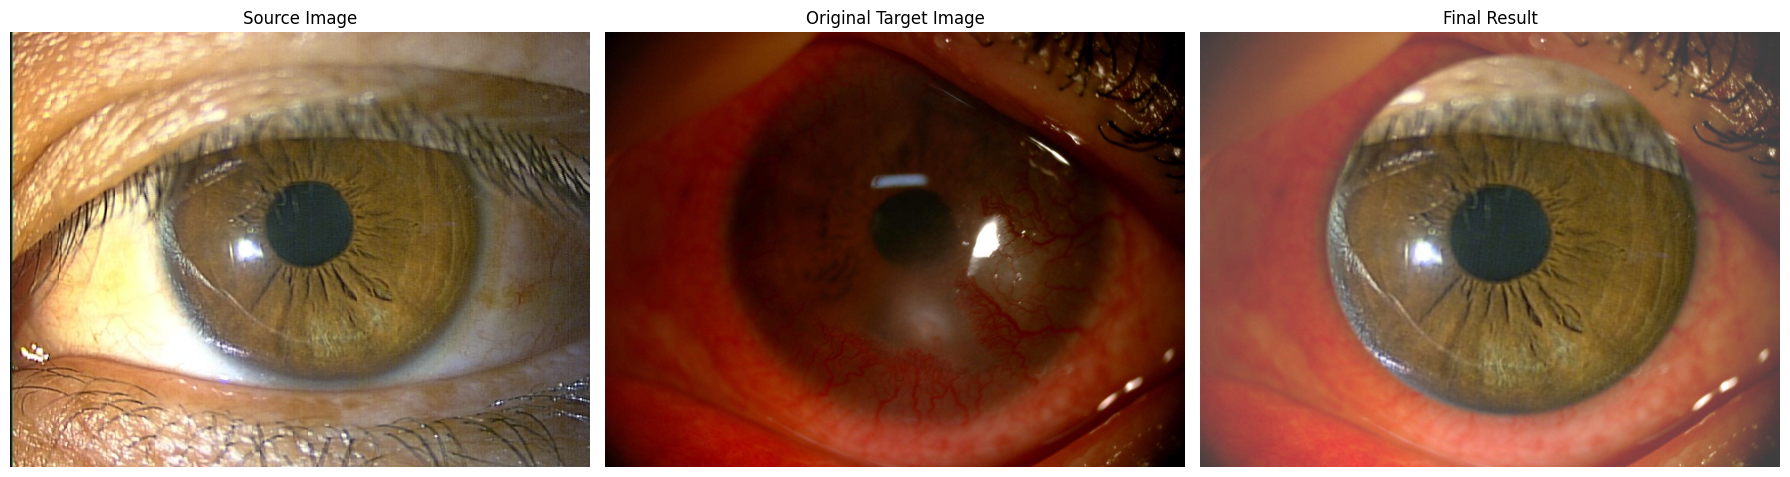

In [ ]:
"""
ËßíËÜúÁîªÂÉè„ÅÆÊ•ïÂÜÜÈ†òÂüüÁßªÊ§ç„Éó„É≠„Ç∞„É©„É†

„Åì„ÅÆ„Éó„É≠„Ç∞„É©„É†„ÅØ„ÄÅ„ÅÇ„ÇãÁúº„ÅÆÁîªÂÉèÔºà„ÇΩ„Éº„ÇπÔºâ„Åã„ÇâËßíËÜúÔºàÊ•ïÂÜÜÈ†òÂüüÔºâ„ÇíÊäΩÂá∫„Åó„ÄÅ
Âà•„ÅÆÁúº„ÅÆÁîªÂÉèÔºà„Çø„Éº„Ç≤„ÉÉ„ÉàÔºâ„Å´ÈÅïÂíåÊÑü„Å™„ÅèÁßªÊ§ç„Åô„Çã„Åì„Å®„ÇíÁõÆÁöÑ„Å®„Åó„Åæ„Åô„ÄÇ

‚ñ† ‰∏ª„Å™Âá¶ÁêÜ„ÅÆÊµÅ„Çå
1. ÊÉÖÂ†±„ÅÆÂèñÂæó:
   - `annotations.xml` „Éï„Ç°„Ç§„É´„Åã„Çâ„ÄÅ„ÇΩ„Éº„ÇπÁîªÂÉè„Å®„Çø„Éº„Ç≤„ÉÉ„ÉàÁîªÂÉè„ÅÆÊ•ïÂÜÜÔºàËßíËÜúÔºâ„ÅÆ
     ‰ΩçÁΩÆ„ÄÅÂ§ß„Åç„Åï„ÄÅÂõûËª¢ËßíÂ∫¶„Å´Èñ¢„Åô„ÇãÊÉÖÂ†±„ÇíË™≠„ÅøËæº„Åø„Åæ„Åô„ÄÇ

2. ËºùÂ∫¶„Éû„ÉÉ„ÉÅ„É≥„Ç∞:
   - „ÇΩ„Éº„Çπ„Å®„Çø„Éº„Ç≤„ÉÉ„Éà„ÅÆÊ•ïÂÜÜÈ†òÂüü„ÅÆÂπ≥ÂùáÁöÑ„Å™Êòé„Çã„Åï„ÇíË®àÁÆó„Åó„Åæ„Åô„ÄÇ
   - ‰∏°ËÄÖ„ÅÆÊòé„Çã„Åï„Åå‰∏ÄËá¥„Åô„Çã„Çà„ÅÜ„Å´„ÄÅ„Çø„Éº„Ç≤„ÉÉ„ÉàÁîªÂÉèÂÖ®‰Ωì„ÅÆËºùÂ∫¶„ÇíË™øÊï¥„Åó„Åæ„Åô„ÄÇ
     „Åì„Çå„Å´„Çà„Çä„ÄÅÁßªÊ§çÂæå„ÅÆËâ≤„ÅÆÂ∑Æ„ÇíÊúÄÂ∞èÈôê„Å´Êäë„Åà„Åæ„Åô„ÄÇ

3. „Ç¢„Éï„Ç£„É≥Â§âÊèõ„Å´„Çà„ÇãÁßªÊ§ç:
   - „ÇΩ„Éº„Çπ„ÅÆÊ•ïÂÜÜ„Çí„Çø„Éº„Ç≤„ÉÉ„Éà„ÅÆÊ•ïÂÜÜ„Å´„Å¥„Å£„Åü„ÇäÈáç„Å≠Âêà„Çè„Åõ„Çã„Åü„ÇÅ„ÅÆ„Ç¢„Éï„Ç£„É≥Â§âÊèõË°åÂàó„ÇíË®àÁÆó„Åó„Åæ„Åô„ÄÇ
     „Åì„ÅÆÊâãÊ≥ï„Å´„Çà„Çä„ÄÅÂçòÁ¥î„Å™„É™„Çµ„Ç§„Ç∫„ÅßËµ∑„Åì„Çã„Çà„ÅÜ„Å™ÂΩ¢„ÅÆÊ≠™„Åø„ÇíÈò≤„Åé„Åæ„Åô„ÄÇ
   - Ë®àÁÆó„Åó„ÅüË°åÂàó„Çí‰Ωø„Å£„Å¶„ÇΩ„Éº„ÇπÁîªÂÉèÂÖ®‰Ωì„ÇíÂ§âÂΩ¢„Åï„Åõ„ÄÅËßíËÜú„Åå„Çø„Éº„Ç≤„ÉÉ„Éà„ÅÆ‰ΩçÁΩÆ„Å´
     Ê≠£Á¢∫„Å´ÁßªÂãï„ÉªÂõûËª¢„ÉªÊã°Â§ß/Á∏ÆÂ∞è„Åï„Çå„Çã„Çà„ÅÜ„Å´„Åó„Åæ„Åô„ÄÇ

4. ÂêàÊàê„Å®„Éñ„É¨„É≥„Éá„Ç£„É≥„Ç∞:
   - „Çø„Éº„Ç≤„ÉÉ„ÉàÁîªÂÉè‰∏ä„Å´„ÄÅÂ§âÂΩ¢„Åï„Åõ„Åü„ÇΩ„Éº„ÇπÁîªÂÉè„ÇíÈáç„Å≠Âêà„Çè„Åõ„Åæ„Åô„ÄÇ
   - Â¢ÉÁïå„ÅåËá™ÁÑ∂„Å´Ë¶ã„Åà„Çã„Çà„ÅÜ„Å´„Éû„Çπ„ÇØÂá¶ÁêÜ„ÇíË°å„ÅÑ„ÄÅÁ∏Å„Çí„Åº„Åã„Åó„Å¶„Çπ„É†„Éº„Ç∫„Å´ÂêàÊàê„Åó„Åæ„Åô„ÄÇ

5. ÁµêÊûú„ÅÆË°®Á§∫„Å®‰øùÂ≠ò:
   - ÂÖÉ„ÅÆÁîªÂÉè„Å®„ÄÅÊúÄÁµÇÁöÑ„Å´ÁîüÊàê„Åï„Çå„ÅüÂêàÊàêÁîªÂÉè„ÇíË°®Á§∫„Åó„ÄÅÁµêÊûú„ÇíÁ¢∫Ë™ç„Åß„Åç„Çã„Çà„ÅÜ„Å´„Åó„Åæ„Åô„ÄÇ
   - ÂÆåÊàê„Åó„ÅüÁîªÂÉè„Çí„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò„Åó„Åæ„Åô„ÄÇ
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

def get_ellipse_from_xml(xml_path, image_name):
    """
    XML„Éï„Ç°„Ç§„É´„Åã„ÇâÊåáÂÆö„Åó„ÅüÁîªÂÉè„ÅÆÊ•ïÂÜÜÊÉÖÂ†±„ÇíÂèñÂæó„Åó„Åæ„Åô„ÄÇ
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # XMLÂÜÖ„ÅßÊåáÂÆö„Åï„Çå„ÅüÁîªÂÉèÂêç„Å®‰∏ÄËá¥„Åô„ÇãÊÉÖÂ†±„ÇíÊé¢„Åô
    for image in root.findall('.//image'):
        if image.get('name') == os.path.basename(image_name):
            ellipse = image.find('ellipse')
            if ellipse is not None:
                return {
                    'cx': float(ellipse.get('cx')),
                    'cy': float(ellipse.get('cy')),
                    'rx': float(ellipse.get('rx')),
                    'ry': float(ellipse.get('ry')),
                    'rotation': float(ellipse.get('rotation', '0'))
                }
    return None

def get_ellipse_mean_brightness(image, ellipse_params):
    """
    ÊåáÂÆö„Åï„Çå„ÅüÊ•ïÂÜÜÈ†òÂüü„ÅÆÂπ≥ÂùáËºùÂ∫¶„ÇíË®àÁÆó„Åó„Åæ„Åô„ÄÇ
    """
    # Ê•ïÂÜÜÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.ellipse(mask,
                (int(ellipse_params['cx']), int(ellipse_params['cy'])),
                (int(ellipse_params['rx']), int(ellipse_params['ry'])),
                ellipse_params['rotation'], 0, 360, 255, -1)

    # ÁîªÂÉè„Çí„Ç∞„É¨„Éº„Çπ„Ç±„Éº„É´„Å´Â§âÊèõ„Åó„ÄÅ„Éû„Çπ„ÇØÈ†òÂüü„ÅÆÂπ≥ÂùáÂÄ§„ÇíË®àÁÆó
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = cv2.mean(gray, mask=mask)[0]

    return mean_brightness

def affine_brightness_matched_transplant(source_path, target_path, xml_path):
    """
    „Ç¢„Éï„Ç£„É≥Â§âÊèõ„ÇíÁî®„ÅÑ„Å¶Ê•ïÂÜÜ„ÇíÊ≠™„Åø„Å™„ÅèÁßªÊ§ç„Åó„ÄÅËºùÂ∫¶„Éû„ÉÉ„ÉÅ„É≥„Ç∞„ÇÇË°å„ÅÑ„Åæ„Åô„ÄÇ
    """
    # 1. ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø„Å®Ëâ≤Á©∫Èñì„ÅÆÂ§âÊèõ (BGR -> RGB)
    source_img = cv2.imread(source_path)
    target_img = cv2.imread(target_path)
    if source_img is None or target_img is None:
        print("ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó„Åó„Åæ„Åó„Åü„ÄÇ")
        return None
    source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    h, w = target_img.shape[:2]

    # 2. XML„Åã„ÇâÊ•ïÂÜÜ„ÅÆ„Éë„É©„É°„Éº„Çø„ÇíÂèñÂæó
    source_ellipse = get_ellipse_from_xml(xml_path, source_path)
    target_ellipse = get_ellipse_from_xml(xml_path, target_path)
    if source_ellipse is None or target_ellipse is None:
        print("Ê•ïÂÜÜ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")
        return None

    # 3. ËºùÂ∫¶„ÇíË®àÁÆó„Åó„ÄÅ„Çø„Éº„Ç≤„ÉÉ„ÉàÁîªÂÉè„ÅÆËºùÂ∫¶„ÇíË™øÊï¥
    source_brightness = get_ellipse_mean_brightness(source_img, source_ellipse)
    target_brightness = get_ellipse_mean_brightness(target_img, target_ellipse)
    brightness_diff = source_brightness - target_brightness
    target_img_adjusted = np.clip(target_img.astype(np.float32) + brightness_diff, 0, 255).astype(np.uint8)

    # 4. „ÇΩ„Éº„ÇπÊ•ïÂÜÜ„ÅÆ‰ΩçÁΩÆ„ÉªÂõûËª¢„ÉªÂ§ß„Åç„Åï„ÇíÂÆöÁæ©„Åô„Çã3ÁÇπ„ÇíË®≠ÂÆö
    src_angle_rad = np.deg2rad(source_ellipse['rotation'])
    src_cos = np.cos(src_angle_rad)
    src_sin = np.sin(src_angle_rad)
    src_pts = np.float32([
        [source_ellipse['cx'], source_ellipse['cy']],
        [source_ellipse['cx'] + source_ellipse['rx'] * src_cos, source_ellipse['cy'] + source_ellipse['rx'] * src_sin],
        [source_ellipse['cx'] - source_ellipse['ry'] * src_sin, source_ellipse['cy'] + source_ellipse['ry'] * src_cos]
    ])

    # 5. „Çø„Éº„Ç≤„ÉÉ„ÉàÊ•ïÂÜÜ„Å´ÂØæÂøú„Åô„Çã3ÁÇπ„ÇíË®≠ÂÆö
    tgt_angle_rad = np.deg2rad(target_ellipse['rotation'])
    tgt_cos = np.cos(tgt_angle_rad)
    tgt_sin = np.sin(tgt_angle_rad)
    tgt_pts = np.float32([
        [target_ellipse['cx'], target_ellipse['cy']],
        [target_ellipse['cx'] + target_ellipse['rx'] * tgt_cos, target_ellipse['cy'] + target_ellipse['rx'] * tgt_sin],
        [target_ellipse['cx'] - target_ellipse['ry'] * tgt_sin, target_ellipse['cy'] + target_ellipse['ry'] * tgt_cos]
    ])

    # 6. 3ÁÇπ„ÅÆÂØæÂøúÈñ¢‰øÇ„Åã„Çâ„Ç¢„Éï„Ç£„É≥Â§âÊèõË°åÂàó„ÇíË®àÁÆó
    M = cv2.getAffineTransform(src_pts, tgt_pts)

    # 7. Â§âÊèõË°åÂàó„ÇíÁî®„ÅÑ„Å¶„ÇΩ„Éº„ÇπÁîªÂÉè„Çí„ÉØ„Éº„Éó„Åï„Åõ„Çã
    source_warped = cv2.warpAffine(source_img, M, (w, h))

    # 8. „Éñ„É¨„É≥„Éá„Ç£„É≥„Ç∞Áî®„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(mask,
                (int(target_ellipse['cx']), int(target_ellipse['cy'])),
                (int(target_ellipse['rx']), int(target_ellipse['ry'])),
                target_ellipse['rotation'], 0, 360, 255, -1)

    # „Éû„Çπ„ÇØ„ÅÆÂ¢ÉÁïå„Çí„Åº„Åã„Åó„Å¶Ëá™ÁÑ∂„Å™ÂêàÊàê„ÇíÂÆüÁèæ
    mask_blurred = cv2.GaussianBlur(mask, (21, 21), 10)
    mask_3ch = cv2.cvtColor(mask_blurred, cv2.COLOR_GRAY2BGR).astype('float32') / 255.0

    # 9. „ÉØ„Éº„Éó„Åó„Åü„ÇΩ„Éº„ÇπÁîªÂÉè„Å®ËºùÂ∫¶Ë™øÊï¥Ê∏à„Åø„ÅÆ„Çø„Éº„Ç≤„ÉÉ„ÉàÁîªÂÉè„ÇíÂêàÊàê
    result = (mask_3ch * source_warped) + ((1 - mask_3ch) * target_img_adjusted)
    result = result.astype(np.uint8)

    # 10. ÁµêÊûú„ÅÆË°®Á§∫
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(source_img)
    axes[0].set_title('Source Image')
    axes[0].axis('off')

    axes[1].imshow(target_img)
    axes[1].set_title('Original Target Image')
    axes[1].axis('off')

    axes[2].imshow(result)
    axes[2].set_title('Final Result')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return result

# --- „Åì„Åì„Åã„ÇâÂÆüË°å ---

# Ê≥®Ôºö„ÅîËá™Ë∫´„ÅÆÁí∞Â¢É„Å´Âêà„Çè„Åõ„Å¶„Éë„Çπ„Çí‰øÆÊ≠£„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ
# Google Colab„Çí‰ΩøÁî®„Åó„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØ„ÄÅÂÖàÈ†≠„Å´ /content/gdrive/ „ÅÆ„Çà„ÅÜ„Å™„Éë„Çπ„ÅåÂøÖË¶Å„Åß„Åô„ÄÇ
xml_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
source_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[normal]FKS_301_L_slit.jpg"
target_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]Á¥∞Ëèå_tkb0417_01.jpg"

# Èñ¢Êï∞„ÇíÂÆüË°å
final_image = affine_brightness_matched_transplant(source_path, target_path, xml_path)

# ÁµêÊûú„Çí‰øùÂ≠ò„Åó„Åü„ÅÑÂ†¥Âêà
# if final_image is not None:
#     output_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/transplanted_final.jpg"
#     # Matplotlib„ÅØRGB„ÅßÂá¶ÁêÜ„Åô„Çã„Åå„ÄÅOpenCV„ÅØBGR„Åß‰øùÂ≠ò„Åô„Çã„Åü„ÇÅËâ≤Á©∫Èñì„ÇíÂ§âÊèõ
#     cv2.imwrite(output_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
#     print(f"ÁµêÊûú„Çí {output_path} „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ")

### Create cut-and-paste list

In [ ]:
# Google¬†Colab¬†script: create cutmix CSV from Ueno_Mix1039_over90.csv
# Drive „ÅØ /gdrive „Å´„Éû„Ç¶„É≥„Éà„Åô„ÇãÊÉ≥ÂÆö
from google.colab import drive
drive.mount('/gdrive')   # ‚Üê „Åì„Åì„Å´Âêà„Çè„Åõ„Å¶ÂÖ®„Éë„Çπ„ÇíÂ§âÊõ¥

import pandas as pd
import re

# --- Paths -------------------------------------------------------------
src_path = ("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/"
            "Ueno_Mix1039/Ueno_Mix1039_over90.csv")
dst_path = ("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/"
            "Ueno_Mix1039/Ueno_Mix1039_cutmix.csv")

# --- Label mapping -----------------------------------------------------
label_mapping = {
    "infection": "infection",
    "normal": "normal",
    "immun": "non-infection",
    "scar": "scar",
    "tumor": "tumor",
    "deposit": "deposit",
    "apac": "APAC",
    "cat": "lens opacity",
    "bullous": "bullous",
}

# --- Load & preprocess -------------------------------------------------
df = pd.read_csv(src_path, encoding="utf-8")

# ‚ë† ÁîªË≥™ 1 „ÅÆ„ÅøÊäΩÂá∫
df_q1 = df[df["Image_quality"] == 1].copy()

# ‚ë° basename ÂÖàÈ†≠„ÅÆ [xxx] „ÇíÊäΩÂá∫
def extract_bracket_label(basename: str) -> str:
    m = re.match(r"\[([^\]]+)\]", basename)
    return m.group(1).lower() if m else ""

df_q1["raw_label"] = df_q1["image_basename"].apply(extract_bracket_label)

# ‚ë¢ mapping „ÅßÊ≠£Âºè„ÇØ„É©„ÇπÂêç„Å∏
df_q1["class"] = df_q1["raw_label"].map(label_mapping)

# --- Prepare background / cornea tables --------------------------------
bg = df_q1[["image_basename", "class"]].rename(
    columns={"image_basename": "background_basename", "class": "background_class"}
)
cor = df_q1[["image_basename", "class"]].rename(
    columns={"image_basename": "cornea_basename", "class": "cornea_class"}
)
bg["key"] = 1
cor["key"] = 1

# --- Cartesian product -------------------------------------------------
cutmix_df = bg.merge(cor, on="key").drop(columns="key")

# --- Add empty prediction columns --------------------------------------
cutmix_df["cornea_pred"] = pd.NA   # ‚Üê NaN (Ê¨†Êêç) „Å´„Åó„Å¶„Åä„Åè„Å®ÂæåÂ∑•Á®ã„Åß isna Âà§ÂÆö„Åó„ÇÑ„Åô„ÅÑ
cutmix_df["cutmix_pred"] = pd.NA

# --- Save --------------------------------------------------------------
cutmix_df.to_csv(dst_path, index=False, encoding="utf-8-sig")
print("Saved:", dst_path, "shape:", cutmix_df.shape)


Mounted at /gdrive
Saved: /gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv shape: (116281, 6)


In [ ]:
"""
cutmix_cornea_inference_colab_fix.py
------------------------------------
cornea_pred / cutmix_pred „Çí YOLO Êé®Ë´ñ„ÅßÂüã„ÇÅ„ÇãÔºàNaN Âà§ÂÆö‰øÆÊ≠£ÁâàÔºâ
"""

# --- Colab Áî® importÔºàÂ§âÊõ¥„Å™„ÅóÔºâ --------------------------
import cv2, torch, warnings, matplotlib
matplotlib.use('Agg')
from tqdm import tqdm
import pandas as pd, numpy as np, os, xml.etree.ElementTree as ET
from pathlib import Path

from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])
warnings.filterwarnings("ignore", category=FutureWarning)
# ----------------------------------------------------------

# ---------- „Éë„ÇπË®≠ÂÆö ----------
CSV_PATH = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv"
IMG_DIR  = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
XML_PATH = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
MODEL_WEIGHTS = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
CHECKPOINT_EVERY = 100      # ‰øùÂ≠òÈñìÈöî
MAX_ROWS = None             # „Éá„Éê„ÉÉ„Ç∞Áî®„Å´ 500 Á≠â„Å´„Åô„Çã„Å®Êó©„ÅèÁ¢∫Ë™çÂèØ
# -----------------------------

CLASS_NAMES = ["infection","normal","non-infection","scar","tumor",
               "deposit","APAC","lens opacity","bullous"]

# ----- Ê•ïÂÜÜ„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ----------------------------------
def get_ellipse(xml_p, img_p):
    name = os.path.basename(img_p)
    for node in ET.parse(xml_p).findall('.//image'):
        if node.get('name') == name:
            el = node.find('ellipse')
            if el is None: return None
            return dict(cx=float(el.get('cx')), cy=float(el.get('cy')),
                        rx=float(el.get('rx')), ry=float(el.get('ry')),
                        rotation=float(el.get('rotation', '0')))
    return None

def cut_ellipse(img, ep):
    h,w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    cv2.ellipse(mask,(int(ep['cx']),int(ep['cy'])),(int(ep['rx']),int(ep['ry'])),
                ep['rotation'],0,360,255,-1)
    white = np.ones_like(img)*255
    return np.where(mask[...,None]>0, img, white)

def affine_transplant(src, tgt, ep_s, ep_t):
    def three(ep):
        a=np.deg2rad(ep['rotation']); c,s=np.cos(a),np.sin(a)
        return np.float32([[ep['cx'],ep['cy']],
                           [ep['cx']+ep['rx']*c, ep['cy']+ep['rx']*s],
                           [ep['cx']-ep['ry']*s, ep['cy']+ep['ry']*c]])
    M=cv2.getAffineTransform(three(ep_s), three(ep_t))
    warp=cv2.warpAffine(src, M, (tgt.shape[1], tgt.shape[0]))
    mask=np.zeros(tgt.shape[:2],np.uint8)
    cv2.ellipse(mask,(int(ep_t['cx']),int(ep_t['cy'])),(int(ep_t['rx']),int(ep_t['ry'])),
                ep_t['rotation'],0,360,255,-1)
    mask3=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255.0
    return (mask3*warp + (1-mask3)*tgt).astype(np.uint8)
# ----------------------------------------------------------

# -------------- YOLO Êé®Ë´ñ ---------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = attempt_load(MODEL_WEIGHTS, device=device).eval()

def prep(img):
    img = letterbox(img, new_shape=(640,640))[0]
    img = img.transpose((2,0,1))[None].astype(np.float32)/255.0
    return torch.from_numpy(img).to(device)

@torch.no_grad()
def yolo_cls(rgb):
    det = yolo_nms(model(prep(rgb))[0], 0.25, 0.45, max_det=1)[0]
    if len(det):
        cls = int(det[0,5]); return CLASS_NAMES[cls]
    return "none"
# ----------------------------------------------------------

def img_path(basename):
    for e in (".jpg",".Jpg",".jpeg",".png"):
        p = Path(IMG_DIR)/f"{basename}{e}"
        if p.exists(): return str(p)
    return None

# ===================== „É°„Ç§„É≥Âá¶ÁêÜ ==========================
def main():
    df = pd.read_csv(CSV_PATH, dtype=str)   # dtype=str ‚Üí Á©∫Ê¨Ñ„ÅØ NaN „ÅÆ„Åæ„Åæ
    if MAX_ROWS: df = df.head(MAX_ROWS)

    todo_idx = df.index[ pd.isna(df.cornea_pred) | pd.isna(df.cutmix_pred) ]
    print(f"Rows to process: {len(todo_idx)} / {len(df)}")

    for count, idx in enumerate(tqdm(todo_idx, desc="processing")):
        row = df.loc[idx]

        cor_p = img_path(row.cornea_basename)
        bg_p  = img_path(row.background_basename)
        if not cor_p or not bg_p: continue

        # ---------- cornea_pred ----------
        if pd.isna(row.cornea_pred):
            img = cv2.cvtColor(cv2.imread(cor_p), cv2.COLOR_BGR2RGB)
            ep  = get_ellipse(XML_PATH, cor_p)
            df.at[idx,'cornea_pred'] = yolo_cls(cut_ellipse(img, ep)) if ep else "no_ellipse"

        # ---------- cutmix_pred ----------
        if pd.isna(row.cutmix_pred):
            src=cv2.cvtColor(cv2.imread(cor_p),cv2.COLOR_BGR2RGB)
            tgt=cv2.cvtColor(cv2.imread(bg_p ),cv2.COLOR_BGR2RGB)
            ep_s,ep_t = get_ellipse(XML_PATH, cor_p), get_ellipse(XML_PATH, bg_p)
            if ep_s and ep_t:
                comp = affine_transplant(src, tgt, ep_s, ep_t)
                df.at[idx,'cutmix_pred'] = yolo_cls(comp)
            else:
                df.at[idx,'cutmix_pred'] = "no_ellipse"

        # ------- „ÉÅ„Çß„ÉÉ„ÇØ„Éù„Ç§„É≥„Éà -------
        if (count+1) % CHECKPOINT_EVERY == 0:
            df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
            print(f"[checkpoint] {count+1} rows done")

    # ------ ÊúÄÁµÇ‰øùÂ≠ò ------
    df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
    print("All done & CSV saved.")

if __name__ == "__main__":
    main()


##**Cornea_only prediction**

### Create cornea_only list

In [ ]:
import pandas as pd

# --- Paths -------------------------------------------------------------
src_path = ("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/"
            "Ueno_Mix1039/Ueno_Mix1039_over90.csv")
dst_path = ("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/"
            "Ueno_Mix1039/Ueno_Mix1039_corneacrop.csv")

# --- Load & preprocess -------------------------------------------------
df = pd.read_csv(src_path, encoding="utf-8")

# image_quality == 1 „ÅÆ„Åø„Å´ÈôêÂÆö
df_quality1 = df[df["Image_quality"] == 1].copy()

# image_basename, GroundTruth, Predict „ÅÆ3Âàó„ÅÆ„Åø„ÇíÊäΩÂá∫
df_selected = df_quality1[["image_basename", "GroundTruth", "Predict"]].copy()

# Cornea_onlyÂàó„ÇíÊñ∞Ë¶è‰ΩúÊàêÔºàNaNÔºâ
df_selected["Cornea_only"] = pd.NA

# --- Save --------------------------------------------------------------
df_selected.to_csv(dst_path, index=False, encoding="utf-8-sig")
print("Saved:", dst_path, "shape:", df_selected.shape)
print(f"Original data: {len(df)} rows")
print(f"After quality==1 filter: {len(df_quality1)} rows")

Saved: /gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_corneacrop.csv shape: (341, 4)
Original data: 667 rows
After quality==1 filter: 341 rows


In [ ]:
"""
cornea_crop_inference.py
-----------------------
Ueno_Mix1039_corneacrop.csv „ÅÆ Cornea_only Âàó„Çí YOLO Êé®Ë´ñ„ÅßÂüã„ÇÅ„Çã
"""

# --- Colab Áî® import --------------------------
import cv2, torch, warnings, matplotlib
matplotlib.use('Agg')
from tqdm import tqdm
import pandas as pd, numpy as np, os, xml.etree.ElementTree as ET
from pathlib import Path

from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])
warnings.filterwarnings("ignore", category=FutureWarning)
# ----------------------------------------------------------

# ---------- „Éë„ÇπË®≠ÂÆö ----------
CSV_PATH = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_corneacrop.csv"
IMG_DIR  = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
XML_PATH = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
MODEL_WEIGHTS = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
CHECKPOINT_EVERY = 100      # ‰øùÂ≠òÈñìÈöî
MAX_ROWS = None             # „Éá„Éê„ÉÉ„Ç∞Áî®„Å´ 500 Á≠â„Å´„Åô„Çã„Å®Êó©„ÅèÁ¢∫Ë™çÂèØ
# -----------------------------

CLASS_NAMES = ["infection","normal","non-infection","scar","tumor",
               "deposit","APAC","lens opacity","bullous"]

# ----- Ê•ïÂÜÜ„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ----------------------------------
def get_ellipse(xml_p, img_p):
    """XML„Åã„ÇâÊ•ïÂÜÜÊÉÖÂ†±„ÇíÂèñÂæó"""
    name = os.path.basename(img_p)
    for node in ET.parse(xml_p).findall('.//image'):
        if node.get('name') == name:
            el = node.find('ellipse')
            if el is None: return None
            return dict(cx=float(el.get('cx')), cy=float(el.get('cy')),
                        rx=float(el.get('rx')), ry=float(el.get('ry')),
                        rotation=float(el.get('rotation', '0')))
    return None

def cut_ellipse(img, ep):
    """Ê•ïÂÜÜÈ†òÂüü„ÇíÂàá„ÇäÂá∫„Åó„ÄÅËÉåÊôØ„ÇíÁôΩ„Å´„Åô„Çã"""
    h,w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    cv2.ellipse(mask,(int(ep['cx']),int(ep['cy'])),(int(ep['rx']),int(ep['ry'])),
                ep['rotation'],0,360,255,-1)
    white = np.ones_like(img)*255
    return np.where(mask[...,None]>0, img, white)
# ----------------------------------------------------------

# -------------- YOLO Êé®Ë´ñ ---------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = attempt_load(MODEL_WEIGHTS, device=device).eval()

def prep(img):
    """ÁîªÂÉè„Çí YOLO ÂÖ•ÂäõÁî®„Å´ÂâçÂá¶ÁêÜ"""
    img = letterbox(img, new_shape=(640,640))[0]
    img = img.transpose((2,0,1))[None].astype(np.float32)/255.0
    return torch.from_numpy(img).to(device)

@torch.no_grad()
def yolo_cls(rgb):
    """YOLO „Åß„ÇØ„É©„ÇπÊé®Ë´ñ"""
    det = yolo_nms(model(prep(rgb))[0], 0.25, 0.45, max_det=1)[0]
    if len(det):
        cls = int(det[0,5]); return CLASS_NAMES[cls]
    return "none"
# ----------------------------------------------------------

def img_path(basename):
    """basename „Åã„ÇâÂÆüÈöõ„ÅÆÁîªÂÉè„Éë„Çπ„ÇíÂèñÂæó"""
    for e in (".jpg",".Jpg",".jpeg",".png"):
        p = Path(IMG_DIR)/f"{basename}{e}"
        if p.exists(): return str(p)
    return None

# ===================== „É°„Ç§„É≥Âá¶ÁêÜ ==========================
def main():
    # CSV „ÇíË™≠„ÅøËæº„ÅøÔºàdtype=str „ÅßÁ©∫Ê¨Ñ„ÅØ NaN „ÅÆ„Åæ„ÅæÔºâ
    df = pd.read_csv(CSV_PATH, dtype=str)
    if MAX_ROWS: df = df.head(MAX_ROWS)

    # Cornea_only „Åå NaN „ÅÆË°å„ÅÆ„ÅøÂá¶ÁêÜÂØæË±°
    todo_idx = df.index[pd.isna(df.Cornea_only)]
    print(f"Rows to process: {len(todo_idx)} / {len(df)}")

    for count, idx in enumerate(tqdm(todo_idx, desc="processing")):
        row = df.loc[idx]

        # ÁîªÂÉè„Éë„Çπ„ÇíÂèñÂæó
        img_p = img_path(row.image_basename)
        if not img_p:
            df.at[idx, 'Cornea_only'] = "no_image"
            continue

        # ÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø
        img = cv2.cvtColor(cv2.imread(img_p), cv2.COLOR_BGR2RGB)

        # Ê•ïÂÜÜÊÉÖÂ†±„ÇíÂèñÂæó
        ep = get_ellipse(XML_PATH, img_p)
        if not ep:
            df.at[idx, 'Cornea_only'] = "no_ellipse"
            continue

        # Ê•ïÂÜÜÈ†òÂüü„ÇíÂàá„ÇäÂá∫„ÅóÔºàËÉåÊôØ„ÅØÁôΩÔºâ
        cornea_cropped = cut_ellipse(img, ep)

        # YOLO „ÅßÊé®Ë´ñ
        pred_class = yolo_cls(cornea_cropped)
        df.at[idx, 'Cornea_only'] = pred_class

        # „ÉÅ„Çß„ÉÉ„ÇØ„Éù„Ç§„É≥„Éà‰øùÂ≠ò
        if (count+1) % CHECKPOINT_EVERY == 0:
            df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
            print(f"[checkpoint] {count+1} rows done")

    # ÊúÄÁµÇ‰øùÂ≠ò
    df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
    print("All done & CSV saved.")

if __name__ == "__main__":
    main()

#**Existing Methods**

##**RISE**

ÁîªÂÉèÂÖ®‰Ωì„ÅåË®∫Êñ≠ÂØæË±°

ÈÄöÂ∏∏„ÅÆÁâ©‰ΩìÊ§úÂá∫ÔºàËªä„ÄÅÁä¨„Å™„Å©ÔºâÔºöËÉåÊôØ„Å®Áâ©‰Ωì„ÅåÊòéÁ¢∫„Å´ÂàÜÈõ¢
ËßíËÜúÁîªÂÉèÔºöÁîªÂÉèÂÖ®‰Ωì„ÅåË®∫Êñ≠ÂØæË±°„Åß„ÄÅ„ÄåËÉåÊôØ„Äç„ÅåÂ≠òÂú®„Åó„Å™„ÅÑ
„Å©„Åì„Çí„Éû„Çπ„ÇØ„Åó„Å¶„ÇÇ„ÄÅÊÆã„Å£„ÅüÈÉ®ÂàÜ„Åã„ÇâÂêå„ÅòË®∫Êñ≠„ÅåÂèØËÉΩ


„ÉÜ„ÇØ„Çπ„ÉÅ„É£„Éª„Éë„Çø„Éº„É≥„Éô„Éº„Çπ„ÅÆË®∫Êñ≠

infection„ÇÑAPAC„Å™„Å©„ÅØ„ÄÅÂ±ÄÊâÄÁöÑ„Å™ÁóÖÂ§â„Å®„ÅÑ„ÅÜ„Çà„ÇäÂÖ®‰ΩìÁöÑ„Å™„ÉÜ„ÇØ„Çπ„ÉÅ„É£„ÇÑËâ≤Ë™ø„ÅÆÂ§âÂåñ
ÁâπÂæ¥„ÅåÁîªÂÉèÂÖ®‰Ωì„Å´ÂàÜÊï£„Åó„Å¶„ÅÑ„Çã„Åü„ÇÅ„ÄÅÈÉ®ÂàÜÁöÑ„Å´„Éû„Çπ„ÇØ„Åó„Å¶„ÇÇË®∫Êñ≠ÂèØËÉΩ

In [ ]:
import numpy as np
import cv2
import torch
import os
import warnings
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def non_max_suppression_multilabel(prediction, logits, conf_thres=0.25, iou_thres=0.45,
                                   classes=None, agnostic=False, multi_label=True,
                                   labels=(), max_det=300):
    """
    „Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøú„ÅÆNMS„ÄÇÂêÑÊ§úÂá∫„Å´ÂØæ„Åó„Å¶Ë§áÊï∞„ÇØ„É©„Çπ„ÅÆÁ¢∫Áéá„Çí‰øùÊåÅ
    """
    import time
    nc = prediction.shape[2] - 5
    xc = prediction[..., 4] > conf_thres

    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

    min_wh, max_wh = 2, 4096
    max_nms = 30000
    time_limit = 10.0
    redundant = True
    merge = False

    t = time.time()
    output = [torch.zeros((0, 6 + nc), device=prediction.device)] * prediction.shape[0]  # nc„ÇØ„É©„ÇπÂàÜ„ÅÆÁ¢∫Áéá„Çí‰øùÊåÅ
    logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

    for xi, (x, log_) in enumerate(zip(prediction, logits)):
        x = x[xc[xi]]
        log_ = log_[xc[xi]]

        if not x.shape[0]:
            continue

        # „ÇØ„É©„Çπ„Åî„Å®„ÅÆÁ¢∫Áéá„ÇíË®àÁÆóÔºà„Éú„ÉÉ„ÇØ„ÇπÁ¢∫‰ø°Â∫¶ √ó „ÇØ„É©„ÇπÁ¢∫ÁéáÔºâ
        x[:, 5:] *= x[:, 4:5]
        box = xywh2xyxy(x[:, :4])

        # ÂÖ®„ÇØ„É©„Çπ„ÅÆÁ¢∫Áéá„Çí‰øùÊåÅ
        if multi_label:
            # ÂêÑ„Éú„ÉÉ„ÇØ„Çπ„Åî„Å®„Å´ÊúÄÂ§ßÁ¢∫Áéá„ÅÆ„ÇØ„É©„Çπ„Åß„Ç∞„É´„Éº„ÉóÂåñ
            conf, j = x[:, 5:].max(1, keepdim=True)
            x_single = torch.cat((box, conf, j.float()), 1)

            # NMSÂá¶ÁêÜÔºàÊúÄÂ§ßÁ¢∫Áéá„ÅÆ„ÇØ„É©„Çπ„Å´Âü∫„Å•„ÅÑ„Å¶Ôºâ
            c = j * (0 if agnostic else max_wh)
            boxes, scores = box + c, conf.squeeze(-1)  # ÊúÄÂæå„ÅÆÊ¨°ÂÖÉ„Å†„Åësqueeze
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            # ÈÅ∏Êäû„Åï„Çå„Åü„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂÖ®ÊÉÖÂ†±„Çí‰øùÊåÅ
            # [x1, y1, x2, y2, conf, class, prob_class0, prob_class1, ..., prob_classN]
            output[xi] = torch.cat((x_single[i, :4], x_single[i, 4:5], j[i].float(), x[i, 5:]), 1)
            logits_output[xi] = log_[i]
        else:
            # Êó¢Â≠ò„ÅÆÂá¶ÁêÜÔºà„Ç∑„É≥„Ç∞„É´„É©„Éô„É´Ôºâ
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
            log_ = log_[conf.view(-1) > conf_thres]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            output[xi] = x[i]
            logits_output[xi] = log_[i]

        if (time.time() - t) > time_limit:
            print(f"WARNING: NMS time limit {time_limit}s exceeded")
            break

    return output, logits_output


# YOLOv5TorchObjectDetector„ÇØ„É©„ÇπÔºà„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøúÁâàÔºâ
class YOLOV5TorchObjectDetectorML(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetectorML, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

        # „Éû„É´„ÉÅ„É©„Éô„É´NMS„Çí‰ΩøÁî®
        self.non_max_suppression = non_max_suppression_multilabel

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic, multi_label=True
            )
            return prediction, logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            result = self.yolo_resize(im, new_shape=self.img_size)
            if isinstance(result, tuple):
                resized_img = result[0]
            else:
                resized_img = result
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


class RISEMultiLabel:
    """„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøúRISE - Ê≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇíÁõ¥Êé•ËøΩË∑°"""

    def __init__(self, model, input_size=(640, 640), n_masks=1000, p1=0.5, s=16):
        """
        Args:
            model: YOLOv5„É¢„Éá„É´Ôºà„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøúÔºâ
            input_size: ÂÖ•ÂäõÁîªÂÉè„Çµ„Ç§„Ç∫
            n_masks: „Éû„Çπ„ÇØÊï∞
            p1: „Éû„Çπ„ÇØ„ÅÆÁ¢∫Áéá
            s: „Éû„Çπ„ÇØ„ÅÆÁ≤ó„Åï
        """
        self.model = model
        self.input_size = input_size
        self.n_masks = n_masks
        self.p1 = p1
        self.s = s

        # „Éû„Çπ„ÇØ„Çµ„Ç§„Ç∫„ÅÆË®àÁÆó
        self.mask_h = int(np.ceil(input_size[0] / s))
        self.mask_w = int(np.ceil(input_size[1] / s))

        print(f"„Éû„Çπ„ÇØË®≠ÂÆö: {self.mask_h}x{self.mask_w} (scale={s})")

        # „É©„É≥„ÉÄ„É†„Éû„Çπ„ÇØ„ÅÆÁîüÊàê
        self.masks = self._generate_masks()

        # YOLOv5„ÅÆ„Ç∞„É¨„ÉºÂÄ§
        self.mask_fill_value = torch.tensor([114/255.0, 114/255.0, 114/255.0]).view(1, 3, 1, 1)

    def _generate_masks(self):
        """„É©„É≥„ÉÄ„É†„Éû„Çπ„ÇØ„ÇíÁîüÊàê"""
        masks = np.random.rand(self.n_masks, self.mask_h, self.mask_w) < self.p1
        masks_tensor = torch.from_numpy(masks).float()
        return masks_tensor

    def get_class_likelihood(self, prediction, target_class_idx):
        """
        „Éû„É´„ÉÅ„É©„Éô„É´‰∫àÊ∏¨„Åã„ÇâÁâπÂÆö„ÇØ„É©„Çπ„ÅÆÊúÄÂ§ßÂ∞§Â∫¶„ÇíÂèñÂæó

        Args:
            prediction: „Éû„É´„ÉÅ„É©„Éô„É´NMS„ÅÆÂá∫Âäõ
            target_class_idx: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ

        Returns:
            float: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊúÄÂ§ßÂ∞§Â∫¶
        """
        if len(prediction) == 0:
            return 0.0

        # 6ÂàóÁõÆ‰ª•Èôç„ÅåÂêÑ„ÇØ„É©„Çπ„ÅÆÁ¢∫Áéá
        all_class_probs = prediction[:, 6:]

        # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÁ¢∫Áéá„ÇíÂèñÂæó
        target_probs = all_class_probs[:, target_class_idx]

        # ÊúÄÂ§ßÂÄ§„ÇíËøî„Åô
        return float(target_probs.max()) if len(target_probs) > 0 else 0.0

    def explain(self, img_tensor, target_class=None, target_class_name=None):
        """
        Ê≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇíÁõ¥Êé•ËøΩË∑°„Åô„ÇãRISE

        Args:
            img_tensor: ÂÖ•ÂäõÁîªÂÉè„ÉÜ„É≥„ÇΩ„É´
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            target_class_name: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÂêçÂâçÔºà„Ç™„Éó„Ç∑„Éß„É≥Ôºâ
        """
        self.model.eval()

        # ÂÆüÈöõ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíÂèñÂæó
        actual_h = img_tensor.shape[2]
        actual_w = img_tensor.shape[3]

        # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÅßÂá¶ÁêÜ
        batch_size = 50
        saliency = torch.zeros(actual_h, actual_w).to(img_tensor.device)

        # „Çµ„É≥„Éó„É´„Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºàÊúÄÂàù„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩøÁî®Ôºâ
        sample_mask_idx = 0

        # „Åæ„ÅöÂÖÉ„ÅÆÁîªÂÉè„ÅßÊé®Ë´ñ
        with torch.no_grad():
            # ÂÖÉ„ÅÆÊ§úÂá∫ÈñæÂÄ§„Çí‰øùÂ≠ò
            original_confidence = self.model.confidence

            prediction, _ = self.model(img_tensor)

            if len(prediction[0]) == 0:
                print("ÂÖÉÁîªÂÉè„ÅßÊ§úÂá∫„Å™„Åó")
                return None, None, None, None

            # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ±∫ÂÆö
            if target_class is None:
                # ÊúÄ„ÇÇÁ¢∫‰ø°Â∫¶„ÅåÈ´ò„ÅÑ„ÇØ„É©„Çπ„ÇíÊ≠£Ëß£„Å®„Åô„Çã
                top_class_idx = int(prediction[0][0, 5])  # ÊúÄÂàù„ÅÆÊ§úÂá∫„ÅÆÊúÄÈ´òÁ¢∫‰ø°Â∫¶„ÇØ„É©„Çπ
                target_class = top_class_idx
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)
            else:
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)

            # „Éô„Éº„Çπ„É©„Ç§„É≥„ÅÆÂ∞§Â∫¶„ÇíÂèñÂæó
            baseline_likelihood = self.get_class_likelihood(prediction[0], target_class)

            print(f"\nÊ≠£Ëß£„ÇØ„É©„Çπ: {target_class_name} (ID: {target_class})")
            print(f"„Éô„Éº„Çπ„É©„Ç§„É≥Â∞§Â∫¶: {baseline_likelihood:.4f}")

            # ÂÖ®„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇÇË°®Á§∫
            if len(prediction[0]) > 0:
                all_probs = prediction[0][0, 6:].cpu().numpy()
                top3_indices = np.argsort(all_probs)[-3:][::-1]
                print("Top-3„ÇØ„É©„Çπ:")
                for idx in top3_indices:
                    print(f"  {self.model.names[idx]}: {all_probs[idx]:.4f}")

            # Ê§úÂá∫ÈñæÂÄ§„Çí‰∏ã„Åí„Çã
            self.model.confidence = 0.01

        # „Éû„Çπ„ÇØ„ÇíÂÆüÈöõ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
        resized_masks = F.interpolate(
            self.masks.unsqueeze(1),
            size=(actual_h, actual_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(1)

        # „Çµ„É≥„Éó„É´„Éû„Çπ„ÇØ„Çí‰øùÂ≠ò
        sample_mask = resized_masks[sample_mask_idx].cpu().numpy()

        # Áµ±Ë®àÊÉÖÂ†±
        all_likelihoods = []
        detected_count = 0
        target_detected_count = 0

        # „Éû„Çπ„ÇØ„ÇíÈÅ©Áî®„Åó„Å¶Êé®Ë´ñ
        for i in tqdm(range(0, self.n_masks, batch_size), desc="RISEÂá¶ÁêÜ‰∏≠"):
            batch_masks = resized_masks[i:i+batch_size].to(img_tensor.device)
            n_batch = batch_masks.shape[0]

            # „Éû„Çπ„ÇØ„ÇíÁîªÂÉè„Å´ÈÅ©Áî®
            masked_imgs = img_tensor.repeat(n_batch, 1, 1, 1)
            mask_fill = self.mask_fill_value.to(img_tensor.device)

            for j in range(n_batch):
                mask_3ch = batch_masks[j].unsqueeze(0).expand(3, -1, -1)
                masked_imgs[j] = masked_imgs[j] * mask_3ch + mask_fill * (1 - mask_3ch)

            # „Éê„ÉÉ„ÉÅÊé®Ë´ñ
            with torch.no_grad():
                predictions, _ = self.model(masked_imgs)

                for j in range(n_batch):
                    # Ê≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇíÂèñÂæó
                    if len(predictions[j]) > 0:
                        detected_count += 1
                        target_likelihood = self.get_class_likelihood(predictions[j], target_class)
                        if target_likelihood > 0:
                            target_detected_count += 1
                    else:
                        target_likelihood = 0.0

                    all_likelihoods.append(target_likelihood)

                    # È°ïËëóÊÄß„Éû„ÉÉ„Éó„Å´Âä†ÁÆóÔºàÊ≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÅßÈáç„Åø‰ªò„ÅëÔºâ
                    saliency += batch_masks[j] * target_likelihood

            # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
            del masked_imgs, batch_masks
            if i % 200 == 0:
                torch.cuda.empty_cache()

        # Áµ±Ë®àÊÉÖÂ†±„ÇíÂá∫Âäõ
        all_likelihoods = np.array(all_likelihoods)
        print(f"\nÁµ±Ë®àÊÉÖÂ†±:")
        print(f"  ‰Ωï„ÅãÊ§úÂá∫„Åï„Çå„Åü: {detected_count}/{self.n_masks} ({detected_count/self.n_masks*100:.1f}%)")
        print(f"  Ê≠£Ëß£„ÇØ„É©„Çπ„Åå0„Çà„ÇäÂ§ß„Åç„ÅÑÂ∞§Â∫¶: {target_detected_count}/{self.n_masks} ({target_detected_count/self.n_masks*100:.1f}%)")
        print(f"  Ê≠£Ëß£„ÇØ„É©„ÇπÂ∞§Â∫¶ - ÊúÄÂ∞è: {all_likelihoods.min():.4f}, ÊúÄÂ§ß: {all_likelihoods.max():.4f}")
        print(f"  Ê≠£Ëß£„ÇØ„É©„ÇπÂ∞§Â∫¶ - Âπ≥Âùá: {all_likelihoods.mean():.4f}, Ê®ôÊ∫ñÂÅèÂ∑Æ: {all_likelihoods.std():.4f}")

        # Ê≠£Ë¶èÂåñ
        saliency = saliency / self.n_masks
        saliency = saliency.cpu().numpy()

        # 0-1„Å´Ê≠£Ë¶èÂåñ
        if saliency.max() > saliency.min():
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        else:
            print("Ë≠¶Âëä: È°ïËëóÊÄß„Éû„ÉÉ„Éó„ÅÆÂÄ§„Åå„Åô„Åπ„Å¶Âêå„Åò„Åß„Åô")

        # ÂÖÉ„ÅÆÊ§úÂá∫ÈñæÂÄ§„Å´Êàª„Åô
        self.model.confidence = original_confidence

        return saliency, target_class_name, baseline_likelihood, sample_mask


def resize_image_aspect_ratio(img, max_size=640):
    """
    ÁîªÂÉè„ÇíÈï∑Ëæ∫„Ååmax_size„Å´„Å™„Çã„Çà„ÅÜ„Å´Á≠âÂÄç„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        max_size: ÊúÄÂ§ß„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà640pxÔºâ

    Returns:
        „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]

    # Èï∑Ëæ∫„ÇíÁâπÂÆö
    if h > w:
        # Á∏¶Èï∑„ÅÆÂ†¥Âêà
        new_h = max_size
        new_w = int(w * (max_size / h))
    else:
        # Ê®™Èï∑„Åæ„Åü„ÅØÊ≠£ÊñπÂΩ¢„ÅÆÂ†¥Âêà
        new_w = max_size
        new_h = int(h * (max_size / w))

    # „É™„Çµ„Ç§„Ç∫ÂÆüË°å
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized


def visualize_rise_results(img, saliency_map, class_name, likelihood, mask_config=None, sample_mask=None):
    """RISEÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÁîªÂÉè„É™„Çµ„Ç§„Ç∫ÂØæÂøúÁâàÔºâ"""

    # ÁîªÂÉè„ÇíÈï∑Ëæ∫640px„Å´„É™„Çµ„Ç§„Ç∫
    img_display = resize_image_aspect_ratio(img, max_size=640)
    h_display, w_display = img_display.shape[:2]

    # saliency_map„ÇÇÂêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
    saliency_map_resized = cv2.resize(saliency_map, (w_display, h_display))

    # „Éû„Çπ„ÇØË®≠ÂÆöÊÉÖÂ†±„ÇíËøΩÂä†
    title_suffix = ""
    if mask_config:
        title_suffix = f"\n(masks={mask_config['n_masks']}, p={mask_config['p1']}, s={mask_config['s']})"

    try:
        from google.colab.patches import cv2_imshow
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        print("\n=== 1. Original Image ===")
        print(f"Ë°®Á§∫„Çµ„Ç§„Ç∫: {w_display}x{h_display}px")
        cv2_imshow(img_display)

        # „Éû„Çπ„ÇØ„ÅÆ„Çµ„É≥„Éó„É´„ÇíË°®Á§∫
        if sample_mask is not None:
            print("\n=== 2. Sample Mask ===")
            mask_resized = cv2.resize(sample_mask, (w_display, h_display))
            mask_display = (mask_resized * 255).astype(np.uint8)
            cv2_imshow(mask_display)

        # „Éí„Éº„Éà„Éû„ÉÉ„Éó
        saliency_colored = plt.cm.jet(saliency_map_resized)[:, :, :3]
        saliency_colored = (saliency_colored * 255).astype(np.uint8)

        print(f"\n=== 3. RISE Saliency Map ({class_name}){title_suffix} ===")
        cv2_imshow(saliency_colored)

        # „Ç™„Éº„Éê„Éº„É¨„Ç§ÔºàÂÖÉÁîªÂÉè„Çí„Çà„ÇäÂº∑„ÅèË°®Á§∫Ôºâ
        overlay = cv2.addWeighted(img_display, 0.6, saliency_colored, 0.4, 0)
        print(f"\n=== 4. Overlay (Likelihood: {likelihood:.4f}) ===")
        cv2_imshow(overlay)
    else:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image\n({w_display}x{h_display}px)")
        plt.axis('off')

        # „Éû„Çπ„ÇØ„ÅÆ„Çµ„É≥„Éó„É´„ÇíË°®Á§∫
        if sample_mask is not None:
            plt.subplot(1, 4, 2)
            mask_resized = cv2.resize(sample_mask, (w_display, h_display))
            plt.imshow(mask_resized, cmap='gray')
            plt.title(f"Sample Mask{title_suffix}")
            plt.axis('off')
        else:
            plt.subplot(1, 4, 2)
            plt.text(0.5, 0.5, 'No mask sample', ha='center', va='center')
            plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(saliency_map_resized, cmap='jet')
        plt.title(f"RISE Saliency Map\n({class_name})")
        plt.colorbar()
        plt.axis('off')

        plt.subplot(1, 4, 4)
        saliency_colored = plt.cm.jet(saliency_map_resized)[:, :, :3]
        saliency_colored = (saliency_colored * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img_display, 0.6, saliency_colored, 0.4, 0)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Overlay\n(Likelihood: {likelihood:.4f})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


def run_rise_with_config(image_path, model, n_masks=1000, p1=0.5, s=16, show_image=True):
    """
    ÊåáÂÆö„Åï„Çå„ÅüË®≠ÂÆö„ÅßRISE„ÇíÂÆüË°å

    Args:
        image_path: ÁîªÂÉè„ÅÆ„Éë„Çπ
        model: YOLOv5„É¢„Éá„É´
        n_masks: „Éû„Çπ„ÇØÊï∞
        p1: „Éû„Çπ„ÇØ„ÅÆÁ¢∫Áéá
        s: „Éû„Çπ„ÇØ„ÅÆÁ≤ó„Åï
        show_image: ÁîªÂÉè„ÇíË°®Á§∫„Åô„Çã„Åã„Å©„ÅÜ„Åã
    """
    print("\n" + "="*60)
    print(f"RISEÂÆüË°å: masks={n_masks}, p={p1}, s={s}")
    print("="*60)

    # ÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø
    img = cv2.imread(image_path)
    if img is None:
        print(f"„Ç®„É©„Éº: ÁîªÂÉè„ÇíË™≠„ÅøËæº„ÇÅ„Åæ„Åõ„Çì: {image_path}")
        return None

    # RISE„Ç§„É≥„Çπ„Çø„É≥„Çπ„Çí‰ΩúÊàê
    rise_ml = RISEMultiLabel(
        model,
        input_size=(640, 640),
        n_masks=n_masks,
        p1=p1,
        s=s
    )

    # ÂâçÂá¶ÁêÜ
    torch_img = model.preprocessing(img[..., ::-1])

    # RISEÂÆüË°åÔºàtarget_class„ÅØNone„Åß„ÄÅYOLO„ÅÆ„Éà„ÉÉ„Éó1„Çí‰ΩøÁî®Ôºâ
    saliency_map, class_name, likelihood, sample_mask = rise_ml.explain(
        torch_img,
        target_class=None,  # None„Å´„Åô„Çã„Åì„Å®„ÅßËá™ÂãïÁöÑ„Å´„Éà„ÉÉ„Éó1„ÇØ„É©„Çπ„Çí‰ΩøÁî®
        target_class_name=None
    )

    if saliency_map is not None and show_image:
        # ÂèØË¶ñÂåñ
        mask_config = {'n_masks': n_masks, 'p1': p1, 's': s}
        visualize_rise_results(img, saliency_map, class_name, likelihood, mask_config, sample_mask)

        # Áµ±Ë®àÊÉÖÂ†±
        print(f"\nÈ°ïËëóÊÄß„Éû„ÉÉ„Éó„ÅÆÁµ±Ë®à:")
        print(f"  ÊúÄÂ§ßÂÄ§: {saliency_map.max():.4f}")
        print(f"  ÊúÄÂ∞èÂÄ§: {saliency_map.min():.4f}")
        print(f"  Âπ≥ÂùáÂÄ§: {saliency_map.mean():.4f}")

        high_saliency_ratio = (saliency_map > 0.7).sum() / saliency_map.size
        print(f"  È´òÈ°ïËëóÊÄßÈ†òÂüü„ÅÆÂâ≤Âêà: {high_saliency_ratio*100:.1f}%")

    # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del rise_ml
    torch.cuda.empty_cache()

    return {
        'saliency_map': saliency_map,
        'class_name': class_name,
        'likelihood': likelihood,
        'sample_mask': sample_mask,
        'config': {'n_masks': n_masks, 'p1': p1, 's': s}
    }


def test_multiple_rise_configs(image_path, model):
    """
    Áï∞„Å™„ÇãRISEË®≠ÂÆö„Åß„ÉÜ„Çπ„Éà

    Args:
        image_path: ÁîªÂÉè„ÅÆ„Éë„Çπ
        model: YOLOv5„É¢„Éá„É´
    """
    print("\n" + "="*70)
    print("Áï∞„Å™„ÇãRISEË®≠ÂÆö„Åß„ÅÆ„ÉÜ„Çπ„Éà")
    print("="*70)

    # „ÉÜ„Çπ„Éà„Åô„ÇãË®≠ÂÆö„ÅÆ„É™„Çπ„Éà
    test_configs = [
        # (n_masks, p1, s, Ë™¨Êòé)
        (1000, 0.5, 16, "Ê®ôÊ∫ñË®≠ÂÆö"),
        (500, 0.5, 16, "Â∞ë„Å™„ÅÑ„Éû„Çπ„ÇØÊï∞"),
        (2000, 0.5, 16, "Â§ö„ÅÑ„Éû„Çπ„ÇØÊï∞"),
        (1000, 0.3, 16, "‰Ωé„ÅÑÁ¢∫ÁéáÔºà„Çà„ÇäÂ§ö„Åè„ÅÆÈ†òÂüü„Çí„Éû„Çπ„ÇØÔºâ"),
        (1000, 0.7, 16, "È´ò„ÅÑÁ¢∫ÁéáÔºà„Çà„ÇäÂ∞ë„Å™„ÅÑÈ†òÂüü„Çí„Éû„Çπ„ÇØÔºâ"),
        (1000, 0.5, 8, "Á¥∞„Åã„ÅÑ„Éû„Çπ„ÇØ"),
        (1000, 0.5, 32, "Á≤ó„ÅÑ„Éû„Çπ„ÇØ"),
        (500, 0.3, 8, "Â∞ëÊï∞„Éª‰ΩéÁ¢∫Áéá„ÉªÁ¥∞„Åã„ÅÑ"),
        (2000, 0.7, 32, "Â§öÊï∞„ÉªÈ´òÁ¢∫Áéá„ÉªÁ≤ó„ÅÑ"),
    ]

    results = []

    for idx, (n_masks, p1, s, desc) in enumerate(test_configs):
        print(f"\n\n„ÉÜ„Çπ„Éà {idx+1}: {desc}")
        print("-" * 60)

        # „Åô„Åπ„Å¶„ÅÆ„ÉÜ„Çπ„Éà„ÅßÁîªÂÉè„ÇíË°®Á§∫
        result = run_rise_with_config(
            image_path, model,
            n_masks=n_masks, p1=p1, s=s,
            show_image=True  # Â∏∏„Å´True„Å´Ë®≠ÂÆö
        )

        if result:
            results.append({
                'config': (n_masks, p1, s, desc),
                'likelihood': result['likelihood'],
                'saliency_map': result['saliency_map']
            })

    # ÁµêÊûú„ÅÆ„Çµ„Éû„É™„Éº
    print("\n\n" + "="*70)
    print("ÁµêÊûú„Çµ„Éû„É™„Éº")
    print("="*70)

    for result in results:
        n_masks, p1, s, desc = result['config']
        likelihood = result['likelihood']
        print(f"{desc} (masks={n_masks}, p={p1}, s={s}): Â∞§Â∫¶={likelihood:.4f}")


# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
if __name__ == "__main__":
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")

    # „É¢„Éá„É´„Éë„Çπ„Å®Ë®≠ÂÆö
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    image_path = "//gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]TDC_259_R_slit.jpg"

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøú„É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøú„É¢„Éá„É´„Çí„É≠„Éº„Éâ‰∏≠...")
    model = YOLOV5TorchObjectDetectorML(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names,
        confidence=0.25,
        iou_thresh=0.45
    )

    # Âçò‰∏ÄË®≠ÂÆö„Åß„ÅÆRISEÂÆüË°å
    # print("\nÂçò‰∏ÄË®≠ÂÆö„Åß„ÅÆRISEÂÆüË°å...")
    # result = run_rise_with_config(
    #     image_path, model,
    #     n_masks=1000, p1=0.5, s=16
    # )

    # Ë§áÊï∞„ÅÆË®≠ÂÆö„Åß„ÉÜ„Çπ„Éà
    print("\nË§áÊï∞„ÅÆË®≠ÂÆö„ÅßRISE„ÉÜ„Çπ„Éà...")
    test_multiple_rise_configs(image_path, model)

    # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del model
    torch.cuda.empty_cache()

    print("\nÂá¶ÁêÜÂÆå‰∫Ü")

In [ ]:
## RISE„ÄÄautomation

import numpy as np
import cv2
import torch
import os
import warnings
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import time
from IPython.display import display, Image as IPImage

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫"""
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


# Êó¢Â≠ò„ÅÆ„Ç≥„Éº„Éâ„Åã„ÇâÂøÖË¶Å„Å™Èñ¢Êï∞„Çí„Ç§„É≥„Éù„Éº„Éà
def non_max_suppression_multilabel(prediction, logits, conf_thres=0.25, iou_thres=0.45,
                                   classes=None, agnostic=False, multi_label=True,
                                   labels=(), max_det=300):
    """„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøú„ÅÆNMS„ÄÇÂêÑÊ§úÂá∫„Å´ÂØæ„Åó„Å¶Ë§áÊï∞„ÇØ„É©„Çπ„ÅÆÁ¢∫Áéá„Çí‰øùÊåÅ"""
    import time
    nc = prediction.shape[2] - 5
    xc = prediction[..., 4] > conf_thres

    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

    min_wh, max_wh = 2, 4096
    max_nms = 30000
    time_limit = 10.0
    redundant = True
    merge = False

    t = time.time()
    output = [torch.zeros((0, 6 + nc), device=prediction.device)] * prediction.shape[0]
    logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

    for xi, (x, log_) in enumerate(zip(prediction, logits)):
        x = x[xc[xi]]
        log_ = log_[xc[xi]]

        if not x.shape[0]:
            continue

        x[:, 5:] *= x[:, 4:5]
        box = xywh2xyxy(x[:, :4])

        if multi_label:
            conf, j = x[:, 5:].max(1, keepdim=True)
            x_single = torch.cat((box, conf, j.float()), 1)

            c = j * (0 if agnostic else max_wh)
            boxes, scores = box + c, conf.squeeze(-1)
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            output[xi] = torch.cat((x_single[i, :4], x_single[i, 4:5], j[i].float(), x[i, 5:]), 1)
            logits_output[xi] = log_[i]
        else:
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
            log_ = log_[conf.view(-1) > conf_thres]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            output[xi] = x[i]
            logits_output[xi] = log_[i]

        if (time.time() - t) > time_limit:
            print(f"WARNING: NMS time limit {time_limit}s exceeded")
            break

    return output, logits_output


class YOLOV5TorchObjectDetectorML(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetectorML, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names
        self.non_max_suppression = non_max_suppression_multilabel

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic, multi_label=True
            )
            return prediction, logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            result = self.yolo_resize(im, new_shape=self.img_size)
            if isinstance(result, tuple):
                resized_img = result[0]
            else:
                resized_img = result
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


class RISEMultiLabel:
    """„Éû„É´„ÉÅ„É©„Éô„É´ÂØæÂøúRISE - Ê≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇíÁõ¥Êé•ËøΩË∑°"""

    def __init__(self, model, input_size=(640, 640), n_masks=1000, p1=0.5, s=16):
        self.model = model
        self.input_size = input_size
        self.n_masks = n_masks
        self.p1 = p1
        self.s = s

        self.mask_h = int(np.ceil(input_size[0] / s))
        self.mask_w = int(np.ceil(input_size[1] / s))

        print(f"„Éû„Çπ„ÇØË®≠ÂÆö: {self.mask_h}x{self.mask_w} (scale={s})")

        self.masks = self._generate_masks()
        self.mask_fill_value = torch.tensor([114/255.0, 114/255.0, 114/255.0]).view(1, 3, 1, 1)

    def _generate_masks(self):
        """„É©„É≥„ÉÄ„É†„Éû„Çπ„ÇØ„ÇíÁîüÊàê"""
        masks = np.random.rand(self.n_masks, self.mask_h, self.mask_w) < self.p1
        masks_tensor = torch.from_numpy(masks).float()
        return masks_tensor

    def get_class_likelihood(self, prediction, target_class_idx):
        """„Éû„É´„ÉÅ„É©„Éô„É´‰∫àÊ∏¨„Åã„ÇâÁâπÂÆö„ÇØ„É©„Çπ„ÅÆÊúÄÂ§ßÂ∞§Â∫¶„ÇíÂèñÂæó"""
        if len(prediction) == 0:
            return 0.0

        all_class_probs = prediction[:, 6:]
        target_probs = all_class_probs[:, target_class_idx]
        return float(target_probs.max()) if len(target_probs) > 0 else 0.0

    def explain(self, img_tensor, target_class=None, target_class_name=None):
        """Ê≠£Ëß£„ÇØ„É©„Çπ„ÅÆÂ∞§Â∫¶„ÇíÁõ¥Êé•ËøΩË∑°„Åô„ÇãRISE"""
        self.model.eval()

        actual_h = img_tensor.shape[2]
        actual_w = img_tensor.shape[3]

        batch_size = 50
        saliency = torch.zeros(actual_h, actual_w).to(img_tensor.device)

        sample_mask_idx = 0

        with torch.no_grad():
            original_confidence = self.model.confidence

            prediction, _ = self.model(img_tensor)

            if len(prediction[0]) == 0:
                print("ÂÖÉÁîªÂÉè„ÅßÊ§úÂá∫„Å™„Åó")
                return None, None, None, None

            if target_class is None:
                top_class_idx = int(prediction[0][0, 5])
                target_class = top_class_idx
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)
            else:
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)

            baseline_likelihood = self.get_class_likelihood(prediction[0], target_class)

            print(f"\nÊ≠£Ëß£„ÇØ„É©„Çπ: {target_class_name} (ID: {target_class})")
            print(f"„Éô„Éº„Çπ„É©„Ç§„É≥Â∞§Â∫¶: {baseline_likelihood:.4f}")

            self.model.confidence = 0.01

        resized_masks = F.interpolate(
            self.masks.unsqueeze(1),
            size=(actual_h, actual_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(1)

        sample_mask = resized_masks[sample_mask_idx].cpu().numpy()

        all_likelihoods = []
        detected_count = 0
        target_detected_count = 0

        for i in tqdm(range(0, self.n_masks, batch_size), desc="RISEÂá¶ÁêÜ‰∏≠"):
            batch_masks = resized_masks[i:i+batch_size].to(img_tensor.device)
            n_batch = batch_masks.shape[0]

            masked_imgs = img_tensor.repeat(n_batch, 1, 1, 1)
            mask_fill = self.mask_fill_value.to(img_tensor.device)

            for j in range(n_batch):
                mask_3ch = batch_masks[j].unsqueeze(0).expand(3, -1, -1)
                masked_imgs[j] = masked_imgs[j] * mask_3ch + mask_fill * (1 - mask_3ch)

            with torch.no_grad():
                predictions, _ = self.model(masked_imgs)

                for j in range(n_batch):
                    if len(predictions[j]) > 0:
                        detected_count += 1
                        target_likelihood = self.get_class_likelihood(predictions[j], target_class)
                        if target_likelihood > 0:
                            target_detected_count += 1
                    else:
                        target_likelihood = 0.0

                    all_likelihoods.append(target_likelihood)
                    saliency += batch_masks[j] * target_likelihood

            del masked_imgs, batch_masks
            if i % 200 == 0:
                torch.cuda.empty_cache()

        all_likelihoods = np.array(all_likelihoods)
        print(f"\nÁµ±Ë®àÊÉÖÂ†±:")
        print(f"  ‰Ωï„ÅãÊ§úÂá∫„Åï„Çå„Åü: {detected_count}/{self.n_masks} ({detected_count/self.n_masks*100:.1f}%)")
        print(f"  Ê≠£Ëß£„ÇØ„É©„Çπ„Åå0„Çà„ÇäÂ§ß„Åç„ÅÑÂ∞§Â∫¶: {target_detected_count}/{self.n_masks} ({target_detected_count/self.n_masks*100:.1f}%)")

        saliency = saliency / self.n_masks
        saliency = saliency.cpu().numpy()

        if saliency.max() > saliency.min():
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        else:
            print("Ë≠¶Âëä: È°ïËëóÊÄß„Éû„ÉÉ„Éó„ÅÆÂÄ§„Åå„Åô„Åπ„Å¶Âêå„Åò„Åß„Åô")

        self.model.confidence = original_confidence

        return saliency, target_class_name, baseline_likelihood, sample_mask


def save_and_show_plot(filename='output.png', display_mode=True):
    """„Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    if display_mode:
        plt.show()
        display(IPImage(filename))
    plt.close()


def visualize_rise_simple(img, saliency_map, class_name, likelihood, display_mode=True):
    """RISEÁµêÊûú„ÅÆÁ∞°ÊòìÂèØË¶ñÂåñ"""
    if not display_mode:
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    im = axes[1].imshow(saliency_map, cmap='jet')
    axes[1].set_title(f'RISE Saliency Map\n{class_name}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    saliency_colored = plt.cm.jet(saliency_map)[:, :, :3]
    saliency_colored = (saliency_colored * 255).astype(np.uint8)
    overlay = cv2.addWeighted(img, 0.6, saliency_colored, 0.4, 0)
    axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Overlay\n(Likelihood: {likelihood:.4f})')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('rise_results.png', display_mode)


def find_max_importance_location(saliency_map):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã"""
    max_idx = np.unravel_index(np.argmax(saliency_map), saliency_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(saliency_map, threshold=0.5):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê"""
    binary_mask = (saliency_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, rise_x, rise_y):
    """ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºàRISE_X, RISE_YÂàóÔºâ"""
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame()

    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # RISE_X, RISE_YÂàó„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
    if 'RISE_X' not in df.columns:
        df['RISE_X'] = np.nan
    if 'RISE_Y' not in df.columns:
        df['RISE_Y'] = np.nan

    # image_basenameÂàó„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
    if 'image_basename' not in df.columns:
        df['image_basename'] = ''

    mask = df['image_basename'] == base_name
    if mask.any():
        df.loc[mask, 'RISE_X'] = rise_x
        df.loc[mask, 'RISE_Y'] = rise_y
    else:
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'RISE_X': [rise_x],
            'RISE_Y': [rise_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_RISE_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_rise(image_path, model, device, resume=False, display_mode=True,
                             n_masks=1000, p1=0.5, s=16):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆRISEÂàÜÊûêÔºàLIMEÂΩ¢Âºè„Å´Âêà„Çè„Åõ„ÅüÂÆüË£ÖÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model: „É≠„Éº„ÉâÊ∏à„Åø„ÅÆYOLOv5„É¢„Éá„É´
        device: ‰ΩøÁî®„Éá„Éê„Ç§„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫
        n_masks: „Éû„Çπ„ÇØÊï∞
        p1: „Éû„Çπ„ÇØ„ÅÆÁ¢∫Áéá
        s: „Éû„Çπ„ÇØ„ÅÆÁ≤ó„Åï
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_RISE"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/RISE: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÂâçÂá¶ÁêÜ
    torch_img = model.preprocessing(img_resized[..., ::-1])

    # RISE„Ç§„É≥„Çπ„Çø„É≥„Çπ„Çí‰ΩúÊàê
    rise_ml = RISEMultiLabel(
        model,
        input_size=(640, 640),
        n_masks=n_masks,
        p1=p1,
        s=s
    )

    # RISEÂÆüË°å
    saliency_map, class_name, likelihood, sample_mask = rise_ml.explain(
        torch_img,
        target_class=None,
        target_class_name=None
    )

    if saliency_map is None:
        print("RISE failed - no detection")
        return None, None

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„ÇãÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÁ≥ªÔºâ
    rise_x, rise_y = find_max_importance_location(saliency_map)
    print(f"Maximum importance location (on 640px image): ({rise_x}, {rise_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, rise_x, rise_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(saliency_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_RISE_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # RISEÁµêÊûú„ÇíÂèØË¶ñÂåñ
    if display_mode:
        saliency_map_display = cv2.resize(saliency_map, (img_original.shape[1], img_original.shape[0]),
                                         interpolation=cv2.INTER_LINEAR)
        visualize_rise_simple(img_original, saliency_map_display, class_name, likelihood, display_mode)

    # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del rise_ml
    torch.cuda.empty_cache()

    return class_name, likelihood


def process_multiple_images_rise(image_list, model_path, resume=True, display_mode=False,
                                n_masks=1000, p1=0.5, s=16):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíRISE„ÅßÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫
        n_masks: „Éû„Çπ„ÇØÊï∞
        p1: „Éû„Çπ„ÇØ„ÅÆÁ¢∫Áéá
        s: „Éû„Çπ„ÇØ„ÅÆÁ≤ó„Åï

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    start_time = time.time()
    results = []

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING - RISE")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"RISE settings: masks={n_masks}, p={p1}, s={s}")
    print(f"{'='*60}\n")

    # „É¢„Éá„É´„Çí‰∏ÄÂ∫¶„Å†„Åë„É≠„Éº„Éâ
    print("Loading model once for all images...")
    model = YOLOV5TorchObjectDetectorML(
        model_path,
        device,
        img_size=(640, 640),
        names=["infection", "normal", "non-infection", "scar", "tumor",
                "deposit", "APAC", "lens opacity", "bullous"],
        confidence=0.25,
        iou_thresh=0.45
    )
    print("‚úì Model loaded successfully\n")

    # Âá¶ÁêÜÊ∏à„Åø„Éï„Ç°„Ç§„É´„Çí„Ç´„Ç¶„É≥„Éà
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resumeÊ©üËÉΩ„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
        mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_RISE"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"‚úì Skipping - mask already exists")
            skipped_count += 1
            continue

        # RISEÂàÜÊûê„ÇíÂÆüË°å
        predicted_class, likelihood = analyze_single_image_rise(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode,
            n_masks=n_masks,
            p1=p1,
            s=s
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'likelihood': likelihood
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n‚úì Image processed in {image_time:.1f}s")

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà
    print("\n=== Multiple Images Analysis with RISE ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                  if f.endswith(('.jpg', '.JPG','.jpeg','.JPEG','.PNG','.png', '.Jpg'))]

    results = process_multiple_images_rise(
        image_list,
        model_path,
        resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False, # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
        n_masks=1000,      # RISE„ÅÆ„Éû„Çπ„ÇØÊï∞
        p1=0.5,            # „Éû„Çπ„ÇØ„ÅÆÁ¢∫Áéá
        s=16               # „Éû„Çπ„ÇØ„ÅÆÁ≤ó„Åï
    )


##**SHAP**

https://github.com/shap/shap

NMS„ÅßÂãæÈÖç„ÇíÊãæ„Åà„Å™„ÅÑ

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import torchvision
import shap
import matplotlib.pyplot as plt

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


class YOLOv5SHAPWrapper(torch.nn.Module):
    """YOLOv5„ÇíSHAP„Å®‰∫íÊèõÊÄß„ÇíÊåÅ„Åü„Åõ„Çã„Åü„ÇÅ„ÅÆ„É©„ÉÉ„Éë„Éº„ÇØ„É©„Çπ"""
    def __init__(self, yolo_model, target_class=None):
        super().__init__()
        self.model = yolo_model
        self.target_class = target_class

    def forward(self, x):
        # YOLOv5„ÅÆÁîü„ÅÆÂá∫Âäõ„ÇíÂèñÂæóÔºàNMSÂâçÔºâ
        try:
            # „É¢„Éá„É´„ÅÆÁîü„ÅÆÂá∫Âäõ„ÇíÂèñÂæó
            out = self.model(x, augment=False)

            # YOLOv5„ÅÆÂá∫ÂäõÂΩ¢Âºè„ÇíÂá¶ÁêÜ
            if isinstance(out, tuple):
                predictions = out[0]
            else:
                predictions = out

            # „Éû„É´„ÉÅ„Çπ„Ç±„Éº„É´‰∫àÊ∏¨„ÅÆÂ†¥Âêà„ÄÅÊúÄÂàù„ÅÆ„Çπ„Ç±„Éº„É´„Çí‰ΩøÁî®
            if isinstance(predictions, list):
                predictions = predictions[0]

            # „Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Éç„Çπ * „ÇØ„É©„Çπ‰ø°È†ºÂ∫¶„ÇíË®àÁÆó
            obj_conf = predictions[..., 4:5]  # „Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Éç„Çπ‰ø°È†ºÂ∫¶
            cls_conf = predictions[..., 5:]   # „ÇØ„É©„Çπ‰ø°È†ºÂ∫¶

            # ÊúÄÁµÇ„Çπ„Ç≥„Ç¢„ÇíË®àÁÆó
            scores = obj_conf * cls_conf

            # ÂêÑ„ÇØ„É©„Çπ„Å´„Å§„ÅÑ„Å¶„ÄÅÂÖ®„Ç¢„É≥„Ç´„Éº„Åß„ÅÆÊúÄÂ§ß„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó
            max_scores, _ = scores.max(dim=1)

            if self.target_class is not None:
                return max_scores[:, self.target_class:self.target_class+1]

            return max_scores

        except Exception as e:
            print(f"YOLOv5SHAPWrapper forward error: {e}")
            num_classes = 9  # „ÇØ„É©„ÇπÊï∞
            return torch.zeros((x.shape[0], num_classes), device=x.device)


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def compute_shap_for_single_image(image_path, model_path):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆSHAPÂÄ§„ÇíË®àÁÆó„Åó„Å¶ÂèØË¶ñÂåñ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("„É¢„Éá„É´„Çí„É≠„Éº„Éâ‰∏≠...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("„É¢„Éá„É´„ÅÆ„É≠„Éº„ÉâÂÆå‰∫Ü")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img = cv2.imread(image_path)
    if img is None:
        print(f"„Ç®„É©„Éº: ÁîªÂÉè„ÇíË™≠„ÅøËæº„ÇÅ„Åæ„Åõ„Çì: {image_path}")
        return None, None

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å„Åó„Å¶‰∫àÊ∏¨„ÇØ„É©„Çπ„ÇíÂèñÂæó
    print("Êé®Ë´ñ„ÇíÂÆüË°å‰∏≠...")
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)

        # NMS„ÇíÈÅ©Áî®
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„ÇíÈÅ∏Êäû
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])

            print(f"‰∫àÊ∏¨: {class_names[predicted_class]} (‰ø°È†ºÂ∫¶: {confidence:.2f})")
        else:
            print("Ê§úÂá∫„Å™„Åó")
            return None, None

    # SHAPÂÄ§„ÅÆË®àÁÆó
    print("\nSHAPÂÄ§„ÇíË®àÁÆó‰∏≠...")
    try:
        # SHAP„É©„ÉÉ„Éë„Éº„Çí‰ΩúÊàê
        shap_wrapper = YOLOv5SHAPWrapper(model, target_class=predicted_class)
        shap_wrapper.eval()

        # ËÉåÊôØ„Éá„Éº„ÇøÔºàImageNet„ÅÆÂπ≥ÂùáÂÄ§„Çí‰ΩøÁî®Ôºâ
        background = torch.ones_like(torch_img) * torch.tensor(
            [0.485, 0.456, 0.406], device=device
        ).view(1, 3, 1, 1)

        # SHAP„Ç®„ÇØ„Çπ„Éó„É¨„Ç§„Éä„Éº„Çí‰ΩúÊàê
        try:
            # DeepExplainer„ÇíË©¶„Åô
            explainer = shap.DeepExplainer(shap_wrapper, background)
            shap_values = explainer.shap_values(torch_img)
        except:
            # GradientExplainer„Å´„Éï„Ç©„Éº„É´„Éê„ÉÉ„ÇØ
            print("DeepExplainer„ÅåÂ§±Êïó„ÄÅGradientExplainer„Çí‰ΩøÁî®...")
            explainer = shap.GradientExplainer(shap_wrapper, background)
            shap_values = explainer.shap_values(torch_img, nsamples=20)

        # SHAPÂÄ§„ÅÆÂá¶ÁêÜ
        if isinstance(shap_values, list):
            shap_values = shap_values[0]

        print("SHAPÂÄ§„ÅÆË®àÁÆóÂÆå‰∫Ü")

    except Exception as e:
        print(f"SHAPË®àÁÆó„Ç®„É©„Éº: {e}")
        import traceback
        traceback.print_exc()
        return class_names[predicted_class], confidence

    # ÂèØË¶ñÂåñ
    visualize_shap(img, shap_values, predicted_class, class_names)

    return class_names[predicted_class], confidence


def visualize_shap(img, shap_values, predicted_class, class_names):
    """SHAPÂÄ§„ÅÆÂèØË¶ñÂåñ"""

    if shap_values is None:
        print("SHAPÂÄ§„ÅåNone„ÅÆ„Åü„ÇÅ„ÄÅÂèØË¶ñÂåñ„Åß„Åç„Åæ„Åõ„Çì")
        return

    # SHAPÂÄ§„Çínumpy„Å´Â§âÊèõ
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()

    # ÂΩ¢Áä∂„ÅÆÂá¶ÁêÜ
    if len(shap_values.shape) == 4:
        shap_values = shap_values[0]  # „Éê„ÉÉ„ÉÅÊ¨°ÂÖÉ„ÇíÂâäÈô§

    # CHW -> HWC„Å´Â§âÊèõÔºàÂøÖË¶Å„Å™Â†¥ÂêàÔºâ
    if shap_values.shape[0] == 3:
        shap_values = np.transpose(shap_values, (1, 2, 0))

    # „Ç´„É©„Éº„ÉÅ„É£„É≥„Éç„É´„ÅÆÂêàË®à
    shap_values_sum = np.abs(shap_values).sum(axis=2)

    # Ê≠£Ë¶èÂåñ
    if shap_values_sum.max() > shap_values_sum.min():
        shap_values_norm = (shap_values_sum - shap_values_sum.min()) / \
                          (shap_values_sum.max() - shap_values_sum.min())
    else:
        shap_values_norm = shap_values_sum

    # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
    shap_values_resized = cv2.resize(shap_values_norm, (img.shape[1], img.shape[0]))

    # ÂèØË¶ñÂåñ
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉ„ÅÆÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('ÂÖÉÁîªÂÉè')
    axes[0].axis('off')

    # SHAP„Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(shap_values_resized, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'SHAPÂÄ§\n‰∫àÊ∏¨: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(shap_values_resized)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('SHAP„Ç™„Éº„Éê„Éº„É¨„Ç§')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[bullous]FKS_128_L_slit.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # SHAPÂèØË¶ñÂåñ„ÇíÂÆüË°å
    predicted_class, confidence = compute_shap_for_single_image(image_path, model_path)

    if predicted_class:
        print(f"\nÊúÄÁµÇÁµêÊûú: {predicted_class} (‰ø°È†ºÂ∫¶: {confidence:.2f})")

##**LIME**

ËßíËÜúÁîªÂÉè„ÅÆË™¨ÊòéÂèØËÉΩÊÄßÂàÜÊûê„Å´„Åä„ÅÑ„Å¶Ôºö

1. **Occlusion Sensitivity„ÅåÂÑ™‰Ωç**
   - ÈÄ£Á∂öÁöÑ„Å™„Éû„Çπ„Ç≠„É≥„Ç∞„ÅåÁóÖÂ§â„ÅÆÁ©∫ÈñìÁöÑÂ∫É„Åå„Çä„ÇíÊçâ„Åà„Çã
   - „Éë„É©„É°„Éº„ÇøË™øÊï¥„Å´„Çà„Çä„ÄÅËá®Â∫äÁöÑ„Å´ÊÑèÂë≥„ÅÆ„ÅÇ„ÇãÈ†òÂüü„Çµ„Ç§„Ç∫„Å´ÂØæÂøúÂèØËÉΩ

2. **LIME„ÅÆÈôêÁïå**
   - ‰∏ÄËà¨ÁöÑ„Å™Ëá™ÁÑ∂ÁîªÂÉèÂêë„Åë„Å´Ë®≠Ë®à„Åï„Çå„Åü„Ç¢„É´„Ç¥„É™„Ç∫„É†
   - ÂåªÂ≠¶ÁîªÂÉè„ÅÆÂæÆÁ¥∞„ÅßÈÄ£Á∂öÁöÑ„Å™ÁâπÂæ¥„Å´‰∏çÈÅ©Âêà

3. **Êé®Â•®„Ç¢„Éó„É≠„Éº„ÉÅ**
   - ËßíËÜúÁîªÂÉè„Å´„ÅØOcclusion SensitivityÔºàÁâπ„Å´gradient maskÔºâ„ÇíÊé®Â•®
   - Â∞ÜÊù•ÁöÑ„Å´„ÅØÂåªÂ≠¶ÁîªÂÉèÂ∞ÇÁî®„ÅÆË™¨ÊòéÂèØËÉΩÊÄßÊâãÊ≥ï„ÅÆÈñãÁô∫„ÅåÂøÖË¶Å


   LIME„ÅÆÈôêÁïå„Å´Èñ¢„Åô„ÇãËÄÉÂØü
1. „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´ÂàÜÂâ≤„ÅÆÂïèÈ°å
markdownLIME„ÅÆquickshiftÊ≥ï„Å´„Çà„Çã„Çª„Ç∞„É°„É≥„ÉÜ„Éº„Ç∑„Éß„É≥„ÅØ„ÄÅËßíËÜúÁîªÂÉè„ÅÆÁâπÊÄß„Å´ÈÅ©Âêà„Åó„Å¶„ÅÑ„Å™„ÅÑÔºö

- **ÂùáË≥™„Å™ÁµÑÁπîÊßãÈÄ†**: ËßíËÜú„ÅØÊØîËºÉÁöÑÂùá‰∏Ä„Å™ÈÄèÊòéÁµÑÁπî„Åß„ÅÇ„Çä„ÄÅËá™ÁÑ∂ÁîªÂÉè„ÅÆ„Çà„ÅÜ„Å™ÊòéÁ¢∫„Å™Â¢ÉÁïå„ÅåÂ∞ë„Å™„ÅÑ
- **ÂæÆÁ¥∞„Å™ÁóÖÂ§â**: ËßíËÜúÊÑüÊüì„ÅÆÁâπÂæ¥„ÅØÂæÆÁ¥∞„Åß„ÄÅ„Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„ÅÆÂ¢ÉÁïå„Å®‰∏ÄËá¥„Åó„Å™„ÅÑ
- **„Ç∞„É©„Éá„Éº„Ç∑„Éß„É≥ÁöÑÂ§âÂåñ**: ÁóÖÂ§âÈÉ®‰Ωç„ÅØÊÆµÈöéÁöÑ„Å´Â§âÂåñ„Åó„ÄÅÈõ¢Êï£ÁöÑ„Å™„Çª„Ç∞„É°„É≥„Éà„Åß„ÅØË°®ÁèæÂõ∞Èõ£
2. ÂåªÂ≠¶ÁîªÂÉèÁâπÊúâ„ÅÆË™≤È°å
markdownËßíËÜúÁîªÂÉè„ÅØ‰∏ÄËà¨ÁöÑ„Å™Ëá™ÁÑ∂ÁîªÂÉè„Å®Áï∞„Å™„ÇãÁâπÊÄß„ÇíÊåÅ„Å§Ôºö

- **‰Ωé„Ç≥„É≥„Éà„É©„Çπ„Éà**: Ê≠£Â∏∏ÁµÑÁπî„Å®ÁóÖÂ§âÈÉ®„ÅÆËºùÂ∫¶Â∑Æ„ÅåÂ∞è„Åï„ÅÑ
- **„ÉÜ„ÇØ„Çπ„ÉÅ„É£„Éô„Éº„Çπ**: ÁóÖÂ§â„ÅÆË≠òÂà•„ÅØËâ≤„Çà„Çä„ÇÇ„ÉÜ„ÇØ„Çπ„ÉÅ„É£„Éë„Çø„Éº„É≥„Å´‰æùÂ≠ò
- **ÈÄ£Á∂öÁöÑ„Å™ÁâπÂæ¥**: ÊÑüÊüìÈ†òÂüü„ÅØÊòéÁ¢∫„Å™Â¢ÉÁïå„ÇíÊåÅ„Åü„Åö„ÄÅÂæê„ÄÖ„Å´Â§âÂåñ„Åô„Çã


While LIME has shown success in natural image interpretation,
our results demonstrate its limitations when applied to corneal
slit-lamp images. The superpixel segmentation algorithm (quickshift)
fails to capture clinically meaningful regions, resulting in a
fragmented explanation map that does not align with the continuous
nature of corneal pathologies.

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion SensitivityÔºàÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûêÔºâ„Å´„Çà„ÇãÈáçË¶ÅÈ†òÂüü„ÅÆÂèØË¶ñÂåñ"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        ÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûê„ÇíÂÆüË°å

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ [x1, y1, x2, y2]ÔºàNone„ÅÆÂ†¥Âêà„ÅØÁîªÂÉèÂÖ®‰ΩìÔºâ
            patch_ratio: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„Å´ÂØæ„Åô„Çã„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÅÆÊØîÁéá
            stride_ratio: patch_size„Å´ÂØæ„Åô„Çãstride„ÅÆÊØîÁéá
            min_patch_size: ÊúÄÂ∞è„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            max_patch_size: ÊúÄÂ§ß„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            focus_on_bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè„Åã

        Returns:
            sensitivity_map: ÊÑüÂ∫¶„Éû„ÉÉ„Éó
        """
        h, w = img.shape[:2]

        # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅåÊåáÂÆö„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà„ÅØ„ÄÅ„Åæ„ÅöÊ§úÂá∫„ÇíÂÆüË°å
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÇíÊé¢„Åô
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„Çí‰ΩøÁî®
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å®stride„ÇíÂãïÁöÑ„Å´Ê±∫ÂÆö
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # Â∞è„Åï„ÅÑÊñπ„ÇíÂü∫Ê∫ñ„Å´„Åô„Çã

            # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®àÁÆóÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ‰∏ÄÂÆöÂâ≤ÂêàÔºâ
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # ÂàÜÊûêÈ†òÂüü„ÇíÊ±∫ÂÆö
            if focus_on_bbox:
                # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
                margin = patch_size * 2  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂë®Âõ≤„Å´„Éû„Éº„Ç∏„É≥„ÇíËøΩÂä†
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Åå„Å™„ÅÑÂ†¥Âêà„ÅØÁîªÂÉèÂÖ®‰Ωì„ÇíÂàÜÊûê
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # ÁîªÂÉè„Çµ„Ç§„Ç∫„ÅÆ10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # stride„ÇíË®àÁÆó
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # ÂÖÉÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # ÂàÜÊûêÈ†òÂüü„ÅÆ„Çµ„Ç§„Ç∫
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # ÊÑüÂ∫¶„Éû„ÉÉ„Éó„ÅÆÂàùÊúüÂåñ
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # „Çπ„É©„Ç§„Éá„Ç£„É≥„Ç∞„Ç¶„Ç£„É≥„Éâ„Ç¶„ÅßÈÅÆËîΩ
        print("Running occlusion sensitivity analysis...")
        for i, y in enumerate(tqdm(range(analyze_region[1], analyze_region[3] - patch_size, stride))):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                # „Éû„ÉÉ„Éó„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÁ¢∫Ë™ç
                if i >= map_h or j >= map_w:
                    continue

                # ÁîªÂÉè„Çí„Ç≥„Éî„Éº„Åó„Å¶ÈÉ®ÂàÜÁöÑ„Å´ÈÅÆËîΩ
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # „Ç∞„É¨„Éº„ÅßÈÅÆËîΩ

                # ÈÅÆËîΩÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
                torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                with torch.no_grad():
                    occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                    occluded_score = self._get_class_score(occluded_pred, target_class)

                # „Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ„ÇíË®òÈå≤ÔºàÂ∑Æ„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©ÈáçË¶ÅÔºâ
                sensitivity_map_region[i, j] = base_score - occluded_score

        # ÂÆåÂÖ®„Å™ÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        if focus_on_bbox and bbox is not None:
            # ÂàÜÊûêÈ†òÂüü„ÇíÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Éû„ÉÉ„Éî„É≥„Ç∞
            sensitivity_map = np.zeros((h, w))

            # ÂàÜÊûêÈ†òÂüü„ÅÆÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí„É™„Çµ„Ç§„Ç∫
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # ÂØæÂøú„Åô„Çã‰ΩçÁΩÆ„Å´ÈÖçÁΩÆ
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # Ê≠£Ë¶èÂåñ
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        # NMS„ÇíÈÅ©Áî®
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÅÆ„ÅøÊäΩÂá∫
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # ÊúÄÈ´ò‰ø°È†ºÂ∫¶„ÇíËøî„Åô
                return float(class_detections[:, 4].max())

        return 0.0


class SimpleLIME:
    """LIMEÔºàLocal Interpretable Model-agnostic ExplanationsÔºâ„ÅÆÁ∞°ÊòìÂÆüË£Ö"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """
        LIMEÂàÜÊûê„ÇíÂÆüË°å

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            num_samples: „Çµ„É≥„Éó„É´Êï∞
            num_features: ÈáçË¶Å„Å™ÁâπÂæ¥„ÅÆÊï∞

        Returns:
            explanation_map: Ë™¨Êòé„Éû„ÉÉ„Éó
        """
        h, w = img.shape[:2]

        # „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„Å´ÂàÜÂâ≤
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # „Çµ„É≥„Éó„É´„ÇíÁîüÊàê„Åó„Å¶‰∫àÊ∏¨
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # „É©„É≥„ÉÄ„É†„Å´„Çª„Ç∞„É°„É≥„Éà„Çí„Éû„Çπ„ÇØ
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # „Ç∞„É¨„Éº„Åß„Éû„Çπ„ÇØ

            # ‰∫àÊ∏¨
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # Á∑öÂΩ¢„É¢„Éá„É´„ÅßÈáçË¶ÅÂ∫¶„ÇíÂ≠¶Áøí
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # „Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçË¶ÅÂ∫¶
        importance = model.coef_

        # Ë™¨Êòé„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # Ê≠£Ë¶èÂåñ
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png'):
    """Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
    display(IPImage(filename))
    plt.close()


def visualize_explanations(img, occlusion_map, lime_map, predicted_class, class_names):
    """Ë™¨Êòé„Éû„ÉÉ„Éó„ÅÆÂèØË¶ñÂåñÔºàGoogle ColabÂØæÂøúÁâàÔºâ"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # ÂÖÉÁîªÂÉè
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Occlusion Sensitivity„Éí„Éº„Éà„Éû„ÉÉ„Éó
    im1 = axes[0, 1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[0, 1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Occlusion Sensitivity„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[0, 2].imshow(blended)
    axes[0, 2].set_title('Occlusion Overlay')
    axes[0, 2].axis('off')

    # LIME„Éí„Éº„Éà„Éû„ÉÉ„Éó
    im2 = axes[1, 1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1, 1].set_title('LIME Explanation')
    axes[1, 1].axis('off')
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # LIME„Ç™„Éº„Éê„Éº„É¨„Ç§
    lime_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended_lime = 0.7 * overlay + 0.3 * lime_heatmap
    axes[1, 2].imshow(blended_lime)
    axes[1, 2].set_title('LIME Overlay')
    axes[1, 2].axis('off')

    # Á©∫„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÇíÈùûË°®Á§∫
    axes[1, 0].axis('off')

    plt.tight_layout()

    # Google ColabÁî®„ÅÆË°®Á§∫
    save_and_show_plot('explanation_results.png')


def visualize_single_explanation(img, explanation_map, predicted_class, class_names, title):
    """Âçò‰∏Ä„ÅÆË™¨Êòé„Éû„ÉÉ„Éó„ÇíÂèØË¶ñÂåñÔºàGoogle ColabÂØæÂøúÁâàÔºâ"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(explanation_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'{title}\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(explanation_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title(f'{title} Overlay')
    axes[2].axis('off')

    plt.tight_layout()

    # Google ColabÁî®„ÅÆË°®Á§∫
    save_and_show_plot(f'{title.lower().replace(" ", "_")}_results.png')


def analyze_single_image(image_path, model_path, method='both'):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆË™¨ÊòéÂèØËÉΩÊÄßÂàÜÊûê

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        method: 'occlusion', 'lime', „Åæ„Åü„ÅØ 'both'

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # ÂÖÉÁîªÂÉè„ÇíË°®Á§∫„ÅØÂæå„ÅßÊ§úÂá∫ÁµêÊûú„Å®‰∏ÄÁ∑í„Å´Ë°®Á§∫„Åô„Çã„ÅÆ„Åß„Åì„Åì„Åß„ÅØ‰∏çË¶Å

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çí‰øùÂ≠ò

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
            img_with_bbox = img.copy()
            cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

            # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
            img_resized = resize_image_with_aspect_ratio(img, target_width=640)
            img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

            # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
            axes[1].axis('off')

            plt.tight_layout()
            save_and_show_plot('detection_comparison_640px.png')

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")

            # „É™„Çµ„Ç§„Ç∫Âæå„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            print(f"Resized image size: {img_resized.shape[1]}x{img_resized.shape[0]}")
        else:
            print("No detection found")
            return None, None

    occlusion_map = None
    lime_map = None

    # Occlusion SensitivityÂàÜÊûêÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÊÉÖÂ†±„ÇíÊ∏°„ÅôÔºâ
    if method in ['occlusion', 'both']:
        print("\n=== Occlusion Sensitivity Analysis ===")
        occlusion_analyzer = OcclusionSensitivity(model, device)
        occlusion_map = occlusion_analyzer.analyze(
            img,
            predicted_class,
            bbox=bbox,  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÇíÊ∏°„Åô
            patch_ratio=0.15,  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ15%
            stride_ratio=0.5,  # patch_size„ÅÆ50%„Çístride„Å´
            focus_on_bbox=True  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
        )

    # LIMEÂàÜÊûê
    if method in ['lime', 'both']:
        print("\n=== LIME Analysis ===")
        lime_analyzer = SimpleLIME(model, device)
        lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

    # ÂèØË¶ñÂåñ
    if method == 'both':
        visualize_explanations(img, occlusion_map, lime_map, predicted_class, class_names)
    elif method == 'occlusion' and occlusion_map is not None:
        visualize_single_explanation(img, occlusion_map, predicted_class, class_names, "Occlusion Sensitivity")
    elif method == 'lime' and lime_map is not None:
        visualize_single_explanation(img, lime_map, predicted_class, class_names, "LIME")

    return class_names[predicted_class], confidence


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # ÂàÜÊûê„ÇíÂÆüË°åÔºà‰∏°Êñπ„ÅÆÊâãÊ≥ï„Çí‰ΩøÁî®Ôºâ
    predicted_class, confidence = analyze_single_image(
        image_path,
        model_path,
        method='lime'  # 'occlusion', 'lime', or 'both'
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

##**Occlusion sensitivity**

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
from typing import List, Tuple, Dict, Union

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def preprocess_batch_images(imgs: List[np.ndarray], img_size=(640, 640), device='cuda') -> torch.Tensor:
    """Ë§áÊï∞ÁîªÂÉè„ÅÆ„Éê„ÉÉ„ÉÅÂâçÂá¶ÁêÜ"""
    batch_imgs = []

    for img in imgs:
        # „É™„Çµ„Ç§„Ç∫
        resized_img = yolo_resize(img, new_shape=img_size)[0]
        batch_imgs.append(resized_img)

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    batch_imgs = np.array(batch_imgs)

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàBHWC -> BCHWÔºâ
    batch_imgs = batch_imgs.transpose((0, 3, 1, 2))
    batch_imgs = np.ascontiguousarray(batch_imgs)

    # Tensor„Å´Â§âÊèõ
    batch_imgs = torch.from_numpy(batch_imgs).to(device)
    batch_imgs = batch_imgs / 255.0

    return batch_imgs


class MultiPatchOcclusionSensitivity:
    """Ë§áÊï∞„ÅÆ„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÅßÂêåÊôÇ„Å´Occlusion SensitivityÂàÜÊûê„ÇíÂÆüË°å"""

    def __init__(self, model, device='cuda', batch_size=32):
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.model.eval()

    def analyze_multiple_ratios(self, img, target_class, bbox=None,
                               patch_ratios=[0.05, 0.10, 0.15, 0.20],
                               stride_ratio=0.3, min_patch_size=10, max_patch_size=100,
                               focus_on_bbox=True) -> Dict[float, np.ndarray]:
        """
        Ë§áÊï∞„ÅÆpatch_ratio„ÅßÂêåÊôÇ„Å´Occlusion SensitivityÂàÜÊûê„ÇíÂÆüË°å

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ [x1, y1, x2, y2]
            patch_ratios: „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫ÊØîÁéá„ÅÆ„É™„Çπ„Éà
            stride_ratio: patch_size„Å´ÂØæ„Åô„Çãstride„ÅÆÊØîÁéá
            min_patch_size: ÊúÄÂ∞è„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            max_patch_size: ÊúÄÂ§ß„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            focus_on_bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè„Åã

        Returns:
            Dict[float, np.ndarray]: patch_ratio„Çí„Ç≠„Éº„Å®„Åó„ÅüÊÑüÂ∫¶„Éû„ÉÉ„Éó„ÅÆËæûÊõ∏
        """
        results = {}

        for ratio in patch_ratios:
            print(f"\n--- Analyzing with patch_ratio={ratio} ---")
            sensitivity_map = self.analyze(
                img, target_class, bbox, ratio, stride_ratio,
                min_patch_size, max_patch_size, focus_on_bbox
            )
            results[ratio] = sensitivity_map

        return results

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.3,
                min_patch_size=10, max_patch_size=100, focus_on_bbox=True):
        """
        Âçò‰∏Ä„ÅÆpatch_ratio„ÅßOcclusion SensitivityÂàÜÊûê„ÇíÂÆüË°å
        """
        h, w = img.shape[:2]

        # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅåÊåáÂÆö„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà„ÅØ„ÄÅ„Åæ„ÅöÊ§úÂá∫„ÇíÂÆüË°å
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÇíÊé¢„Åô
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„Çí‰ΩøÁî®
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å®stride„ÇíÂãïÁöÑ„Å´Ê±∫ÂÆö
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)

            # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®àÁÆó
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # ÂàÜÊûêÈ†òÂüü„ÇíÊ±∫ÂÆö
            if focus_on_bbox:
                margin = patch_size * 2
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # stride„ÇíË®àÁÆó
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # ÂÖÉÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨ÔºàÂü∫Ê∫ñ„Çπ„Ç≥„Ç¢Ôºâ
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # ÂàÜÊûêÈ†òÂüü„ÅÆ„Çµ„Ç§„Ç∫
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # ÊÑüÂ∫¶„Éû„ÉÉ„Éó„ÅÆÂàùÊúüÂåñ
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # ÂÖ®„Å¶„ÅÆÈÅÆËîΩ‰ΩçÁΩÆ„Çí‰∫ãÂâç„Å´Ë®àÁÆó
        positions = []
        for i, y in enumerate(range(analyze_region[1], analyze_region[3] - patch_size, stride)):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                if i < map_h and j < map_w:
                    positions.append((i, j, x, y))

        total_positions = len(positions)
        print(f"Total positions to analyze: {total_positions}")

        # „Éê„ÉÉ„ÉÅÂá¶ÁêÜ
        print("Running batch occlusion sensitivity analysis...")
        for batch_start in tqdm(range(0, total_positions, self.batch_size)):
            batch_end = min(batch_start + self.batch_size, total_positions)
            batch_positions = positions[batch_start:batch_end]

            # „Éê„ÉÉ„ÉÅÁîªÂÉè„Çí‰ΩúÊàê
            batch_imgs = []
            for _, _, x, y in batch_positions:
                # ÁîªÂÉè„Çí„Ç≥„Éî„Éº„Åó„Å¶ÈÉ®ÂàÜÁöÑ„Å´ÈÅÆËîΩ
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # „Ç∞„É¨„Éº„ÅßÈÅÆËîΩ
                batch_imgs.append(occluded_img[..., ::-1])  # BGR„Åã„ÇâRGB„Å´Â§âÊèõ

            # „Éê„ÉÉ„ÉÅÂá¶ÁêÜ
            if batch_imgs:
                torch_batch = preprocess_batch_images(batch_imgs, device=self.device)

                with torch.no_grad():
                    # „Éê„ÉÉ„ÉÅÊé®Ë´ñ
                    batch_preds, _, _ = self.model(torch_batch, augment=False)

                    # ÂêÑÁîªÂÉè„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó
                    for idx, (i, j, _, _) in enumerate(batch_positions):
                        # ÂÄãÂà•„ÅÆ‰∫àÊ∏¨„ÇíÊäΩÂá∫Ôºà„ÉÜ„É≥„ÇΩ„É´„ÅÆ„Çπ„É©„Ç§„Çπ„Çí‰ΩøÁî®Ôºâ
                        single_pred = batch_preds[idx:idx+1]
                        occluded_score = self._get_class_score(single_pred, target_class)

                        # „Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ„ÇíË®òÈå≤
                        sensitivity_map_region[i, j] = base_score - occluded_score

        # ÂÆåÂÖ®„Å™ÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        if focus_on_bbox and bbox is not None:
            sensitivity_map = np.zeros((h, w))
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # Ê≠£Ë¶èÂåñ
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        # prediction„Åå„ÉÜ„É≥„ÇΩ„É´„Åß„ÅÇ„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç
        if isinstance(prediction, list):
            prediction = prediction[0]

        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


class SimpleLIME:
    """LIMEÔºàLocal Interpretable Model-agnostic ExplanationsÔºâ„ÅÆÁ∞°ÊòìÂÆüË£Ö"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """LIMEÂàÜÊûê„ÇíÂÆüË°å"""
        h, w = img.shape[:2]

        # „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„Å´ÂàÜÂâ≤
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # „Çµ„É≥„Éó„É´„ÇíÁîüÊàê„Åó„Å¶‰∫àÊ∏¨
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # „É©„É≥„ÉÄ„É†„Å´„Çª„Ç∞„É°„É≥„Éà„Çí„Éû„Çπ„ÇØ
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # „Ç∞„É¨„Éº„Åß„Éû„Çπ„ÇØ

            # ‰∫àÊ∏¨
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # Á∑öÂΩ¢„É¢„Éá„É´„ÅßÈáçË¶ÅÂ∫¶„ÇíÂ≠¶Áøí
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # „Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçË¶ÅÂ∫¶
        importance = model.coef_

        # Ë™¨Êòé„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # Ê≠£Ë¶èÂåñ
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png'):
    """Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
    display(IPImage(filename))
    plt.close()


def visualize_multiple_patch_ratios(img, occlusion_maps, predicted_class, class_names):
    """Ë§áÊï∞„ÅÆpatch_ratio„ÅÆÁµêÊûú„ÇíÂèØË¶ñÂåñ"""

    num_ratios = len(occlusion_maps)
    fig, axes = plt.subplots(3, num_ratios, figsize=(5*num_ratios, 15))

    # patch_ratio„Çí„ÇΩ„Éº„Éà„Åó„Å¶È†ÜÁï™„Å´Ë°®Á§∫
    sorted_ratios = sorted(occlusion_maps.keys())

    for idx, ratio in enumerate(sorted_ratios):
        occlusion_map = occlusion_maps[ratio]

        # ÂÖÉÁîªÂÉèÔºàÊúÄÂàù„ÅÆË°å„Å´„ÅÆ„ÅøË°®Á§∫Ôºâ
        if idx == 0:
            axes[0, idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0, idx].set_title(f'Original Image\nPrediction: {class_names[predicted_class]}')
            axes[0, idx].axis('off')
        else:
            axes[0, idx].axis('off')

        # „Éí„Éº„Éà„Éû„ÉÉ„Éó
        im = axes[1, idx].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
        axes[1, idx].set_title(f'Patch Ratio: {ratio}')
        axes[1, idx].axis('off')
        plt.colorbar(im, ax=axes[1, idx], fraction=0.046, pad=0.04)

        # „Ç™„Éº„Éê„Éº„É¨„Ç§
        overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
        overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
        blended = 0.7 * overlay + 0.3 * overlay_heatmap
        axes[2, idx].imshow(blended)
        axes[2, idx].set_title(f'Overlay (Ratio: {ratio})')
        axes[2, idx].axis('off')

    plt.tight_layout()
    save_and_show_plot('multi_patch_ratio_results.png')


def visualize_patch_ratio_comparison(img, occlusion_maps, predicted_class, class_names):
    """patch_ratio„ÅÆÊØîËºÉ„Çí2x2„Ç∞„É™„ÉÉ„Éâ„ÅßË°®Á§∫"""

    sorted_ratios = sorted(occlusion_maps.keys())[:4]  # ÊúÄÂ§ß4„Å§„Åæ„ÅßË°®Á§∫

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for idx, ratio in enumerate(sorted_ratios):
        if idx >= 4:
            break

        occlusion_map = occlusion_maps[ratio]

        # „Ç™„Éº„Éê„Éº„É¨„Ç§ÁîªÂÉè„Çí‰ΩúÊàê
        overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
        overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
        blended = 0.7 * overlay + 0.3 * overlay_heatmap

        axes[idx].imshow(blended)
        axes[idx].set_title(f'Patch Ratio: {ratio}\nPrediction: {class_names[predicted_class]}', fontsize=14)
        axes[idx].axis('off')

    # ‰ΩøÁî®„Åó„Å¶„ÅÑ„Å™„ÅÑËª∏„ÇíÈùûË°®Á§∫„Å´
    for idx in range(len(sorted_ratios), 4):
        axes[idx].axis('off')

    plt.tight_layout()
    save_and_show_plot('patch_ratio_comparison.png')


def analyze_single_image_multi_patch(image_path, model_path, patch_ratios=[0.05, 0.10, 0.15, 0.20],
                                   method='occlusion', batch_size=32):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆË™¨ÊòéÂèØËÉΩÊÄßÂàÜÊûêÔºàË§áÊï∞„ÅÆpatch_ratioÂØæÂøúÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        patch_ratios: Ë©¶„Åôpatch_ratio„ÅÆ„É™„Çπ„Éà
        method: 'occlusion', 'lime', „Åæ„Åü„ÅØ 'both'
        batch_size: „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫ÔºàOcclusionÂàÜÊûêÁî®Ôºâ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíË®òÈå≤
    original_h, original_w = original_img.shape[:2]
    print(f"Original image size: {original_w}x{original_h}")

    # ÁîªÂÉè„ÇíÊ®™640px„Å´„É™„Çµ„Ç§„Ç∫Ôºà„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî‰øùÊåÅÔºâ
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]
    print(f"Resized image size: {w}x{h}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
            img_with_bbox = img.copy()
            cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

            # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[1].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
            axes[1].axis('off')

            plt.tight_layout()
            save_and_show_plot('detection_comparison_640px.png')

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    occlusion_maps = None
    lime_map = None

    # Ë§áÊï∞„ÅÆpatch_ratio„ÅßOcclusion SensitivityÂàÜÊûê
    if method in ['occlusion', 'both']:
        print("\n=== Multi-Patch Occlusion Sensitivity Analysis ===")
        occlusion_analyzer = MultiPatchOcclusionSensitivity(model, device, batch_size=batch_size)
        occlusion_maps = occlusion_analyzer.analyze_multiple_ratios(
            img,
            predicted_class,
            bbox=bbox,
            patch_ratios=patch_ratios,
            stride_ratio=0.3,
            min_patch_size=10,
            focus_on_bbox=True
        )

        # ÁµêÊûú„ÇíÂèØË¶ñÂåñ
        visualize_multiple_patch_ratios(img, occlusion_maps, predicted_class, class_names)
        visualize_patch_ratio_comparison(img, occlusion_maps, predicted_class, class_names)

    # LIMEÂàÜÊûê
    if method in ['lime', 'both']:
        print("\n=== LIME Analysis ===")
        lime_analyzer = SimpleLIME(model, device)
        lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

        # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñ
        if method == 'lime':
            from matplotlib.pyplot import subplots
            fig, axes = subplots(1, 3, figsize=(15, 5))

            # ÂÖÉÁîªÂÉè
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)')
            axes[0].axis('off')

            # „Éí„Éº„Éà„Éû„ÉÉ„Éó
            im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
            axes[1].set_title(f'LIME\nPrediction: {class_names[predicted_class]}')
            axes[1].axis('off')
            plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

            # „Ç™„Éº„Éê„Éº„É¨„Ç§
            overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
            overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
            blended = 0.7 * overlay + 0.3 * overlay_heatmap
            axes[2].imshow(blended)
            axes[2].set_title('LIME Overlay')
            axes[2].axis('off')

            plt.tight_layout()
            save_and_show_plot('lime_results.png')

    return class_names[predicted_class], confidence


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]ÁúüËèå_hrs0990.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # Ë§áÊï∞„ÅÆpatch_ratio„ÅßÂàÜÊûê„ÇíÂÆüË°å
    predicted_class, confidence = analyze_single_image_multi_patch(
        image_path,
        model_path,
        patch_ratios=[0.10, 0.15, 0.20, 0.30],  # Ë©¶„Åó„Åü„ÅÑpatch_ratio„ÅÆ„É™„Çπ„Éà
        method='occlusion',  # 'occlusion', 'lime', or 'both'
        batch_size=32  # GPU„É°„É¢„É™„Å´Âøú„Åò„Å¶Ë™øÊï¥
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import warnings
import sys
from tqdm import tqdm
import time
from pathlib import Path
import torchvision

# FutureWarning„Çí‰∏ÄÊôÇÁöÑ„Å´ÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5„ÅÆÂøÖË¶Å„Å™Èñ¢Êï∞„Çí„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load

# YOLOv5„ÅÆ„Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„Çí„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from deep_utils.utils.box_utils.boxes import Box

# „Åì„Çå„Åæ„Åß„Å´ÁôªÂ†¥„Åó„Åü„ÇØ„É©„Çπ„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Å´ËøΩÂä†
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# „É°„É¢„É™ÊúÄÈÅ©ÂåñË®≠ÂÆö
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# „Ç∞„É≠„Éº„Éê„É´Â§âÊï∞
global img_size
img_size = 640

# ========== „É°„É¢„É™ÁÆ°ÁêÜÈñ¢Êï∞ ==========
def aggressive_memory_cleanup():
    """Á©çÊ•µÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ"""
    for param in model.model.parameters():
        param.requires_grad = False
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== YOLOV5TorchObjectDetector „ÇØ„É©„Çπ ==========
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
                          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
                          "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
                          "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
                          "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
                          "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop",
                          "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
                          "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
                          "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)

        with torch.no_grad():
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# ========== YOLOV5GradCAM „ÇØ„É©„Çπ ==========
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug
        self.layer_name = layer_name

        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            try:
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)
        set_model_gradients(self.model, layer_name, enable=True)

        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """„Éï„ÉÉ„ÇØ„Å®„É°„É¢„É™„ÇíÊòéÁ§∫ÁöÑ„Å´„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„Åô„Çã"""
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        self.gradients.clear()
        self.activations.clear()
        set_model_gradients(self.model, self.layer_name, enable=False)
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        return False

    def __del__(self):
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        preds, logits = self.model(input_img)

        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [self.model.names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            del top3_indices

        if self.method == "eigencam":
            with torch.no_grad():
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                self.model.zero_grad()
                input_img_clone = input_img.clone()
                _, new_logits = self.model(input_img_clone)
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                score.backward()

                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                del score, new_logits

                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                del gradients, activations

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov

        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors

        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector

        eigen_cam = F.relu(eigen_cam)

        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max

        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# ========== „Éò„É´„Éë„ÉºÈñ¢Êï∞ ==========
def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split("_")
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

def scale_coords(img_shape, coords, img0_shape, debug=False):
    """
    Â∫ßÊ®ô„ÇíÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Çπ„Ç±„Éº„É™„É≥„Ç∞
    YOLOv5„ÅÆletterboxÂ§âÊèõ„ÇíËÄÉÊÖÆ„Åó„ÅüÂ∫ßÊ®ôÂ§âÊèõ

    Args:
        img_shape: Â§âÊèõÂæå„ÅÆÁîªÂÉèshape (height, width)  # (640, 640)
        coords: Â§âÊèõÂæå„ÅÆÂ∫ßÊ®ô [x1, y1, x2, y2]
        img0_shape: ÂÖÉ„ÅÆÁîªÂÉèshape (height, width)
        debug: „Éá„Éê„ÉÉ„Ç∞ÊÉÖÂ†±„ÇíÂá∫Âäõ„Åô„Çã„Åã

    Returns:
        „Çπ„Ç±„Éº„É™„É≥„Ç∞„Åï„Çå„ÅüÂ∫ßÊ®ô
    """
    # gain = new / old (640x640„Å∏„ÅÆÂ§âÊèõÊôÇ„ÅÆ„Çπ„Ç±„Éº„É´)
    gain = min(img_shape[0] / img0_shape[0], img_shape[1] / img0_shape[1])

    # „Éë„Éá„Ç£„É≥„Ç∞Ë®àÁÆó
    pad = ((img_shape[1] - img0_shape[1] * gain) / 2,  # width padding
           (img_shape[0] - img0_shape[0] * gain) / 2)  # height padding

    if debug:
        print(f"    Scale coords debug:")
        print(f"      img_shape (640x640): {img_shape}")
        print(f"      img0_shape (original): {img0_shape}")
        print(f"      gain: {gain}")
        print(f"      pad: {pad}")
        print(f"      input coords: {coords}")

    coords = coords.clone() if isinstance(coords, torch.Tensor) else np.copy(coords)

    # „Éë„Éá„Ç£„É≥„Ç∞„ÇíÂ∑Æ„ÅóÂºï„ÅÑ„Å¶„Åã„Çâ„ÄÅ„Çπ„Ç±„Éº„É´„ÇíÊàª„Åô
    coords[0] = (coords[0] - pad[0]) / gain  # x1
    coords[2] = (coords[2] - pad[0]) / gain  # x2
    coords[1] = (coords[1] - pad[1]) / gain  # y1
    coords[3] = (coords[3] - pad[1]) / gain  # y2

    # „ÇØ„É™„ÉÉ„Éî„É≥„Ç∞
    coords[0] = np.clip(coords[0], 0, img0_shape[1])  # x1
    coords[2] = np.clip(coords[2], 0, img0_shape[1])  # x2
    coords[1] = np.clip(coords[1], 0, img0_shape[0])  # y1
    coords[3] = np.clip(coords[3], 0, img0_shape[0])  # y2

    if debug:
        print(f"      output coords: {coords}")

    return coords

def create_aoi_mask_image(original_img, bbox, mask, threshold=0.5, use_letterbox_scaling=True, debug=False):
    """
    AOI„Éû„Çπ„ÇØÁîªÂÉè„ÇíÁîüÊàê

    Args:
        original_img: ÂÖÉÁîªÂÉèÔºàBGRÔºâ
        bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ [x1, y1, x2, y2]Ôºà640x640Â∫ßÊ®ôÁ≥ªÔºâ
        mask: GradCAM„Éû„Çπ„ÇØÔºàTensorÔºâ
        threshold: AOIÈñæÂÄ§
        use_letterbox_scaling: letterboxÂ§âÊèõ„ÇíËÄÉÊÖÆ„Åó„ÅüÂ∫ßÊ®ôÂ§âÊèõ„Çí‰ΩøÁî®„Åô„Çã„Åã
        debug: „Éá„Éê„ÉÉ„Ç∞ÊÉÖÂ†±„ÇíÂá∫Âäõ„Åô„Çã„Åã

    Returns:
        mask_image: „Éû„Çπ„ÇØÁîªÂÉèÔºàÈªíËÉåÊôØ„ÄÅbboxÂÜÖÁôΩ„ÄÅAOIËµ§Ôºâ
    """
    h, w = original_img.shape[:2]

    if debug:
        print(f"    create_aoi_mask_image debug:")
        print(f"      Original image shape: {original_img.shape}")
        print(f"      Input bbox: {bbox}")

    # YOLOv5„ÅØ640x640„ÅÆÊ≠£ÊñπÂΩ¢„ÅßÂá¶ÁêÜ„Åô„Çã„Åå„ÄÅÂÆüÈöõ„ÅÆÊ§úÂá∫„ÅØ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øùÊåÅ„Åó„ÅüÈ†òÂüüÂÜÖ„ÅßË°å„Çè„Çå„Çã
    # ÁîªÂÉè„ÅÆ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Å´Âü∫„Å•„ÅÑ„Å¶ÂÆüÈöõ„ÅÆÊ§úÂá∫È†òÂüü„ÇíË®àÁÆó
    img_ratio = w / h
    if img_ratio > 1:  # Ê®™Èï∑„ÅÆÁîªÂÉè
        # ÂπÖ„Åå640„Å´„Å™„Çã„Çà„ÅÜ„Å´„Çπ„Ç±„Éº„É´
        actual_width = 640
        actual_height = int(640 / img_ratio)
        y_offset = (640 - actual_height) // 2
        x_offset = 0
    else:  # Á∏¶Èï∑„Åæ„Åü„ÅØÊ≠£ÊñπÂΩ¢„ÅÆÁîªÂÉè
        # È´ò„Åï„Åå640„Å´„Å™„Çã„Çà„ÅÜ„Å´„Çπ„Ç±„Éº„É´
        actual_height = 640
        actual_width = int(640 * img_ratio)
        x_offset = (640 - actual_width) // 2
        y_offset = 0

    if debug:
        print(f"      Actual detection area in 640x640: width={actual_width}, height={actual_height}")
        print(f"      Offset: x={x_offset}, y={y_offset}")

    # bbox„Çí„Éë„Éá„Ç£„É≥„Ç∞„ÇíËÄÉÊÖÆ„Åó„Å¶Ë™øÊï¥
    adjusted_bbox = [
        bbox[0] - x_offset,
        bbox[1] - y_offset,
        bbox[2] - x_offset,
        bbox[3] - y_offset
    ]

    # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Çπ„Ç±„Éº„É™„É≥„Ç∞
    scale_x = w / actual_width
    scale_y = h / actual_height

    x1 = int(adjusted_bbox[0] * scale_x)
    y1 = int(adjusted_bbox[1] * scale_y)
    x2 = int(adjusted_bbox[2] * scale_x)
    y2 = int(adjusted_bbox[3] * scale_y)

    # „ÇØ„É™„ÉÉ„Éî„É≥„Ç∞
    x1 = max(0, min(x1, w-1))
    y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w))
    y2 = max(0, min(y2, h))

    if debug:
        print(f"      Adjusted bbox: {adjusted_bbox}")
        print(f"      Scale: x={scale_x}, y={scale_y}")
        print(f"      Final bbox: [{x1}, {y1}, {x2}, {y2}]")

    # „Éû„Çπ„ÇØ„ÇínumpyÈÖçÂàó„Å´Â§âÊèõ„Åó„ÄÅÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
    with torch.no_grad():
        mask_np = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        mask_np = cv2.resize(mask_np, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3„ÉÅ„É£„É≥„Éç„É´„ÅÆ„Éû„Çπ„ÇØÁîªÂÉè„Çí‰ΩúÊàêÔºàÂÖ®‰Ωì„ÅØÈªíÔºâ
    mask_image = np.zeros((h, w, 3), dtype=np.uint8)

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂÜÖ„ÇíÁôΩ„ÅßÂ°ó„Çä„Å§„Å∂„Åó
    mask_image[y1:y2, x1:x2] = [255, 255, 255]

    # AOIÈ†òÂüüÔºàÈñæÂÄ§‰ª•‰∏äÔºâ„ÇíËµ§Ëâ≤„ÅßÂ°ó„Çä„Å§„Å∂„Åó
    aoi_mask = mask_np >= (threshold * 255)
    mask_image[aoi_mask] = [0, 0, 255]  # BGRÂΩ¢Âºè„Å™„ÅÆ„ÅßËµ§„ÅØ[0, 0, 255]

    return mask_image

def process_single_image(img_path, model, layer_name, threshold=0.5):
    """
    Âçò‰∏ÄÁîªÂÉè„ÇíÂá¶ÁêÜ„Åó„Å¶AOI„Éû„Çπ„ÇØ„ÇíÁîüÊàê

    Returns:
        mask_image: AOI„Éû„Çπ„ÇØÁîªÂÉè
        bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ
        detected: Ê§úÂá∫„Åå„ÅÇ„Å£„Åü„Åã„Å©„ÅÜ„Åã
    """
    # ÁîªÂÉèË™≠„ÅøËæº„Åø
    img = cv2.imread(img_path)
    if img is None:
        return None, None, False

    # ÂâçÂá¶ÁêÜ
    torch_img = model.preprocessing(img[..., ::-1])

    # GradCAMÂÆüË°å
    with YOLOV5GradCAM(model=model, layer_name=layer_name,
                       img_size=(640, 640), method="gradcampp") as saliency_method:

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

        if len(masks) > 0 and len(boxes) > 0 and len(boxes[0]) > 0:
            mask = masks[0]
            bbox = boxes[0][0]

            # AOI„Éû„Çπ„ÇØÁîªÂÉè„ÇíÁîüÊàê
            mask_image = create_aoi_mask_image(img, bbox, mask, threshold, use_letterbox_scaling=True)

            # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
            del mask, masks, logits, boxes, cls_names

            return mask_image, bbox, True
        else:
            return None, None, False

def generate_aoi_masks(folder_path, output_base_path, threshold, model, target_layers,
                       debug_mode=False, debug_image=None):
    """
    AOI„Éû„Çπ„ÇØÁîªÂÉè„ÇíÁîüÊàê„Åó„Å¶‰øùÂ≠ò

    Args:
        folder_path: ÂÖ•ÂäõÁîªÂÉè„Éï„Ç©„É´„ÉÄ
        output_base_path: Âá∫Âäõ„Éô„Éº„Çπ„Éë„Çπ
        threshold: AOIÈñæÂÄ§
        model: YOLO„É¢„Éá„É´
        target_layers: ÂØæË±°„É¨„Ç§„É§„Éº„É™„Çπ„Éà
        debug_mode: „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ
        debug_image: „Éá„Éê„ÉÉ„Ç∞ÊôÇ„Å´Âá¶ÁêÜ„Åô„ÇãÁâπÂÆö„ÅÆÁîªÂÉèÂêç
    """
    # Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
    output_base = Path(output_base_path)
    output_base.mkdir(exist_ok=True)

    # „É¨„Ç§„É§„Éº„Åî„Å®„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = output_base / layer_name
        layer_dir.mkdir(exist_ok=True)
        layer_dirs[layer_name] = layer_dir

    # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„É™„Çπ„Éà„ÇíÂèñÂæó
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    image_files = []

    for file in os.listdir(folder_path):
        if any(file.endswith(ext) for ext in image_extensions):
            image_files.append(file)

    # „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ„ÅÆÂ†¥Âêà
    if debug_mode:
        if debug_image:
            if debug_image in image_files:
                image_files = [debug_image]
                print(f"Debug mode: Processing only {debug_image}")
            else:
                print(f"Debug image {debug_image} not found. Processing first image.")
                image_files = image_files[:1] if image_files else []
        else:
            image_files = image_files[:1] if image_files else []
            print(f"Debug mode: Processing only {image_files[0] if image_files else 'No images found'}")

    print(f"Total images to process: {len(image_files)}")

    # Áµ±Ë®àÊÉÖÂ†±
    processed_count = 0
    detected_count = 0
    error_count = 0

    # ÂêÑÁîªÂÉè„ÇíÂá¶ÁêÜ
    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(folder_path, img_file)
        basename = os.path.splitext(img_file)[0]

        # ÁîªÂÉèË™≠„ÅøËæº„Åø
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            error_count += 1
            continue

        try:
            # ÂâçÂá¶ÁêÜ
            torch_img = model.preprocessing(img[..., ::-1])

            image_detected = False

            # ÂêÑ„É¨„Ç§„É§„Éº„ÅßÂá¶ÁêÜ
            for layer_name in target_layers:
                try:
                    with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                      img_size=(640, 640), method="gradcampp",
                                      debug=debug_mode) as saliency_method:

                        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                        if len(masks) > 0 and len(boxes) > 0 and len(boxes[0]) > 0:
                            mask = masks[0]
                            bbox = boxes[0][0]

                            # AOI„Éû„Çπ„ÇØÁîªÂÉè„ÇíÁîüÊàê
                            # Êñ∞„Åó„ÅÑÂ∫ßÊ®ôÂ§âÊèõÊñπÊ≥ï„Çí‰ΩøÁî®
                            mask_image = create_aoi_mask_image(img, bbox, mask, threshold,
                                                             use_letterbox_scaling=True, debug=debug_mode)

                            # ‰øùÂ≠ò
                            output_path = layer_dirs[layer_name] / f"{basename}.png"
                            cv2.imwrite(str(output_path), mask_image)

                            image_detected = True

                            if debug_mode:
                                print(f"  Layer {layer_name}: Saved mask to {output_path}")
                                print(f"    Image shape (original): {img.shape}")
                                print(f"    BBox (640x640 coords): {bbox}")
                                print(f"    BBox values: x1={bbox[0]}, y1={bbox[1]}, x2={bbox[2]}, y2={bbox[3]}")

                                # YOLOv5„ÅÆÂ∫ßÊ®ôÂ§âÊèõ„Çí‰ΩøÁî®
                                h_orig, w_orig = img.shape[:2]
                                bbox_scaled = scale_coords((640, 640), np.array(bbox), (h_orig, w_orig), debug=True)
                                x1_orig, y1_orig, x2_orig, y2_orig = bbox_scaled.astype(int)

                                print(f"    BBox (original coords): [{x1_orig}, {y1_orig}, {x2_orig}, {y2_orig}]")
                                print(f"    BBox scaled values: x1={x1_orig}, y1={y1_orig}, x2={x2_orig}, y2={y2_orig}")

                                # „Éá„Éê„ÉÉ„Ç∞ÊôÇ„ÅØÂÖÉÁîªÂÉè„ÇÇË°®Á§∫Áî®„Å´‰øùÂ≠ò
                                debug_original_path = output_base / f"debug_original_{basename}.png"
                                cv2.imwrite(str(debug_original_path), img)

                                # Ê§úÂá∫ÁµêÊûú„ÇÇ‰øùÂ≠ò
                                img_with_bbox = img.copy()
                                cv2.rectangle(img_with_bbox, (x1_orig, y1_orig), (x2_orig, y2_orig), (0, 255, 0), 3)
                                cv2.putText(img_with_bbox, f"Layer: {layer_name}", (10, 30),
                                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                                debug_bbox_path = output_base / f"debug_bbox_{layer_name}_{basename}.png"
                                cv2.imwrite(str(debug_bbox_path), img_with_bbox)

                            del mask, bbox
                        else:
                            if debug_mode:
                                print(f"  Layer {layer_name}: No detection")

                        del masks, logits, boxes, cls_names

                    # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                    aggressive_memory_cleanup()

                except Exception as e:
                    print(f"Error processing layer {layer_name} for {img_file}: {str(e)}")
                    if debug_mode:
                        import traceback
                        traceback.print_exc()

            if image_detected:
                detected_count += 1

            processed_count += 1

            # ÁîªÂÉèÂá¶ÁêÜÂæå„ÅÆ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
            del torch_img
            aggressive_memory_cleanup()

        except Exception as e:
            print(f"Error processing image {img_file}: {str(e)}")
            error_count += 1
            if debug_mode:
                import traceback
                traceback.print_exc()

    # ÁµêÊûú„Çµ„Éû„É™„Éº
    print("\n=== Âá¶ÁêÜÂÆå‰∫Ü ===")
    print(f"Âá¶ÁêÜ„Åó„ÅüÁîªÂÉèÊï∞: {processed_count}")
    print(f"Ê§úÂá∫„Åå„ÅÇ„Å£„ÅüÁîªÂÉèÊï∞: {detected_count}")
    print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„ÅüÁîªÂÉèÊï∞: {error_count}")
    print(f"Âá∫ÂäõÂÖà: {output_base_path}")

# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
if __name__ == "__main__":
    # Google Colab„Åß„ÅÆÂÆüË°å„ÇíÊÉ≥ÂÆö
    import os
    os.chdir('/content/yolov5-gradcam')

    # „Éë„ÇπË®≠ÂÆö
    folder_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
    output_base_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # Ë®≠ÂÆö
    threshold = 0.5
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    input_size = (640, 640)
    names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

    # „É¢„Éá„É´„É≠„Éº„Éâ
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    # ÂØæË±°„É¨„Ç§„É§„Éº
    target_layers = [
        "model_17_cv3_conv",
        "model_20_cv3_conv",
        "model_23_cv3_conv",
        "model_24_m_0",
        "model_24_m_1",
        "model_24_m_2"
    ]

    # ========== ÂÆüË°å„É¢„Éº„ÉâÈÅ∏Êäû ==========
    # „Éá„Éê„ÉÉ„Ç∞„É¢„Éº„ÉâÔºà1Êûö„Å†„Åë„ÉÜ„Çπ„ÉàÔºâ
    DEBUG_MODE = True  # True„Åß„Éá„Éê„ÉÉ„Ç∞„É¢„Éº„Éâ„ÄÅFalse„ÅßÂÖ®ÁîªÂÉèÂá¶ÁêÜ
    DEBUG_IMAGE = "[infection]ÁúüËèå_hrs0990.jpg"  # ÁâπÂÆö„ÅÆÁîªÂÉèÂêç„ÇíÊåáÂÆö„ÄÅNone„ÅßÊúÄÂàù„ÅÆÁîªÂÉè

    # Ê≥®ÔºöÂçòÁ¥î„Å™„Çπ„Ç±„Éº„É™„É≥„Ç∞„Çí‰ΩøÁî®Ôºàuse_letterbox_scaling=FalseÔºâ
    # YOLOv5„ÅÆletterboxÂ§âÊèõ„ÇíËÄÉÊÖÆ„Åó„ÅüÂ∫ßÊ®ôÂ§âÊèõ„ÅØÁèæÂú®Ê≠£„Åó„ÅèÂãï‰Ωú„Åó„Å™„ÅÑ„Åü„ÇÅ

    # „Éû„Çπ„ÇØÁîªÂÉèÁîüÊàêÂÆüË°å
    generate_aoi_masks(
        folder_path=folder_path,
        output_base_path=output_base_path,
        threshold=threshold,
        model=model,
        target_layers=target_layers,
        debug_mode=DEBUG_MODE,
        debug_image=DEBUG_IMAGE
    )

    # ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del model
    aggressive_memory_cleanup()
    print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

#**Analyze expert's annotation**

##**Expert's mask„ÇíË°®Á§∫**

In [ ]:
import random
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path

# „Éë„Çπ„ÅÆË®≠ÂÆö
mask_path = "/content/drive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Expert_annotation_masks"
image_path = "/content/drive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"

# mask_path „Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Éï„Ç°„Ç§„É´„É™„Çπ„Éà„ÇíÂèñÂæó
mask_files = [f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))]

if not mask_files:
    print("„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")
else:
    # „Éï„Ç°„Ç§„É´„É™„Çπ„Éà„Åã„Çâ„É©„É≥„ÉÄ„É†„Å´1„Å§ÈÅ∏Êäû
    random_mask_file = random.choice(mask_files)
    random_mask_path = os.path.join(mask_path, random_mask_file)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅÆ„Éô„Éº„Çπ„Éç„Éº„É†„ÇíÂèñÂæó
    mask_basename = Path(random_mask_file).stem

    # ÂØæÂøú„Åô„ÇãÁîªÂÉè„Éï„Ç°„Ç§„É´„ÇíÊé¢„Åô
    image_file = None
    for f in os.listdir(image_path):
        if os.path.isfile(os.path.join(image_path, f)):
            if Path(f).stem == mask_basename:
                image_file = f
                break

    if image_file is None:
        print(f"ÂØæÂøú„Åô„ÇãÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü: {mask_basename}")
    else:
        image_full_path = os.path.join(image_path, image_file)

        # ‰∏°Êñπ„ÅÆÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø
        mask_image = cv2.imread(random_mask_path)
        original_image = cv2.imread(image_full_path)

        if mask_image is None or original_image is None:
            print("ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó„Åó„Åæ„Åó„Åü„ÄÇ")
        else:
            # BGR„Åã„ÇâRGB„Å´Â§âÊèõ
            mask_image_rgb = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
            original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # ‰∏¶„Åπ„Å¶Ë°®Á§∫
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # ÂÖÉÁîªÂÉè„ÇíÂ∑¶„Å´Ë°®Á§∫
            axes[0].imshow(original_image_rgb)
            axes[0].set_title(f"Original Image: {image_file}", fontsize=12)
            axes[0].axis('off')

            # „Éû„Çπ„ÇØÁîªÂÉè„ÇíÂè≥„Å´Ë°®Á§∫
            axes[1].imshow(mask_image_rgb)
            axes[1].set_title(f"Mask Image: {random_mask_file}", fontsize=12)
            axes[1].axis('off')

            plt.suptitle(f"Image Pair: {mask_basename}", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # ÁîªÂÉèÊÉÖÂ†±„ÇíË°®Á§∫
            print(f"Ë°®Á§∫„Åó„Åü„Éö„Ç¢:")
            print(f"  „Éô„Éº„Çπ„Éç„Éº„É†: {mask_basename}")
            print(f"  ÂÖÉÁîªÂÉè: {image_file} („Çµ„Ç§„Ç∫: {original_image.shape})")
            print(f"  „Éû„Çπ„ÇØ: {random_mask_file} („Çµ„Ç§„Ç∫: {mask_image.shape})")

##**YOLOv5 bbox to mask**

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„ÉàÔºàÂøÖË¶Å„Å™Â†¥ÂêàÔºâ
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫"""
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def create_mask_from_bbox(img_shape, bboxes):
    """
    „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Åã„Çâ„Éû„Çπ„ÇØÁîªÂÉè„Çí‰ΩúÊàê

    Args:
        img_shape: ÁîªÂÉè„ÅÆshape (h, w) or (h, w, c)
        bboxes: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„É™„Çπ„Éà [[x1, y1, x2, y2], ...]

    Returns:
        mask: „Éû„Çπ„ÇØÁîªÂÉèÔºàÁôΩ=255„ÄÅÈªí=0Ôºâ
    """
    h, w = img_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox.astype(int)
        # Â∫ßÊ®ô„Çí„ÇØ„É™„ÉÉ„Éó
        x1 = max(0, min(x1, w - 1))
        y1 = max(0, min(y1, h - 1))
        x2 = max(0, min(x2, w - 1))
        y2 = max(0, min(y2, h - 1))

        # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÈ†òÂüü„ÇíÁôΩ„ÅßÂ°ó„Çä„Å§„Å∂„Åó
        mask[y1:y2+1, x1:x2+1] = 255

    return mask


def detect_and_display_with_mask(image_path, model_path):
    """
    ÁîªÂÉè„ÇíË™≠„ÅøËæº„Çì„Åß„ÄÅYOLO„ÅßÊ§úÂá∫„ÇíÂÆüË°å„Åó„ÄÅÁµêÊûú„Å®„Éû„Çπ„ÇØÁîªÂÉè„ÇíË°®Á§∫„Åô„Çã

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
    """
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None

    # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíË®òÈå≤
    original_h, original_w = original_img.shape[:2]
    print(f"Original image size: {original_w}x{original_h}")

    # ÁîªÂÉè„ÇíÊ®™640px„Å´„É™„Çµ„Ç§„Ç∫Ôºà„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî‰øùÊåÅÔºâ
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]
    print(f"Resized image size: {w}x{h}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)  # BGR„Åã„ÇâRGB„Å´Â§âÊèõ

    # Êé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            # „Åô„Åπ„Å¶„ÅÆÊ§úÂá∫ÁµêÊûú„ÇíÂèñÂæó
            all_bboxes = []
            detection_info = []

            for detection in pred:
                predicted_class = int(detection[5])
                confidence = float(detection[4])
                bbox = detection[:4].cpu().numpy()
                all_bboxes.append(bbox)
                detection_info.append((predicted_class, confidence))

            print(f"Total detections: {len(all_bboxes)}")

            # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„ÇíÂèñÂæóÔºàË°®Á§∫Áî®Ôºâ
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()
            main_class = detection_info[max_idx][0]
            main_conf = detection_info[max_idx][1]

            print(f"Main prediction: {class_names[main_class]} (confidence: {main_conf:.2f})")

            # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàêÔºà„Åô„Åπ„Å¶„ÅÆ„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÇíÊèèÁîªÔºâ
            img_with_bbox = img.copy()
            for i, (bbox, (cls, conf)) in enumerate(zip(all_bboxes, detection_info)):
                x1, y1, x2, y2 = bbox.astype(int)
                # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„ÅØÁ∑ë„ÄÅ„Åù„Çå‰ª•Â§ñ„ÅØÈùí„ÅßÊèèÁîª
                color = (0, 255, 0) if i == max_idx else (255, 0, 0)
                cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), color, 3)
                cv2.putText(img_with_bbox, f'{class_names[cls]}: {conf:.2f}',
                           (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            # „Éû„Çπ„ÇØÁîªÂÉè„Çí‰ΩúÊàêÔºà„É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉèÁî®Ôºâ
            mask_resized = create_mask_from_bbox(img.shape, all_bboxes)

            # 3„Å§„ÅÆÁîªÂÉè„ÇíÊ®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[1].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result\nMain: {class_names[main_class]} ({main_conf:.2f})', fontsize=14)
            axes[1].axis('off')

            # „Éû„Çπ„ÇØÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[2].imshow(mask_resized, cmap='gray')
            axes[2].set_title(f'Mask Image\n{len(all_bboxes)} detection(s)', fontsize=14)
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig('detection_result_with_mask.png', bbox_inches='tight', dpi=150)
            plt.show()

            # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
            display(IPImage('detection_result_with_mask.png'))
            plt.close()

            # Ê§úÂá∫ÊÉÖÂ†±„ÇíË°®Á§∫
            for i, (bbox, (cls, conf)) in enumerate(zip(all_bboxes, detection_info)):
                x1, y1, x2, y2 = bbox.astype(int)
                bbox_width = x2 - x1
                bbox_height = y2 - y1
                print(f"Detection {i+1}: {class_names[cls]} (conf: {conf:.2f}), bbox size: {bbox_width}x{bbox_height}")

            return class_names[main_class], main_conf
        else:
            print("No detection found")

            # 3„Å§„ÅÆÁîªÂÉè„ÇíÊ®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫ÔºàÊ§úÂá∫„Å™„Åó„ÅÆÂ†¥ÂêàÔºâ
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # Ê§úÂá∫„Å™„ÅóÁîªÂÉè
            axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[1].set_title('No Detection', fontsize=14)
            axes[1].axis('off')

            # Á©∫„ÅÆ„Éû„Çπ„ÇØÁîªÂÉè
            mask_resized = np.zeros((h, w), dtype=np.uint8)
            axes[2].imshow(mask_resized, cmap='gray')
            axes[2].set_title('Empty Mask', fontsize=14)
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig('detection_result_with_mask.png', bbox_inches='tight', dpi=150)
            plt.show()

            # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
            display(IPImage('detection_result_with_mask.png'))
            plt.close()

            return None


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]ÁúüËèå_ttr_0136_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # Ê§úÂá∫„Å®Ë°®Á§∫„ÇíÂÆüË°å
    result = detect_and_display_with_mask(image_path, model_path)

    if result:
        predicted_class, confidence = result
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import os
from pathlib import Path
from tqdm import tqdm

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„ÉàÔºàÂøÖË¶Å„Å™Â†¥ÂêàÔºâ
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫"""
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def create_bbox_mask(image_path, model, device='cuda', conf_thres=0.25, iou_thres=0.45):
    """
    ÁîªÂÉè„Å´ÂØæ„Åó„Å¶YOLOÊé®Ë´ñ„ÇíÂÆüË°å„Åó„ÄÅ„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Éû„Çπ„ÇØÁîªÂÉè„Çí‰ΩúÊàê

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model: YOLO„É¢„Éá„É´
        device: ‰ΩøÁî®„Éá„Éê„Ç§„Çπ
        conf_thres: ‰ø°È†ºÂ∫¶„ÅÆÈñæÂÄ§
        iou_thres: IoU„ÅÆÈñæÂÄ§

    Returns:
        mask: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Éû„Çπ„ÇØÁîªÂÉèÔºàÁôΩ=255„ÄÅÈªí=0Ôºâ
        detections: Ê§úÂá∫Êï∞
    """
    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    original_img = cv2.imread(str(image_path))
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, 0

    # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíË®òÈå≤
    original_h, original_w = original_img.shape[:2]

    # ÁîªÂÉè„ÇíÊ®™640px„Å´„É™„Çµ„Ç§„Ç∫Ôºà„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî‰øùÊåÅÔºâ
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)  # BGR„Åã„ÇâRGB„Å´Â§âÊèõ

    # Êé®Ë´ñ„ÇíÂÆüË°å
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=conf_thres, iou_thres=iou_thres)[0]

    # „Éû„Çπ„ÇØÁîªÂÉè„ÅÆÂàùÊúüÂåñÔºà„É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè„Çµ„Ç§„Ç∫Ôºâ
    mask_resized = np.zeros((h, w), dtype=np.uint8)

    # Ê§úÂá∫„Åå„ÅÇ„Å£„ÅüÂ†¥Âêà
    if len(pred) > 0:
        # ÂêÑÊ§úÂá∫„Å´ÂØæ„Åó„Å¶„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
        for detection in pred:
            bbox = detection[:4].cpu().numpy()

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Â∫ßÊ®ô„Çí„ÇØ„É™„ÉÉ„Éó
            x1 = max(0, min(x1, w - 1))
            y1 = max(0, min(y1, h - 1))
            x2 = max(0, min(x2, w - 1))
            y2 = max(0, min(y2, h - 1))

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÈ†òÂüü„ÇíÁôΩ„ÅßÂ°ó„Çä„Å§„Å∂„Åó
            mask_resized[y1:y2+1, x1:x2+1] = 255

    # „Éû„Çπ„ÇØ„ÇíÂÖÉ„ÅÆ„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
    mask = cv2.resize(mask_resized, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    return mask, len(pred)


def process_all_images(input_dir, output_dir, model_path, conf_thres=0.25, iou_thres=0.45):
    """
    „Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Åô„Åπ„Å¶„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åó„Å¶„Éû„Çπ„ÇØÁîªÂÉè„ÇíÁîüÊàê

    Args:
        input_dir: ÂÖ•ÂäõÁîªÂÉè„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™
        output_dir: Âá∫Âäõ„Éû„Çπ„ÇØÁîªÂÉè„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™
        model_path: YOLO„É¢„Éá„É´„ÅÆ„Éë„Çπ
        conf_thres: ‰ø°È†ºÂ∫¶„ÅÆÈñæÂÄ§
        iou_thres: IoU„ÅÆÈñæÂÄ§
    """
    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    try:
        model = attempt_load(model_path, device=device)
        model.eval()
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # „Éë„Çπ„ÅÆË®≠ÂÆö
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # ÂÖ•Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆÁ¢∫Ë™ç
    if not input_path.exists():
        print(f"Error: Input directory does not exist: {input_dir}")
        return

    # Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆ‰ΩúÊàê
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Output directory created: {output_path}")

    # ÂØæÂøú„Åô„ÇãÁîªÂÉèÊã°ÂºµÂ≠ê
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„É™„Çπ„Éà„ÇíÂèñÂæó
    image_files = [f for f in input_path.iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    print(f"Found {len(image_files)} images in {input_dir}")

    if len(image_files) == 0:
        print("No image files found!")
        return

    # Áµ±Ë®àÊÉÖÂ†±
    total_detections = 0
    processed_count = 0
    error_count = 0
    no_detection_files = []

    # ÂêÑÁîªÂÉè„ÇíÂá¶ÁêÜ
    print("\nProcessing images...")
    for image_file in tqdm(image_files, desc="Creating mask images"):
        try:
            # „Éû„Çπ„ÇØÁîªÂÉè„Çí‰ΩúÊàê
            mask, detections = create_bbox_mask(image_file, model, device, conf_thres, iou_thres)

            if mask is not None:
                # Âá∫Âäõ„Éï„Ç°„Ç§„É´ÂêçÔºàÂêå„Åò„Éô„Éº„Çπ„Éç„Éº„É†Ôºâ
                output_file = output_path / image_file.name

                # „Éû„Çπ„ÇØÁîªÂÉè„Çí‰øùÂ≠ò
                cv2.imwrite(str(output_file), mask)

                processed_count += 1
                total_detections += detections

                if detections == 0:
                    no_detection_files.append(image_file.name)
            else:
                error_count += 1

        except Exception as e:
            tqdm.write(f"Error processing {image_file.name}: {str(e)}")
            error_count += 1

    # Âá¶ÁêÜÁµêÊûú„ÅÆ„Çµ„Éû„É™„Éº
    print("\n=== Processing Summary ===")
    print(f"Total images: {len(image_files)}")
    print(f"Successfully processed: {processed_count}")
    print(f"Errors: {error_count}")
    print(f"Total detections: {total_detections}")
    print(f"Average detections per image: {total_detections/processed_count:.2f}" if processed_count > 0 else "N/A")
    print(f"Images with no detections: {len(no_detection_files)}")
    print(f"Output directory: {output_dir}")

    # Ê§úÂá∫„Åå„Å™„Åã„Å£„ÅüÁîªÂÉè„ÇíË°®Á§∫ÔºàÊúÄÂàù„ÅÆ10ÂÄã„Åæ„ÅßÔºâ
    if no_detection_files:
        print("\nImages with no detections (first 10):")
        for fname in no_detection_files[:10]:
            print(f"  - {fname}")
        if len(no_detection_files) > 10:
            print(f"  ... and {len(no_detection_files) - 10} more")


# =========================
# „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ
# =========================

# „Éë„Çπ„ÅÆË®≠ÂÆö
input_directory = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
output_directory = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/YOLO_bbox_mask"
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

# „Åô„Åπ„Å¶„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ
process_all_images(
    input_directory,
    output_directory,
    model_path,
    conf_thres=0.25,  # ÂøÖË¶Å„Å´Âøú„Åò„Å¶Ë™øÊï¥
    iou_thres=0.45    # ÂøÖË¶Å„Å´Âøú„Åò„Å¶Ë™øÊï¥
)

##**Create AOI mask**

### GradCAM++

‚ÄªÂ∫ßÊ®ô„ÅØÊ®™ÂπÖ640px„Å´Á≠âÂÄç„É™„Çµ„Ç§„Ç∫‚Üí640px letterboxÂæå„ÅÆ„ÇÇ„ÅÆ

In [ ]:
### GPU„ÅÆÁ®ÆÈ°û„Å´„Çà„ÇäÁµêÊûú„ÅåÁï∞„Å™„Çã„Åü„ÇÅ„ÄÅCPU„ÅßË®àÁÆó„Åó„Åü„ÇÇ„ÅÆ„ÇíÊé°Áî®

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # ColabÁí∞Â¢É„Åßcv2_imshow„Çí‰ΩøÁî®„Åô„ÇãÂ†¥Âêà„Å´„Ç≥„É°„É≥„ÉàËß£Èô§
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarning„Çí‰∏ÄÊôÇÁöÑ„Å´ÊäëÂà∂Ôºàregister_backward_hook‰ΩøÁî®ÊôÇÔºâ
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5„ÅÆÂøÖË¶Å„Å™Èñ¢Êï∞„Çí„Ç§„É≥„Éù„Éº„Éà - attempt_load„ÅÆÂ†¥ÊâÄ„Çí‰øÆÊ≠£
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # ‰øÆÊ≠£: models.experimental„Åã„Çâ

# YOLOv5„ÅÆ„Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„Çí„Ç§„É≥„Éù„Éº„Éà„Åó„Åæ„Åô
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# „Åì„Çå„Åæ„Åß„Å´ÁôªÂ†¥„Åó„Åü„ÇØ„É©„Çπ„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Å´ËøΩÂä†„Åó„Åæ„Åô
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === ÊúÄÈÅ©Âåñ: PYTORCH_CUDA_ALLOC_CONF„ÅÆË©≥Á¥∞Ë®≠ÂÆö ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === ÊúÄÈÅ©Âåñ: PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„Çí„É™„Çª„ÉÉ„Éà ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# „Ç∞„É≠„Éº„Éê„É´Â§âÊï∞„Å®„Åó„Å¶ÂÆöÁæ©Ôºà„Ç®„É©„ÉºÂõûÈÅø„ÅÆ„Åü„ÇÅÔºâ
global img_size
img_size = 640

# ========== Áµ±ÂêàÁâàÔºö„É°„É¢„É™ÁÆ°ÁêÜ„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ==========
class GPUMemoryMonitor:
    """GPU „É°„É¢„É™„ÅÆÁõ£Ë¶ñ„Å®ÁÆ°ÁêÜ„ÇíË°å„ÅÜ„ÇØ„É©„Çπ"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
            critical_threshold: „ÇØ„É™„ÉÜ„Ç£„Ç´„É´Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """ÁèæÂú®„ÅÆ„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„ÇíÂèñÂæó"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """„É°„É¢„É™Áä∂Ê≥Å„ÇíË¶ñË¶öÁöÑ„Å´Ë°®Á§∫"""
        stats = self.get_memory_stats()

        # ‰ΩøÁî®Áéá„Å´Âøú„Åò„ÅüËâ≤‰ªò„ÅëÔºàANSI„Ç®„Çπ„Ç±„Éº„Éó„Ç≥„Éº„ÉâÔºâ
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # Ëµ§
            status = "‚ö†Ô∏è  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # ÈªÑ
            status = "‚ö†Ô∏è  WARNING"
        else:
            color = "\033[92m"  # Á∑ë
            status = "‚úÖ OK"
        reset_color = "\033[0m"

        # „Éó„É≠„Ç∞„É¨„Çπ„Éê„Éº„ÅÆ‰ΩúÊàê
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '‚ñà' * filled_length + '‚ñë' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"‚îú‚îÄ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"‚îú‚îÄ Allocated: {stats['allocated']:.2f} GB")
        print(f"‚îú‚îÄ Reserved:  {stats['reserved']:.2f} GB")
        print(f"‚îú‚îÄ Free:      {stats['free']:.2f} GB")
        print(f"‚îî‚îÄ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„Çí„ÉÅ„Çß„ÉÉ„ÇØ„Åó„ÄÅÂøÖË¶Å„Å´Âøú„Åò„Å¶„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÊé®Â•®"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """ÂøÖË¶Å„Å´Âøú„Åò„Å¶„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\nüßπ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å‰∏≠... (‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # Áµ±ÂêàÔºö„Çà„ÇäÁ©çÊ•µÁöÑ„Å™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÈñ¢Êï∞„Çí‰ΩøÁî®

            # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå„ÅÆÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"‚ú® „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆå‰∫Ü: {freed:.2f} GB Ëß£Êîæ„Åï„Çå„Åæ„Åó„Åü")

            return True
        return False

# === Áµ±ÂêàÔºöÊóß„Éê„Éº„Ç∏„Éß„É≥„ÅÆÊúâÁî®„Å™Èñ¢Êï∞„ÇíËøΩÂä† ===
def find_cuda_tensors():
    """„É°„É¢„É™„Å´ÊÆã„Å£„Å¶„ÅÑ„ÇãCUDA„ÉÜ„É≥„ÇΩ„É´„ÇíÊ§úÂá∫"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDA„ÉÜ„É≥„ÇΩ„É´„ÅÆÁä∂ÊÖã„Çí„É≠„Ç∞Âá∫Âäõ"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} Ê§úÂá∫„Åï„Çå„ÅüCUDA„ÉÜ„É≥„ÇΩ„É´Êï∞: {len(cuda_tensors)}")
        # Â§ß„Åç„ÅÑ„ÉÜ„É≥„ÇΩ„É´„ÅÆ„ÅøË°®Á§∫
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB‰ª•‰∏ä
        if large_tensors:
            print(f"  Â§ß„Åç„Å™„ÉÜ„É≥„ÇΩ„É´ (>1MB): {len(large_tensors)}ÂÄã")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """Á©çÊ•µÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
    # Python„ÅÆ„Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
    gc.collect()

    # PyTorch„ÅÆ„Ç≠„É£„ÉÉ„Ç∑„É•„ÇØ„É™„Ç¢
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDA„ÅÆ„É°„É¢„É™„Éó„Éº„É´„Çí„É™„Çª„ÉÉ„ÉàÔºàPyTorch 1.10‰ª•ÈôçÔºâ
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„ÇÇ„ÇØ„É™„Ç¢
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ"""
    # „Åæ„ÅöÂÖ®‰Ωì„ÅÆÂãæÈÖç„ÇíÁÑ°ÂäπÂåñ
    for param in model.model.parameters():
        param.requires_grad = False

    # ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÊúâÂäπÂåñ
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== Êó¢Â≠ò„ÅÆ„ÇØ„É©„Çπ„ÅØÂ§âÊõ¥„Å™„Åó ==========
# YOLOV5TorchObjectDetector„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === ÊúÄÈÅ©Âåñ: „Éá„Éï„Ç©„É´„Éà„Åß„ÅØÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        # Grad-CAM‰ΩøÁî®ÊôÇ„ÅÆ„ÅøÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅßÊúâÂäπÂåñ
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === Â§âÊõ¥ÁÇπ: Êé®Ë´ñÈÉ®ÂàÜ„ÅÆwith torch.no_grad()„ÇíÂâäÈô§ ===
        # Grad-CAM„ÅÆ„Åü„ÇÅ„Å´ÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπ„Å´„Åô„Çã
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === ÊîπÂñÑÁÇπ: NMSÂæå„ÅÆÂá¶ÁêÜ„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„Çí‰ΩøÁî® ===
        with torch.no_grad():
            # ‰ª•‰∏ã„ÅÆÂá¶ÁêÜ„ÅØCPU„ÅßË°å„ÅÜ„Åì„Å®„ÅßGPU„É°„É¢„É™„ÇíÁØÄÁ¥Ñ
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # det„ÇíCPU„Å´ÁßªÂãï„Åó„ÄÅÂÖÉ„ÅÆGPU„ÉÜ„É≥„ÇΩ„É´„ÅØÂç≥Â∫ß„Å´ÂâäÈô§
                    det_cpu = det.cpu()
                    del det  # GPU„É°„É¢„É™„ÇíÂç≥Â∫ß„Å´Ëß£Êîæ

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # prediction„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # ÂÖÉ„ÅÆÁîªÂÉè„Éá„Éº„Çø„ÇíÂâäÈô§

        # „É™„Çµ„Ç§„Ç∫Âá¶ÁêÜ„ÇíÂäπÁéáÂåñ
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # ‰∏≠Èñì„Éá„Éº„Çø„ÇíÂâäÈô§

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAM„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # „Éá„Éê„ÉÉ„Ç∞„Éï„É©„Ç∞
        self.layer_name = layer_name  # „Éá„Éê„ÉÉ„Ç∞Áî®„Å´‰øùÂ≠ò

        # === ÊîπÂñÑÁÇπ1: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === Â§âÊõ¥ÁÇπ: detach()„Åó„Å¶„Åã„Çâclone()„Åß„Çà„ÇäÂÆâÂÖ®„Å´ ===
            try:
                # detach()„ÅßË®àÁÆó„Ç∞„É©„Éï„Åã„ÇâÂàá„ÇäÈõ¢„Åó„Å¶„Åã„Çâclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === Â§âÊõ¥ÁÇπ: output„ÇÇdetach().clone()„Åó„Å¶„Çà„ÇäÂÆâÂÖ®„Å´ ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === ÊúÄÈÅ©Âåñ: ÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === ÊîπÂñÑÁÇπ2: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """„Éï„ÉÉ„ÇØ„Å®„É°„É¢„É™„ÇíÊòéÁ§∫ÁöÑ„Å´„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„Åô„Çã"""
        # === ÊîπÂñÑÁÇπ3: „Éï„ÉÉ„ÇØ„ÅÆÂâäÈô§ ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === ÊîπÂñÑÁÇπ4: ËæûÊõ∏„ÅÆ„ÇØ„É™„Ç¢ ===
        self.gradients.clear()
        self.activations.clear()

        # === ÊúÄÈÅ©Âåñ: „É¨„Ç§„É§„Éº„ÅÆÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === ÊîπÂñÑÁÇπ5: „Çø„Éº„Ç≤„ÉÉ„Éà„É¨„Ç§„É§„Éº„Å∏„ÅÆÂèÇÁÖß„ÇíÂâäÈô§ ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆ„Ç®„É≥„Éà„É™„Éº„Éù„Ç§„É≥„Éà"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆÁµÇ‰∫Ü„Éù„Ç§„É≥„ÉàÔºàËá™Âãï„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºâ"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # False„ÇíËøî„Åô„Åì„Å®„Åß‰æãÂ§ñ„ÇíÂÜçÁô∫Áîü„Åï„Åõ„Çã
        return False

    def __del__(self):
        """„Éá„Çπ„Éà„É©„ÇØ„Çø„Åß„ÇÇÂøµ„ÅÆ„Åü„ÇÅ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === ÊîπÂñÑÁÇπ: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´È†Ü‰ºùÊí≠„ÇíÂÜçÂÆüË°å ===
        # „Åæ„Åö„ÄÅ‰∏ÄÂ∫¶„Å†„Åë„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å„Åó„Å¶top3_indices„ÇíÂèñÂæó
        preds, logits = self.model(input_img)

        # topk„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indices„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del top3_indices

        if self.method == "eigencam":
            # EigenCAM„ÅÆÂ†¥Âêà„ÅØ‰∏ÄÂ∫¶„ÅÆ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÅßË®àÁÆó
            with torch.no_grad():  # EigenCAM„ÅØÂãæÈÖç‰∏çË¶Å
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAM„Åæ„Åü„ÅØGradCAM++„ÅÆÂ†¥Âêà„ÄÅÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Âá¶ÁêÜ
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === ÈáçË¶Å„Å™Â§âÊõ¥: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å ===
                # „É¢„Éá„É´„ÅÆÂãæÈÖç„Çí„É™„Çª„ÉÉ„Éà
                self.model.zero_grad()

                # === ËøΩÂä†: „Ç§„É≥„Éó„É¨„Éº„ÇπÊìç‰Ωú„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´input_img„Çíclone ===
                input_img_clone = input_img.clone()

                # Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ
                _, new_logits = self.model(input_img_clone)

                # Âç≥Â∫ß„Å´‰∏çË¶Å„Å™Â§âÊï∞„ÇíÂâäÈô§
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === Â§âÊõ¥ÁÇπ: retain_graph=True„ÇíÂâäÈô§ ===
                score.backward()  # retain_graph=True„ÇíÂâäÈô§

                # === ËøΩÂä†: gradients„Å®activations„ÅåÂ≠òÂú®„Åô„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # Â≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ„Åì„Åì„ÅßÂâäÈô§
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # score„Å®new_logits„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
                del score
                del new_logits

                # saliency_map„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weights„ÇíÂç≥Â∫ß„Å´ÂâäÈô§

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # „Çº„É≠Èô§ÁÆó„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´epsilon„ÇíËøΩÂä†
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/max„ÅØ‰∏çË¶Å„Å™„ÅÆ„ÅßÂâäÈô§
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === ËøΩÂä†: ÂêÑ„ÇØ„É©„Çπ„ÅÆÂá¶ÁêÜÂæå„Å´„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
                # ÂãæÈÖç„Å®„Ç¢„ÇØ„ÉÜ„Ç£„Éô„Éº„Ç∑„Éß„É≥„ÇíÂç≥Â∫ß„Å´ÂâäÈô§
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # ‰∏çË¶Å„Å™‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§
                del gradients, activations

                # CUDA„Ç≠„É£„ÉÉ„Ç∑„É•„ÅÆ„ÇØ„É™„Ç¢ÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Ôºâ
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # viewÊìç‰Ωú„ÅØÊñ∞„Åó„ÅÑ„ÉÜ„É≥„ÇΩ„É´„Çí‰ΩúÊàê„Åó„Å™„ÅÑ„ÅÆ„ÅßÂäπÁéáÁöÑ
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alpha„ÇíÂâäÈô§
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # ÂÖ±ÂàÜÊï£Ë°åÂàó„ÇíÂâäÈô§

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # ‰∏çË¶Å„Å™Âõ∫ÊúâÂÄ§„ÉªÂõ∫Êúâ„Éô„ÇØ„Éà„É´„ÇíÂâäÈô§

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/max„ÇíÂâäÈô§

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layerÈñ¢Êï∞
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# ========== 2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´Âá¶ÁêÜÁî®„ÅÆÈñ¢Êï∞ ==========
def load_csv_files(read_csv_path, write_csv_path):
    """ÂèÇÁÖßÁî®„Å®Êõ∏„ÅçËæº„ÅøÁî®„ÅÆ2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„ÇÄ"""
    df_read = None
    df_write = None

    # ÂèÇÁÖßÁî®CSVÔºàimage_basenameÂàó„ÇíÊåÅ„Å§Ôºâ
    if os.path.exists(read_csv_path):
        print(f"‚úÖ ÂèÇÁÖßÁî®CSV„Éï„Ç°„Ç§„É´„ÇíÊ§úÂá∫: {read_csv_path}")
        try:
            df_read = pd.read_csv(read_csv_path)
            print(f"   ÂèÇÁÖßÁî®CSVË™≠„ÅøËæº„ÅøÂÆå‰∫Ü„ÄÇË°åÊï∞: {len(df_read)}")
        except Exception as e:
            print(f"‚ö†Ô∏è  ÂèÇÁÖßÁî®CSV„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó: {e}")
            return None, None
    else:
        print(f"‚ùå ÂèÇÁÖßÁî®CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {read_csv_path}")
        return None, None

    # Êõ∏„ÅçËæº„ÅøÁî®CSVÔºàGradCAM++_X, GradCAM++_YÂàó„ÇíËøΩÂä†Ôºâ
    if os.path.exists(write_csv_path):
        print(f"‚úÖ Êõ∏„ÅçËæº„ÅøÁî®CSV„Éï„Ç°„Ç§„É´„ÇíÊ§úÂá∫: {write_csv_path}")
        try:
            df_write = pd.read_csv(write_csv_path)
            print(f"   Êõ∏„ÅçËæº„ÅøÁî®CSVË™≠„ÅøËæº„ÅøÂÆå‰∫Ü„ÄÇË°åÊï∞: {len(df_write)}")

            # GradCAM++_X, GradCAM++_YÂàó„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
            if 'GradCAM++_X' not in df_write.columns:
                df_write['GradCAM++_X'] = pd.NA
            if 'GradCAM++_Y' not in df_write.columns:
                df_write['GradCAM++_Y'] = pd.NA

        except Exception as e:
            print(f"‚ö†Ô∏è  Êõ∏„ÅçËæº„ÅøÁî®CSV„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó: {e}")
            return df_read, None
    else:
        print(f"‚ùå Êõ∏„ÅçËæº„ÅøÁî®CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {write_csv_path}")
        return df_read, None

    return df_read, df_write

def find_max_point_in_saliency_map(saliency_map):
    """saliency map„ÅÆÊúÄÂ§ßÂÄ§„ÅÆÂ∫ßÊ®ô„ÇíËøî„Åô"""
    # saliency_map„ÇíCPU„Å´ÁßªÂãï„Åó„Å¶numpyÈÖçÂàó„Å´Â§âÊèõ
    with torch.no_grad():
        if torch.is_tensor(saliency_map):
            saliency_np = saliency_map.squeeze().cpu().numpy()
        else:
            saliency_np = saliency_map.squeeze()

    # ÊúÄÂ§ßÂÄ§„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    max_idx = np.argmax(saliency_np)
    max_y, max_x = np.unravel_index(max_idx, saliency_np.shape)

    return int(max_x), int(max_y)

def update_csv_with_coordinates(df_read, df_write, basename, x_coord, y_coord):
    """ÂèÇÁÖßCSV„Åßbasename„ÇíÁ¢∫Ë™ç„Åó„ÄÅÊõ∏„ÅçËæº„ÅøCSV„Å´Â∫ßÊ®ô„ÇíÊõ¥Êñ∞"""
    # „Åæ„ÅöÂèÇÁÖßCSV„Åßbasename„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if 'image_basename' in df_read.columns:
        mask_read = df_read['image_basename'] == basename
        if not mask_read.any():
            return False
    else:
        return False

    # Êõ∏„ÅçËæº„ÅøCSV„ÅßÂØæÂøú„Åô„ÇãË°å„ÇíÊé¢„Åô
    if 'image_basename' in df_write.columns:
        mask_write = df_write['image_basename'] == basename
        if mask_write.any():
            df_write.loc[mask_write, 'GradCAM++_X'] = x_coord
            df_write.loc[mask_write, 'GradCAM++_Y'] = y_coord
            return True

    return False

def save_csv_safely(df, filepath):
    """CSV„Éï„Ç°„Ç§„É´„ÇíÂÆâÂÖ®„Å´‰øùÂ≠ò„Åô„Çã"""
    try:
        # ‰∏ÄÊôÇ„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
        temp_path = filepath + '.tmp'
        df.to_csv(temp_path, index=False)

        # ‰∏ÄÊôÇ„Éï„Ç°„Ç§„É´„ÇíÊú¨Áï™„Éï„Ç°„Ç§„É´„Å´ÁßªÂãï
        if os.path.exists(temp_path):
            if os.path.exists(filepath):
                os.remove(filepath)
            os.rename(temp_path, filepath)
            return True
    except Exception as e:
        print(f"CSV‰øùÂ≠ò„Ç®„É©„Éº: {e}")
        return False

# ========== „Éû„Çπ„ÇØ‰øùÂ≠òÁî®Èñ¢Êï∞Ôºà‰øÆÊ≠£ÁâàÔºöÁ¢∫ÂÆü„Å™CSV‰øùÂ≠òÔºâ ==========
def save_aoi_masks(image_dir, output_dir, threshold, model, target_layers, skip_existing=True,
                   read_csv_path=None, write_csv_path=None):
    """
    AOI_50„ÅÆ„Éû„Çπ„ÇØ„ÇíÁîüÊàê„Åó„Å¶‰øùÂ≠ò„Åô„ÇãÈñ¢Êï∞Ôºà‰øÆÊ≠£ÁâàÔºöÁ¢∫ÂÆü„Å™CSV‰øùÂ≠òÔºâ
    """

    # CSV„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
    df_read = None
    df_write = None
    csv_updated = False

    if read_csv_path and write_csv_path:
        df_read, df_write = load_csv_files(read_csv_path, write_csv_path)
        if df_read is not None and df_write is not None:
            csv_updated = True

    # „É°„É¢„É™„É¢„Éã„Çø„Éº„ÅÆÂàùÊúüÂåñ
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # ÈñãÂßãÊôÇ„ÅÆ„É°„É¢„É™Áä∂Ê≥Å„ÇíË°®Á§∫
    memory_monitor.display_memory_status("üöÄ Âá¶ÁêÜÈñãÂßãÊôÇ")

    # Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ÂêÑ„É¨„Ç§„É§„ÉºÁî®„ÅÆ„Çµ„Éñ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = os.path.join(output_dir, layer_name)
        if not os.path.exists(layer_dir):
            os.makedirs(layer_dir)
        layer_dirs[layer_name] = layer_dir

    # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„É™„Çπ„Éà„ÇíÂèñÂæóÔºà.Jpg„ÇÇËøΩÂä†Ôºâ
    image_files = []
    for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ".Jpg"]:
        image_files.extend([f for f in os.listdir(image_dir) if f.endswith(ext)])

    print(f"Ë¶ã„Å§„Åã„Å£„ÅüÁîªÂÉè„Éï„Ç°„Ç§„É´Êï∞: {len(image_files)}")

    processed_count = 0
    skipped_count = 0
    error_count = 0
    memory_cleanup_count = 0
    csv_update_count = 0
    last_save_count = 0

    # „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Å¶„ÇÇCSV„Çí‰øùÂ≠ò„Åô„Çã„Åü„ÇÅ„ÅÆtry-except
    try:
        # „É°„Ç§„É≥„ÅÆÂá¶ÁêÜ„É´„Éº„Éó
        for i, img_filename in enumerate(tqdm(image_files, desc="Processing images")):
            # ÂÆöÊúüÁöÑ„Å™„É°„É¢„É™„ÉÅ„Çß„ÉÉ„ÇØ
            if i % 3 == 0 and i > 0:
                health, stats = memory_monitor.check_memory_health()
                if health == 'critical':
                    print(f"\n‚ö†Ô∏è  „É°„É¢„É™‰ΩøÁî®Áéá„Åå„ÇØ„É™„ÉÜ„Ç£„Ç´„É´ ({stats['usage_ratio']*100:.1f}%) „Åß„ÅôÔºÅ")
                    if memory_monitor.cleanup_if_needed(force=True):
                        memory_cleanup_count += 1
                        time.sleep(2)

            img_basename = os.path.splitext(img_filename)[0]
            img_path = os.path.join(image_dir, img_filename)

            # Êó¢Â≠ò„Éï„Ç°„Ç§„É´„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØÔºàskip_existing„ÅåTrue„ÅÆÂ†¥ÂêàÔºâ
            if skip_existing:
                all_exist = True
                for layer_name in target_layers:
                    mask_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                    if not os.path.exists(mask_path):
                        all_exist = False
                        break

                if all_exist:
                    skipped_count += 1
                    continue

            # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                error_count += 1
                continue

            try:
                # ÂâçÂá¶ÁêÜ
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # „É°„É¢„É™Ëß£Êîæ

                # ÂêÑ„É¨„Ç§„É§„Éº„ÅßGrad-CAM„ÇíÂÆüË°å„Åó„Å¶„Éû„Çπ„ÇØ„Çí‰øùÂ≠ò
                for layer_idx, layer_name in enumerate(target_layers):
                    try:
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                         img_size=input_size, method="gradcampp") as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0:
                                # ÊúÄÂàù„ÅÆ„Éû„Çπ„ÇØ„ÇíÂèñÂæóÔºàÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫Ôºâ
                                mask = masks[0][0]

                                # CSVÊõ¥Êñ∞Áî®ÔºöÊúÄÂàù„ÅÆ„É¨„Ç§„É§„Éº„Åß„ÅÆ„ÅøÊúÄÂ§ßÂÄ§Â∫ßÊ®ô„ÇíÂèñÂæó
                                if df_read is not None and df_write is not None and layer_idx == 0:
                                    max_x, max_y = find_max_point_in_saliency_map(mask)
                                    if update_csv_with_coordinates(df_read, df_write, img_basename, max_x, max_y):
                                        csv_update_count += 1

                                # „Éû„Çπ„ÇØ„ÇíCPU„Å´ÁßªÂãï„Åó„Å¶numpyÈÖçÂàó„Å´Â§âÊèõ
                                with torch.no_grad():
                                    mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
                                    del mask

                                mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

                                # ÈñæÂÄ§Âá¶ÁêÜÔºà„Éê„Ç§„Éä„É™„Éû„Çπ„ÇØ„ÅÆ‰ΩúÊàêÔºâ
                                binary_mask = (mask_cpu >= (threshold * 255)).astype(np.uint8) * 255

                                # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅßÂàá„ÇäÂèñ„Çâ„Å™„ÅÑÔºâ
                                mask_save_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                                cv2.imwrite(mask_save_path, binary_mask)

                                # „É°„É¢„É™Ëß£Êîæ
                                del mask_cpu, binary_mask

                            del masks, logits, cls_names

                        # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                        aggressive_memory_cleanup()

                    except Exception as e:
                        print(f"Error processing {img_basename} at layer {layer_name}: {str(e)}")
                        error_count += 1

                del torch_img

                # ÁîªÂÉèÂá¶ÁêÜÂæå„ÅÆ„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                aggressive_memory_cleanup()

                processed_count += 1

                # ÂÆöÊúüÁöÑ„Å™CSV‰øùÂ≠òÔºà10ÂÄãÂá¶ÁêÜ„Åî„Å®„ÄÅ„Åæ„Åü„ÅØ10ÂÄãÊõ¥Êñ∞„Åî„Å®Ôºâ
                if df_write is not None and ((processed_count % 1 == 0) or (csv_update_count - last_save_count >= 10)):
                    if csv_update_count > last_save_count:
                        if save_csv_safely(df_write, write_csv_path):
                            print(f"\nüíæ CSV‰∏≠Èñì‰øùÂ≠òÂÆå‰∫Ü: {csv_update_count}Ë°åÊõ¥Êñ∞")
                            last_save_count = csv_update_count

                # ÈÄ≤ÊçóË°®Á§∫
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\nüìà ÈÄ≤Êçó: {processed_count}/{len(image_files)} ÁîªÂÉèÂá¶ÁêÜÊ∏à„Åø "
                          f"(GPU‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")

                    # CSVÊõ¥Êñ∞Áä∂Ê≥Å„ÇÇË°®Á§∫
                    if df_write is not None:
                        print(f"   CSVÊõ¥Êñ∞: {csv_update_count}Ë°å")

            except Exception as e:
                print(f"Error preprocessing image {img_basename}: {str(e)}")
                error_count += 1

    except KeyboardInterrupt:
        print("\n\n‚ö†Ô∏è  Âá¶ÁêÜ„Åå‰∏≠Êñ≠„Åï„Çå„Åæ„Åó„Åü„ÄÇCSV„Çí‰øùÂ≠ò„Åó„Åæ„Åô...")
    except Exception as e:
        print(f"\n\n‚ùå ‰∫àÊúü„Åó„Å™„ÅÑ„Ç®„É©„Éº: {e}")
    finally:
        # ÊúÄÁµÇÁöÑ„Å™CSV‰øùÂ≠òÔºàÂøÖ„ÅöÂÆüË°åÔºâ
        if df_write is not None and csv_update_count > 0:
            try:
                # „Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê
                backup_path = write_csv_path.replace('.csv', '_before_gradcam.csv')
                if not os.path.exists(backup_path):
                    df_original = pd.read_csv(write_csv_path)
                    df_original.to_csv(backup_path, index=False)
                    print(f"\nüíæ Êõ∏„ÅçËæº„ÅøÁî®CSV„ÅÆ„Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê: {backup_path}")

                # ÊúÄÁµÇ‰øùÂ≠ò
                if save_csv_safely(df_write, write_csv_path):
                    print(f"‚úÖ ÊúÄÁµÇCSV‰øùÂ≠òÂÆå‰∫Ü: {write_csv_path}")
                    print(f"   Êõ¥Êñ∞„Åó„ÅüË°åÊï∞: {csv_update_count}")

                    # Á¢∫Ë™ç„ÅÆ„Åü„ÇÅÂÜçË™≠„ÅøËæº„Åø
                    df_check = pd.read_csv(write_csv_path)
                    final_count = df_check['GradCAM++_X'].notna().sum()
                    print(f"   Á¢∫Ë™ç: GradCAM++_XÈùûNULLÂÄ§ = {final_count}")
                else:
                    print(f"‚ùå ÊúÄÁµÇCSV‰øùÂ≠ò„Å´Â§±Êïó„Åó„Åæ„Åó„Åü")

            except Exception as e:
                print(f"‚ö†Ô∏è  ÊúÄÁµÇCSV‰øùÂ≠ò„Ç®„É©„Éº: {e}")

        # Âá¶ÁêÜÁµÇ‰∫ÜÊôÇ„ÅÆ„É°„É¢„É™Áä∂Ê≥Å„ÇíË°®Á§∫
        memory_monitor.display_memory_status("üèÅ Âá¶ÁêÜÁµÇ‰∫ÜÊôÇ")

        # Âá¶ÁêÜÁµêÊûú„ÅÆ„Çµ„Éû„É™„Éº
        print(f"\n‚ú® Âá¶ÁêÜÂÆå‰∫Ü„Çµ„Éû„É™„Éº:")
        print(f"‚îú‚îÄ Âá¶ÁêÜ„Åó„ÅüÁîªÂÉè: {processed_count}ÂÄã")
        print(f"‚îú‚îÄ „Çπ„Ç≠„ÉÉ„Éó„Åó„ÅüÁîªÂÉè: {skipped_count}ÂÄã")
        print(f"‚îú‚îÄ „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„ÅüÁîªÂÉè: {error_count}ÂÄã")
        print(f"‚îú‚îÄ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆüË°åÂõûÊï∞: {memory_cleanup_count}Âõû")
        print(f"‚îî‚îÄ CSVÊõ¥Êñ∞Ë°åÊï∞: {csv_update_count}Ë°å")

# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
# „Éë„Çπ„ÅÆË®≠ÂÆö
image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
output_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_GradCAM++"

# 2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
read_csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
write_csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# „Éë„É©„É°„Éº„ÇøË®≠ÂÆö
threshold = 0.5  # 50%„ÅÆÈñæÂÄ§
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖãÁ¢∫Ë™ç
print("\nÂá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖãÁ¢∫Ë™ç:")
df_check = pd.read_csv(write_csv_path)
print(f"- Á∑èË°åÊï∞: {len(df_check)}")
print(f"- GradCAM++_XÂàó„ÅÆÈùûNULLÂÄ§: {df_check['GradCAM++_X'].notna().sum()}")
print(f"- GradCAM++_YÂàó„ÅÆÈùûNULLÂÄ§: {df_check['GradCAM++_Y'].notna().sum()}")

# „É¢„Éá„É´„ÅÆË™≠„ÅøËæº„Åø
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

# ÂØæË±°„É¨„Ç§„É§„Éº
target_layers = [
    "model_17_cv3_conv",
    "model_20_cv3_conv",
    "model_23_cv3_conv",
    "model_24_m_0",
    "model_24_m_1",
    "model_24_m_2"
]

# „Éû„Çπ„ÇØ„ÅÆÁîüÊàê„Å®‰øùÂ≠ò„ÇíÂÆüË°åÔºà2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´ÊåáÂÆöÔºâ
save_aoi_masks(image_dir, output_dir, threshold, model, target_layers,
               skip_existing=True, read_csv_path=read_csv_path, write_csv_path=write_csv_path)

# ÊúÄÁµÇÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
print("\n=== ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# „É¢„Éá„É´„ÅÆÂâäÈô§
del model
gc.collect()

print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

### GradCAM

‚ÄªÂ∫ßÊ®ô„ÅØÊ®™ÂπÖ640px„Å´Á≠âÂÄç„É™„Çµ„Ç§„Ç∫‚Üí640px letterboxÂæå„ÅÆ„ÇÇ„ÅÆ

In [ ]:
#Ë®òÈå≤Áî®CSV„Éï„Ç°„Ç§„É´‰ΩúÊàê
import pandas as pd

orig_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
dest_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam.csv"

# CSV„ÇíË™≠„ÅøËæº„Åø„ÄÅÂàó„ÇíÂâäÈô§
df = pd.read_csv(orig_path)
df = df.drop(columns=[
    "AOI_0.5_layermodel_17_cv3_conv",
    "AOI_0.5_layermodel_20_cv3_conv",
    "AOI_0.5_layermodel_23_cv3_conv",
    "AOI_0.5_layer24_m_0",
    "AOI_0.5_layer24_m_1",
    "AOI_0.5_layer24_m_2"
], errors='ignore')

# Êñ∞Ë¶èÂàó„Çí‰ΩúÊàê„Åó„Å¶‰øùÂ≠ò
df["AOI_0.5_layermodel_23_cv3_conv"] = pd.NA
df.to_csv(dest_path, index=False)

In [ ]:
### GPU„ÅÆÁ®ÆÈ°û„Å´„Çà„ÇäÁµêÊûú„ÅåÁï∞„Å™„Çã„Åü„ÇÅ„ÄÅCPU„ÅßË®àÁÆó„Åó„Åü„ÇÇ„ÅÆ„ÇíÊé°Áî®

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # ColabÁí∞Â¢É„Åßcv2_imshow„Çí‰ΩøÁî®„Åô„ÇãÂ†¥Âêà„Å´„Ç≥„É°„É≥„ÉàËß£Èô§
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarning„Çí‰∏ÄÊôÇÁöÑ„Å´ÊäëÂà∂Ôºàregister_backward_hook‰ΩøÁî®ÊôÇÔºâ
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5„ÅÆÂøÖË¶Å„Å™Èñ¢Êï∞„Çí„Ç§„É≥„Éù„Éº„Éà - attempt_load„ÅÆÂ†¥ÊâÄ„Çí‰øÆÊ≠£
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # ‰øÆÊ≠£: models.experimental„Åã„Çâ

# YOLOv5„ÅÆ„Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„Çí„Ç§„É≥„Éù„Éº„Éà„Åó„Åæ„Åô
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# „Åì„Çå„Åæ„Åß„Å´ÁôªÂ†¥„Åó„Åü„ÇØ„É©„Çπ„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Å´ËøΩÂä†„Åó„Åæ„Åô
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === ÊúÄÈÅ©Âåñ: PYTORCH_CUDA_ALLOC_CONF„ÅÆË©≥Á¥∞Ë®≠ÂÆö ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === ÊúÄÈÅ©Âåñ: PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„Çí„É™„Çª„ÉÉ„Éà ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# „Ç∞„É≠„Éº„Éê„É´Â§âÊï∞„Å®„Åó„Å¶ÂÆöÁæ©Ôºà„Ç®„É©„ÉºÂõûÈÅø„ÅÆ„Åü„ÇÅÔºâ
global img_size
img_size = 640

# ========== Áµ±ÂêàÁâàÔºö„É°„É¢„É™ÁÆ°ÁêÜ„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ==========
class GPUMemoryMonitor:
    """GPU „É°„É¢„É™„ÅÆÁõ£Ë¶ñ„Å®ÁÆ°ÁêÜ„ÇíË°å„ÅÜ„ÇØ„É©„Çπ"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
            critical_threshold: „ÇØ„É™„ÉÜ„Ç£„Ç´„É´Ë≠¶Âëä„ÇíÂá∫„Åô„É°„É¢„É™‰ΩøÁî®Áéá„ÅÆÈñæÂÄ§ (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """ÁèæÂú®„ÅÆ„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„ÇíÂèñÂæó"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """„É°„É¢„É™Áä∂Ê≥Å„ÇíË¶ñË¶öÁöÑ„Å´Ë°®Á§∫"""
        stats = self.get_memory_stats()

        # ‰ΩøÁî®Áéá„Å´Âøú„Åò„ÅüËâ≤‰ªò„ÅëÔºàANSI„Ç®„Çπ„Ç±„Éº„Éó„Ç≥„Éº„ÉâÔºâ
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # Ëµ§
            status = "‚ö†Ô∏è  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # ÈªÑ
            status = "‚ö†Ô∏è  WARNING"
        else:
            color = "\033[92m"  # Á∑ë
            status = "‚úÖ OK"
        reset_color = "\033[0m"

        # „Éó„É≠„Ç∞„É¨„Çπ„Éê„Éº„ÅÆ‰ΩúÊàê
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '‚ñà' * filled_length + '‚ñë' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"‚îú‚îÄ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"‚îú‚îÄ Allocated: {stats['allocated']:.2f} GB")
        print(f"‚îú‚îÄ Reserved:  {stats['reserved']:.2f} GB")
        print(f"‚îú‚îÄ Free:      {stats['free']:.2f} GB")
        print(f"‚îî‚îÄ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """„É°„É¢„É™‰ΩøÁî®Áä∂Ê≥Å„Çí„ÉÅ„Çß„ÉÉ„ÇØ„Åó„ÄÅÂøÖË¶Å„Å´Âøú„Åò„Å¶„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÊé®Â•®"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """ÂøÖË¶Å„Å´Âøú„Åò„Å¶„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\nüßπ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å‰∏≠... (‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # Áµ±ÂêàÔºö„Çà„ÇäÁ©çÊ•µÁöÑ„Å™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÈñ¢Êï∞„Çí‰ΩøÁî®

            # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂæå„ÅÆÁä∂ÊÖã„ÇíÁ¢∫Ë™ç
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"‚ú® „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆå‰∫Ü: {freed:.2f} GB Ëß£Êîæ„Åï„Çå„Åæ„Åó„Åü")

            return True
        return False

# === Áµ±ÂêàÔºöÊóß„Éê„Éº„Ç∏„Éß„É≥„ÅÆÊúâÁî®„Å™Èñ¢Êï∞„ÇíËøΩÂä† ===
def find_cuda_tensors():
    """„É°„É¢„É™„Å´ÊÆã„Å£„Å¶„ÅÑ„ÇãCUDA„ÉÜ„É≥„ÇΩ„É´„ÇíÊ§úÂá∫"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDA„ÉÜ„É≥„ÇΩ„É´„ÅÆÁä∂ÊÖã„Çí„É≠„Ç∞Âá∫Âäõ"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} Ê§úÂá∫„Åï„Çå„ÅüCUDA„ÉÜ„É≥„ÇΩ„É´Êï∞: {len(cuda_tensors)}")
        # Â§ß„Åç„ÅÑ„ÉÜ„É≥„ÇΩ„É´„ÅÆ„ÅøË°®Á§∫
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB‰ª•‰∏ä
        if large_tensors:
            print(f"  Â§ß„Åç„Å™„ÉÜ„É≥„ÇΩ„É´ (>1MB): {len(large_tensors)}ÂÄã")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """Á©çÊ•µÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„ÇíÂÆüË°å"""
    # Python„ÅÆ„Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
    gc.collect()

    # PyTorch„ÅÆ„Ç≠„É£„ÉÉ„Ç∑„É•„ÇØ„É™„Ç¢
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDA„ÅÆ„É°„É¢„É™„Éó„Éº„É´„Çí„É™„Çª„ÉÉ„ÉàÔºàPyTorch 1.10‰ª•ÈôçÔºâ
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÄÅ„Ç≥„É≥„Éë„Ç§„É´„Ç≠„É£„ÉÉ„Ç∑„É•„ÇÇ„ÇØ„É™„Ç¢
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ"""
    # „Åæ„ÅöÂÖ®‰Ωì„ÅÆÂãæÈÖç„ÇíÁÑ°ÂäπÂåñ
    for param in model.model.parameters():
        param.requires_grad = False

    # ÁâπÂÆö„ÅÆ„É¨„Ç§„É§„Éº„ÅÆ„ÅøÊúâÂäπÂåñ
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== Êó¢Â≠ò„ÅÆ„ÇØ„É©„Çπ„ÅØÂ§âÊõ¥„Å™„Åó ==========
# YOLOV5TorchObjectDetector„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === ÊúÄÈÅ©Âåñ: „Éá„Éï„Ç©„É´„Éà„Åß„ÅØÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        # Grad-CAM‰ΩøÁî®ÊôÇ„ÅÆ„ÅøÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅßÊúâÂäπÂåñ
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === Â§âÊõ¥ÁÇπ: Êé®Ë´ñÈÉ®ÂàÜ„ÅÆwith torch.no_grad()„ÇíÂâäÈô§ ===
        # Grad-CAM„ÅÆ„Åü„ÇÅ„Å´ÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπ„Å´„Åô„Çã
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === ÊîπÂñÑÁÇπ: NMSÂæå„ÅÆÂá¶ÁêÜ„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„Çí‰ΩøÁî® ===
        with torch.no_grad():
            # ‰ª•‰∏ã„ÅÆÂá¶ÁêÜ„ÅØCPU„ÅßË°å„ÅÜ„Åì„Å®„ÅßGPU„É°„É¢„É™„ÇíÁØÄÁ¥Ñ
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # det„ÇíCPU„Å´ÁßªÂãï„Åó„ÄÅÂÖÉ„ÅÆGPU„ÉÜ„É≥„ÇΩ„É´„ÅØÂç≥Â∫ß„Å´ÂâäÈô§
                    det_cpu = det.cpu()
                    del det  # GPU„É°„É¢„É™„ÇíÂç≥Â∫ß„Å´Ëß£Êîæ

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # prediction„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # ÂÖÉ„ÅÆÁîªÂÉè„Éá„Éº„Çø„ÇíÂâäÈô§

        # „É™„Çµ„Ç§„Ç∫Âá¶ÁêÜ„ÇíÂäπÁéáÂåñ
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # ‰∏≠Èñì„Éá„Éº„Çø„ÇíÂâäÈô§

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAM„ÇØ„É©„ÇπÔºàÂ§âÊõ¥„Å™„ÅóÔºâ
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # „Éá„Éê„ÉÉ„Ç∞„Éï„É©„Ç∞
        self.layer_name = layer_name  # „Éá„Éê„ÉÉ„Ç∞Áî®„Å´‰øùÂ≠ò

        # === ÊîπÂñÑÁÇπ1: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === Â§âÊõ¥ÁÇπ: detach()„Åó„Å¶„Åã„Çâclone()„Åß„Çà„ÇäÂÆâÂÖ®„Å´ ===
            try:
                # detach()„ÅßË®àÁÆó„Ç∞„É©„Éï„Åã„ÇâÂàá„ÇäÈõ¢„Åó„Å¶„Åã„Çâclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === Â§âÊõ¥ÁÇπ: output„ÇÇdetach().clone()„Åó„Å¶„Çà„ÇäÂÆâÂÖ®„Å´ ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === ÊúÄÈÅ©Âåñ: ÂøÖË¶Å„Å™„É¨„Ç§„É§„Éº„ÅÆ„ÅøÂãæÈÖçË®àÁÆó„ÇíÊúâÂäπÂåñ ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === ÊîπÂñÑÁÇπ2: „Éï„ÉÉ„ÇØ„Éè„É≥„Éâ„É´„Çí‰øùÂ≠ò ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """„Éï„ÉÉ„ÇØ„Å®„É°„É¢„É™„ÇíÊòéÁ§∫ÁöÑ„Å´„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó„Åô„Çã"""
        # === ÊîπÂñÑÁÇπ3: „Éï„ÉÉ„ÇØ„ÅÆÂâäÈô§ ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === ÊîπÂñÑÁÇπ4: ËæûÊõ∏„ÅÆ„ÇØ„É™„Ç¢ ===
        self.gradients.clear()
        self.activations.clear()

        # === ÊúÄÈÅ©Âåñ: „É¨„Ç§„É§„Éº„ÅÆÂãæÈÖçË®àÁÆó„ÇíÁÑ°ÂäπÂåñ ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === ÊîπÂñÑÁÇπ5: „Çø„Éº„Ç≤„ÉÉ„Éà„É¨„Ç§„É§„Éº„Å∏„ÅÆÂèÇÁÖß„ÇíÂâäÈô§ ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆ„Ç®„É≥„Éà„É™„Éº„Éù„Ç§„É≥„Éà"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """„Ç≥„É≥„ÉÜ„Ç≠„Çπ„Éà„Éû„Éç„Éº„Ç∏„É£„Éº„ÅÆÁµÇ‰∫Ü„Éù„Ç§„É≥„ÉàÔºàËá™Âãï„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºâ"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # False„ÇíËøî„Åô„Åì„Å®„Åß‰æãÂ§ñ„ÇíÂÜçÁô∫Áîü„Åï„Åõ„Çã
        return False

    def __del__(self):
        """„Éá„Çπ„Éà„É©„ÇØ„Çø„Åß„ÇÇÂøµ„ÅÆ„Åü„ÇÅ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === ÊîπÂñÑÁÇπ: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´È†Ü‰ºùÊí≠„ÇíÂÜçÂÆüË°å ===
        # „Åæ„Åö„ÄÅ‰∏ÄÂ∫¶„Å†„Åë„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å„Åó„Å¶top3_indices„ÇíÂèñÂæó
        preds, logits = self.model(input_img)

        # topk„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indices„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
            del top3_indices

        if self.method == "eigencam":
            # EigenCAM„ÅÆÂ†¥Âêà„ÅØ‰∏ÄÂ∫¶„ÅÆ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÅßË®àÁÆó
            with torch.no_grad():  # EigenCAM„ÅØÂãæÈÖç‰∏çË¶Å
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAM„Åæ„Åü„ÅØGradCAM++„ÅÆÂ†¥Âêà„ÄÅÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Âá¶ÁêÜ
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === ÈáçË¶Å„Å™Â§âÊõ¥: ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„Å´Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ„ÇíÂÆüË°å ===
                # „É¢„Éá„É´„ÅÆÂãæÈÖç„Çí„É™„Çª„ÉÉ„Éà
                self.model.zero_grad()

                # === ËøΩÂä†: „Ç§„É≥„Éó„É¨„Éº„ÇπÊìç‰Ωú„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´input_img„Çíclone ===
                input_img_clone = input_img.clone()

                # Êñ∞„Åó„ÅÑ„Éï„Ç©„ÉØ„Éº„Éâ„Éë„Çπ
                _, new_logits = self.model(input_img_clone)

                # Âç≥Â∫ß„Å´‰∏çË¶Å„Å™Â§âÊï∞„ÇíÂâäÈô§
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === Â§âÊõ¥ÁÇπ: retain_graph=True„ÇíÂâäÈô§ ===
                score.backward()  # retain_graph=True„ÇíÂâäÈô§

                # === ËøΩÂä†: gradients„Å®activations„ÅåÂ≠òÂú®„Åô„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # Â≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ„Åì„Åì„ÅßÂâäÈô§
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # score„Å®new_logits„ÅØ‰∏çË¶Å„Å´„Å™„Å£„Åü„ÅÆ„ÅßÂâäÈô§
                del score
                del new_logits

                # saliency_map„ÅÆË®àÁÆó„ÅØÂãæÈÖç‰∏çË¶Å„Å™„ÅÆ„Åßno_grad()„ÇíÈÅ©Áî®
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weights„ÇíÂç≥Â∫ß„Å´ÂâäÈô§

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # „Çº„É≠Èô§ÁÆó„ÇíÈÅø„Åë„Çã„Åü„ÇÅ„Å´epsilon„ÇíËøΩÂä†
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/max„ÅØ‰∏çË¶Å„Å™„ÅÆ„ÅßÂâäÈô§
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === ËøΩÂä†: ÂêÑ„ÇØ„É©„Çπ„ÅÆÂá¶ÁêÜÂæå„Å´„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===
                # ÂãæÈÖç„Å®„Ç¢„ÇØ„ÉÜ„Ç£„Éô„Éº„Ç∑„Éß„É≥„ÇíÂç≥Â∫ß„Å´ÂâäÈô§
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # ‰∏çË¶Å„Å™‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§
                del gradients, activations

                # CUDA„Ç≠„É£„ÉÉ„Ç∑„É•„ÅÆ„ÇØ„É™„Ç¢ÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Ôºâ
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # viewÊìç‰Ωú„ÅØÊñ∞„Åó„ÅÑ„ÉÜ„É≥„ÇΩ„É´„Çí‰ΩúÊàê„Åó„Å™„ÅÑ„ÅÆ„ÅßÂäπÁéáÁöÑ
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alpha„ÇíÂâäÈô§
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # ÂÖ±ÂàÜÊï£Ë°åÂàó„ÇíÂâäÈô§

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # ‰∏çË¶Å„Å™Âõ∫ÊúâÂÄ§„ÉªÂõ∫Êúâ„Éô„ÇØ„Éà„É´„ÇíÂâäÈô§

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # ‰∏≠ÈñìÂ§âÊï∞„ÇíÂâäÈô§

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/max„ÇíÂâäÈô§

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layerÈñ¢Êï∞
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# ========== 2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´Âá¶ÁêÜÁî®„ÅÆÈñ¢Êï∞ ==========
def load_csv_files(read_csv_path, write_csv_path):
    """ÂèÇÁÖßÁî®„Å®Êõ∏„ÅçËæº„ÅøÁî®„ÅÆ2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„ÇÄ"""
    df_read = None
    df_write = None

    # ÂèÇÁÖßÁî®CSVÔºàimage_basenameÂàó„ÇíÊåÅ„Å§Ôºâ
    if os.path.exists(read_csv_path):
        print(f"‚úÖ ÂèÇÁÖßÁî®CSV„Éï„Ç°„Ç§„É´„ÇíÊ§úÂá∫: {read_csv_path}")
        try:
            df_read = pd.read_csv(read_csv_path)
            print(f"   ÂèÇÁÖßÁî®CSVË™≠„ÅøËæº„ÅøÂÆå‰∫Ü„ÄÇË°åÊï∞: {len(df_read)}")
        except Exception as e:
            print(f"‚ö†Ô∏è  ÂèÇÁÖßÁî®CSV„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó: {e}")
            return None, None
    else:
        print(f"‚ùå ÂèÇÁÖßÁî®CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {read_csv_path}")
        return None, None

    # Êõ∏„ÅçËæº„ÅøÁî®CSVÔºàGradCAM++_X, GradCAM++_YÂàó„ÇíËøΩÂä†Ôºâ
    if os.path.exists(write_csv_path):
        print(f"‚úÖ Êõ∏„ÅçËæº„ÅøÁî®CSV„Éï„Ç°„Ç§„É´„ÇíÊ§úÂá∫: {write_csv_path}")
        try:
            df_write = pd.read_csv(write_csv_path)
            print(f"   Êõ∏„ÅçËæº„ÅøÁî®CSVË™≠„ÅøËæº„ÅøÂÆå‰∫Ü„ÄÇË°åÊï∞: {len(df_write)}")

            # GradCAM_X, GradCAM_YÂàó„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
            if 'GradCAM_X' not in df_write.columns:
                df_write['GradCAM_X'] = pd.NA
            if 'GradCAM_Y' not in df_write.columns:
                df_write['GradCAM_Y'] = pd.NA

        except Exception as e:
            print(f"‚ö†Ô∏è  Êõ∏„ÅçËæº„ÅøÁî®CSV„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó: {e}")
            return df_read, None
    else:
        print(f"‚ùå Êõ∏„ÅçËæº„ÅøÁî®CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {write_csv_path}")
        return df_read, None

    return df_read, df_write

def find_max_point_in_saliency_map(saliency_map):
    """saliency map„ÅÆÊúÄÂ§ßÂÄ§„ÅÆÂ∫ßÊ®ô„ÇíËøî„Åô"""
    # saliency_map„ÇíCPU„Å´ÁßªÂãï„Åó„Å¶numpyÈÖçÂàó„Å´Â§âÊèõ
    with torch.no_grad():
        if torch.is_tensor(saliency_map):
            saliency_np = saliency_map.squeeze().cpu().numpy()
        else:
            saliency_np = saliency_map.squeeze()

    # ÊúÄÂ§ßÂÄ§„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    max_idx = np.argmax(saliency_np)
    max_y, max_x = np.unravel_index(max_idx, saliency_np.shape)

    return int(max_x), int(max_y)

def update_csv_with_coordinates(df_read, df_write, basename, x_coord, y_coord):
    """ÂèÇÁÖßCSV„Åßbasename„ÇíÁ¢∫Ë™ç„Åó„ÄÅÊõ∏„ÅçËæº„ÅøCSV„Å´Â∫ßÊ®ô„ÇíÊõ¥Êñ∞"""
    # „Åæ„ÅöÂèÇÁÖßCSV„Åßbasename„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if 'image_basename' in df_read.columns:
        mask_read = df_read['image_basename'] == basename
        if not mask_read.any():
            return False
    else:
        return False

    # Êõ∏„ÅçËæº„ÅøCSV„ÅßÂØæÂøú„Åô„ÇãË°å„ÇíÊé¢„Åô
    if 'image_basename' in df_write.columns:
        mask_write = df_write['image_basename'] == basename
        if mask_write.any():
            df_write.loc[mask_write, 'GradCAM_X'] = x_coord
            df_write.loc[mask_write, 'GradCAM_Y'] = y_coord
            return True

    return False

def save_csv_safely(df, filepath):
    """CSV„Éï„Ç°„Ç§„É´„ÇíÂÆâÂÖ®„Å´‰øùÂ≠ò„Åô„Çã"""
    try:
        # ‰∏ÄÊôÇ„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
        temp_path = filepath + '.tmp'
        df.to_csv(temp_path, index=False)

        # ‰∏ÄÊôÇ„Éï„Ç°„Ç§„É´„ÇíÊú¨Áï™„Éï„Ç°„Ç§„É´„Å´ÁßªÂãï
        if os.path.exists(temp_path):
            if os.path.exists(filepath):
                os.remove(filepath)
            os.rename(temp_path, filepath)
            return True
    except Exception as e:
        print(f"CSV‰øùÂ≠ò„Ç®„É©„Éº: {e}")
        return False

# ========== „Éû„Çπ„ÇØ‰øùÂ≠òÁî®Èñ¢Êï∞Ôºà‰øÆÊ≠£ÁâàÔºöÁ¢∫ÂÆü„Å™CSV‰øùÂ≠òÔºâ ==========
def save_aoi_masks(image_dir, output_dir, threshold, model, target_layers, skip_existing=True,
                   read_csv_path=None, write_csv_path=None):
    """
    AOI_50„ÅÆ„Éû„Çπ„ÇØ„ÇíÁîüÊàê„Åó„Å¶‰øùÂ≠ò„Åô„ÇãÈñ¢Êï∞Ôºà‰øÆÊ≠£ÁâàÔºöÁ¢∫ÂÆü„Å™CSV‰øùÂ≠òÔºâ
    """

    # CSV„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
    df_read = None
    df_write = None
    csv_updated = False

    if read_csv_path and write_csv_path:
        df_read, df_write = load_csv_files(read_csv_path, write_csv_path)
        if df_read is not None and df_write is not None:
            csv_updated = True

    # „É°„É¢„É™„É¢„Éã„Çø„Éº„ÅÆÂàùÊúüÂåñ
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # ÈñãÂßãÊôÇ„ÅÆ„É°„É¢„É™Áä∂Ê≥Å„ÇíË°®Á§∫
    memory_monitor.display_memory_status("üöÄ Âá¶ÁêÜÈñãÂßãÊôÇ")

    # Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ÂêÑ„É¨„Ç§„É§„ÉºÁî®„ÅÆ„Çµ„Éñ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = os.path.join(output_dir, layer_name)
        if not os.path.exists(layer_dir):
            os.makedirs(layer_dir)
        layer_dirs[layer_name] = layer_dir

    # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„É™„Çπ„Éà„ÇíÂèñÂæóÔºà.Jpg„ÇÇËøΩÂä†Ôºâ
    image_files = []
    for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ".Jpg"]:
        image_files.extend([f for f in os.listdir(image_dir) if f.endswith(ext)])

    print(f"Ë¶ã„Å§„Åã„Å£„ÅüÁîªÂÉè„Éï„Ç°„Ç§„É´Êï∞: {len(image_files)}")

    processed_count = 0
    skipped_count = 0
    error_count = 0
    memory_cleanup_count = 0
    csv_update_count = 0
    last_save_count = 0

    # „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Å¶„ÇÇCSV„Çí‰øùÂ≠ò„Åô„Çã„Åü„ÇÅ„ÅÆtry-except
    try:
        # „É°„Ç§„É≥„ÅÆÂá¶ÁêÜ„É´„Éº„Éó
        for i, img_filename in enumerate(tqdm(image_files, desc="Processing images")):
            # ÂÆöÊúüÁöÑ„Å™„É°„É¢„É™„ÉÅ„Çß„ÉÉ„ÇØ
            if i % 3 == 0 and i > 0:
                health, stats = memory_monitor.check_memory_health()
                if health == 'critical':
                    print(f"\n‚ö†Ô∏è  „É°„É¢„É™‰ΩøÁî®Áéá„Åå„ÇØ„É™„ÉÜ„Ç£„Ç´„É´ ({stats['usage_ratio']*100:.1f}%) „Åß„ÅôÔºÅ")
                    if memory_monitor.cleanup_if_needed(force=True):
                        memory_cleanup_count += 1
                        time.sleep(2)

            img_basename = os.path.splitext(img_filename)[0]
            img_path = os.path.join(image_dir, img_filename)

            # Êó¢Â≠ò„Éï„Ç°„Ç§„É´„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØÔºàskip_existing„ÅåTrue„ÅÆÂ†¥ÂêàÔºâ
            if skip_existing:
                all_exist = True
                for layer_name in target_layers:
                    mask_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                    if not os.path.exists(mask_path):
                        all_exist = False
                        break

                if all_exist:
                    skipped_count += 1
                    continue

            # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                error_count += 1
                continue

            try:
                # ÂâçÂá¶ÁêÜ
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # „É°„É¢„É™Ëß£Êîæ

                # ÂêÑ„É¨„Ç§„É§„Éº„ÅßGrad-CAM„ÇíÂÆüË°å„Åó„Å¶„Éû„Çπ„ÇØ„Çí‰øùÂ≠ò
                for layer_idx, layer_name in enumerate(target_layers):
                    try:
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                         img_size=input_size, method="gradcam") as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0:
                                # ÊúÄÂàù„ÅÆ„Éû„Çπ„ÇØ„ÇíÂèñÂæóÔºàÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫Ôºâ
                                mask = masks[0][0]

                                # CSVÊõ¥Êñ∞Áî®ÔºöÊúÄÂàù„ÅÆ„É¨„Ç§„É§„Éº„Åß„ÅÆ„ÅøÊúÄÂ§ßÂÄ§Â∫ßÊ®ô„ÇíÂèñÂæó
                                if df_read is not None and df_write is not None and layer_idx == 0:
                                    max_x, max_y = find_max_point_in_saliency_map(mask)
                                    if update_csv_with_coordinates(df_read, df_write, img_basename, max_x, max_y):
                                        csv_update_count += 1

                                # „Éû„Çπ„ÇØ„ÇíCPU„Å´ÁßªÂãï„Åó„Å¶numpyÈÖçÂàó„Å´Â§âÊèõ
                                with torch.no_grad():
                                    mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
                                    del mask

                                mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

                                # ÈñæÂÄ§Âá¶ÁêÜÔºà„Éê„Ç§„Éä„É™„Éû„Çπ„ÇØ„ÅÆ‰ΩúÊàêÔºâ
                                binary_mask = (mask_cpu >= (threshold * 255)).astype(np.uint8) * 255

                                # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅßÂàá„ÇäÂèñ„Çâ„Å™„ÅÑÔºâ
                                mask_save_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                                cv2.imwrite(mask_save_path, binary_mask)

                                # „É°„É¢„É™Ëß£Êîæ
                                del mask_cpu, binary_mask

                            del masks, logits, cls_names

                        # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                        aggressive_memory_cleanup()

                    except Exception as e:
                        print(f"Error processing {img_basename} at layer {layer_name}: {str(e)}")
                        error_count += 1

                del torch_img

                # ÁîªÂÉèÂá¶ÁêÜÂæå„ÅÆ„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
                aggressive_memory_cleanup()

                processed_count += 1

                # ÂÆöÊúüÁöÑ„Å™CSV‰øùÂ≠òÔºà10ÂÄãÂá¶ÁêÜ„Åî„Å®„ÄÅ„Åæ„Åü„ÅØ10ÂÄãÊõ¥Êñ∞„Åî„Å®Ôºâ
                if df_write is not None and ((processed_count % 1 == 0) or (csv_update_count - last_save_count >= 10)):
                    if csv_update_count > last_save_count:
                        if save_csv_safely(df_write, write_csv_path):
                            print(f"\nüíæ CSV‰∏≠Èñì‰øùÂ≠òÂÆå‰∫Ü: {csv_update_count}Ë°åÊõ¥Êñ∞")
                            last_save_count = csv_update_count

                # ÈÄ≤ÊçóË°®Á§∫
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\nüìà ÈÄ≤Êçó: {processed_count}/{len(image_files)} ÁîªÂÉèÂá¶ÁêÜÊ∏à„Åø "
                          f"(GPU‰ΩøÁî®Áéá: {stats['usage_ratio']*100:.1f}%)")

                    # CSVÊõ¥Êñ∞Áä∂Ê≥Å„ÇÇË°®Á§∫
                    if df_write is not None:
                        print(f"   CSVÊõ¥Êñ∞: {csv_update_count}Ë°å")

            except Exception as e:
                print(f"Error preprocessing image {img_basename}: {str(e)}")
                error_count += 1

    except KeyboardInterrupt:
        print("\n\n‚ö†Ô∏è  Âá¶ÁêÜ„Åå‰∏≠Êñ≠„Åï„Çå„Åæ„Åó„Åü„ÄÇCSV„Çí‰øùÂ≠ò„Åó„Åæ„Åô...")
    except Exception as e:
        print(f"\n\n‚ùå ‰∫àÊúü„Åó„Å™„ÅÑ„Ç®„É©„Éº: {e}")
    finally:
        # ÊúÄÁµÇÁöÑ„Å™CSV‰øùÂ≠òÔºàÂøÖ„ÅöÂÆüË°åÔºâ
        if df_write is not None and csv_update_count > 0:
            try:
                # „Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê
                backup_path = write_csv_path.replace('.csv', '_before_gradcam.csv')
                if not os.path.exists(backup_path):
                    df_original = pd.read_csv(write_csv_path)
                    df_original.to_csv(backup_path, index=False)
                    print(f"\nüíæ Êõ∏„ÅçËæº„ÅøÁî®CSV„ÅÆ„Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê: {backup_path}")

                # ÊúÄÁµÇ‰øùÂ≠ò
                if save_csv_safely(df_write, write_csv_path):
                    print(f"‚úÖ ÊúÄÁµÇCSV‰øùÂ≠òÂÆå‰∫Ü: {write_csv_path}")
                    print(f"   Êõ¥Êñ∞„Åó„ÅüË°åÊï∞: {csv_update_count}")

                    # Á¢∫Ë™ç„ÅÆ„Åü„ÇÅÂÜçË™≠„ÅøËæº„Åø
                    df_check = pd.read_csv(write_csv_path)
                    final_count = df_check['GradCAM_X'].notna().sum()
                    print(f"   Á¢∫Ë™ç: GradCAM_XÈùûNULLÂÄ§ = {final_count}")
                else:
                    print(f"‚ùå ÊúÄÁµÇCSV‰øùÂ≠ò„Å´Â§±Êïó„Åó„Åæ„Åó„Åü")

            except Exception as e:
                print(f"‚ö†Ô∏è  ÊúÄÁµÇCSV‰øùÂ≠ò„Ç®„É©„Éº: {e}")

        # Âá¶ÁêÜÁµÇ‰∫ÜÊôÇ„ÅÆ„É°„É¢„É™Áä∂Ê≥Å„ÇíË°®Á§∫
        memory_monitor.display_memory_status("üèÅ Âá¶ÁêÜÁµÇ‰∫ÜÊôÇ")

        # Âá¶ÁêÜÁµêÊûú„ÅÆ„Çµ„Éû„É™„Éº
        print(f"\n‚ú® Âá¶ÁêÜÂÆå‰∫Ü„Çµ„Éû„É™„Éº:")
        print(f"‚îú‚îÄ Âá¶ÁêÜ„Åó„ÅüÁîªÂÉè: {processed_count}ÂÄã")
        print(f"‚îú‚îÄ „Çπ„Ç≠„ÉÉ„Éó„Åó„ÅüÁîªÂÉè: {skipped_count}ÂÄã")
        print(f"‚îú‚îÄ „Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„ÅüÁîªÂÉè: {error_count}ÂÄã")
        print(f"‚îú‚îÄ „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÂÆüË°åÂõûÊï∞: {memory_cleanup_count}Âõû")
        print(f"‚îî‚îÄ CSVÊõ¥Êñ∞Ë°åÊï∞: {csv_update_count}Ë°å")

# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
# „Éë„Çπ„ÅÆË®≠ÂÆö
image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
output_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_GradCAM"

# 2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
read_csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam.csv"
write_csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# „Éë„É©„É°„Éº„ÇøË®≠ÂÆö
threshold = 0.5  # 50%„ÅÆÈñæÂÄ§
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# Âá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖãÁ¢∫Ë™ç
print("\nÂá¶ÁêÜÂâç„ÅÆCSVÁä∂ÊÖãÁ¢∫Ë™ç:")
df_check = pd.read_csv(write_csv_path)
print(f"- Á∑èË°åÊï∞: {len(df_check)}")
print(f"- GradCAM_XÂàó„ÅÆÈùûNULLÂÄ§: {df_check['GradCAM_X'].notna().sum()}")
print(f"- GradCAM_YÂàó„ÅÆÈùûNULLÂÄ§: {df_check['GradCAM_Y'].notna().sum()}")

# „É¢„Éá„É´„ÅÆË™≠„ÅøËæº„Åø
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

# ÂØæË±°„É¨„Ç§„É§„Éº
target_layers = [
    "model_23_cv3_conv",
]

# „Éû„Çπ„ÇØ„ÅÆÁîüÊàê„Å®‰øùÂ≠ò„ÇíÂÆüË°åÔºà2„Å§„ÅÆCSV„Éï„Ç°„Ç§„É´ÊåáÂÆöÔºâ
save_aoi_masks(image_dir, output_dir, threshold, model, target_layers,
               skip_existing=False, read_csv_path=read_csv_path, write_csv_path=write_csv_path)

# ÊúÄÁµÇÁöÑ„Å™„É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
print("\n=== ÊúÄÁµÇ„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# „É¢„Éá„É´„ÅÆÂâäÈô§
del model
gc.collect()

print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

##**Quantify Expert's annotation area ratio**

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import cv2

# === Paths ===
csv_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'
bbox_dir = Path('/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/YOLO_bbox_mask')
expert_dir = Path('/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Expert_annotation_masks')

# === Load CSV ===
df = pd.read_csv(csv_path)

# Adjust this column name if necessary
basename_col = 'image_basename'

# === Build lookup tables ===
bbox_map   = {p.stem: p for p in bbox_dir.iterdir()   if p.is_file()}
expert_map = {p.stem: p for p in expert_dir.iterdir() if p.is_file()}

def mask_area(path: Path) -> int | None:
    """Return number of non‚Äëzero pixels in a mask; None if load fails."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return None if img is None else int(np.count_nonzero(img))

def intersect_area(path1: Path, path2: Path) -> int | None:
    """Return intersection area (both >0) of two masks; None if load fails."""
    img1 = cv2.imread(str(path1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(path2), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None or img1.shape != img2.shape:
        return None
    return int(np.count_nonzero((img1 > 0) & (img2 > 0)))

expert_ratios = []

for _, row in df.iterrows():
    base = Path(row[basename_col]).stem
    bbox_path   = bbox_map.get(base)
    expert_path = expert_map.get(base)

    if bbox_path is None or expert_path is None:
        expert_ratios.append(np.nan)
        continue

    bbox_pixels = mask_area(bbox_path)
    overlap     = intersect_area(bbox_path, expert_path)

    ratio = np.nan if bbox_pixels in (None, 0) or overlap is None else overlap / bbox_pixels
    expert_ratios.append(ratio)

df['expert_ratio'] = expert_ratios
df.to_csv(csv_path, index=False)


###**Calculate expert ratio**

In [ ]:
# Calculate expert ratio

import pandas as pd
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm

# === Paths ===
csv_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'
bbox_dir = Path('/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/YOLO_bbox_mask')
expert_dir = Path('/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Expert_annotation_masks')

# === Load CSV ===
df = pd.read_csv(csv_path)

# Adjust this column name if necessary
basename_col = 'image_basename'

# === Build lookup tables ===
bbox_map   = {p.stem: p for p in bbox_dir.iterdir()   if p.is_file()}
expert_map = {p.stem: p for p in expert_dir.iterdir() if p.is_file()}

def mask_area(path: Path) -> int | None:
    """Return number of non‚Äëzero pixels in a mask; None if load fails."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return None if img is None else int(np.count_nonzero(img))

def intersect_area(path1: Path, path2: Path) -> int | None:
    """Return intersection area (both >0) of two masks; None if load fails."""
    img1 = cv2.imread(str(path1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(path2), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None or img1.shape != img2.shape:
        return None
    return int(np.count_nonzero((img1 > 0) & (img2 > 0)))

expert_ratios = []

# tqdm„Åß„Éó„É≠„Ç∞„É¨„Çπ„Éê„Éº„ÇíË°®Á§∫
for _, row in tqdm(df.iterrows(), total=len(df), desc="Expert ratioË®àÁÆó‰∏≠"):
    base = Path(row[basename_col]).stem
    bbox_path   = bbox_map.get(base)
    expert_path = expert_map.get(base)

    if bbox_path is None or expert_path is None:
        expert_ratios.append(np.nan)
        continue

    bbox_pixels = mask_area(bbox_path)
    overlap     = intersect_area(bbox_path, expert_path)

    ratio = np.nan if bbox_pixels in (None, 0) or overlap is None else overlap / bbox_pixels
    expert_ratios.append(ratio)

df['expert_ratio'] = expert_ratios
df.to_csv(csv_path, index=False)

print(f"Âá¶ÁêÜÂÆå‰∫Ü: {csv_path} „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")

Expert ratioË®àÁÆó‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1039/1039 [10:57<00:00,  1.58it/s]

Âá¶ÁêÜÂÆå‰∫Ü: /gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü


##**Evaluation metrics**

### Pointing game accuracy

„Çµ„É™„Ç®„É≥„Ç∑„ÉºÂÄ§„ÅåÊúÄÂ§ß„Å®„Å™„ÇãÂçò‰∏Ä„ÅÆ„Éî„ÇØ„Çª„É´„Åå„ÄÅExpert annotationÂÜÖ„Å´Âê´„Åæ„Çå„Çã„Åã„Å©„ÅÜ„Åã„Çí„ÉÅ„Çß„ÉÉ„ÇØ„Åó„Åæ„Åô„ÄÇÂê´„Åæ„Çå„Å¶„ÅÑ„Çå„Å∞„Äå„Éí„ÉÉ„Éà„Äç„Å®Ë®òÈå≤„Åï„Çå„Çã

### IoU

„Çµ„É™„Ç®„É≥„Ç∑„Éº„Éû„ÉÉ„ÉóÔºàÈñæÂÄ§‰ª•‰∏äÔºâ„Å®expert annotation„ÅÆ„Éû„ÉÉ„Éó„Å®„ÅÆ‰∏ÄËá¥Â∫¶„ÇíË®àÁÆó

### ÊØîËºÉ„Åô„ÇãÊâãÊ≥ï

1. GradCAM
2. GradCAM++
3. RISE
4. LIME
4. Occlusion sensitivity


###**‰øùÂ≠òÁî®CSV‰ΩúÊàê**

In [ ]:
import pandas as pd
import os
from pathlib import Path

# „Éá„Ç£„É¨„ÇØ„Éà„É™„Å®„Éï„Ç°„Ç§„É´„Éë„Çπ
image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
output_file_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# CSV„Éï„Ç°„Ç§„É´„ÅåÊó¢„Å´Â≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ
if os.path.exists(output_file_path):
    print(f"Ë≠¶Âëä: CSV„Éï„Ç°„Ç§„É´„ÅåÊó¢„Å´Â≠òÂú®„Åó„Åæ„Åô: {output_file_path}")
    response = input("‰∏äÊõ∏„Åç„Åó„Åæ„Åô„ÅãÔºü (y/n): ").lower()

    if response != 'y':
        print("Âá¶ÁêÜ„Çí‰∏≠Ê≠¢„Åó„Åæ„Åó„Åü„ÄÇ")
        exit()
    else:
        print("Êó¢Â≠ò„ÅÆ„Éï„Ç°„Ç§„É´„Çí‰∏äÊõ∏„Åç„Åó„Åæ„Åô„ÄÇ")

# ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ
if not os.path.exists(image_dir):
    print(f"„Ç®„É©„Éº: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {image_dir}")
    exit()

# ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Éï„Ç°„Ç§„É´„ÇíÂèñÂæóÔºà‰∏ÄËà¨ÁöÑ„Å™ÁîªÂÉèÊã°ÂºµÂ≠ê„Çí„Éï„Ç£„É´„Çø„É™„É≥„Ç∞Ôºâ
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
image_files = []

# „Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Åô„Åπ„Å¶„ÅÆ„Éï„Ç°„Ç§„É´„Çí„ÉÅ„Çß„ÉÉ„ÇØ
try:
    for file in os.listdir(image_dir):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # basename„ÇíÂèñÂæóÔºàÊã°ÂºµÂ≠ê„Å™„ÅóÔºâ
            basename = os.path.splitext(file)[0]
            image_files.append(basename)
except Exception as e:
    print(f"„Ç®„É©„Éº: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆË™≠„ÅøËæº„Åø„Å´Â§±Êïó„Åó„Åæ„Åó„Åü: {e}")
    exit()

# ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅÆÂá¶ÁêÜ
if not image_files:
    print(f"Ë≠¶Âëä: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")
    print(f"ÂØæË±°„Éá„Ç£„É¨„ÇØ„Éà„É™: {image_dir}")
    print(f"ÂØæË±°Êã°ÂºµÂ≠ê: {', '.join(image_extensions)}")
    exit()

# „ÇΩ„Éº„ÉàÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Ôºâ
image_files.sort()

# DataFrame„Çí‰ΩúÊàêÔºàbasename„Çí„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å®„Åó„Å¶Ôºâ
df = pd.DataFrame(index=image_files)
df.index.name = 'image_basename'  # „Ç§„É≥„Éá„ÉÉ„ÇØ„ÇπÂêç„ÇíË®≠ÂÆö

# Ë™¨ÊòéÂèØËÉΩÊÄßÊâãÊ≥ï„ÅÆ„É™„Çπ„Éà
methods = ['GradCAM', 'GradCAM++', 'RISE', 'LIME', 'Occlusion']

# ÂêÑÊâãÊ≥ï„Å´ÂØæ„Åó„Å¶ÂøÖË¶Å„Å™Âàó„Çí‰ΩúÊàê
for method in methods:
    df[f'{method}_X'] = None
    df[f'{method}_Y'] = None
    df[f'{method}_pointing_game'] = None
    df[f'{method}_IoU'] = None

# DataFrame„ÅÆÊúÄÂàù„ÅÆÊï∞Ë°å„ÇíË°®Á§∫
print("\n‰ΩúÊàê„Åï„Çå„ÅüDataFrame:")
print(df.head())
print(f"\nÁ∑èÁîªÂÉèÊï∞: {len(df)}")
print(f"\n‰ΩúÊàê„Åï„Çå„ÅüÂàó: {list(df.columns)}")

# CSV„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò
try:
    df.to_csv(output_file_path, index=True)
    print(f"\nCSV„Éï„Ç°„Ç§„É´„ÅåÊ≠£Â∏∏„Å´‰øùÂ≠ò„Åï„Çå„Åæ„Åó„Åü: {output_file_path}")
except Exception as e:
    print(f"„Ç®„É©„Éº: CSV„Éï„Ç°„Ç§„É´„ÅÆ‰øùÂ≠ò„Å´Â§±Êïó„Åó„Åæ„Åó„Åü: {e}")

In [ ]:
# GroundTruth„Å®Predict„ÇíËøΩÂä†

import pandas as pd
import numpy as np
import cv2
import torch
import os
import re
from tqdm import tqdm
import warnings
import torchvision

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„ÉàÔºàÊó¢Â≠ò„ÅÆ„Ç≥„Éº„Éâ„Åã„ÇâÔºâ
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# YOLOv5TorchObjectDetector„ÇØ„É©„ÇπÔºàÊó¢Â≠ò„ÅÆ„Ç≥„Éº„Éâ„Åã„ÇâÂøÖË¶Å„Å™ÈÉ®ÂàÜ„ÇíÊäΩÂá∫Ôºâ
class YOLOV5TorchObjectDetector(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        import time
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]

            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic
            )

            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]

            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(self.img_size[0], xyxy[2])
                        xyxy[3] = min(self.img_size[1], xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


def extract_ground_truth(basename):
    """
    basename„Åã„Çâ[]ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÊäΩÂá∫„Åó„ÄÅÂØæÂøú„Åô„Çãclass_name„ÇíËøî„Åô

    Args:
        basename: „Éï„Ç°„Ç§„É´ÂêçÔºàÊã°ÂºµÂ≠ê„Å™„ÅóÔºâ

    Returns:
        ÂØæÂøú„Åô„Çã„ÇØ„É©„ÇπÂêçÔºàË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNoneÔºâ
    """
    # []ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÊäΩÂá∫„Åô„ÇãÊ≠£Ë¶èË°®Áèæ
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, basename)

    if not matches:
        return None

    # ÊúÄÂàù„ÅÆ[]ÂÜÖ„ÅÆÊñáÂ≠óÂàó„ÇíÂèñÂæó
    label_text = matches[0].lower()

    # „Éû„ÉÉ„Éî„É≥„Ç∞ËæûÊõ∏
    label_mapping = {
        'infection': 'infection',
        'normal': 'normal',
        'immun': 'non-infection',  # immun„ÅØnon-infection„Å´ÂØæÂøú
        'scar': 'scar',
        'tumor': 'tumor',
        'deposit': 'deposit',
        'apac': 'APAC',
        'cat': 'lens opacity',  # cat„ÅØlens opacity„Å´ÂØæÂøú
        'bullous': 'bullous'
    }

    # ÈÉ®ÂàÜ‰∏ÄËá¥„Åß„ÉÅ„Çß„ÉÉ„ÇØ
    for key, value in label_mapping.items():
        if key in label_text:
            return value

    return None


def add_groundtruth_and_predict_columns(csv_path, image_dir, model_path, output_csv_path=None):
    """
    CSV„Éï„Ç°„Ç§„É´„Å´GroundTruth, Predict, LikelihoodÂàó„ÇíËøΩÂä†

    Args:
        csv_path: ÂÖ•ÂäõCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        image_dir: ÁîªÂÉè„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        output_csv_path: Âá∫ÂäõCSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„ÇπÔºàNone„ÅÆÂ†¥Âêà„ÅØÂÖ•Âäõ„Éï„Ç°„Ç§„É´„Çí‰∏äÊõ∏„ÅçÔºâ
    """
    # CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø
    print(f"CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø‰∏≠: {csv_path}")
    df = pd.read_csv(csv_path, index_col='image_basename')

    # Êñ∞„Åó„ÅÑÂàó„ÇíËøΩÂä†
    df['GroundTruth'] = None
    df['Predict'] = None
    # LikelihoodÂàó„ÇífloatÂûã„ÅßÂàùÊúüÂåñ
    df['Likelihood'] = pd.Series(dtype='float64')


    # „Éá„Éê„Ç§„Çπ„Å®„É¢„Éá„É´„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("\n„É¢„Éá„É´„Çí„É≠„Éº„Éâ‰∏≠...")
    model = YOLOV5TorchObjectDetector(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names
    )

    # ÂêÑÁîªÂÉè„Å´ÂØæ„Åó„Å¶Âá¶ÁêÜ
    print("\nÁîªÂÉè„ÇíÂá¶ÁêÜ‰∏≠...")
    for idx, basename in enumerate(tqdm(df.index)):
        # 1. GroundTruth„ÅÆÊäΩÂá∫
        ground_truth = extract_ground_truth(basename)
        df.at[basename, 'GroundTruth'] = ground_truth

        # 2. ÁîªÂÉè„ÅÆÊé®Ë´ñ
        img_found = False
        img_path = None

        # ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÇíÊé¢„Åô
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(image_dir, f"{basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(image_dir, basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            try:
                # ÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø
                img = cv2.imread(img_path)
                if img is not None:
                    # ÂâçÂá¶ÁêÜ
                    torch_img = model.preprocessing(img[..., ::-1])

                    # Êé®Ë´ñ
                    with torch.no_grad():
                        [boxes, classes, class_names_pred, confidences], _ = model(torch_img)

                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑ‰∫àÊ∏¨„ÇíÈÅ∏Êäû
                        if len(class_names_pred[0]) > 0:
                            confidences_list = confidences[0]
                            # ‰ø°È†ºÂ∫¶„ÅåÊúÄ„ÇÇÈ´ò„ÅÑ„ÇØ„É©„Çπ„Å®‰ø°È†ºÂ∫¶„ÇíÈÅ∏Êäû
                            max_conf_idx = np.argmax(confidences_list)
                            predicted_class = class_names_pred[0][max_conf_idx]
                            likelihood = confidences_list[max_conf_idx]

                            df.at[basename, 'Predict'] = predicted_class
                            df.at[basename, 'Likelihood'] = float(likelihood)
                        else:
                            df.at[basename, 'Predict'] = None
                            df.at[basename, 'Likelihood'] = None

                    del torch_img, img

            except Exception as e:
                print(f"\n„Ç®„É©„Éº: {basename}: {str(e)}")
                df.at[basename, 'Predict'] = None
                df.at[basename, 'Likelihood'] = None
        else:
            df.at[basename, 'Predict'] = None
            df.at[basename, 'Likelihood'] = None

        # „É°„É¢„É™„ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„ÉóÔºàÂÆöÊúüÁöÑ„Å´ÂÆüË°åÔºâ
        if idx % 50 == 0:
            torch.cuda.empty_cache()

    # Âá∫Âäõ„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆÊ±∫ÂÆö
    if output_csv_path is None:
        output_csv_path = csv_path

    # ÁµêÊûú„Çí‰øùÂ≠ò
    df.to_csv(output_csv_path)
    print(f"\nÁµêÊûú„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: {output_csv_path}")

    # Áµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
    print("\n=== Áµ±Ë®àÊÉÖÂ†± ===")
    print(f"Á∑èÁîªÂÉèÊï∞: {len(df)}")
    print(f"GroundTruth„ÅåÁâπÂÆö„Åß„Åç„ÅüÁîªÂÉèÊï∞: {df['GroundTruth'].notna().sum()}")
    print(f"Predict„ÅåÊàêÂäü„Åó„ÅüÁîªÂÉèÊï∞: {df['Predict'].notna().sum()}")

    # ÂêÑ„ÇØ„É©„Çπ„ÅÆÂàÜÂ∏É„ÇíË°®Á§∫
    print("\nGroundTruth„ÅÆÂàÜÂ∏É:")
    print(df['GroundTruth'].value_counts())

    print("\nPredict„ÅÆÂàÜÂ∏É:")
    print(df['Predict'].value_counts())

    print("\nLikelihood„ÅÆÁµ±Ë®à:")
    print(df['Likelihood'].describe())


    # Ê∑∑ÂêåË°åÂàó„ÇíË®àÁÆóÔºà‰∏°Êñπ„ÅÆÂÄ§„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥ÂêàÔºâ
    valid_mask = df['GroundTruth'].notna() & df['Predict'].notna()
    if valid_mask.sum() > 0:
        print(f"\n‰∏°Êñπ„ÅÆÂÄ§„ÅåÂ≠òÂú®„Åô„ÇãÁîªÂÉèÊï∞: {valid_mask.sum()}")
        accuracy = (df.loc[valid_mask, 'GroundTruth'] == df.loc[valid_mask, 'Predict']).mean()
        print(f"Á≤æÂ∫¶: {accuracy:.2%}")

    # „ÇØ„É™„Éº„É≥„Ç¢„ÉÉ„Éó
    del model
    torch.cuda.empty_cache()

    return df


# ========== „É°„Ç§„É≥ÂÆüË°åÈÉ®ÂàÜ ==========
if __name__ == "__main__":
    # ‰ΩúÊ•≠„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆË®≠ÂÆö
    # Ê≥®ÊÑè: „Åì„ÅÆ„Éë„Çπ„ÅØ„ÅÇ„Å™„Åü„ÅÆÁí∞Â¢É„Å´Âêà„Çè„Åõ„Å¶Â§âÊõ¥„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çä„Åæ„Åô
    # ‰æã: os.chdir("/path/to/your/yolov5-gradcam")
    # Google ColabÁí∞Â¢É„ÇíÊÉ≥ÂÆö„Åó„Å¶„ÅÑ„Åæ„Åô
    try:
        os.chdir("/content/yolov5-gradcam")
    except FileNotFoundError:
        print("Ë≠¶Âëä: /content/yolov5-gradcam „Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„ÄÇ")
        print("„É°„Ç§„É≥Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó„Åó„Åæ„Åô„ÄÇÈñ¢Êï∞ÂÆöÁæ©„ÅØÂÆå‰∫Ü„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇ")
        # main„ÅÆÂÆüË°å„Çí„Çπ„Ç≠„ÉÉ„Éó
        __name__ = "__not_main__"


if __name__ == "__main__":
    # „Éë„Çπ„ÅÆË®≠ÂÆö
    # Google Drive„Çí„Éû„Ç¶„É≥„Éà„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÂâçÊèê„Å®„Åó„Å¶„ÅÑ„Åæ„Åô
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    image_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # „Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàêÔºàÂøµ„ÅÆ„Åü„ÇÅÔºâ
    import shutil
    backup_path = csv_path.replace('.csv', '_backup.csv')
    try:
        shutil.copy2(csv_path, backup_path)
        print(f"„Éê„ÉÉ„ÇØ„Ç¢„ÉÉ„Éó„Çí‰ΩúÊàê„Åó„Åæ„Åó„Åü: {backup_path}")
    except FileNotFoundError:
        print(f"„Ç®„É©„Éº: CSV„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {csv_path}")
        print("Âá¶ÁêÜ„Çí‰∏≠Ê≠¢„Åó„Åæ„Åô„ÄÇ")
    else:
        # GroundTruth„Å®PredictÂàó„ÇíËøΩÂä†
        df_result = add_groundtruth_and_predict_columns(
            csv_path=csv_path,
            image_dir=image_dir,
            model_path=model_path,
            output_csv_path=csv_path  # Âêå„Åò„Éï„Ç°„Ç§„É´„Å´‰∏äÊõ∏„Åç
        )

        print("\nÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

### LIME

In [ ]:
# LIME„Åä„Çà„Å≥Occlusion„ÅÆÁµêÊûú„Çí„É™„Çª„ÉÉ„Éà„Åô„Çã
import pandas as pd
import numpy as np

csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø
df = pd.read_csv(csv_path)

# ÂàóÂêç„ÇíÁ¢∫Ë™ç
print("ÁèæÂú®„ÅÆÂàóÂêç:", df.columns.tolist())

# ÂâäÈô§„Åô„ÇãÂàó„ÅÆ„É™„Çπ„Éà
columns_to_clear = [
    'LIME_X',
    'LIME_Y',
    'LIME_pointing_game',
    'LIME_IoU',
    'Occlusion_X',
    'Occlusion_Y',
    'Occlusion_pointing_game',
    'Occlusion_IoU'
]

# ÊåáÂÆö„Åï„Çå„ÅüÂàó„ÅÆÂÄ§„ÇíÊ∂àÂéª
for col in columns_to_clear:
    if col in df.columns:
        df[col] = np.nan  # Êï∞ÂÄ§„Éá„Éº„Çø„ÅÆÂ†¥Âêà„ÅØNaN„ÅåÈÅ©Âàá

# CSV„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò
df.to_csv(csv_path, index=False)

print(f"ÊåáÂÆö„Åï„Çå„ÅüÂàó„ÅÆÊï∞Â≠ó„ÇíÊ∂àÂéª„Åó„ÄÅ{csv_path} „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ")

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class SimpleLIME:
    """LIMEÔºàLocal Interpretable Model-agnostic ExplanationsÔºâ„ÅÆÁ∞°ÊòìÂÆüË£Ö"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """
        LIMEÂàÜÊûê„ÇíÂÆüË°å

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            num_samples: „Çµ„É≥„Éó„É´Êï∞
            num_features: ÈáçË¶Å„Å™ÁâπÂæ¥„ÅÆÊï∞

        Returns:
            explanation_map: Ë™¨Êòé„Éû„ÉÉ„Éó
        """
        h, w = img.shape[:2]

        # „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„Å´ÂàÜÂâ≤
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # „Çµ„É≥„Éó„É´„ÇíÁîüÊàê„Åó„Å¶‰∫àÊ∏¨
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # „É©„É≥„ÉÄ„É†„Å´„Çª„Ç∞„É°„É≥„Éà„Çí„Éû„Çπ„ÇØ
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # „Ç∞„É¨„Éº„Åß„Éû„Çπ„ÇØ

            # ‰∫àÊ∏¨
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # Á∑öÂΩ¢„É¢„Éá„É´„ÅßÈáçË¶ÅÂ∫¶„ÇíÂ≠¶Áøí
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # „Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçË¶ÅÂ∫¶
        importance = model.coef_

        # Ë™¨Êòé„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # Ê≠£Ë¶èÂåñ
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """
    Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫

    Args:
        filename: ‰øùÂ≠ò„Åô„Çã„Éï„Ç°„Ç§„É´Âêç
        display_mode: True„ÅÆÂ†¥Âêà„ÅØÁîªÂÉè„ÇíË°®Á§∫„ÄÅFalse„ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
    """
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
        display(IPImage(filename))

    plt.close()


def visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode=True):
    """
    LIMEÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        lime_map: LIMEË™¨Êòé„Éû„ÉÉ„Éó
        predicted_class: ‰∫àÊ∏¨„ÇØ„É©„Çπ
        class_names: „ÇØ„É©„ÇπÂêç„ÅÆ„É™„Çπ„Éà
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'LIME Explanation\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('LIME Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """
    Ê§úÂá∫ÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ
        predicted_class: ‰∫àÊ∏¨„ÇØ„É©„Çπ
        confidence: ‰ø°È†ºÂ∫¶
        class_names: „ÇØ„É©„ÇπÂêç„ÅÆ„É™„Çπ„Éà
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    x1, y1, x2, y2 = bbox.astype(int)

    # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """
    „Éû„Çπ„ÇØÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        importance_mask: ÈáçË¶ÅÂ∫¶„Éû„Çπ„ÇØ
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éû„Çπ„ÇØ
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # „Éû„Çπ„ÇØ„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # „Éû„Çπ„ÇØ„ÇíËµ§Ëâ≤„Åß„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """
    ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã

    Args:
        explanation_map: LIMEË™¨Êòé„Éû„ÉÉ„Éó

    Returns:
        (x, y): ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô
    """
    # ÊúÄÂ§ßÂÄ§„ÅÆ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """
    ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê

    Args:
        explanation_map: LIMEË™¨Êòé„Éû„ÉÉ„ÉóÔºà0-1„Å´Ê≠£Ë¶èÂåñÊ∏à„ÅøÔºâ
        threshold: ÈñæÂÄ§Ôºà„Éá„Éï„Ç©„É´„Éà: 0.5 = 50%Ôºâ

    Returns:
        binary_mask: „Éê„Ç§„Éä„É™„Éû„Çπ„ÇØÔºà0 or 255Ôºâ
    """
    # ÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„Çí255„ÄÅ„Åù„Çå‰ª•Â§ñ„Çí0„Å´„Åô„Çã
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, lime_x, lime_y):
    """
    ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò

    Args:
        csv_path: CSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        image_name: ÁîªÂÉè„Éï„Ç°„Ç§„É´Âêç
        lime_x: LIMEÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆXÂ∫ßÊ®ô
        lime_y: LIMEÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆYÂ∫ßÊ®ô
    """
    # CSV„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Êñ∞„Åó„ÅÑDataFrame„Çí‰ΩúÊàê
        df = pd.DataFrame(columns=['Image', 'LIME_X', 'LIME_Y'])

    # ÁîªÂÉèÂêç„Åã„ÇâÊã°ÂºµÂ≠ê„ÇíÈô§„ÅÑ„Åü„ÇÇ„ÅÆ„Çí‰ΩøÁî®
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊé¢„Åô
    mask = df['image_basename'] == base_name
    if mask.any():
        # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊõ¥Êñ∞
        df.loc[mask, 'LIME_X'] = lime_x
        df.loc[mask, 'LIME_Y'] = lime_y
    else:
        # Êñ∞„Åó„ÅÑ„Ç®„É≥„Éà„É™„ÇíËøΩÂä†
        new_row = pd.DataFrame({
            'Image': [base_name],
            'LIME_X': [lime_x],
            'LIME_Y': [lime_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """
    Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ

    Args:
        mask_folder: „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅÆ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ
        image_name: ÁîªÂÉè„Éï„Ç°„Ç§„É´Âêç

    Returns:
        bool: „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„Å©„ÅÜ„Åã
    """
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")
    return os.path.exists(mask_filename)


def analyze_single_image_lime(image_path, model_path, resume=False, display_mode=True):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆLIMEÂàÜÊûêÔºàCSVÂá∫Âäõ„Å®„Éû„Çπ„ÇØÁîüÊàê‰ªò„Åç„ÄÅresumeÊ©üËÉΩ„ÅÇ„ÇäÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñ
            visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
            print(f"Image size: {img.shape[1]}x{img.shape[0]}")
        else:
            print("No detection found")
            return None, None

    # LIMEÂàÜÊûê
    print("\n=== LIME Analysis ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„Çã
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location: ({lime_x}, {lime_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠ò
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename}")

    # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñ
    visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode)

    # „Éû„Çπ„ÇØ„ÇíÂèØË¶ñÂåñ
    visualize_mask_results(img, importance_mask, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„ÅøÔºà„Éá„Éï„Ç©„É´„Éà: FalseÔºâ

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    results = []

    print(f"Processing {len(image_list)} images...")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")

    for i, image_path in enumerate(image_list):
        print(f"\n{'='*60}")
        print(f"Processing image {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"{'='*60}")

        predicted_class, confidence = analyze_single_image_lime(
            image_path,
            model_path,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"Processing complete. Processed {len(results)} images successfully.")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # Âçò‰∏ÄÁîªÂÉè„ÅÆÂàÜÊûê„ÇíÂÆüË°åÔºàË°®Á§∫„É¢„Éº„ÉâONÔºâ
    print("=== Single Image Analysis with Display ===")
    predicted_class, confidence = analyze_single_image_lime(
        image_path,
        model_path,
        resume=True,      # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=True # ÁîªÂÉè„ÇíË°®Á§∫
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # #Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàË°®Á§∫„É¢„Éº„ÉâOFFÔºâ
    # print("\n=== Multiple Images Analysis without Display ===")
    # image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    # image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    # results = process_multiple_images(
    #     image_list,
    #     model_path,
    #     resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    #     display_mode=False # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
    # )

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
# !pip install torch --q
# !pip install torchvision --q
# !pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

import os
os.chdir('/content/yolov5-gradcam')

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images"


In [ ]:
###LIME all image analysis and create masks

import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd
import time
import numpy as np

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class SimpleLIME:
    """LIMEÔºàLocal Interpretable Model-agnostic ExplanationsÔºâ„ÅÆÁ∞°ÊòìÂÆüË£Ö"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10, batch_size=10):
        """
        LIMEÂàÜÊûê„ÇíÂÆüË°åÔºà„Éê„ÉÉ„ÉÅÂá¶ÁêÜÂØæÂøúÔºâ

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            num_samples: „Çµ„É≥„Éó„É´Êï∞
            num_features: ÈáçË¶Å„Å™ÁâπÂæ¥„ÅÆÊï∞
            batch_size: „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫ÔºàÊñ∞Ë¶èËøΩÂä†Ôºâ

        Returns:
            explanation_map: Ë™¨Êòé„Éû„ÉÉ„Éó
        """
        import time
        start_time = time.time()

        h, w = img.shape[:2]

        # „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„Å´ÂàÜÂâ≤Ôºàkernel_size„ÇíÂ§ß„Åç„Åè„Åó„Å¶Âá¶ÁêÜ„ÇíÈ´òÈÄüÂåñÔºâ
        print(f"  [1/4] Creating superpixels for {w}x{h} image...")
        segments = quickshift(img[..., ::-1], kernel_size=15, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1
        print(f"  ‚Üí Created {num_segments} segments in {time.time()-start_time:.1f}s")

        # „Çµ„É≥„Éó„É´„ÇíÁîüÊàê„Åó„Å¶‰∫àÊ∏¨
        data = []
        labels = []

        print(f"  [2/4] Generating {num_samples} masked samples...")

        # „Éê„ÉÉ„ÉÅÂá¶ÁêÜ„ÅÆ„Åü„ÇÅ„ÅÆÊ∫ñÂÇô
        masks_batch = []
        masked_imgs_batch = []

        total_batches = (num_samples + batch_size - 1) // batch_size

        for i in range(num_samples):
            # „É©„É≥„ÉÄ„É†„Å´„Çª„Ç∞„É°„É≥„Éà„Çí„Éû„Çπ„ÇØ
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # „Ç∞„É¨„Éº„Åß„Éû„Çπ„ÇØ

            masks_batch.append(mask)
            masked_imgs_batch.append(masked_img)

            # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å´ÈÅî„Åó„Åü„Çâ„ÄÅ„Åæ„Åü„ÅØ„Åô„Åπ„Å¶„ÅÆ„Çµ„É≥„Éó„É´„ÇíÂá¶ÁêÜ„Åó„Åü„ÇâÊé®Ë´ñ
            if len(masks_batch) == batch_size or i == num_samples - 1:
                batch_num = (i // batch_size) + 1
                print(f"  [3/4] Processing batch {batch_num}/{total_batches} "
                      f"(samples {i-len(masks_batch)+2} to {i+1})...")

                # „Éê„ÉÉ„ÉÅÊé®Ë´ñ
                batch_images = np.array([m[..., ::-1] for m in masked_imgs_batch])
                batch_scores = self._batch_predict(batch_images, target_class)

                # ÁµêÊûú„Çí‰øùÂ≠ò
                data.extend(masks_batch)
                labels.extend(batch_scores)

                # „Éê„ÉÉ„ÉÅ„Åî„Å®„ÅÆÂá¶ÁêÜÊôÇÈñì„ÇíË°®Á§∫
                elapsed = time.time() - start_time
                print(f"       ‚Üí Batch {batch_num} complete. "
                      f"Elapsed time: {elapsed:.1f}s")

                # „Éê„ÉÉ„ÉÅ„Çí„ÇØ„É™„Ç¢
                masks_batch = []
                masked_imgs_batch = []

        data = np.array(data)
        labels = np.array(labels)

        # Á∑öÂΩ¢„É¢„Éá„É´„ÅßÈáçË¶ÅÂ∫¶„ÇíÂ≠¶Áøí
        print("  [4/4] Training linear model to find important segments...")
        model = Ridge(alpha=1.0)
        model.fit(data, labels)
        print("       ‚Üí Linear model trained")

        # „Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçË¶ÅÂ∫¶
        importance = model.coef_

        # Ë™¨Êòé„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        print("  Creating explanation map...")
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # Ê≠£Ë¶èÂåñ
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        total_time = time.time() - start_time
        print(f"  ‚úì LIME analysis complete! Total time: {total_time:.1f}s")

        return explanation_map

    def _batch_predict(self, batch_images, target_class):
        """„Éê„ÉÉ„ÉÅ‰∫àÊ∏¨„ÇíÂÆüË°å"""
        scores = []

        with torch.no_grad():
            for idx, img in enumerate(batch_images):
                print(f"       - Predicting sample {idx+1}/{len(batch_images)}...", end='\r')
                torch_img = preprocess_image(img, device=self.device)
                pred, _, _ = self.model(torch_img, augment=False)
                score = self._get_class_score(pred, target_class)
                scores.append(score)
            print()  # ÊîπË°å

        return scores

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
        display(IPImage(filename))

    plt.close()


def visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode=True):
    """LIMEÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'LIME Explanation\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('LIME Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """Ê§úÂá∫ÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    x1, y1, x2, y2 = bbox.astype(int)

    # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """„Éû„Çπ„ÇØÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éû„Çπ„ÇØ
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # „Éû„Çπ„ÇØ„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # „Éû„Çπ„ÇØ„ÇíËµ§Ëâ≤„Åß„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã"""
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê"""
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, lime_x, lime_y):
    """ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò"""
    # CSV„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Êñ∞„Åó„ÅÑDataFrame„Çí‰ΩúÊàêÔºàÊó¢Â≠ò„ÅÆ„Éï„Ç©„Éº„Éû„ÉÉ„Éà„Å´Âêà„Çè„Åõ„ÇãÔºâ
        df = pd.DataFrame(columns=['image_basename', 'LIME_X', 'LIME_Y'])

    # ÁîªÂÉèÂêç„Åã„ÇâÊã°ÂºµÂ≠ê„ÇíÈô§„ÅÑ„Åü„ÇÇ„ÅÆ„Çí‰ΩøÁî®
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊé¢„Åô
    mask = df['image_basename'] == base_name
    if mask.any():
        # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊõ¥Êñ∞
        df.loc[mask, 'LIME_X'] = lime_x
        df.loc[mask, 'LIME_Y'] = lime_y
    else:
        # Êñ∞„Åó„ÅÑ„Ç®„É≥„Éà„É™„ÇíËøΩÂä†
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'LIME_X': [lime_x],
            'LIME_Y': [lime_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_lime_with_model(image_path, model, device, resume=False, display_mode=True,
                                        num_lime_samples=50, lime_batch_size=10):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆLIMEÂàÜÊûêÔºà„É¢„Éá„É´Ê∏°„ÅóÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model: „É≠„Éº„ÉâÊ∏à„Åø„ÅÆYOLOv5„É¢„Éá„É´
        device: ‰ΩøÁî®„Éá„Éê„Ç§„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÁîªÂÉè„Çí‰ΩøÁî®Ôºâ
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("Running inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÂÖÉÁîªÂÉè„ÅßË°®Á§∫„Åô„Çã„Åü„ÇÅ„ÄÅÂ∫ßÊ®ô„Çí„Çπ„Ç±„Éº„É´Â§âÊèõÔºâ
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIMEÂàÜÊûêÔºà„É™„Çµ„Ç§„Ç∫„Åó„ÅüÁîªÂÉè„ÅßÂÆüË°åÔºâ
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img_resized, predicted_class,
                                     num_samples=num_lime_samples,
                                     batch_size=lime_batch_size)

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„ÇãÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÁ≥ªÔºâ
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location (on 640px image): ({lime_x}, {lime_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàË°®Á§∫Áî®„Å´ÂÖÉÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„ÅôÔºâ
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def analyze_single_image_lime(image_path, model_path, resume=False, display_mode=True,
                             num_lime_samples=50, lime_batch_size=10):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆLIMEÂàÜÊûêÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÁîªÂÉè„Çí‰ΩøÁî®Ôºâ
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÂÖÉÁîªÂÉè„ÅßË°®Á§∫„Åô„Çã„Åü„ÇÅ„ÄÅÂ∫ßÊ®ô„Çí„Çπ„Ç±„Éº„É´Â§âÊèõÔºâ
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIMEÂàÜÊûêÔºà„É™„Çµ„Ç§„Ç∫„Åó„ÅüÁîªÂÉè„ÅßÂÆüË°åÔºâ
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img_resized, predicted_class,
                                     num_samples=num_lime_samples,
                                     batch_size=lime_batch_size)

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„ÇãÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÁ≥ªÔºâ
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location (on 640px image): ({lime_x}, {lime_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàË°®Á§∫Áî®„Å´ÂÖÉÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„ÅôÔºâ
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False,
                          num_lime_samples=50, lime_batch_size=10):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞ÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„ÅøÔºà„Éá„Éï„Ç©„É´„Éà: FalseÔºâ
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    import time
    start_time = time.time()
    results = []

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"LIME samples per image: {num_lime_samples}")
    print(f"Batch size: {lime_batch_size}")
    print(f"Processing mode: Sequential (1 image at a time)")
    print(f"{'='*60}\n")

    # „É¢„Éá„É´„Çí‰∏ÄÂ∫¶„Å†„Åë„É≠„Éº„ÉâÔºàÂ§ßÂπÖ„Å™È´òÈÄüÂåñÔºâ
    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("‚úì Model loaded successfully\n")

    # Âá¶ÁêÜÊ∏à„Åø„Éï„Ç°„Ç§„É´„Çí„Ç´„Ç¶„É≥„Éà
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resumeÊ©üËÉΩ„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
        mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"‚úì Skipping - mask already exists")
            skipped_count += 1
            continue

        # „É¢„Éá„É´„ÇíÊ∏°„Åó„Å¶Âá¶ÁêÜÔºà„É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ„Çí„Çπ„Ç≠„ÉÉ„ÉóÔºâ
        predicted_class, confidence = analyze_single_image_lime_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode,
            num_lime_samples=num_lime_samples,
            lime_batch_size=lime_batch_size
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n‚úì Image processed in {image_time:.1f}s")

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # # Âçò‰∏ÄÁîªÂÉè„ÅÆÂàÜÊûê„ÇíÂÆüË°åÔºàË°®Á§∫„É¢„Éº„ÉâONÔºâ
    # print("=== Single Image Analysis with Display ===")
    # predicted_class, confidence = analyze_single_image_lime(
    #     image_path,
    #     model_path,
    #     resume=True,      # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    #     display_mode=True, # ÁîªÂÉè„ÇíË°®Á§∫
    #     num_lime_samples=50,  # „Çµ„É≥„Éó„É´Êï∞„ÇíÂâäÊ∏õ
    #     lime_batch_size=10    # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®≠ÂÆö
    # )

    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàË°®Á§∫„É¢„Éº„ÉâOFFÔºâ
    print("\n=== Multiple Images Analysis without Display ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False, # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
        num_lime_samples=50,  # „Çµ„É≥„Éó„É´Êï∞„ÇíÂâäÊ∏õÔºà100‚Üí50Ôºâ
        lime_batch_size=10    # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®≠ÂÆö
    )

In [ ]:
###LIME all image analysis and create masks
###ÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ„Çí‰ΩøÁî®„ÄÅ„Ç∑„Éº„ÉâÂÄ§42„ÅßÂõ∫ÂÆö

import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd
import time
import numpy as np
import random

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def set_random_seeds(seed=42):
    """„É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class SimpleLIME:
    """LIMEÔºàLocal Interpretable Model-agnostic ExplanationsÔºâ„ÅÆÁ∞°ÊòìÂÆüË£Ö"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10, batch_size=10):
        """
        LIMEÂàÜÊûê„ÇíÂÆüË°åÔºà„Éê„ÉÉ„ÉÅÂá¶ÁêÜÂØæÂøú„ÄÅ„Çª„Ç∞„É°„É≥„ÉàÊÉÖÂ†±„ÇÇËøî„ÅôÔºâ

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            num_samples: „Çµ„É≥„Éó„É´Êï∞
            num_features: ÈáçË¶Å„Å™ÁâπÂæ¥„ÅÆÊï∞
            batch_size: „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫

        Returns:
            explanation_map: Ë™¨Êòé„Éû„ÉÉ„Éó
            segments: „Çª„Ç∞„É°„É≥„ÉàÈÖçÂàó
        """
        import time
        start_time = time.time()

        h, w = img.shape[:2]

        # „Çπ„Éº„Éë„Éº„Éî„ÇØ„Çª„É´„Å´ÂàÜÂâ≤Ôºàkernel_size„ÇíÂ§ß„Åç„Åè„Åó„Å¶Âá¶ÁêÜ„ÇíÈ´òÈÄüÂåñÔºâ
        print(f"  [1/4] Creating superpixels for {w}x{h} image...")
        segments = quickshift(img[..., ::-1], kernel_size=15, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1
        print(f"  ‚Üí Created {num_segments} segments in {time.time()-start_time:.1f}s")

        # „Çµ„É≥„Éó„É´„ÇíÁîüÊàê„Åó„Å¶‰∫àÊ∏¨
        data = []
        labels = []

        print(f"  [2/4] Generating {num_samples} masked samples...")

        # „Éê„ÉÉ„ÉÅÂá¶ÁêÜ„ÅÆ„Åü„ÇÅ„ÅÆÊ∫ñÂÇô
        masks_batch = []
        masked_imgs_batch = []

        total_batches = (num_samples + batch_size - 1) // batch_size

        for i in range(num_samples):
            # „É©„É≥„ÉÄ„É†„Å´„Çª„Ç∞„É°„É≥„Éà„Çí„Éû„Çπ„ÇØ
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # „Ç∞„É¨„Éº„Åß„Éû„Çπ„ÇØ

            masks_batch.append(mask)
            masked_imgs_batch.append(masked_img)

            # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å´ÈÅî„Åó„Åü„Çâ„ÄÅ„Åæ„Åü„ÅØ„Åô„Åπ„Å¶„ÅÆ„Çµ„É≥„Éó„É´„ÇíÂá¶ÁêÜ„Åó„Åü„ÇâÊé®Ë´ñ
            if len(masks_batch) == batch_size or i == num_samples - 1:
                batch_num = (i // batch_size) + 1
                print(f"  [3/4] Processing batch {batch_num}/{total_batches} "
                      f"(samples {i-len(masks_batch)+2} to {i+1})...")

                # „Éê„ÉÉ„ÉÅÊé®Ë´ñ
                batch_images = np.array([m[..., ::-1] for m in masked_imgs_batch])
                batch_scores = self._batch_predict(batch_images, target_class)

                # ÁµêÊûú„Çí‰øùÂ≠ò
                data.extend(masks_batch)
                labels.extend(batch_scores)

                # „Éê„ÉÉ„ÉÅ„Åî„Å®„ÅÆÂá¶ÁêÜÊôÇÈñì„ÇíË°®Á§∫
                elapsed = time.time() - start_time
                print(f"       ‚Üí Batch {batch_num} complete. "
                      f"Elapsed time: {elapsed:.1f}s")

                # „Éê„ÉÉ„ÉÅ„Çí„ÇØ„É™„Ç¢
                masks_batch = []
                masked_imgs_batch = []

        data = np.array(data)
        labels = np.array(labels)

        # Á∑öÂΩ¢„É¢„Éá„É´„ÅßÈáçË¶ÅÂ∫¶„ÇíÂ≠¶Áøí
        print("  [4/4] Training linear model to find important segments...")
        model = Ridge(alpha=1.0)
        model.fit(data, labels)
        print("       ‚Üí Linear model trained")

        # „Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçË¶ÅÂ∫¶
        importance = model.coef_

        # Ë™¨Êòé„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        print("  Creating explanation map...")
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # Ê≠£Ë¶èÂåñ
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        total_time = time.time() - start_time
        print(f"  ‚úì LIME analysis complete! Total time: {total_time:.1f}s")

        return explanation_map, segments  # „Çª„Ç∞„É°„É≥„ÉàÊÉÖÂ†±„ÇÇËøî„Åô

    def _batch_predict(self, batch_images, target_class):
        """„Éê„ÉÉ„ÉÅ‰∫àÊ∏¨„ÇíÂÆüË°å"""
        scores = []

        with torch.no_grad():
            for idx, img in enumerate(batch_images):
                print(f"       - Predicting sample {idx+1}/{len(batch_images)}...", end='\r')
                torch_img = preprocess_image(img, device=self.device)
                pred, _, _ = self.model(torch_img, augment=False)
                score = self._get_class_score(pred, target_class)
                scores.append(score)
            print()  # ÊîπË°å

        return scores

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
        display(IPImage(filename))

    plt.close()


def visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode=True):
    """LIMEÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'LIME Explanation\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('LIME Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """Ê§úÂá∫ÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    x1, y1, x2, y2 = bbox.astype(int)

    # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """„Éû„Çπ„ÇØÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éû„Çπ„ÇØ
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # „Éû„Çπ„ÇØ„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # „Éû„Çπ„ÇØ„ÇíËµ§Ëâ≤„Åß„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map, segments):
    """
    ÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ„ÇíË¶ã„Å§„Åë„Çã

    Args:
        explanation_map: LIMEÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó
        segments: quickshift„ÅßÁîüÊàê„Åï„Çå„Åü„Çª„Ç∞„É°„É≥„ÉàÈÖçÂàó

    Returns:
        x, y: ÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉÂ∫ßÊ®ô
    """
    # ÂêÑ„Çª„Ç∞„É°„É≥„Éà„ÅÆÊÉÖÂ†±„ÇíÂèéÈõÜ
    num_segments = segments.max() + 1
    segment_info = []

    for seg_id in range(num_segments):
        mask = segments == seg_id
        if np.any(mask):
            # „Çª„Ç∞„É°„É≥„ÉàÂÜÖ„ÅÆÈáçË¶ÅÂ∫¶Ôºà„Å©„ÅÆ„Éî„ÇØ„Çª„É´„Åß„ÇÇÂêå„ÅòÔºâ
            importance = explanation_map[mask][0]
            y_coords, x_coords = np.where(mask)

            segment_info.append({
                'id': seg_id,
                'importance': importance,
                'x_coords': x_coords,
                'y_coords': y_coords,
                'size': len(x_coords)
            })

    # ÊúÄÂ§ßÈáçË¶ÅÂ∫¶„ÇíË¶ã„Å§„Åë„Çã
    max_importance = max(seg['importance'] for seg in segment_info)

    # ÊúÄÂ§ßÈáçË¶ÅÂ∫¶„ÇíÊåÅ„Å§„Åô„Åπ„Å¶„ÅÆ„Çª„Ç∞„É°„É≥„Éà„ÇíÂèñÂæó
    max_segments = [seg for seg in segment_info if seg['importance'] == max_importance]

    if len(max_segments) == 1:
        # 1„Å§„Å†„Åë„ÅÆÂ†¥Âêà
        seg = max_segments[0]
        x_center = int(np.mean(seg['x_coords']))
        y_center = int(np.mean(seg['y_coords']))
        segment_id = seg['id']
        segment_size = seg['size']
    else:
        # Ë§áÊï∞„ÅÇ„ÇãÂ†¥Âêà„ÅØ„ÄÅ„Åù„Çå„Çâ„Åô„Åπ„Å¶„ÅÆÈáçÂøÉ„ÇíË®àÁÆó
        print(f"  ‚Üí Ê≥®ÊÑè: {len(max_segments)}ÂÄã„ÅÆ„Çª„Ç∞„É°„É≥„Éà„ÅåÂêå„ÅòÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÇíÊåÅ„Å£„Å¶„ÅÑ„Åæ„Åô")

        # „Åô„Åπ„Å¶„ÅÆÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ
        all_x = np.concatenate([seg['x_coords'] for seg in max_segments])
        all_y = np.concatenate([seg['y_coords'] for seg in max_segments])
        x_center = int(np.mean(all_x))
        y_center = int(np.mean(all_y))
        segment_id = f"Multiple ({len(max_segments)} segments)"
        segment_size = sum(seg['size'] for seg in max_segments)

    # ÊÉÖÂ†±„ÇíË°®Á§∫
    print("\n" + "="*60)
    print("‚òÖ‚òÖ‚òÖ ÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ (SEGMENT CENTER) ‚òÖ‚òÖ‚òÖ")
    print("="*60)
    print(f"„Çª„Ç∞„É°„É≥„ÉàID: {segment_id}")
    print(f"ÈáçË¶ÅÂ∫¶: {max_importance:.4f}")
    print(f"ÈáçÂøÉÂ∫ßÊ®ô (X, Y): ({x_center}, {y_center})")
    print(f"„Çª„Ç∞„É°„É≥„Éà„Çµ„Ç§„Ç∫: {segment_size} pixels")
    print(f"ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Çµ„Ç§„Ç∫: {explanation_map.shape[1]}x{explanation_map.shape[0]}")
    print("="*60 + "\n")

    return x_center, y_center


def create_importance_mask(explanation_map, threshold=0.5):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê"""
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, lime_x, lime_y):
    """ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò"""
    # CSV„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Êñ∞„Åó„ÅÑDataFrame„Çí‰ΩúÊàêÔºàÊó¢Â≠ò„ÅÆ„Éï„Ç©„Éº„Éû„ÉÉ„Éà„Å´Âêà„Çè„Åõ„ÇãÔºâ
        df = pd.DataFrame(columns=['image_basename', 'LIME_X', 'LIME_Y'])

    # ÁîªÂÉèÂêç„Åã„ÇâÊã°ÂºµÂ≠ê„ÇíÈô§„ÅÑ„Åü„ÇÇ„ÅÆ„Çí‰ΩøÁî®
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊé¢„Åô
    mask = df['image_basename'] == base_name
    if mask.any():
        # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊõ¥Êñ∞
        df.loc[mask, 'LIME_X'] = lime_x
        df.loc[mask, 'LIME_Y'] = lime_y
    else:
        # Êñ∞„Åó„ÅÑ„Ç®„É≥„Éà„É™„ÇíËøΩÂä†
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'LIME_X': [lime_x],
            'LIME_Y': [lime_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_lime_with_model(image_path, model, device, resume=False, display_mode=True,
                                        num_lime_samples=50, lime_batch_size=10):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆLIMEÂàÜÊûêÔºà„É¢„Éá„É´Ê∏°„ÅóÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model: „É≠„Éº„ÉâÊ∏à„Åø„ÅÆYOLOv5„É¢„Éá„É´
        device: ‰ΩøÁî®„Éá„Éê„Ç§„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # „É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö
    set_random_seeds(42)

    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÁîªÂÉè„Çí‰ΩøÁî®Ôºâ
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("Running inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÂÖÉÁîªÂÉè„ÅßË°®Á§∫„Åô„Çã„Åü„ÇÅ„ÄÅÂ∫ßÊ®ô„Çí„Çπ„Ç±„Éº„É´Â§âÊèõÔºâ
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIMEÂàÜÊûêÔºà„É™„Çµ„Ç§„Ç∫„Åó„ÅüÁîªÂÉè„ÅßÂÆüË°åÔºâ
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)

    # „Çª„Ç∞„É°„É≥„ÉàÊÉÖÂ†±„ÇÇÂèñÂæó
    lime_map, segments = lime_analyzer.explain(img_resized, predicted_class,
                                               num_samples=num_lime_samples,
                                               batch_size=lime_batch_size)

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ„ÇíË¶ã„Å§„Åë„Çã
    print("\n### LIMEÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉÂ∫ßÊ®ô„ÅÆÊ§úÂá∫ ###")
    lime_x, lime_y = find_max_importance_location(lime_map, segments)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàË°®Á§∫Áî®„Å´ÂÖÉÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„ÅôÔºâ
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def analyze_single_image_lime(image_path, model_path, resume=False, display_mode=True,
                             num_lime_samples=50, lime_batch_size=10):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆLIMEÂàÜÊûêÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # „É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö
    set_random_seeds(42)

    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÁîªÂÉè„Çí‰ΩøÁî®Ôºâ
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÂÖÉÁîªÂÉè„ÅßË°®Á§∫„Åô„Çã„Åü„ÇÅ„ÄÅÂ∫ßÊ®ô„Çí„Çπ„Ç±„Éº„É´Â§âÊèõÔºâ
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIMEÂàÜÊûêÔºà„É™„Çµ„Ç§„Ç∫„Åó„ÅüÁîªÂÉè„ÅßÂÆüË°åÔºâ
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)

    # „Çª„Ç∞„É°„É≥„ÉàÊÉÖÂ†±„ÇÇÂèñÂæó
    lime_map, segments = lime_analyzer.explain(img_resized, predicted_class,
                                               num_samples=num_lime_samples,
                                               batch_size=lime_batch_size)

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉ„ÇíË¶ã„Å§„Åë„Çã
    print("\n### LIMEÊúÄÈáçË¶Å„Çª„Ç∞„É°„É≥„Éà„ÅÆÈáçÂøÉÂ∫ßÊ®ô„ÅÆÊ§úÂá∫ ###")
    lime_x, lime_y = find_max_importance_location(lime_map, segments)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIMEÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàË°®Á§∫Áî®„Å´ÂÖÉÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„ÅôÔºâ
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False,
                          num_lime_samples=50, lime_batch_size=10):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞ÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„ÅøÔºà„Éá„Éï„Ç©„É´„Éà: FalseÔºâ
        num_lime_samples: LIME„ÅÆ„Çµ„É≥„Éó„É´Êï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 50Ôºâ
        lime_batch_size: LIME„ÅÆ„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫Ôºà„Éá„Éï„Ç©„É´„Éà: 10Ôºâ

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    import time
    start_time = time.time()
    results = []

    # „É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö
    set_random_seeds(42)

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"LIME samples per image: {num_lime_samples}")
    print(f"Batch size: {lime_batch_size}")
    print(f"Random seed: 42 (fixed)")
    print(f"Processing mode: Sequential (1 image at a time)")
    print(f"{'='*60}\n")

    # „É¢„Éá„É´„Çí‰∏ÄÂ∫¶„Å†„Åë„É≠„Éº„ÉâÔºàÂ§ßÂπÖ„Å™È´òÈÄüÂåñÔºâ
    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("‚úì Model loaded successfully\n")

    # Âá¶ÁêÜÊ∏à„Åø„Éï„Ç°„Ç§„É´„Çí„Ç´„Ç¶„É≥„Éà
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resumeÊ©üËÉΩ„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
        mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"‚úì Skipping - mask already exists")
            skipped_count += 1
            continue

        # „É¢„Éá„É´„ÇíÊ∏°„Åó„Å¶Âá¶ÁêÜÔºà„É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ„Çí„Çπ„Ç≠„ÉÉ„ÉóÔºâ
        predicted_class, confidence = analyze_single_image_lime_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode,
            num_lime_samples=num_lime_samples,
            lime_batch_size=lime_batch_size
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n‚úì Image processed in {image_time:.1f}s")

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[bullous]FKS_251_R_slit.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # # Âçò‰∏ÄÁîªÂÉè„ÅÆÂàÜÊûê„ÇíÂÆüË°åÔºàË°®Á§∫„É¢„Éº„ÉâONÔºâ
    # print("=== Single Image Analysis with Display ===")
    # predicted_class, confidence = analyze_single_image_lime(
    #     image_path,
    #     model_path,
    #     resume=False,      # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    #     display_mode=True, # ÁîªÂÉè„ÇíË°®Á§∫
    #     num_lime_samples=50,  # „Çµ„É≥„Éó„É´Êï∞„ÇíÂâäÊ∏õ
    #     lime_batch_size=10    # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®≠ÂÆö
    # )

    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    #Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàË°®Á§∫„É¢„Éº„ÉâOFFÔºâ
    print("\n=== Multiple Images Analysis without Display ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                  if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.Jpg'))]
    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False, # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
        num_lime_samples=50,  # „Çµ„É≥„Éó„É´Êï∞„ÇíÂâäÊ∏õÔºà100‚Üí50Ôºâ
        lime_batch_size=10    # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®≠ÂÆö
    )

In [ ]:
# ## Reset LIME & Occlusion

# import pandas as pd
# import numpy as np
# # prompt:     csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
# # „ÅÆLIME_X	LIME_Y	LIME_pointing_game	LIME_IoU	Occlusion_X	Occlusion_Y	Occlusion_pointing_game	Occlusion_IoU„ÅÆÂàó„ÅÆÊï∞Â≠ó„ÇíÊ∂àÂéª„Åô„Çã„ÄÇindex„ÅØÊ∂à„Åï„Å™„ÅÑ

# csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# # CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø
# df = pd.read_csv(csv_path)

# # ÂâäÈô§„Åô„ÇãÂàó„ÅÆ„É™„Çπ„Éà
# columns_to_clear = [
#     'LIME_X',
#     'LIME_Y',
#     'LIME_pointing_game',
#     'LIME_IoU',
#     'Occlusion_X',
#     'Occlusion_Y',
#     'Occlusion_pointing_game',
#     'Occlusion_IoU'
# ]

# # ÊåáÂÆö„Åï„Çå„ÅüÂàó„ÅÆÂÄ§„ÇíÊ∂àÂéª (NaN„Åæ„Åü„ÅØNone„ÇíË®≠ÂÆö)
# for col in columns_to_clear:
#     if col in df.columns:
#         # Êï∞ÂÄ§Âûã„ÅÆÂ†¥Âêà„ÅØNaN„ÄÅ„Ç™„Éñ„Ç∏„Çß„ÇØ„ÉàÂûã„ÅÆÂ†¥Âêà„ÅØNone
#         if pd.api.types.is_numeric_dtype(df[col]):
#             df[col] = np.nan
#         else:
#             df[col] = None

# # CSV„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠òÔºàindex„ÅØ„Åù„ÅÆ„Åæ„ÅæÊÆã„ÅôÔºâ
# df.to_csv(csv_path, index=False)

# print(f"ÊåáÂÆö„Åï„Çå„ÅüÂàó„ÅÆÊï∞Â≠ó„ÇíÊ∂àÂéª„Åó„ÄÅ{csv_path} „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ")


ÊåáÂÆö„Åï„Çå„ÅüÂàó„ÅÆÊï∞Â≠ó„ÇíÊ∂àÂéª„Åó„ÄÅ/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ


### Occlusion sensitivity

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion SensitivityÔºàÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûêÔºâ„Å´„Çà„ÇãÈáçË¶ÅÈ†òÂüü„ÅÆÂèØË¶ñÂåñ"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        ÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûê„ÇíÂÆüË°å

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy arrayÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ [x1, y1, x2, y2]ÔºàNone„ÅÆÂ†¥Âêà„ÅØÁîªÂÉèÂÖ®‰ΩìÔºâ
            patch_ratio: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„Å´ÂØæ„Åô„Çã„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÅÆÊØîÁéá
            stride_ratio: patch_size„Å´ÂØæ„Åô„Çãstride„ÅÆÊØîÁéá
            min_patch_size: ÊúÄÂ∞è„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            max_patch_size: ÊúÄÂ§ß„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            focus_on_bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè„Åã

        Returns:
            sensitivity_map: ÊÑüÂ∫¶„Éû„ÉÉ„Éó
        """
        h, w = img.shape[:2]

        # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅåÊåáÂÆö„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà„ÅØ„ÄÅ„Åæ„ÅöÊ§úÂá∫„ÇíÂÆüË°å
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÇíÊé¢„Åô
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„Çí‰ΩøÁî®
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å®stride„ÇíÂãïÁöÑ„Å´Ê±∫ÂÆö
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # Â∞è„Åï„ÅÑÊñπ„ÇíÂü∫Ê∫ñ„Å´„Åô„Çã

            # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®àÁÆóÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ‰∏ÄÂÆöÂâ≤ÂêàÔºâ
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # ÂàÜÊûêÈ†òÂüü„ÇíÊ±∫ÂÆö
            if focus_on_bbox:
                # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
                margin = patch_size * 2  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂë®Âõ≤„Å´„Éû„Éº„Ç∏„É≥„ÇíËøΩÂä†
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Åå„Å™„ÅÑÂ†¥Âêà„ÅØÁîªÂÉèÂÖ®‰Ωì„ÇíÂàÜÊûê
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # ÁîªÂÉè„Çµ„Ç§„Ç∫„ÅÆ10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # stride„ÇíË®àÁÆó
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # ÂÖÉÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # ÂàÜÊûêÈ†òÂüü„ÅÆ„Çµ„Ç§„Ç∫
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # ÊÑüÂ∫¶„Éû„ÉÉ„Éó„ÅÆÂàùÊúüÂåñ
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # „Çπ„É©„Ç§„Éá„Ç£„É≥„Ç∞„Ç¶„Ç£„É≥„Éâ„Ç¶„ÅßÈÅÆËîΩ
        print("Running occlusion sensitivity analysis...")
        for i, y in enumerate(tqdm(range(analyze_region[1], analyze_region[3] - patch_size, stride))):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                # „Éû„ÉÉ„Éó„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÁ¢∫Ë™ç
                if i >= map_h or j >= map_w:
                    continue

                # ÁîªÂÉè„Çí„Ç≥„Éî„Éº„Åó„Å¶ÈÉ®ÂàÜÁöÑ„Å´ÈÅÆËîΩ
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # „Ç∞„É¨„Éº„ÅßÈÅÆËîΩ

                # ÈÅÆËîΩÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
                torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                with torch.no_grad():
                    occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                    occluded_score = self._get_class_score(occluded_pred, target_class)

                # „Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ„ÇíË®òÈå≤ÔºàÂ∑Æ„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©ÈáçË¶ÅÔºâ
                sensitivity_map_region[i, j] = base_score - occluded_score

        # ÂÆåÂÖ®„Å™ÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        if focus_on_bbox and bbox is not None:
            # ÂàÜÊûêÈ†òÂüü„ÇíÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Éû„ÉÉ„Éî„É≥„Ç∞
            sensitivity_map = np.zeros((h, w))

            # ÂàÜÊûêÈ†òÂüü„ÅÆÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí„É™„Çµ„Ç§„Ç∫
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # ÂØæÂøú„Åô„Çã‰ΩçÁΩÆ„Å´ÈÖçÁΩÆ
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # Ê≠£Ë¶èÂåñ
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        # NMS„ÇíÈÅ©Áî®
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÅÆ„ÅøÊäΩÂá∫
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # ÊúÄÈ´ò‰ø°È†ºÂ∫¶„ÇíËøî„Åô
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """
    Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫

    Args:
        filename: ‰øùÂ≠ò„Åô„Çã„Éï„Ç°„Ç§„É´Âêç
        display_mode: True„ÅÆÂ†¥Âêà„ÅØÁîªÂÉè„ÇíË°®Á§∫„ÄÅFalse„ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø
    """
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
        display(IPImage(filename))

    plt.close()


def visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode=True):
    """
    Occlusion SensitivityÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        occlusion_map: Occlusion SensitivityË™¨Êòé„Éû„ÉÉ„Éó
        predicted_class: ‰∫àÊ∏¨„ÇØ„É©„Çπ
        class_names: „ÇØ„É©„ÇπÂêç„ÅÆ„É™„Çπ„Éà
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('Occlusion Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """
    Ê§úÂá∫ÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ
        predicted_class: ‰∫àÊ∏¨„ÇØ„É©„Çπ
        confidence: ‰ø°È†ºÂ∫¶
        class_names: „ÇØ„É©„ÇπÂêç„ÅÆ„É™„Çπ„Éà
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    x1, y1, x2, y2 = bbox.astype(int)

    # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """
    „Éû„Çπ„ÇØÁµêÊûú„ÅÆÂèØË¶ñÂåñ

    Args:
        img: ÂÖ•ÂäõÁîªÂÉè
        importance_mask: ÈáçË¶ÅÂ∫¶„Éû„Çπ„ÇØ
        display_mode: ÁîªÂÉèË°®Á§∫„É¢„Éº„Éâ
    """
    if not display_mode:
        return  # Ë°®Á§∫„É¢„Éº„Éâ„Åå„Ç™„Éï„ÅÆÂ†¥Âêà„ÅØ‰Ωï„ÇÇ„Åó„Å™„ÅÑ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éû„Çπ„ÇØ
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # „Éû„Çπ„ÇØ„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # „Éû„Çπ„ÇØ„ÇíËµ§Ëâ≤„Åß„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """
    ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã

    Args:
        explanation_map: Occlusion SensitivityË™¨Êòé„Éû„ÉÉ„Éó

    Returns:
        (x, y): ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô
    """
    # ÊúÄÂ§ßÂÄ§„ÅÆ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """
    ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê

    Args:
        explanation_map: Occlusion SensitivityË™¨Êòé„Éû„ÉÉ„ÉóÔºà0-1„Å´Ê≠£Ë¶èÂåñÊ∏à„ÅøÔºâ
        threshold: ÈñæÂÄ§Ôºà„Éá„Éï„Ç©„É´„Éà: 0.5 = 50%Ôºâ

    Returns:
        binary_mask: „Éê„Ç§„Éä„É™„Éû„Çπ„ÇØÔºà0 or 255Ôºâ
    """
    # ÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„Çí255„ÄÅ„Åù„Çå‰ª•Â§ñ„Çí0„Å´„Åô„Çã
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, occlusion_x, occlusion_y):
    """
    ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò

    Args:
        csv_path: CSV„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        image_name: ÁîªÂÉè„Éï„Ç°„Ç§„É´Âêç
        occlusion_x: Occlusion SensitivityÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆXÂ∫ßÊ®ô
        occlusion_y: Occlusion SensitivityÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆYÂ∫ßÊ®ô
    """
    # CSV„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Êñ∞„Åó„ÅÑDataFrame„Çí‰ΩúÊàê
        df = pd.DataFrame(columns=['Image', 'Occlusion_X', 'Occlusion_Y'])

    # ÁîªÂÉèÂêç„Åã„ÇâÊã°ÂºµÂ≠ê„ÇíÈô§„ÅÑ„Åü„ÇÇ„ÅÆ„Çí‰ΩøÁî®
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊé¢„Åô
    if 'Image' in df.columns:
        mask = df['image_basename'] == base_name
        if mask.any():
            # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊõ¥Êñ∞
            df.loc[mask, 'Occlusion_X'] = occlusion_x
            df.loc[mask, 'Occlusion_Y'] = occlusion_y
        else:
            # Êñ∞„Åó„ÅÑ„Ç®„É≥„Éà„É™„ÇíËøΩÂä†ÔºàImage„Ç´„É©„É†„Å´ËøΩÂä†Ôºâ
            new_data = {'Image': base_name, 'Occlusion_X': occlusion_x, 'Occlusion_Y': occlusion_y}
            # ‰ªñ„ÅÆ„Ç´„É©„É†„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØNaN„ÅßÂüã„ÇÅ„Çã
            for col in df.columns:
                if col not in new_data:
                    new_data[col] = np.nan
            df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
    else:
        # Image„Ç´„É©„É†„Åå„Å™„ÅÑÂ†¥Âêà„ÅØÊñ∞Ë¶è‰ΩúÊàê
        new_row = pd.DataFrame({
            'Image': [base_name],
            'Occlusion_X': [occlusion_x],
            'Occlusion_Y': [occlusion_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # Occlusion_X, Occlusion_Y„Ç´„É©„É†„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØËøΩÂä†
    if 'Occlusion_X' not in df.columns:
        df['Occlusion_X'] = np.nan
    if 'Occlusion_Y' not in df.columns:
        df['Occlusion_Y'] = np.nan

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """
    Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ

    Args:
        mask_folder: „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅÆ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ
        image_name: ÁîªÂÉè„Éï„Ç°„Ç§„É´Âêç

    Returns:
        bool: „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„Å©„ÅÜ„Åã
    """
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    return os.path.exists(mask_filename)


def analyze_single_image_occlusion(image_path, model_path, resume=False, display_mode=True):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆOcclusion SensitivityÂàÜÊûêÔºàCSVÂá∫Âäõ„Å®„Éû„Çπ„ÇØÁîüÊàê‰ªò„Åç„ÄÅresumeÊ©üËÉΩ„ÅÇ„ÇäÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñ
            visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
            print(f"Image size: {img.shape[1]}x{img.shape[0]}")
        else:
            print("No detection found")
            return None, None

    # Occlusion SensitivityÂàÜÊûê
    print("\n=== Occlusion Sensitivity Analysis ===")
    occlusion_analyzer = OcclusionSensitivity(model, device)
    occlusion_map = occlusion_analyzer.analyze(
        img,
        predicted_class,
        bbox=bbox,  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÇíÊ∏°„Åô
        patch_ratio=0.15,  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ15%
        stride_ratio=0.2,  # patch_size„ÅÆ50%„Çístride„Å´
        focus_on_bbox=True  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
    )

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„Çã
    occlusion_x, occlusion_y = find_max_importance_location(occlusion_map)
    print(f"Maximum importance location: ({occlusion_x}, {occlusion_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    save_results_to_csv(csv_path, image_path, occlusion_x, occlusion_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    importance_mask = create_importance_mask(occlusion_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠ò
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename}")

    # Occlusion SensitivityÁµêÊûú„ÇíÂèØË¶ñÂåñ
    visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode)

    # „Éû„Çπ„ÇØ„ÇíÂèØË¶ñÂåñ
    visualize_mask_results(img, importance_mask, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„ÅøÔºà„Éá„Éï„Ç©„É´„Éà: FalseÔºâ

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    results = []

    print(f"Processing {len(image_list)} images...")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")

    for i, image_path in enumerate(image_list):
        print(f"\n{'='*60}")
        print(f"Processing image {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"{'='*60}")

        predicted_class, confidence = analyze_single_image_occlusion(
            image_path,
            model_path,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"Processing complete. Processed {len(results)} images successfully.")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]Á¥∞Ëèå_fko0029_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # # Âçò‰∏ÄÁîªÂÉè„ÅÆÂàÜÊûê„ÇíÂÆüË°åÔºàË°®Á§∫„É¢„Éº„ÉâONÔºâ
    # print("=== Single Image Analysis with Display ===")
    # predicted_class, confidence = analyze_single_image_occlusion(
    #     image_path,
    #     model_path,
    #     resume=False,      # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    #     display_mode=True # ÁîªÂÉè„ÇíË°®Á§∫
    # )

    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    #Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàË°®Á§∫„É¢„Éº„ÉâOFFÔºâ
    print("\n=== Multiple Images Analysis without Display ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
    )

In [ ]:
# Occlusion sensitivity_automated

import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google ColabÁî®„ÅÆË®≠ÂÆö
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd
import time

# Google ColabÁî®„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from google.colab.patches import cv2_imshow

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5Èñ¢ÈÄ£„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éù„Éº„Éà
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    ÁîªÂÉè„ÇíÊåáÂÆöÂπÖ„Å´„Ç¢„Çπ„Éö„ÇØ„ÉàÊØî„Çí‰øù„Å£„Åü„Åæ„Åæ„É™„Çµ„Ç§„Ç∫

    Args:
        img: ÂÖ•ÂäõÁîªÂÉèÔºànumpy arrayÔºâ
        target_width: ÁõÆÊ®ôÂπÖÔºà„Éá„Éï„Ç©„É´„Éà: 640pxÔºâ

    Returns:
        resized_img: „É™„Çµ„Ç§„Ç∫„Åï„Çå„ÅüÁîªÂÉè
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5Áî®„ÅÆÁîªÂÉè„É™„Çµ„Ç§„Ç∫"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # „É™„Çµ„Ç§„Ç∫
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpyÈÖçÂàó„Å´Â§âÊèõ
    img = np.array([resized_img])

    # „ÉÅ„É£„É≥„Éç„É´È†Ü„ÇíÂ§âÊõ¥ÔºàHWC -> CHWÔºâ
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensor„Å´Â§âÊèõ
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion SensitivityÔºàÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûêÔºâ„Å´„Çà„ÇãÈáçË¶ÅÈ†òÂüü„ÅÆÂèØË¶ñÂåñ"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        ÈÅÆËîΩÊÑüÂ∫¶ÂàÜÊûê„ÇíÂÆüË°åÔºà640px„É™„Çµ„Ç§„Ç∫ÁîªÂÉè„ÅßÂá¶ÁêÜÔºâ

        Args:
            img: ÂÖ•ÂäõÁîªÂÉèÔºàBGR numpy array, 640px„Å´„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
            target_class: „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ [x1, y1, x2, y2]Ôºà640pxÁîªÂÉè„Åß„ÅÆÂ∫ßÊ®ôÔºâ
            patch_ratio: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„Å´ÂØæ„Åô„Çã„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÅÆÊØîÁéá
            stride_ratio: patch_size„Å´ÂØæ„Åô„Çãstride„ÅÆÊØîÁéá
            min_patch_size: ÊúÄÂ∞è„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            max_patch_size: ÊúÄÂ§ß„Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
            focus_on_bbox: „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè„Åã

        Returns:
            sensitivity_map: ÊÑüÂ∫¶„Éû„ÉÉ„ÉóÔºà640pxÁîªÂÉè„Çµ„Ç§„Ç∫Ôºâ
        """
        import time
        start_time = time.time()

        h, w = img.shape[:2]
        print(f"  Analyzing image of size: {w}x{h}")

        # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅåÊåáÂÆö„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà„ÅØ„ÄÅ„Åæ„ÅöÊ§úÂá∫„ÇíÂÆüË°å
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÇíÊé¢„Åô
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅÆÈ´ò„ÅÑÊ§úÂá∫„Çí‰ΩøÁî®
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"  Detected bounding box: {bbox.astype(int)}")

        # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Å®stride„ÇíÂãïÁöÑ„Å´Ê±∫ÂÆö
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # Â∞è„Åï„ÅÑÊñπ„ÇíÂü∫Ê∫ñ„Å´„Åô„Çã

            # „Éë„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË®àÁÆóÔºà„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ‰∏ÄÂÆöÂâ≤ÂêàÔºâ
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # ÂàÜÊûêÈ†òÂüü„ÇíÊ±∫ÂÆö
            if focus_on_bbox:
                # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
                margin = patch_size * 2  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂë®Âõ≤„Å´„Éû„Éº„Ç∏„É≥„ÇíËøΩÂä†
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Åå„Å™„ÅÑÂ†¥Âêà„ÅØÁîªÂÉèÂÖ®‰Ωì„ÇíÂàÜÊûê
            print("  No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # ÁîªÂÉè„Çµ„Ç§„Ç∫„ÅÆ10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # stride„ÇíË®àÁÆó
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"  Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"  Analysis region: {analyze_region}")

        # ÂÖÉÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)
        print(f"  Base score: {base_score:.4f}")

        # ÂàÜÊûêÈ†òÂüü„ÅÆ„Çµ„Ç§„Ç∫
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # ÊÑüÂ∫¶„Éû„ÉÉ„Éó„ÅÆÂàùÊúüÂåñ
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        total_patches = map_h * map_w
        print(f"  Total patches to analyze: {total_patches}")

        # „Çπ„É©„Ç§„Éá„Ç£„É≥„Ç∞„Ç¶„Ç£„É≥„Éâ„Ç¶„ÅßÈÅÆËîΩ
        print("  Running occlusion sensitivity analysis...")
        patch_count = 0

        with tqdm(total=total_patches, desc="  Processing patches") as pbar:
            for i, y in enumerate(range(analyze_region[1], analyze_region[3] - patch_size, stride)):
                for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                    # „Éû„ÉÉ„Éó„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÁ¢∫Ë™ç
                    if i >= map_h or j >= map_w:
                        continue

                    # ÁîªÂÉè„Çí„Ç≥„Éî„Éº„Åó„Å¶ÈÉ®ÂàÜÁöÑ„Å´ÈÅÆËîΩ
                    occluded_img = img.copy()
                    occluded_img[y:y+patch_size, x:x+patch_size] = 128  # „Ç∞„É¨„Éº„ÅßÈÅÆËîΩ

                    # ÈÅÆËîΩÁîªÂÉè„Åß„ÅÆ‰∫àÊ∏¨
                    torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                    with torch.no_grad():
                        occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                        occluded_score = self._get_class_score(occluded_pred, target_class)

                    # „Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ„ÇíË®òÈå≤ÔºàÂ∑Æ„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©ÈáçË¶ÅÔºâ
                    sensitivity_map_region[i, j] = base_score - occluded_score

                    patch_count += 1
                    pbar.update(1)

                    # 10„Éë„ÉÉ„ÉÅ„Åî„Å®„Å´ÈÄ≤Êçó„ÇíË°®Á§∫
                    if patch_count % 10 == 0:
                        elapsed = time.time() - start_time
                        eta = (elapsed / patch_count) * (total_patches - patch_count)
                        pbar.set_postfix({'elapsed': f'{elapsed:.1f}s', 'ETA': f'{eta:.1f}s'})

        # ÂÆåÂÖ®„Å™ÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí‰ΩúÊàê
        if focus_on_bbox and bbox is not None:
            # ÂàÜÊûêÈ†òÂüü„ÇíÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Éû„ÉÉ„Éî„É≥„Ç∞
            sensitivity_map = np.zeros((h, w))

            # ÂàÜÊûêÈ†òÂüü„ÅÆÊÑüÂ∫¶„Éû„ÉÉ„Éó„Çí„É™„Çµ„Ç§„Ç∫
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # ÂØæÂøú„Åô„Çã‰ΩçÁΩÆ„Å´ÈÖçÁΩÆ
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # Ê≠£Ë¶èÂåñ
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        total_time = time.time() - start_time
        print(f"  ‚úì Occlusion analysis complete! Total time: {total_time:.1f}s")

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """ÁâπÂÆö„ÇØ„É©„Çπ„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèñÂæó"""
        # NMS„ÇíÈÅ©Áî®
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # „Çø„Éº„Ç≤„ÉÉ„Éà„ÇØ„É©„Çπ„ÅÆÊ§úÂá∫„ÅÆ„ÅøÊäΩÂá∫
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # ÊúÄÈ´ò‰ø°È†ºÂ∫¶„ÇíËøî„Åô
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """Google ColabÁî®: „Éó„É≠„ÉÉ„Éà„Çí‰øùÂ≠ò„Åó„Å¶Ë°®Á§∫"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colab„ÅßÁ¢∫ÂÆü„Å´Ë°®Á§∫
        display(IPImage(filename))

    plt.close()


def visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode=True):
    """Occlusion SensitivityÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éí„Éº„Éà„Éû„ÉÉ„Éó
    im = axes[1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # „Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('Occlusion Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """Ê§úÂá∫ÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæó
    x1, y1, x2, y2 = bbox.astype(int)

    # Ê§úÂá∫ÁµêÊûúÁîªÂÉè„Çí‰ΩúÊàê
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # ÂÖÉÁîªÂÉè„Å®„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉè„ÇíÊ®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # Ê®™„Å´‰∏¶„Åπ„Å¶Ë°®Á§∫
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ÂÖÉÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ‰ªò„ÅçÁîªÂÉèÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÔºâ
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """„Éû„Çπ„ÇØÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºàÊúÄÈÅ©ÂåñÁâàÔºâ"""
    if not display_mode:
        return  # Êó©Êúü„É™„Çø„Éº„É≥„Åß‰∏çË¶Å„Å™Âá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ÂÖÉÁîªÂÉè
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # „Éû„Çπ„ÇØ
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # „Éû„Çπ„ÇØ„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # „Éû„Çπ„ÇØ„ÇíËµ§Ëâ≤„Åß„Ç™„Éº„Éê„Éº„É¨„Ç§
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÊúÄ„ÇÇÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑ‰ΩçÁΩÆ„ÇíË¶ã„Å§„Åë„Çã"""
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """ÈáçË¶ÅÂ∫¶„Éû„ÉÉ„Éó„Åã„ÇâÈñæÂÄ§‰ª•‰∏ä„ÅÆÈ†òÂüü„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê"""
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, occlusion_x, occlusion_y):
    """ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò"""
    # CSV„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„ÅãÁ¢∫Ë™ç
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Êñ∞„Åó„ÅÑDataFrame„Çí‰ΩúÊàêÔºàÊó¢Â≠ò„ÅÆ„Éï„Ç©„Éº„Éû„ÉÉ„Éà„Å´Âêà„Çè„Åõ„ÇãÔºâ
        df = pd.DataFrame(columns=['image_basename', 'Occlusion_X', 'Occlusion_Y'])

    # ÁîªÂÉèÂêç„Åã„ÇâÊã°ÂºµÂ≠ê„ÇíÈô§„ÅÑ„Åü„ÇÇ„ÅÆ„Çí‰ΩøÁî®
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊé¢„Åô
    mask = df['image_basename'] == base_name
    if mask.any():
        # Êó¢Â≠ò„ÅÆ„Ç®„É≥„Éà„É™„ÇíÊõ¥Êñ∞
        df.loc[mask, 'Occlusion_X'] = occlusion_x
        df.loc[mask, 'Occlusion_Y'] = occlusion_y
    else:
        # Êñ∞„Åó„ÅÑ„Ç®„É≥„Éà„É™„ÇíËøΩÂä†
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'Occlusion_X': [occlusion_x],
            'Occlusion_Y': [occlusion_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„Çã„Åã„ÉÅ„Çß„ÉÉ„ÇØ"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_occlusion_with_model(image_path, model, device, resume=False, display_mode=True):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆOcclusion SensitivityÂàÜÊûêÔºà„É¢„Éá„É´Ê∏°„ÅóÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model: „É≠„Éº„ÉâÊ∏à„Åø„ÅÆYOLOv5„É¢„Éá„É´
        device: ‰ΩøÁî®„Éá„Éê„Ç§„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # ÁîªÂÉè„ÅÆË™≠„ÅøËæº„Åø
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLO„Å®Âêå„Åò„Çµ„Ç§„Ç∫„Å´„É™„Çµ„Ç§„Ç∫ÔºàÊ®™640px„ÄÅ„Ç¢„Çπ„Éö„ÇØ„ÉàÊØîÁ∂≠ÊåÅÔºâ
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/Occlusion: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # ÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜÔºà„É™„Çµ„Ç§„Ç∫Ê∏à„ÅøÁîªÂÉè„Çí‰ΩøÁî®Ôºâ
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # „Åæ„ÅöÈÄöÂ∏∏„ÅÆÊé®Ë´ñ„ÇíÂÆüË°å
    print("Running inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆÂ∫ßÊ®ô„ÇíÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÂ∫ßÊ®ôÔºâ
            x1, y1, x2, y2 = bbox.astype(int)

            # Ê§úÂá∫ÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàÂÖÉÁîªÂÉè„ÅßË°®Á§∫„Åô„Çã„Åü„ÇÅ„ÄÅÂ∫ßÊ®ô„Çí„Çπ„Ç±„Éº„É´Â§âÊèõÔºâ
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„ÅÆ„Çµ„Ç§„Ç∫„ÇíË°®Á§∫
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # Occlusion SensitivityÂàÜÊûêÔºà„É™„Çµ„Ç§„Ç∫„Åó„ÅüÁîªÂÉè„ÅßÂÆüË°åÔºâ
    print("\n=== Occlusion Sensitivity Analysis ===")
    occlusion_analyzer = OcclusionSensitivity(model, device)
    occlusion_map = occlusion_analyzer.analyze(
        img_resized,
        predicted_class,
        bbox=bbox,  # 640pxÁîªÂÉè„Åß„ÅÆ„Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ
        patch_ratio=0.15,  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„Çπ„Çµ„Ç§„Ç∫„ÅÆ15%
        stride_ratio=0.2,  # patch_size„ÅÆ50%„Çístride„Å´
        focus_on_bbox=True  # „Éê„Ç¶„É≥„Éá„Ç£„É≥„Ç∞„Éú„ÉÉ„ÇØ„ÇπÂë®Ëæ∫„Å´ÈáçÁÇπ„ÇíÁΩÆ„Åè
    )

    # ÊúÄÈ´òÈáçË¶ÅÂ∫¶„ÅÆÂ∫ßÊ®ô„ÇíË¶ã„Å§„Åë„ÇãÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÁ≥ªÔºâ
    occlusion_x, occlusion_y = find_max_importance_location(occlusion_map)
    print(f"Maximum importance location (on 640px image): ({occlusion_x}, {occlusion_y})")

    # CSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠òÔºà640pxÁîªÂÉè„ÅÆÂ∫ßÊ®ôÔºâ
    save_results_to_csv(csv_path, image_path, occlusion_x, occlusion_y)

    # ÈáçË¶ÅÂ∫¶50%‰ª•‰∏ä„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàêÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    importance_mask = create_importance_mask(occlusion_map, threshold=0.5)

    # „Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´Âêç„Çí‰ΩúÊàê
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")

    # „Éû„Çπ„ÇØ„Çí‰øùÂ≠òÔºà640px„Çµ„Ç§„Ç∫Ôºâ
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # Occlusion SensitivityÁµêÊûú„ÇíÂèØË¶ñÂåñÔºàË°®Á§∫Áî®„Å´ÂÖÉÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„ÅôÔºâ
    if display_mode:
        occlusion_map_display = cv2.resize(occlusion_map, (img_original.shape[1], img_original.shape[0]),
                                          interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_occlusion_results(img_original, occlusion_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def analyze_single_image_occlusion(image_path, model_path, resume=False, display_mode=True):
    """
    Âçò‰∏ÄÁîªÂÉè„ÅÆOcclusion SensitivityÂàÜÊûêÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_path: ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„Åø

    Returns:
        predicted_class: ‰∫àÊ∏¨„Åï„Çå„Åü„ÇØ„É©„ÇπÂêç
        confidence: ‰∫àÊ∏¨„ÅÆ‰ø°È†ºÂ∫¶
    """
    # CSV„Éï„Ç°„Ç§„É´„Å®„Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅÆ„Éë„Çπ
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # „Éû„Çπ„ÇØ‰øùÂ≠ò„Éï„Ç©„É´„ÉÄ„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs(mask_folder, exist_ok=True)

    # resume„ÅåTrue„Åß„ÄÅÊó¢„Å´„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # „ÇØ„É©„ÇπÂêç„ÅÆÂÆöÁæ©
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # „É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # analyze_single_image_occlusion_with_model„ÇíÂëº„Å≥Âá∫„Åô
    return analyze_single_image_occlusion_with_model(
        image_path,
        model,
        device,
        resume=resume,
        display_mode=display_mode
    )


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    Ë§áÊï∞„ÅÆÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÈñ¢Êï∞ÔºàÊúÄÈÅ©ÂåñÁâàÔºâ

    Args:
        image_list: ÁîªÂÉè„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
        model_path: YOLOv5„É¢„Éá„É´„ÅÆÈáç„Åø„Éï„Ç°„Ç§„É´„Éë„Çπ
        resume: True „ÅÆÂ†¥Âêà„ÄÅÊó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„Åå„ÅÇ„Çå„Å∞„Çπ„Ç≠„ÉÉ„Éó
        display_mode: True „ÅÆÂ†¥Âêà„ÄÅÁîªÂÉè„ÇíË°®Á§∫„ÄÇFalse „ÅÆÂ†¥Âêà„ÅØ‰øùÂ≠ò„ÅÆ„ÅøÔºà„Éá„Éï„Ç©„É´„Éà: FalseÔºâ

    Returns:
        results: Âá¶ÁêÜÁµêÊûú„ÅÆ„É™„Çπ„Éà
    """
    import time
    start_time = time.time()
    results = []

    # „Éá„Éê„Ç§„Çπ„ÅÆË®≠ÂÆö
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING - Occlusion Sensitivity")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"Processing mode: Sequential (1 image at a time)")
    print(f"{'='*60}\n")

    # „É¢„Éá„É´„Çí‰∏ÄÂ∫¶„Å†„Åë„É≠„Éº„ÉâÔºàÂ§ßÂπÖ„Å™È´òÈÄüÂåñÔºâ
    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("‚úì Model loaded successfully\n")

    # Âá¶ÁêÜÊ∏à„Åø„Éï„Ç°„Ç§„É´„Çí„Ç´„Ç¶„É≥„Éà
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resumeÊ©üËÉΩ„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
        mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"‚úì Skipping - mask already exists")
            skipped_count += 1
            continue

        # „É¢„Éá„É´„ÇíÊ∏°„Åó„Å¶Âá¶ÁêÜÔºà„É¢„Éá„É´„ÅÆ„É≠„Éº„Éâ„Çí„Çπ„Ç≠„ÉÉ„ÉóÔºâ
        predicted_class, confidence = analyze_single_image_occlusion_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n‚úì Image processed in {image_time:.1f}s")

        # „É°„É¢„É™Ëß£Êîæ
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# ‰ΩøÁî®‰æã
if __name__ == "__main__":
    # „Éë„Çπ„ÇíË®≠ÂÆö
    image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]Á¥∞Ëèå_fko0029_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # # Âçò‰∏ÄÁîªÂÉè„ÅÆÂàÜÊûê„ÇíÂÆüË°åÔºàË°®Á§∫„É¢„Éº„ÉâONÔºâ
    # print("=== Single Image Analysis with Display ===")
    # predicted_class, confidence = analyze_single_image_occlusion(
    #     image_path,
    #     model_path,
    #     resume=True,      # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    #     display_mode=True # ÁîªÂÉè„ÇíË°®Á§∫
    # )

    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    #Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàË°®Á§∫„É¢„Éº„ÉâOFFÔºâ
    print("\n=== Multiple Images Analysis without Display ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,       # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
    )

In [ ]:
"""
Occlusion Sensitivity (Batch + CUDA Streams) ‚Äî Á∞°Áï•Áâà
===============================================================================================

Êú¨Áâà„ÅØ„É™„Çµ„Ç§„Ç∫ÁîªÂÉè„ÅßÊé®Ë´ñ„ÉªËß£Êûê„ÇíË°å„ÅÜ„Ç∑„É≥„Éó„É´„Å™ÂÆüË£Ö„Åß„Åô„ÄÇ

### ‰∏ª„Å™Â§âÊõ¥ÁÇπ
- **Êé®Ë´ñ„ÇÇËß£Êûê„ÇÇ„É™„Çµ„Ç§„Ç∫ÁîªÂÉè„ÅßÂÆüË°å**: Â∫ßÊ®ôÂ§âÊèõ„ÅÆÂøÖË¶Å„Åå„Å™„Åè„Å™„Çä„ÄÅ„Ç∑„É≥„Éó„É´„Å´
- **reshape „Ç®„É©„Éº‰øÆÊ≠£**: range()„ÅÆÂÆüÈöõ„ÅÆÂãï‰Ωú„Å´Âêà„Çè„Åõ„Å¶„Éû„ÉÉ„Éó„Çµ„Ç§„Ç∫„ÇíÊ≠£Á¢∫„Å´Ë®àÁÆó
- ÂéüÁîªÂÉè„ÅØÊúÄÁµÇÁöÑ„Å™ÂèØË¶ñÂåñ„ÅÆ„Åü„ÇÅ„Å†„Åë„Å´‰ΩøÁî®

### „ÉØ„Éº„ÇØ„Éï„É≠„ÉºÊ¶ÇË¶Å
1. **ÂéüÁîªÂÉèË™≠„ÅøËæº„Åø (BGR)**
2. **Ëß£ÊûêÁî®ÁîªÂÉèÁîüÊàê**: ÂπÖ 640px „Å∏Á≠âÊØîÁ∏ÆÂ∞è
3. **YOLOÊé®Ë´ñ**: „É™„Çµ„Ç§„Ç∫ÁîªÂÉè„ÅßÊé®Ë´ñ‚ÜíbboxÂèñÂæóÔºà„É™„Çµ„Ç§„Ç∫ÁîªÂÉèÂ∫ßÊ®ôÁ≥ªÔºâ
4. **OcclusionÂàÜÊûê**: Âêå„Åò„É™„Çµ„Ç§„Ç∫ÁîªÂÉè„Å®bbox„ÅßÂàÜÊûê
5. ÊúÄÂ§ßÈáçË¶ÅÂ∫¶ÁÇπ„Éª„Éû„Çπ„ÇØÁîüÊàê„Éª‰øùÂ≠ò„ÉªÂèØË¶ñÂåñ

ÂøÖË¶Å„Å´Âøú„Åò„Å¶ `display_img_width` „ÇíÂ§âÊõ¥„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ
"""

import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab Áî®
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image as IPImage
import os
import pandas as pd
import time

# Colab Áî®Ôºà„É≠„Éº„Ç´„É´„Åß‰∏çË¶Å„Å™„ÇâÂâäÈô§ÂèØÔºâ
from google.colab.patches import cv2_imshow  # noqa

# Ë≠¶Âëä„ÅÆÊäëÂà∂
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5 Èñ¢ÈÄ£„Ç§„É≥„Éù„Éº„ÉàÔºà„Éë„Çπ„Å´Âøú„Åò„Å¶Ë™øÊï¥„Åó„Å¶„Åè„Å†„Åï„ÅÑÔºâ
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# „Ç´„Çπ„Çø„É†„ÇØ„É©„ÇπÁôªÈå≤Ôºàtorch.load ÂÆâÂÖ®ÂåñÔºâ
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# ==============================================================================================
# Resize / Preprocess Utilities
# ==============================================================================================

def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5 letterbox „É©„ÉÉ„Éë.

    Parameters
    ----------
    img : np.ndarray (H,W,C)
    new_shape : tuple(int,int) or int
    auto : True „Åß rect Êé®Ë´ñË®±ÂèØÔºàÂá∫Âäõ shape „ÅØ new_shape „Å®‰∏ÄËá¥„Åó„Å™„ÅÑÂèØËÉΩÊÄßÔºâ„ÄÇ
           False „ÅßÂº∑Âà∂ÊåáÂÆö„Çµ„Ç§„Ç∫ÔºàletterboxÔºâ„ÄÇ
    Returns
    -------
    (out_img, ratio, pad)
      out_img : letterbox ÂæåÁîªÂÉè
      ratio   : (r_h, r_w) „Çπ„Ç±„Éº„É´‰øÇÊï∞Ôºàfloat Âçò‰∏Ä„ÅÆ„Åì„Å®„ÇÇÔºâ
      pad     : (dw, dh) Â∑¶Âè≥/‰∏ä‰∏ã„Å∏„ÅÆ„Éë„Éá„Ç£„É≥„Ç∞ (pixels, per-side)
    """
    return letterbox(img, new_shape=new_shape, color=color, auto=auto,
                     scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image_dynamic(img_rgb, device='cuda', new_shape=(640, 640), auto=True):
    """RGB ÁîªÂÉè„Çí letterbox & Tensor Âåñ„ÄÇ

    Returns
    -------
    img_tensor : torch.Tensor (1,3,H_out,W_out)
    (h_out, w_out) : ÂÆüÂá∫ÂäõÂΩ¢Áä∂
    ratio, pad : letterbox Êàª„ÇäÂÄ§
    """
    out_img, ratio, pad = yolo_resize(img_rgb, new_shape=new_shape, auto=auto)
    h_out, w_out = out_img.shape[:2]
    img_arr = out_img.transpose((2, 0, 1))  # CHW
    img_arr = np.ascontiguousarray(img_arr)
    img_tensor = torch.from_numpy(img_arr).to(device).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0)  # (1,3,H,W)
    return img_tensor, (h_out, w_out), ratio, pad


# ==============================================================================================
# Visualization Helpers
# ==============================================================================================

def resize_image_with_aspect_ratio(img, target_width=640):
    h, w = img.shape[:2]
    scale = target_width / w
    new_w = target_width
    new_h = int(h * scale)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)


def save_and_show_plot(filename='output.png', display_mode=True):
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    if display_mode:
        plt.show()
        display(IPImage(filename))
    plt.close()


def visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode=True):
    if not display_mode:
        return
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    im = axes[1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('Occlusion Overlay')
    axes[2].axis('off')
    plt.tight_layout()
    save_and_show_plot('occlusion_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    if not display_mode:
        return
    x1, y1, x2, y2 = bbox.astype(int)
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
                (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')
    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    if not display_mode:
        return
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    overlay[importance_mask > 0, 0] = 255  # Red
    overlay[importance_mask > 0, 1] = 0
    overlay[importance_mask > 0, 2] = 0
    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')
    plt.tight_layout()
    save_and_show_plot('occlusion_mask_visualization.png', display_mode)


# ==============================================================================================
# Mapping Helpers
# ==============================================================================================

def find_max_importance_location(explanation_map):
    y, x = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    return (explanation_map >= threshold).astype(np.uint8) * 255


def save_results_to_csv(csv_path, image_name, occlusion_x, occlusion_y):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=['image_basename', 'Occlusion_X', 'Occlusion_Y'])
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask = df['image_basename'] == base_name
    if mask.any():
        df.loc[mask, 'Occlusion_X'] = occlusion_x
        df.loc[mask, 'Occlusion_Y'] = occlusion_y
    else:
        df = pd.concat([
            df,
            pd.DataFrame({'image_basename': [base_name], 'Occlusion_X': [occlusion_x], 'Occlusion_Y': [occlusion_y]})
        ], ignore_index=True)
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def _scale_coords_from_letterbox(bbox_lb, ratio, pad, orig_shape):
    """letterbox Â∫ßÊ®ô -> ÂÖÉÁîªÂÉèÂ∫ßÊ®ô.

    Args
    ----
    bbox_lb : (x1_lb,y1_lb,x2_lb,y2_lb) in letterboxed image space
    ratio   : float or (r_h,r_w)
    pad     : (dw,dh) per-side padding
    orig_shape : (H,W,...) of image before letterbox
    """
    if isinstance(ratio, (tuple, list, np.ndarray)) and len(ratio) == 2:
        r_h, r_w = float(ratio[0]), float(ratio[1])
    else:
        r_h = r_w = float(ratio)
    dw, dh = float(pad[0]), float(pad[1])
    x1_lb, y1_lb, x2_lb, y2_lb = map(float, bbox_lb)
    x1 = (x1_lb - dw) / r_w
    y1 = (y1_lb - dh) / r_h
    x2 = (x2_lb - dw) / r_w
    y2 = (y2_lb - dh) / r_h
    h0, w0 = orig_shape[:2]
    x1 = max(0, min(w0, x1))
    x2 = max(0, min(w0, x2))
    y1 = max(0, min(h0, y1))
    y2 = max(0, min(h0, y2))
    return np.array([x1, y1, x2, y2], dtype=np.float32)


# ==============================================================================================
# OcclusionSensitivityBatch ‚Äî Dynamic shape aware
# ==============================================================================================

class OcclusionSensitivityBatch:
    """„Éê„ÉÉ„ÉÅÂá¶ÁêÜ + CUDA Streams ÂØæÂøú Occlusion Sensitivity (Èï∑ÊñπÂΩ¢ÂØæÂøú)"""

    def __init__(self, model, device='cuda', batch_size=32, num_streams=2,
                 base_new_shape=(640, 640), auto=True):
        self.model = model
        self.device = device
        self.model.eval()
        self.batch_size = batch_size
        self.num_streams = num_streams
        self.auto = auto
        self.base_new_shape = base_new_shape
        self.img_size = None  # (h_out, w_out) after letterbox
        self.batch_buffers = None
        self.numpy_buffers = None

        if device == 'cuda' and torch.cuda.is_available() and num_streams > 0:
            self.streams = [torch.cuda.Stream() for _ in range(num_streams)]
            print(f"  Created {num_streams} CUDA streams for parallel processing")
        else:
            self.streams = None

    def _infer_letterbox_shape(self, img_bgr):
        if self.img_size is not None:
            return self.img_size
        tmp_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        out_img, _, _ = yolo_resize(tmp_rgb, new_shape=self.base_new_shape, auto=self.auto)
        h_out, w_out = out_img.shape[:2]
        self.img_size = (h_out, w_out)
        print(f"  Inferred letterbox size: {w_out}x{h_out} (auto={self.auto})")
        return self.img_size

    def _preallocate_buffers(self, img_shape):
        if self.batch_buffers is not None:
            return
        # ensure img_size determined
        if self.img_size is None:
            raise RuntimeError("Call _infer_letterbox_shape() before _preallocate_buffers().")
        h_out, w_out = self.img_size
        h_img, w_img = img_shape[:2]
        num_buffers = self.num_streams if self.streams else 1
        self.batch_buffers = []
        self.numpy_buffers = []
        for _ in range(num_buffers):
            self.batch_buffers.append(torch.zeros((self.batch_size, 3, h_out, w_out),
                                                  device=self.device, dtype=torch.float32))
            self.numpy_buffers.append(np.zeros((self.batch_size, h_img, w_img, 3), dtype=np.float32))
        print(f"  Pre-allocated buffers: batch_size={self.batch_size}, input_img={w_img}x{h_img}, letterbox={w_out}x{h_out}, device={self.device}, num_buffers={num_buffers}")

    def analyze(self, img_bgr, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        start_time = time.time()
        h, w = img_bgr.shape[:2]
        print(f"  Analyzing image of size: {w}x{h}")
        self._infer_letterbox_shape(img_bgr)
        self._preallocate_buffers(img_bgr.shape)

        # bbox Êú™ÊåáÂÆö„Å™„Çâ„Åì„ÅÆËß£ÊûêÁîªÂÉè„ÅßÊ§úÂá∫ÔºàÊé®Â•®„ÅØ‰∫ãÂâçÊ§úÂá∫Ê∏à bbox „ÇíÊ∏°„ÅôÔºâ
        if bbox is None:
            rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            torch_img, _, _, _ = preprocess_image_dynamic(rgb, device=self.device,
                                                          new_shape=self.base_new_shape, auto=self.auto)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]
                if len(pred) > 0:
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]
                    if len(class_detections) > 0:
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"  Detected bbox (analysis img space): {bbox.astype(int)}")

        # „Éë„ÉÉ„ÉÅË®≠ÂÆö
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            if focus_on_bbox:
                margin = patch_size * 2
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            print("  No bbox. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        stride = max(1, int(patch_size * stride_ratio))
        print(f"  Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"  Analysis region: {analyze_region}")
        print(f"  Batch size: {self.batch_size}")
        if self.streams:
            print(f"  Using {self.num_streams} CUDA streams")

        # baseline „Çπ„Ç≥„Ç¢
        rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        torch_img, _, _, _ = preprocess_image_dynamic(rgb, device=self.device,
                                                      new_shape=self.base_new_shape, auto=self.auto)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)
        print(f"  Base score: {base_score:.4f}")

        # „Éë„ÉÉ„ÉÅ‰ΩçÁΩÆÁæ§
        patch_positions = []
        for y in range(analyze_region[1], analyze_region[3] - patch_size, stride):
            for x in range(analyze_region[0], analyze_region[2] - patch_size, stride):
                patch_positions.append((x, y))
        total_patches = len(patch_positions)
        print(f"  Total patches: {total_patches}")

        sensitivity_scores = np.zeros(total_patches, dtype=np.float32)
        print("  Running batch occlusion...")
        if self.streams and torch.cuda.is_available():
            self._analyze_with_streams(img_bgr, patch_positions, patch_size,
                                       target_class, base_score, sensitivity_scores)
        else:
            self._analyze_without_streams(img_bgr, patch_positions, patch_size,
                                          target_class, base_score, sensitivity_scores)

        # „Éû„ÉÉ„ÉóÂæ©ÂÖÉÔºà‰øÆÊ≠£ÁâàÔºâ
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # ÂÆüÈöõ„ÅÆ„Éë„ÉÉ„ÉÅ„Ç∞„É™„ÉÉ„Éâ„Çµ„Ç§„Ç∫„ÇíË®àÁÆóÔºàrange()„ÅÆÂãï‰Ωú„ÇíÊ≠£Á¢∫„Å´ÂèçÊò†Ôºâ
        actual_y_positions = list(range(analyze_region[1], analyze_region[3] - patch_size, stride))
        actual_x_positions = list(range(analyze_region[0], analyze_region[2] - patch_size, stride))
        map_h = len(actual_y_positions)
        map_w = len(actual_x_positions)

        print(f"  Actual grid size: {map_w}x{map_h} (total: {map_w*map_h} patches)")

        sensitivity_map_region = sensitivity_scores.reshape(map_h, map_w)

        if focus_on_bbox and bbox is not None:
            sensitivity_map = np.zeros((h, w), dtype=np.float32)
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))
            sensitivity_map[analyze_region[1]:analyze_region[3],
                            analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        total_time = time.time() - start_time
        print(f"  ‚úì Done in {total_time:.1f}s")
        if total_patches > 0:
            print(f"  Speed: {total_patches/total_time:.1f} patches/s")
        return sensitivity_map

    # ---- internal batch runners ----
    def _analyze_with_streams(self, img_bgr, patch_positions, patch_size,
                              target_class, base_score, sensitivity_scores):
        total_patches = len(patch_positions)
        with tqdm(total=total_patches, desc="  Patches (streams)") as pbar:
            batch_idx = 0
            while batch_idx < total_patches:
                stream_batches = []
                for s_idx in range(self.num_streams):
                    if batch_idx >= total_patches:
                        break
                    b_start = batch_idx
                    b_end = min(batch_idx + self.batch_size, total_patches)
                    b_sz = b_end - b_start
                    if b_sz > 0:
                        stream_batches.append({'stream_idx': s_idx,
                                               'batch_start': b_start,
                                               'batch_end': b_end,
                                               'positions': patch_positions[b_start:b_end],
                                               'size': b_sz})
                        batch_idx = b_end
                # launch async
                for info in stream_batches:
                    stream = self.streams[info['stream_idx']]
                    with torch.cuda.stream(stream):
                        self._prepare_batch_inplace(img_bgr, info['positions'], patch_size, info['size'], info['stream_idx'])
                        batch_input = self.batch_buffers[info['stream_idx']][:info['size']]
                        with torch.no_grad():
                            _ = self.model(batch_input, augment=False)
                # sync
                for stream in self.streams:
                    stream.synchronize()
                # collect
                for info in stream_batches:
                    batch_input = self.batch_buffers[info['stream_idx']][:info['size']]
                    with torch.no_grad():
                        batch_pred, _, _ = self.model(batch_input, augment=False)
                        for i in range(info['size']):
                            score = self._get_class_score_single(batch_pred[i:i+1], target_class)
                            sensitivity_scores[info['batch_start'] + i] = base_score - score
                    pbar.update(info['size'])

    def _analyze_without_streams(self, img_bgr, patch_positions, patch_size,
                                 target_class, base_score, sensitivity_scores):
        total_patches = len(patch_positions)
        with tqdm(total=total_patches, desc="  Patches") as pbar:
            for b_start in range(0, total_patches, self.batch_size):
                b_end = min(b_start + self.batch_size, total_patches)
                b_sz = b_end - b_start
                positions = patch_positions[b_start:b_end]
                self._prepare_batch_inplace(img_bgr, positions, patch_size, b_sz, 0)
                with torch.no_grad():
                    batch_input = self.batch_buffers[0][:b_sz]
                    batch_pred, _, _ = self.model(batch_input, augment=False)
                    for i in range(b_sz):
                        score = self._get_class_score_single(batch_pred[i:i+1], target_class)
                        sensitivity_scores[b_start + i] = base_score - score
                pbar.update(b_sz)

    def _prepare_batch_inplace(self, img_bgr, batch_positions, patch_size, current_batch_size, buffer_idx=0):
        batch_buffer = self.batch_buffers[buffer_idx]
        h_out, w_out = self.img_size
        for i, (x, y) in enumerate(batch_positions):
            if i >= current_batch_size:
                break
            occluded = img_bgr.copy()
            occluded[y:y+patch_size, x:x+patch_size] = 128
            occluded_rgb = cv2.cvtColor(occluded, cv2.COLOR_BGR2RGB)
            out_img, _, _ = yolo_resize(occluded_rgb, new_shape=self.base_new_shape, auto=self.auto)
            if out_img.shape[:2] != (h_out, w_out):
                out_img = cv2.resize(out_img, (w_out, h_out), interpolation=cv2.INTER_LINEAR)
            img_chw = out_img.transpose((2, 0, 1))
            img_tensor = torch.from_numpy(img_chw).float() / 255.0
            batch_buffer[i] = img_tensor.to(self.device)

    # ---- scoring helpers ----
    def _get_class_score(self, prediction, target_class):
        det = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]
        if det is not None and len(det) > 0:
            class_mask = det[:, 5] == target_class
            class_det = det[class_mask]
            if len(class_det) > 0:
                return float(class_det[:, 4].max())
        return 0.0

    def _get_class_score_single(self, prediction, target_class):
        det_list = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)
        if isinstance(det_list, list) and len(det_list) > 0:
            det = det_list[0]
            if det is not None and len(det) > 0:
                class_mask = det[:, 5] == target_class
                class_det = det[class_mask]
                if len(class_det) > 0:
                    return float(class_det[:, 4].max())
        return 0.0


# ==============================================================================================
# High-level single-image analysis (model already loaded) - Á∞°Áï•Áâà
# ==============================================================================================

def analyze_single_image_occlusion_with_model(image_path, model, device, resume=False,
                                              display_mode=True, batch_size=32, num_streams=2,
                                              base_new_shape=(640,640), auto=True,
                                              display_img_width=640):
    """1ÊûöÁîªÂÉè„ÅÆÊ§úÂá∫ + Occlusion (Á∞°Áï•Áâà).

    ÊµÅ„Çå:
      1) ÂéüÁîªÂÉèË™≠„ÅøËæº„Åø
      2) Ë°®Á§∫/Ëß£ÊûêÁî®„Å´ÂπÖÊåáÂÆö„É™„Çµ„Ç§„Ç∫ (Á≠âÊØî)
      3) „É™„Çµ„Ç§„Ç∫ÁîªÂÉè„Åß YOLO Êé®Ë´ñ
      4) Âêå„Åò„É™„Çµ„Ç§„Ç∫ÁîªÂÉè„Åß OcclusionSensitivityBatch Ëß£Êûê
      5) ÁµêÊûú„ÇíÂéüÁîªÂÉè„Çµ„Ç§„Ç∫„Å´Êàª„Åó„Å¶ÂèØË¶ñÂåñ
    """
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
    os.makedirs(mask_folder, exist_ok=True)

    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # --- Load original ---
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None
    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # --- Build analysis/display image (Á≠âÊØîÁ∏ÆÂ∞è) ---
    img_analysis = resize_image_with_aspect_ratio(img_original, target_width=display_img_width)
    print(f"Analysis image size: {img_analysis.shape[1]}x{img_analysis.shape[0]}")

    # --- YOLO inference on analysis image ---
    print("Running inference on analysis image...")
    rgb_analysis = cv2.cvtColor(img_analysis, cv2.COLOR_BGR2RGB)
    torch_img, (h_lb, w_lb), ratio, pad = preprocess_image_dynamic(rgb_analysis, device=device,
                                                                   new_shape=base_new_shape, auto=auto)
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        det = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

    if det is None or len(det) == 0:
        print("No detection found.")
        return None, None

    conf_scores = det[:, 4]
    max_idx = conf_scores.argmax()
    predicted_class = int(det[max_idx, 5])
    confidence = float(det[max_idx, 4])
    bbox_lb = det[max_idx, :4].cpu().numpy()  # letterbox Â∫ßÊ®ô
    print(f"Prediction: {class_names[predicted_class]} (conf {confidence:.2f})")

    # letterbox -> analysis image Â∫ßÊ®ô
    bbox_analysis = _scale_coords_from_letterbox(bbox_lb, ratio, pad, img_analysis.shape)

    # visualize detection (analysis image)
    visualize_detection_results(img_analysis, bbox_analysis, predicted_class, confidence, class_names, display_mode)

    # --- Occlusion ---
    print("\n=== Batch Occlusion Sensitivity Analysis (with CUDA Streams) ===")
    occl = OcclusionSensitivityBatch(model, device, batch_size=batch_size, num_streams=num_streams,
                                     base_new_shape=base_new_shape, auto=auto)
    occlusion_map = occl.analyze(
        img_analysis,  # BGR
        predicted_class,
        bbox=bbox_analysis,  # Ëß£ÊûêÁîªÂÉèÂ∫ßÊ®ô
        patch_ratio=0.15,
        stride_ratio=0.2,
        focus_on_bbox=True,
    )

    # --- Result metrics ---
    occlusion_x, occlusion_y = find_max_importance_location(occlusion_map)
    print(f"Max importance (analysis img space): ({occlusion_x}, {occlusion_y})")
    save_results_to_csv(csv_path, image_path, occlusion_x, occlusion_y)

    # --- Save mask ---
    importance_mask = create_importance_mask(occlusion_map, threshold=0.5)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} ({occlusion_map.shape[1]}x{occlusion_map.shape[0]})")

    # --- Visualize with original image size ---
    if display_mode:
        occlusion_map_display = cv2.resize(occlusion_map, (img_original.shape[1], img_original.shape[0]), interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]), interpolation=cv2.INTER_NEAREST)
        visualize_occlusion_results(img_original, occlusion_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


# ==============================================================================================
# Wrapper: load model inside
# ==============================================================================================

def analyze_single_image_occlusion(image_path, model_path, resume=False, display_mode=True,
                                   batch_size=32, num_streams=2,
                                   base_new_shape=(640,640), auto=True,
                                   display_img_width=640):
    csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
    os.makedirs(mask_folder, exist_ok=True)

    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    return analyze_single_image_occlusion_with_model(
        image_path,
        model,
        device,
        resume=resume,
        display_mode=display_mode,
        batch_size=batch_size,
        num_streams=num_streams,
        base_new_shape=base_new_shape,
        auto=auto,
        display_img_width=display_img_width,
    )


# ==============================================================================================
# Multi-image processing (model loaded once)
# ==============================================================================================

def process_multiple_images(image_list, model_path, resume=True, display_mode=False,
                           batch_size=32, num_streams=2, base_new_shape=(640,640), auto=True,
                           display_img_width=640):
    start_time = time.time()
    results = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING - Batch Occlusion Sensitivity (Simplified)")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"Batch size: {batch_size}")
    print(f"CUDA streams: {num_streams}")
    print(f"Processing mode: Sequential with batch acceleration")
    print(f"{'='*60}\n")

    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("‚úì Model loaded successfully\n")

    mask_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        img_start = time.time()
        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        if resume and check_existing_mask(mask_folder, image_path):
            print("‚úì Skipping - mask already exists")
            skipped_count += 1
            continue

        pred_class, conf = analyze_single_image_occlusion_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode,
            batch_size=batch_size,
            num_streams=num_streams,
            base_new_shape=base_new_shape,
            auto=auto,
            display_img_width=display_img_width,
        )

        if pred_class is not None:
            results.append({'image': os.path.basename(image_path),
                            'predicted_class': pred_class,
                            'confidence': conf})
            processed_count += 1

        img_time = time.time() - img_start
        print(f"\n‚úì Image processed in {img_time:.1f}s")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print("PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")
    return results


# ==============================================================================================
# __main__ demo
# ==============================================================================================
if __name__ == "__main__":

    # Âçò‰∏ÄÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æã
    # image_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/[infection]Á¥∞Ëèå_fko0029_01.jpg"
    # model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    # print("=== Single Image Analysis with Display (Batch + CUDA Streams, Simplified) ===")
    # predicted_class, confidence = analyze_single_image_occlusion(
    #     image_path,
    #     model_path,
    #     resume=False,
    #     display_mode=True,
    #     batch_size=32,
    #     num_streams=2,
    #     base_new_shape=(640,640),
    #     auto=True,
    #     display_img_width=640,
    # )
    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")


    # Ë§áÊï∞ÁîªÂÉè„ÇíÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ‰æãÔºàÈ´òÂ∫¶„Å™Ë®≠ÂÆöÔºâ
    print("\n=== Multiple Images Analysis with Custom Settings ===")
    image_folder = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.JPG','.jpeg','.JPEG','.PNG','.png', '.Jpg'))]

    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,           # Êó¢Â≠ò„ÅÆ„Éû„Çπ„ÇØ„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
        display_mode=False,    # ÁîªÂÉè„ÇíË°®Á§∫„Åó„Å™„ÅÑÔºà„É°„É¢„É™ÁØÄÁ¥ÑÔºâ
        batch_size=32,         # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫ÔºàGPU„É°„É¢„É™„Å´Âøú„Åò„Å¶Ë™øÊï¥Ôºâ
        num_streams=2,         # CUDA„Çπ„Éà„É™„Éº„É†Êï∞
        base_new_shape=(640, 640),  # YOLO„ÅÆÂÖ•Âäõ„Çµ„Ç§„Ç∫
        auto=True,             # Èï∑ÊñπÂΩ¢ÂÖ•ÂäõÂØæÂøú
        display_img_width=640  # Ëß£ÊûêÁî®ÁîªÂÉè„ÅÆÂπÖ
    )

#**Create graphs for articles**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==== File load ====
csv_path_candidates = [
    "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éï„Çö„É≠„Ç∑„Çô„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv",
]

for p in csv_path_candidates:
    if Path(p).exists():
        csv_path = p
        break
else:
    raise FileNotFoundError("CSV file not found in expected locations.")

df = pd.read_csv(csv_path)

# Preview columns to understand structure
columns = df.columns.tolist()
head = df.head()

columns, head


In [ ]:
# ============================================
# Grad-CAM++ AOI 0.5 ÂèØË¶ñÂåñ„Éï„É´„Ç≥„Éº„Éâ
# (xËª∏„É©„Éô„É´„Çí layer17_cv3_conv ÂΩ¢Âºè, layermodel_Èô§Âéª)
# Figure S2„Çí‰ΩúÊàê
# ============================================

from google.colab import drive
drive.mount('/content/drive')

# === „Éë„ÇπË®≠ÂÆö ===
CSV_PATH_DRIVE = "/content/drive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
LOCAL_CSV_PATH = "/content/Ueno_Mix1039_gradcam++.csv"
!cp "$CSV_PATH_DRIVE" "$LOCAL_CSV_PATH"

# === „É©„Ç§„Éñ„É©„É™ ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path, PurePath
import re

# === Ë®≠ÂÆö ===
CSV_PATH = Path(LOCAL_CSV_PATH)
OUT_DIR  = Path("/content")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv',
    'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv',
    'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1',
    'AOI_0.5_layer24_m_2'
]

POSSIBLE_CLASSES = [
    'normal', 'infection', 'non-infection', 'scar', 'tumor',
    'deposit', 'APAC', 'lens opacity', 'bullous'
]

# === ÂêçÁß∞Â§âÊèõ ===
def to_axis_label(col: str) -> str:
    """
    ÂÖ•Âäõ: AOI_0.5_layermodel_17_cv3_conv ‚Üí Âá∫Âäõ: layer17_cv3_conv
    ÂÖ•Âäõ: AOI_0.5_layer24_m_0          ‚Üí Âá∫Âäõ: layer24_m_0
    """
    # AOI_0.5_ „ÇíÈô§Âéª
    name = re.sub(r'^AOI_0\.5_', '', col)
    # layermodel_ „ÇíÈô§Âéª
    name = name.replace('layermodel_', 'layer')
    return name

LAYER_AXIS_LABEL = {c: to_axis_label(c) for c in RAW_LAYER_COLS}

# === „Çπ„Çø„Ç§„É´ ===
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.linewidth': 1.0,
})
BOX_FACE, EDGE_COLOR, MEDIAN_COLOR = "#C8C8C8", "black", "black"
BOX_WIDTH, DPI = 0.9, 350

# === „Éá„Éº„ÇøË™≠„ÅøËæº„Åø ===
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

missing = [c for c in RAW_LAYER_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")
if 'GroundTruth' not in df.columns:
    raise ValueError("Column 'GroundTruth' not found in CSV.")

df_layers = df.dropna(subset=RAW_LAYER_COLS, how='all').copy()
df_layers = df_layers[~df_layers['GroundTruth'].isna()].copy()

class_order = [c for c in POSSIBLE_CLASSES if c in df_layers['GroundTruth'].unique()]
print("Class order:", class_order)

# === „Éó„É≠„ÉÉ„ÉàÈñ¢Êï∞ ===
def save_and_show_boxplot(data, labels, title, ylabel, filename,
                          rotate=True, ylim=None, showfliers=True):
    plt.figure(figsize=(8,5))
    bp = plt.boxplot(
        data, labels=labels, patch_artist=True, showfliers=showfliers,
        widths=BOX_WIDTH,
        boxprops=dict(linewidth=1.0, color=EDGE_COLOR),
        whiskerprops=dict(linewidth=1.0, color=EDGE_COLOR),
        capprops=dict(linewidth=1.0, color=EDGE_COLOR),
        medianprops=dict(linewidth=1.4, color=MEDIAN_COLOR),
        flierprops=dict(marker='o', markersize=3, markerfacecolor=EDGE_COLOR,
                        markeredgecolor=EDGE_COLOR, alpha=0.8)
    )
    for b in bp['boxes']:
        b.set_facecolor(BOX_FACE)
    plt.title(title, pad=6)
    plt.ylabel(ylabel)
    if rotate:
        plt.xticks(rotation=30, ha='right')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    out_path = OUT_DIR / filename
    plt.savefig(out_path, dpi=DPI, bbox_inches='tight')
    plt.show()
    return out_path

# === 1) ÂÖ®„É¨„Ç§„É§ÊØîËºÉ ===
data_layers   = [df_layers[col].dropna().values for col in RAW_LAYER_COLS]
labels_layers = [LAYER_AXIS_LABEL[c] for c in RAW_LAYER_COLS]
overall_png = save_and_show_boxplot(
    data_layers, labels_layers,
    "AOI_0.5 Across Layers",
    "AOI_0.5",
    "AOI_0.5_layers_comparison_350dpi.png"
)
print("Saved:", overall_png)

# === 2) ÂêÑ„É¨„Ç§„É§ „ÇØ„É©„ÇπÂà• ===
per_class_pngs = []
for raw_col in RAW_LAYER_COLS:
    axis_label = LAYER_AXIS_LABEL[raw_col]  # „Çø„Ç§„Éà„É´„Å® yËª∏„É©„Éô„É´„Å´‰ΩøÁî®
    df_c = df_layers[['GroundTruth', raw_col]].dropna()
    class_data, class_labels = [], []
    for cls in class_order:
        vals = df_c[df_c['GroundTruth'] == cls][raw_col].values
        if len(vals) > 0:
            class_data.append(vals)
            class_labels.append(cls)
    if not class_data:
        continue
    out = save_and_show_boxplot(
        class_data, class_labels,
        axis_label,        # ‚Üê „Çø„Ç§„Éà„É´„ÇíÁ∞°Áï•Âêç„ÅÆ„Åø
        "AOI_0.5",         # yËª∏„ÅØÂÖ±ÈÄö„Åß AOI_0.5
        f"{axis_label}_per_class_350dpi.png"
    )
    per_class_pngs.append(out)
    print("Saved:", out)

# === 3) „É¨„Ç§„É§ÂÖ®‰ΩìÁµ±Ë®à ===
summary_rows = []
for col in RAW_LAYER_COLS:
    vals = df_layers[col].dropna()
    if len(vals) == 0:
        continue
    q1,q2,q3 = np.percentile(vals, [25,50,75])
    summary_rows.append({
        "layer_raw": col,
        "layer_label": LAYER_AXIS_LABEL[col],
        "n": len(vals),
        "median": q2,
        "q1": q1,
        "q3": q3,
        "IQR": q3 - q1,
        "mean": vals.mean(),
        "std": vals.std()
    })
summary_df = pd.DataFrame(summary_rows).sort_values("layer_label")
summary_csv = OUT_DIR / "AOI_0.5_layers_summary_stats.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)
display(summary_df)

# === 4) ÂêÑ„É¨„Ç§„É§ √ó „ÇØ„É©„ÇπÁµ±Ë®à ===
class_stats_paths = []
for col in RAW_LAYER_COLS:
    axis_label = LAYER_AXIS_LABEL[col]
    rows = []
    for cls in class_order:
        cls_vals = df_layers.loc[df_layers['GroundTruth']==cls, col].dropna()
        if len(cls_vals)==0:
            continue
        q1,q2,q3 = np.percentile(cls_vals,[25,50,75])
        rows.append({
            "layer_label": axis_label,
            "class": cls,
            "n": len(cls_vals),
            "median": q2,
            "q1": q1,
            "q3": q3,
            "IQR": q3-q1,
            "mean": cls_vals.mean(),
            "std": cls_vals.std()
        })
    if rows:
        layer_stats_df = pd.DataFrame(rows)
        out_csv = OUT_DIR / f"{axis_label}_class_stats.csv"
        layer_stats_df.to_csv(out_csv, index=False)
        class_stats_paths.append(out_csv)
        print("Saved:", out_csv)
        display(layer_stats_df)

# === 5) Ôºà‰ªªÊÑèÔºâ„ÉÄ„Ç¶„É≥„É≠„Éº„Éâ ===
from google.colab import files
files.download(str(overall_png))
for p in per_class_pngs: files.download(str(p))
# files.download(str(summary_csv))
# for p in class_stats_paths: files.download(str(p))

print("All done.")


In [ ]:
# ============================================
# Colab Full Statistical Pipeline for AOI_0.5
# ============================================

# (0) Drive „Éû„Ç¶„É≥„ÉàÔºàDrive„Å´CSV„Åå„ÅÇ„ÇãÂ†¥ÂêàÔºâ
from google.colab import drive
drive.mount('/content/drive')

# (1) Ë®≠ÂÆö
import pandas as pd
import numpy as np
import scipy.stats as stats
from pathlib import Path
import itertools, math

# --- „Éë„ÇπË®≠ÂÆöÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Â§âÊõ¥Ôºâ ---
CSV_PATH = Path("/content/drive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv")

OUT_DIR = Path("/content/stat_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Ëß£ÊûêÂØæË±°„É¨„Ç§„É§Âàó ---
LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv',
    'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv',
    'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1',
    'AOI_0.5_layer24_m_2'
]

# --- Layer23 „ÅÆ High / Low ÂÆöÁæ© ---
LAYER23_HIGH = ["non-infection", "tumor", "scar"]
LAYER23_LOW  = ["deposit", "normal", "APAC"]

# (2) „Éá„Éº„ÇøË™≠„ÅøËæº„Åø
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Âü∫Êú¨„Ç´„É©„É†Á¢∫Ë™ç
missing = [c for c in LAYER_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")
if 'GroundTruth' not in df.columns:
    raise ValueError("Column 'GroundTruth' missing.")

# „É¨„Ç≥„Éº„ÉâÊï¥ÂΩ¢
df_clean = df.dropna(subset=LAYER_COLS, how='all').copy()
df_clean = df_clean[~df_clean['GroundTruth'].isna()].copy()

# (3) „Éò„É´„Éë„ÉºÈñ¢Êï∞
def simplify(col: str) -> str:
    import re
    if col.startswith("AOI_0.5_layermodel_"):
        m = re.search(r'layermodel_(\d+)', col)
        if m:
            return f"layer{m.group(1)}"
    return col.replace("AOI_0.5_", "")

def descriptive_stats(series: pd.Series):
    vals = series.dropna()
    if len(vals)==0:
        return dict(median=np.nan,q1=np.nan,q3=np.nan,iqr=np.nan,mean=np.nan,sd=np.nan,n=0)
    q1, med, q3 = np.percentile(vals,[25,50,75])
    return dict(
        median=med, q1=q1, q3=q3,
        iqr=q3-q1, mean=vals.mean(), sd=vals.std(ddof=1), n=len(vals)
    )

def kruskal_with_effect(*arrays):
    H, p = stats.kruskal(*arrays)
    k = len(arrays)
    N = sum(len(a) for a in arrays)
    eps2 = (H - k + 1)/(N - k) if (N - k) > 0 else np.nan  # epsilon squared
    return H, p, eps2

def dunn_bonferroni(values, groups):
    x = pd.DataFrame({"x": values, "g": groups}).dropna()
    if x.empty:
        return {}
    x["rank"] = stats.rankdata(x["x"])
    gi = x.groupby("g").agg(n=("x","count"), R=("rank","sum"))
    N = len(x)
    ties = x["x"].value_counts()
    tie_term = (ties**3 - ties).sum()
    tie_corr = 1 - tie_term/(N**3 - N) if N>1 else 1
    res={}
    glist = gi.index.tolist()
    for g1,g2 in itertools.combinations(glist,2):
        R1,n1 = gi.loc[g1,"R"], gi.loc[g1,"n"]
        R2,n2 = gi.loc[g2,"R"], gi.loc[g2,"n"]
        z = (R1/n1 - R2/n2)/math.sqrt(N*(N+1)/12*(1/n1+1/n2)*tie_corr)
        p_raw = 2*(1 - stats.norm.cdf(abs(z)))
        res[(g1,g2)] = p_raw
    # BonferroniË£úÊ≠£
    m = len(res)
    for k in res:
        res[k] = min(1.0, res[k]*m)
    return res

def format_p(p):
    if p == 0:
        return "<1e-300"
    if p < 1e-3:
        return f"{p:.2e}"
    return f"{p:.3f}"

def categorize_p(p):
    if p < 0.001: return "p<0.001"
    if p < 0.01:  return "0.001‚â§p<0.01"
    if p < 0.05:  return "0.01‚â§p<0.05"
    return "n.s."

# (4) Â±§Âà•Ë®òËø∞Áµ±Ë®à
layer_summary_rows=[]
for col in LAYER_COLS:
    stats_dict = descriptive_stats(df_clean[col])
    layer_summary_rows.append({
        "layer_raw": col,
        "layer_label": simplify(col),
        **{k: round(v,3) if isinstance(v,(float,int)) else v for k,v in stats_dict.items()}
    })
layers_summary_df = pd.DataFrame(layer_summary_rows)

# (5) Â±§Èñì Kruskal‚ÄìWallis + Œµ¬≤
layer_arrays = [df_clean[c].dropna().values for c in LAYER_COLS]
H_layers, p_layers, eps2_layers = kruskal_with_effect(*layer_arrays)

# (6) Â±§Èñì Dunn‚ÄìBonferroni
vals_layers=[]; gps_layers=[]
for col in LAYER_COLS:
    v = df_clean[col].dropna().values
    vals_layers.extend(v.tolist())
    gps_layers.extend([simplify(col)]*len(v))
dunn_layers = dunn_bonferroni(vals_layers, gps_layers)
dunn_layers_df = (pd.DataFrame([
    {"pair": f"{a} vs {b}", "adj_p": p, "adj_p_fmt": format_p(p), "sig_cat": categorize_p(p)}
    for (a,b), p in dunn_layers.items()
]).sort_values("adj_p"))

# (7) „ÇØ„É©„ÇπÂà•Áµ±Ë®à (layer17,20,23)
TARGET_CLASS_LAYERS = [
    'AOI_0.5_layermodel_17_cv3_conv',
    'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv'
]
all_classes = sorted(df_clean['GroundTruth'].unique())
class_stats_tables = {}

for lyr in TARGET_CLASS_LAYERS:
    rows=[]
    for cls in all_classes:
        s = df_clean.loc[df_clean['GroundTruth']==cls, lyr]
        st = descriptive_stats(s)
        if st["n"]==0: continue
        rows.append({
            "class": cls,
            **{k: round(v,3) if isinstance(v,(float,int)) else v for k,v in st.items()}
        })
    class_stats_tables[simplify(lyr)] = (pd.DataFrame(rows)
                                         .sort_values("median", ascending=False)
                                         .reset_index(drop=True))

# (8) ÂêÑ„Çø„Éº„Ç≤„ÉÉ„Éà„É¨„Ç§„É§„ÅÆ Kruskal + Dunn
layer_class_tests=[]
dunn_class_results={}

for lyr in TARGET_CLASS_LAYERS:
    arrs = [df_clean.loc[df_clean['GroundTruth']==cls, lyr].dropna().values
            for cls in all_classes if len(df_clean.loc[df_clean['GroundTruth']==cls, lyr].dropna())>0]
    H, p, eps2 = kruskal_with_effect(*arrs)
    layer_class_tests.append({
        "layer": simplify(lyr),
        "H": H,
        "p": p,
        "epsilon2": eps2
    })
    # Dunn
    vv=[]; gg=[]
    for cls in all_classes:
        vcls = df_clean.loc[df_clean['GroundTruth']==cls, lyr].dropna().values
        if len(vcls)==0: continue
        vv.extend(vcls.tolist()); gg.extend([cls]*len(vcls))
    dunn_res = dunn_bonferroni(vv, gg)
    dunn_class_results[simplify(lyr)] = dunn_res

layer_class_tests_df = (pd.DataFrame(layer_class_tests)
                        .assign(p_fmt=lambda d:d['p'].map(format_p),
                                epsilon2=lambda d:d['epsilon2'].round(3)))

# (9) layer23 High vs Low ÊäΩÂá∫
layer23_pairs = dunn_class_results['layer23']
layer23_high_low = {
    pair: p for pair,p in layer23_pairs.items()
    if (pair[0] in LAYER23_HIGH and pair[1] in LAYER23_LOW) or
       (pair[1] in LAYER23_HIGH and pair[0] in LAYER23_LOW)
}
layer23_high_low_df = (pd.DataFrame([
    {"pair": f"{a} vs {b}", "adj_p": p, "adj_p_fmt": format_p(p), "sig_cat": categorize_p(p)}
    for (a,b), p in layer23_high_low.items()
]).sort_values("adj_p"))

# (10) layer20 deposit vs ‰ªñ„ÇØ„É©„Çπ
layer20_pairs = dunn_class_results['layer20']
layer20_deposit_df = (pd.DataFrame([
    {"pair": f"{a} vs {b}", "adj_p": p, "adj_p_fmt": format_p(p), "sig_cat": categorize_p(p)}
    for (a,b), p in layer20_pairs.items() if 'deposit' in (a,b)
]).sort_values("adj_p"))

# (11) layer17 Dunn ÂÖ®„Éö„Ç¢ÔºàÊúâÊÑèÂ∫¶„Ç´„ÉÜ„Ç¥„É™‰ªò„ÅçÔºâ
dunn17_pairs = dunn_class_results['layer17']
dunn17_df = (pd.DataFrame([
    {"group1": a, "group2": b, "adj_p": p,
     "adj_p_fmt": format_p(p), "sig_cat": categorize_p(p)}
    for (a,b), p in dunn17_pairs.items()
]).sort_values("adj_p"))

# (12) CSV ‰øùÂ≠ò
layers_summary_df.to_csv(OUT_DIR / "layers_overall_stats.csv", index=False)
dunn_layers_df.to_csv(OUT_DIR / "layers_pairwise_dunn.csv", index=False)
for lname, tab in class_stats_tables.items():
    tab.to_csv(OUT_DIR / f"{lname}_class_stats.csv", index=False)
layer_class_tests_df.to_csv(OUT_DIR / "class_layer_KW_tests.csv", index=False)
layer23_high_low_df.to_csv(OUT_DIR / "layer23_high_low_pairs.csv", index=False)
layer20_deposit_df.to_csv(OUT_DIR / "layer20_deposit_pairs.csv", index=False)
dunn17_df.to_csv(OUT_DIR / "layer17_dunn_pairs.csv", index=False)

# (13) „Ç≥„É≥„ÇΩ„Éº„É´Ë°®Á§∫
print("=== Overall Layer Stats ===")
display(layers_summary_df)

print("\nKruskal‚ÄìWallis across layers:")
print(f"H = {H_layers:.2f}, p = {format_p(p_layers)}, epsilon^2 = {eps2_layers:.3f}")

print("\n=== Layer-wise Class KW ===")
display(layer_class_tests_df[['layer','H','p_fmt','epsilon2']])

print("\n=== Class Stats (layer17) ===")
display(class_stats_tables['layer17'])
print("\n=== Class Stats (layer20) ===")
display(class_stats_tables['layer20'])
print("\n=== Class Stats (layer23) ===")
display(class_stats_tables['layer23'])

print("\n=== Dunn Layer17 (Top 15 smallest p) ===")
display(dunn17_df.head(15))

print("\n=== Layer23 High vs Low (all) ===")
display(layer23_high_low_df)

print("\n=== Layer20 deposit vs others ===")
display(layer20_deposit_df)

print("\nOutput CSV directory:", OUT_DIR)

# (14) ÂøÖË¶Å„Å™„Çâ„ÉÄ„Ç¶„É≥„É≠„Éº„ÉâÔºà„Ç≥„É°„É≥„ÉàËß£Èô§Ôºâ
# from google.colab import files
# for f in OUT_DIR.glob("*.csv"):
#     files.download(str(f))


In [ ]:
# ============================================
# „Ç∞„É´„Éº„ÉóÂåñ„Åï„Çå„ÅüÁÆ±„Å≤„ÅíÂõ≥„Çí‰ΩúÊàê„Åô„Çã„Éï„É´„Ç≥„Éº„Éâ (GroundTruthÂà•)
# ============================================

# === PART 0: „É©„Ç§„Éñ„É©„É™„Å®Áí∞Â¢ÉË®≠ÂÆö ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import re

# ColabÂõ∫Êúâ„ÅÆ„É©„Ç§„Éñ„É©„É™
from google.colab import drive

# --- Google Drive „Éû„Ç¶„É≥„Éà ---
print("Mounting Google Drive...")
try:
    drive.mount('/gdrive', force_remount=True)
    print("Drive mounted successfully to /gdrive.")
except Exception as e:
    print(f"Could not mount Google Drive: {e}")
    raise

# --- „Éë„ÇπË®≠ÂÆö ---
CSV_PATH = Path("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv")

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found in your Google Drive: {CSV_PATH}")

print(f"Reading data directly from: {CSV_PATH}")

# --- Âü∫Êú¨Ë®≠ÂÆö ---
OUT_DIR  = Path("/content/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv', 'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv', 'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1', 'AOI_0.5_layer24_m_2'
]
POSSIBLE_CLASSES = [
    'normal', 'infection', 'non-infection', 'scar', 'tumor',
    'deposit', 'APAC', 'lens opacity', 'bullous'
]

# --- „Éò„É´„Éë„ÉºÈñ¢Êï∞„Å®„Çπ„Çø„Ç§„É´ ---
def to_axis_label(col: str) -> str:
    name = re.sub(r'^AOI_0\.5_', '', col)
    return name.replace('layermodel_', 'layer')

LAYER_AXIS_LABEL = {c: to_axis_label(c) for c in RAW_LAYER_COLS}

# === PART 1: „Éá„Éº„ÇøÊ∫ñÂÇô ===
print("\n" + "="*50)
print("### PART 1: Preparing Data ###")
print("="*50 + "\n")

df = pd.read_csv(CSV_PATH)
required_cols = RAW_LAYER_COLS + ['GroundTruth', 'Predict']
if not all(c in df.columns for c in required_cols):
    raise ValueError(f"CSV missing required columns. Found: {df.columns.tolist()}")

df_layers = df.dropna(subset=RAW_LAYER_COLS, how='all').copy()
df_layers = df_layers[df_layers['GroundTruth'].notna()].copy()

# ÊåáÂÆö„Åï„Çå„ÅüÈ†ÜÁï™„Åß„ÇØ„É©„Çπ„ÇíÈÖçÁΩÆ
SPECIFIED_ORDER = ['normal', 'infection', 'non-infection', 'scar', 'tumor',
                   'deposit', 'APAC', 'lens opacity', 'bullous']
class_order = [c for c in SPECIFIED_ORDER if c in df_layers['GroundTruth'].unique()]
print("Class order:", class_order)

TARGET_LAYER_COL = 'AOI_0.5_layermodel_23_cv3_conv'
TARGET_LAYER_LABEL = LAYER_AXIS_LABEL[TARGET_LAYER_COL]
df_layers['is_correct'] = df_layers['GroundTruth'] == df_layers['Predict']

correct_data = [df_layers[(df_layers['GroundTruth'] == cls) & (df_layers['is_correct'])][TARGET_LAYER_COL].dropna().values for cls in class_order]
incorrect_data = [df_layers[(df_layers['GroundTruth'] == cls) & (~df_layers['is_correct'])][TARGET_LAYER_COL].dropna().values for cls in class_order]

# === PART 2: „Ç∞„É´„Éº„ÉóÂåñÁÆ±„Å≤„ÅíÂõ≥„ÅÆ‰ΩúÊàê ===
print("\n" + "="*50)
print("### PART 2: Creating Publication-Ready Grouped Boxplot ###")
print("="*50 + "\n")


# ‚òÖ‚òÖ‚òÖ Ë´ñÊñáFigureÁî®„Å´„Éï„Ç©„É≥„Éà„Çµ„Ç§„Ç∫„Çí„Åï„Çâ„Å´Â§ß„Åç„ÅèË™øÊï¥ ‚òÖ‚òÖ‚òÖ
plt.style.use('default')
mpl.rcParams.update({
    #'font.family': 'Arial',
    #'font.weight': 'bold',
    'font.size': 24,            # „Éá„Éï„Ç©„É´„Éà„Éï„Ç©„É≥„Éà„Çµ„Ç§„Ç∫
    'axes.titlesize': 26,       # „Çø„Ç§„Éà„É´
    'axes.labelsize': 26,       # X, YËª∏„É©„Éô„É´
    'xtick.labelsize': 22,      # XËª∏„ÅÆÁõÆÁõõ„Çä„É©„Éô„É´
    'ytick.labelsize': 22,      # YËª∏„ÅÆÁõÆÁõõ„Çä„É©„Éô„É´
    'axes.linewidth': 1.5,      # Ëª∏„ÅÆÂ§™„Åï
    'legend.fontsize': 22       # Âá°‰æã
})
DPI = 350
COLOR_CORRECT = 'white'
COLOR_INCORRECT = 'grey'

positions = np.arange(len(class_order))
width = 0.4

fig, ax = plt.subplots(figsize=(16, 12))


# Ê≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
bplot_correct = ax.boxplot(correct_data, positions=positions - width/2, widths=width, patch_artist=True,
                           boxprops=dict(facecolor=COLOR_CORRECT, alpha=1, edgecolor='black', linewidth=1.5),
                           whiskerprops=dict(color='black', linewidth=1.5),
                           capprops=dict(color='black', linewidth=1.5),
                           # ‚òÖ‚òÖ‚òÖ ‰∏≠Â§ÆÂÄ§„ÅÆÁ∑ö„ÇíËµ§„Åã„ÇâÈªí„Å´Â§âÊõ¥ ‚òÖ‚òÖ‚òÖ
                           medianprops=dict(color='black', linewidth=2),
                           showfliers=False)

# ‰∏çÊ≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
bplot_incorrect = ax.boxplot(incorrect_data, positions=positions + width/2, widths=width, patch_artist=True,
                             boxprops=dict(facecolor=COLOR_INCORRECT, alpha=0.8, edgecolor='black', linewidth=1.5),
                             whiskerprops=dict(color='black', linewidth=1.5),
                             capprops=dict(color='black', linewidth=1.5),
                             # ‚òÖ‚òÖ‚òÖ ‰∏≠Â§ÆÂÄ§„ÅÆÁ∑ö„ÇíËµ§„Åã„ÇâÈªí„Å´Â§âÊõ¥ ‚òÖ‚òÖ‚òÖ
                             medianprops=dict(color='black', linewidth=2),
                             showfliers=False)

# --- „Ç∞„É©„Éï„ÅÆË£ÖÈ£æ ---
ax.set_title(f'Comparison of Attention Area (AOI > 0.5) by Class and Accuracy\n(Layer: {TARGET_LAYER_LABEL})',
             pad=20)
ax.set_ylabel('Area of Interest (AOI_0.5)')
ax.set_xlabel('Ground Truth Class')
ax.set_xticks(positions)
ax.set_xticklabels(class_order, rotation=40, ha='right')
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend([bplot_correct["boxes"][0], bplot_incorrect["boxes"][0]], ['Correct', 'Incorrect'], loc='upper right')

plt.tight_layout(pad=1.5)

# --- ‰øùÂ≠ò ---
OUTPUT_FILENAME = OUT_DIR / "AOI_Correct_vs_Incorrect_Publication_Plot_Final.png"
plt.savefig(OUTPUT_FILENAME, dpi=DPI, bbox_inches='tight')
print(f"Successfully created final publication-ready plot: {OUTPUT_FILENAME}")

# --- Ë°®Á§∫ ---
plt.show()

print("\nAll processes finished.")

Mounting Google Drive...
Mounted at /gdrive
Drive mounted successfully to /gdrive.
Reading data directly from: /gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv

### PART 1: Preparing Data (Grouped by PREDICTED Class) ###

Predicted class order for analysis: ['normal', 'infection', 'non-infection', 'scar', 'tumor', 'deposit', 'APAC', 'lens opacity', 'bullous']

### PART 2: Performing Statistical Analysis for ALL Layers (with IQR) ###


--- Analyzing Layer: layer17_cv3_conv ---

--- Analyzing Layer: layer20_cv3_conv ---

--- Analyzing Layer: layer23_cv3_conv ---

--- Analyzing Layer: layer24_m_0 ---

--- Analyzing Layer: layer24_m_1 ---

--- Analyzing Layer: layer24_m_2 ---

Statistical results saved to: /content/output/all_layers_statistical_results_with_IQR.csv

### Layer: layer17_cv3_conv ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
0          normal        244    0.6389 (0.1908)           36   
1       infection        107    0.6281 (0.2610)           21   
2   non-infection         44    0.5414 (0.3304)           16   
3            scar        106    0.5666 (0.4172)           21   
4           tumor        170    0.4821 (0.2312)            5   
5         deposit        109    0.4926 (0.2483)           11   
6    lens opacity         46    0.5350 (0.1588)            9   
7         bullous         53    0.5295 (0.1788)           19   

  Incorrect_Median_IQR p_value_formatted  
0      0.6575 (0.1538)            0.3089  
1      0.5575 (0.2416)            0.0969  
2      0.6953 (0.1727)            0.0125  
3      0.5390 (0.2471)            0.9405  
4      0.2952 (0.1138)            0.1688  
5      0.6090 (0.0914)            0.0241  
6      0.5991 (0.0930)            0.3999  
7      0.5398 (0.2165)            0.2476


### Layer: layer20_cv3_conv ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
8           normal        244    0.3607 (0.2931)           36   
9        infection        107    0.4124 (0.3330)           21   
10   non-infection         44    0.4642 (0.3272)           16   
11            scar        106    0.4521 (0.2664)           21   
12           tumor        170    0.3735 (0.3526)            5   
13         deposit        109    0.2996 (0.3127)           11   
14    lens opacity         46    0.4063 (0.2708)            9   
15         bullous         53    0.3951 (0.1797)           19   

   Incorrect_Median_IQR p_value_formatted  
8       0.4632 (0.2139)            0.0073  
9       0.5267 (0.2268)            0.1872  
10      0.4240 (0.2289)            0.9400  
11      0.5306 (0.2780)            0.2069  
12      0.3505 (0.1642)            0.4438  
13      0.4440 (0.2543)            0.0022  
14      0.5504 (0.1559)            0.0637  
15      0.4459 (0.4290)            0.5567


### Layer: layer23_cv3_conv ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
16          normal        244    0.1463 (0.0659)           36   
17       infection        107    0.2634 (0.1373)           21   
18   non-infection         44    0.5374 (0.2823)           16   
19            scar        106    0.3966 (0.1747)           21   
20           tumor        170    0.3965 (0.1002)            5   
21         deposit        109    0.1764 (0.0923)           11   
22    lens opacity         46    0.2571 (0.0930)            9   
23         bullous         53    0.2178 (0.0904)           19   

   Incorrect_Median_IQR p_value_formatted  
16      0.1409 (0.1500)            0.4770  
17      0.3611 (0.2782)            0.0296  
18      0.5736 (0.1531)            0.2736  
19      0.4509 (0.1195)            0.0341  
20      0.4204 (0.1089)            0.9205  
21      0.2040 (0.1434)            0.3260  
22      0.2507 (0.1000)            0.9728  
23      0.3741 (0.1207)          1.11e-05


### Layer: layer24_m_0 ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
24          normal        244    0.0000 (0.0000)           36   
25       infection        107    0.0000 (0.0000)           21   
26   non-infection         44    0.0000 (0.0000)           16   
27            scar        106    0.0000 (0.0000)           21   
28           tumor        170    0.0000 (0.0000)            5   
29         deposit        109    0.0000 (0.0000)           11   
30    lens opacity         46    0.0000 (0.0000)            9   
31         bullous         53    0.0000 (0.0000)           19   

   Incorrect_Median_IQR p_value_formatted  
24      0.0000 (0.0000)            1.0000  
25      0.0000 (0.0000)            1.0000  
26      0.0000 (0.0000)            1.0000  
27      0.0000 (0.0000)            1.0000  
28      0.0000 (0.0000)            1.0000  
29      0.0000 (0.0000)            1.0000  
30      0.0000 (0.0000)            1.0000  
31      0.0000 (0.0000)            1.0000


### Layer: layer24_m_1 ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
32          normal        244    0.0000 (0.0000)           36   
33       infection        107    0.0000 (0.0000)           21   
34   non-infection         44    0.0000 (0.0000)           16   
35            scar        106    0.0000 (0.0000)           21   
36           tumor        170    0.0000 (0.0000)            5   
37         deposit        109    0.0000 (0.0000)           11   
38    lens opacity         46    0.0000 (0.0000)            9   
39         bullous         53    0.0000 (0.0000)           19   

   Incorrect_Median_IQR p_value_formatted  
32      0.0000 (0.0000)            1.0000  
33      0.0000 (0.0000)            1.0000  
34      0.0000 (0.0000)            1.0000  
35      0.0000 (0.0000)            1.0000  
36      0.0000 (0.0000)            1.0000  
37      0.0000 (0.0000)            1.0000  
38      0.0000 (0.0000)            1.0000  
39      0.0000 (0.0000)            1.0000


### Layer: layer24_m_2 ###


Predicted Class  n_correct Correct_Median_IQR  n_incorrect  \
40          normal        244    0.0362 (0.0172)           36   
41       infection        107    0.0567 (0.0325)           21   
42   non-infection         44    0.1156 (0.0714)           16   
43            scar        106    0.0788 (0.0462)           21   
44           tumor        170    0.1292 (0.0680)            5   
45         deposit        109    0.0477 (0.0214)           11   
46    lens opacity         46    0.0922 (0.0494)            9   
47         bullous         53    0.0818 (0.0225)           19   

   Incorrect_Median_IQR p_value_formatted  
40      0.0223 (0.0203)            0.0003  
41      0.0270 (0.0275)          1.88e-05  
42      0.0811 (0.0744)            0.2522  
43      0.0601 (0.0413)            0.1040  
44      0.1841 (0.1641)            0.8519  
45      0.0152 (0.0200)            0.0003  
46      0.0698 (0.0650)            0.3688  
47      0.0536 (0.0200)            0.0002


### P-values for all layers by Predicted Class ###


Layer           layer17_cv3_conv layer20_cv3_conv layer23_cv3_conv  \
Predicted Class                                                      
bullous                   0.2476           0.5567         1.11e-05   
deposit                   0.0241           0.0022           0.3260   
infection                 0.0969           0.1872           0.0296   
lens opacity              0.3999           0.0637           0.9728   
non-infection             0.0125           0.9400           0.2736   
normal                    0.3089           0.0073           0.4770   
scar                      0.9405           0.2069           0.0341   
tumor                     0.1688           0.4438           0.9205   

Layer           layer24_m_0 layer24_m_1 layer24_m_2  
Predicted Class                                      
bullous              1.0000      1.0000      0.0002  
deposit              1.0000      1.0000      0.0003  
infection            1.0000      1.0000    1.88e-05  
lens opacity         1.0000      1.0000      0.3688  
non-infection        1.0000      1.0000      0.2522  
normal               1.0000      1.0000      0.0003  
scar                 1.0000      1.0000      0.1040  
tumor                1.0000      1.0000      0.8519


### Median differences (Correct - Incorrect) for all layers ###


Layer            layer17_cv3_conv  layer20_cv3_conv  layer23_cv3_conv  \
Predicted Class                                                         
bullous                   -0.0104           -0.0508           -0.1563   
deposit                   -0.1164           -0.1444           -0.0276   
infection                  0.0706           -0.1142           -0.0977   
lens opacity              -0.0642           -0.1441            0.0064   
non-infection             -0.1539            0.0402           -0.0362   
normal                    -0.0186           -0.1025            0.0054   
scar                       0.0276           -0.0785           -0.0542   
tumor                      0.1869            0.0230           -0.0239   

Layer            layer24_m_0  layer24_m_1  layer24_m_2  
Predicted Class                                         
bullous                  0.0          0.0       0.0282  
deposit                  0.0          0.0       0.0325  
infection                0.0          0.0       0.0297  
lens opacity             0.0          0.0       0.0224  
non-infection            0.0          0.0       0.0345  
normal                   0.0          0.0       0.0139  
scar                     0.0          0.0       0.0188  
tumor                    0.0          0.0      -0.0550


### PART 3: Creating Plots for ALL Layers ###


Creating plot for Layer: layer17_cv3_conv
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer17_cv3_conv.png


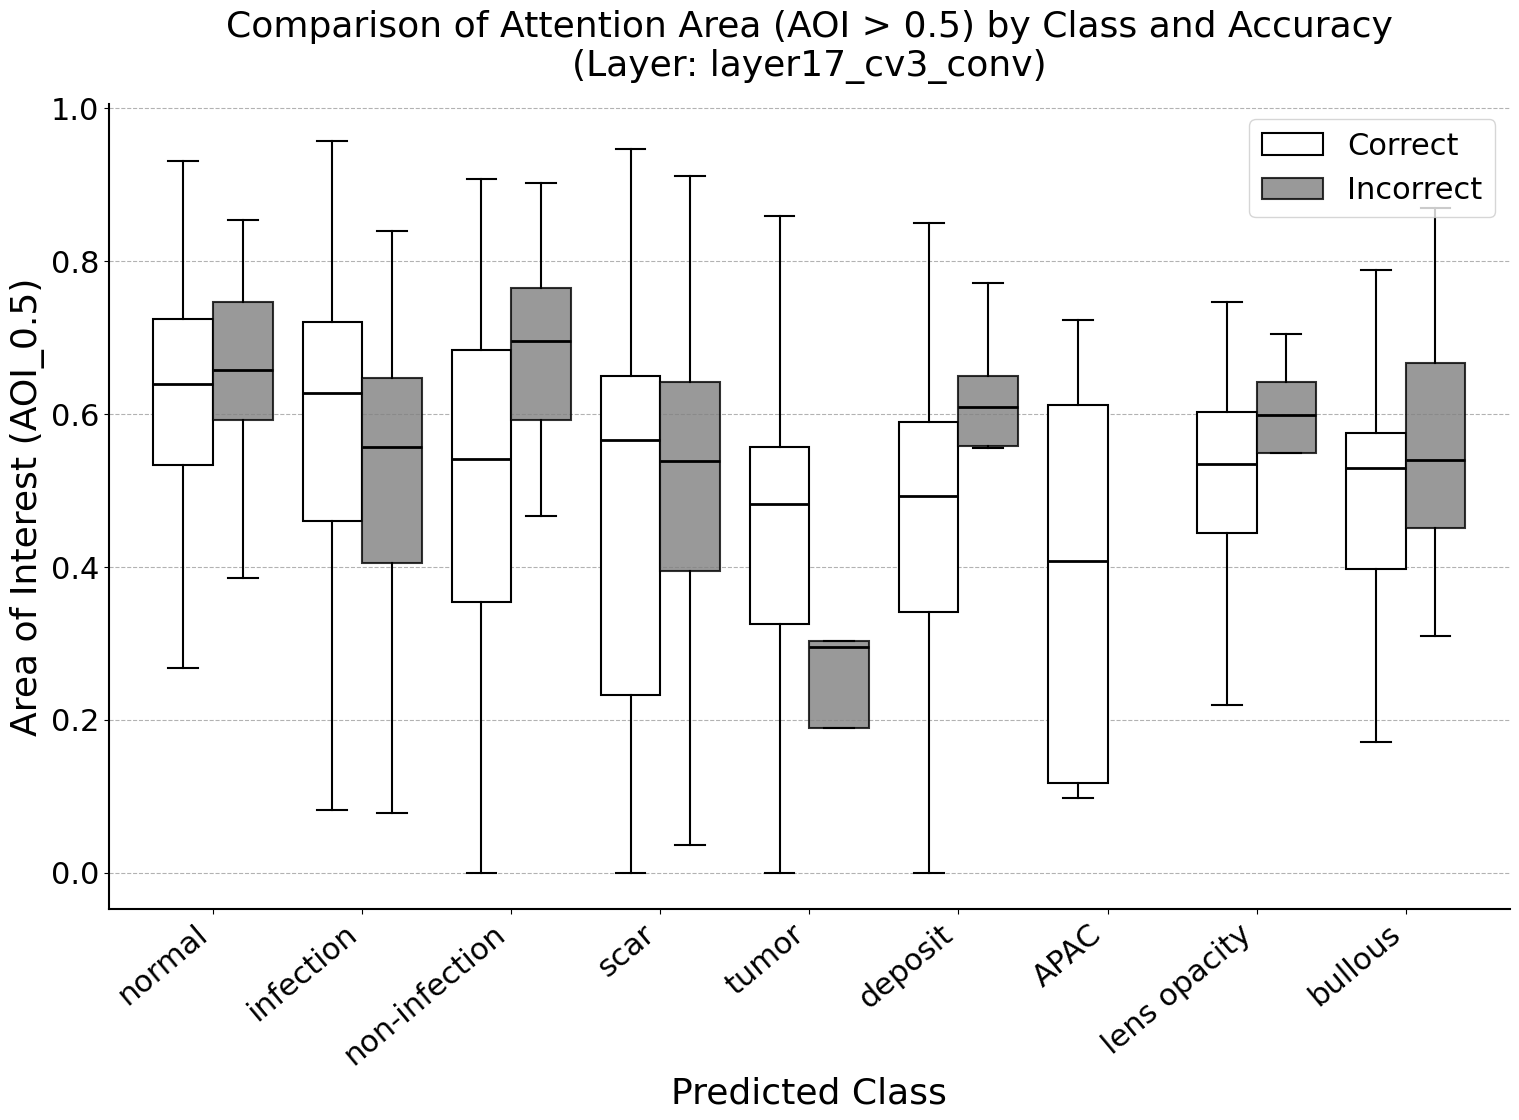


Creating plot for Layer: layer20_cv3_conv
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer20_cv3_conv.png


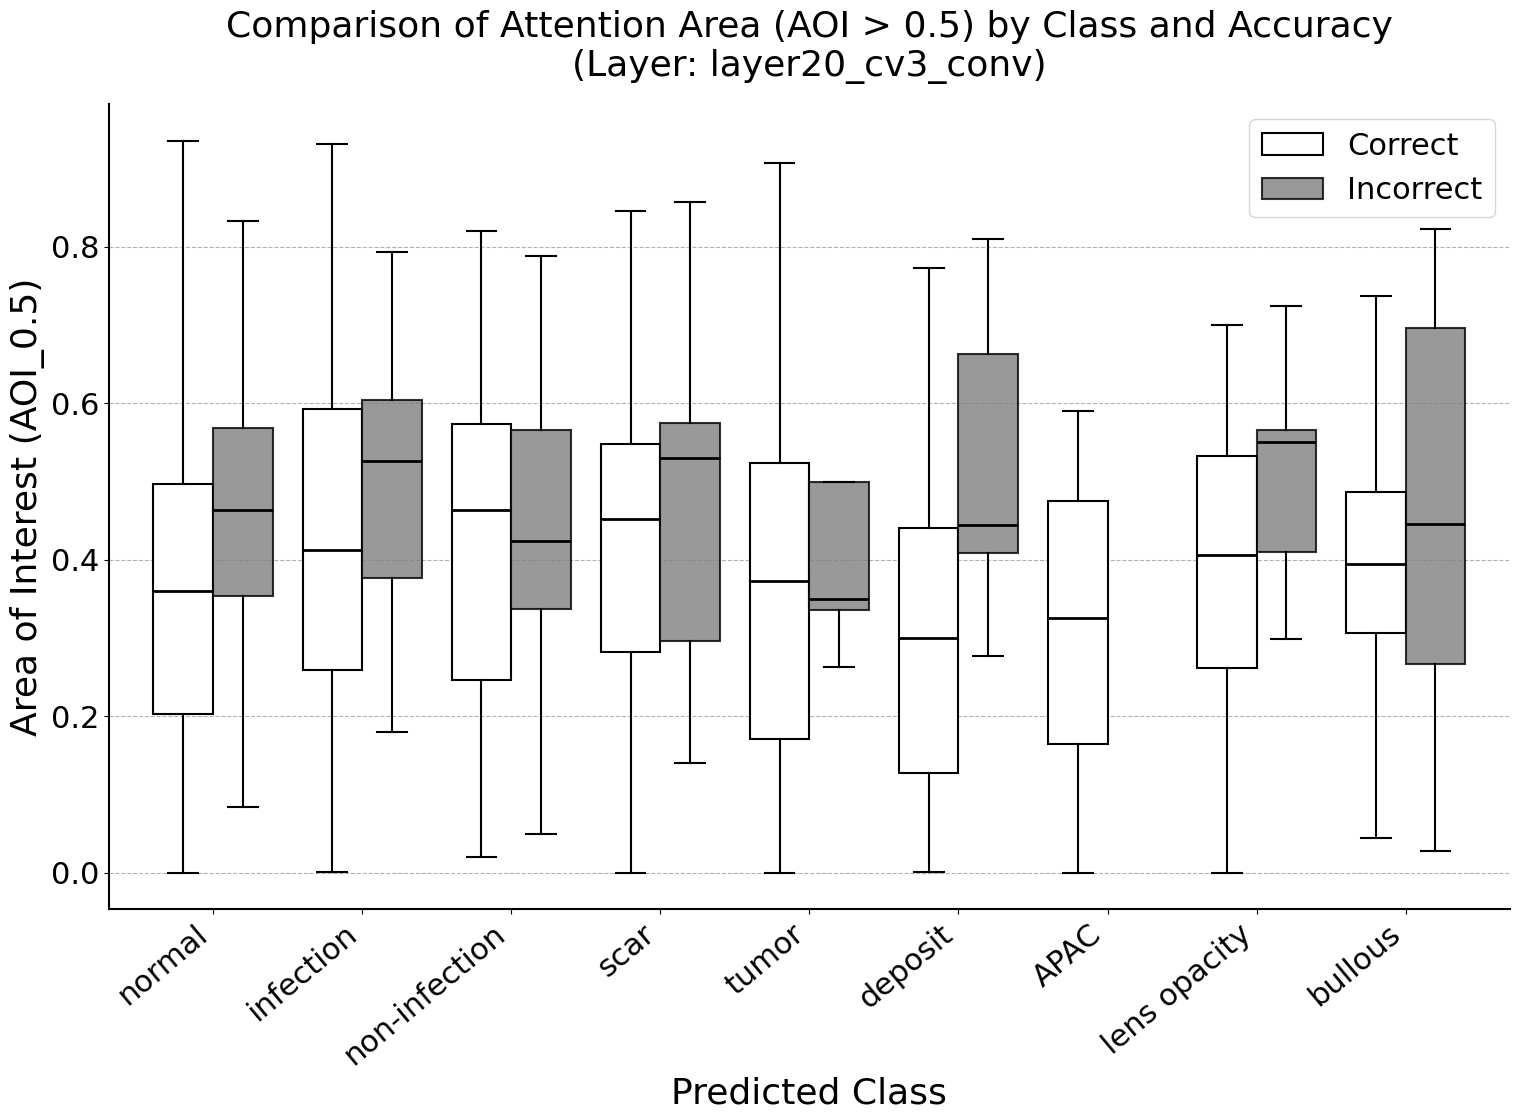


Creating plot for Layer: layer23_cv3_conv
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer23_cv3_conv.png


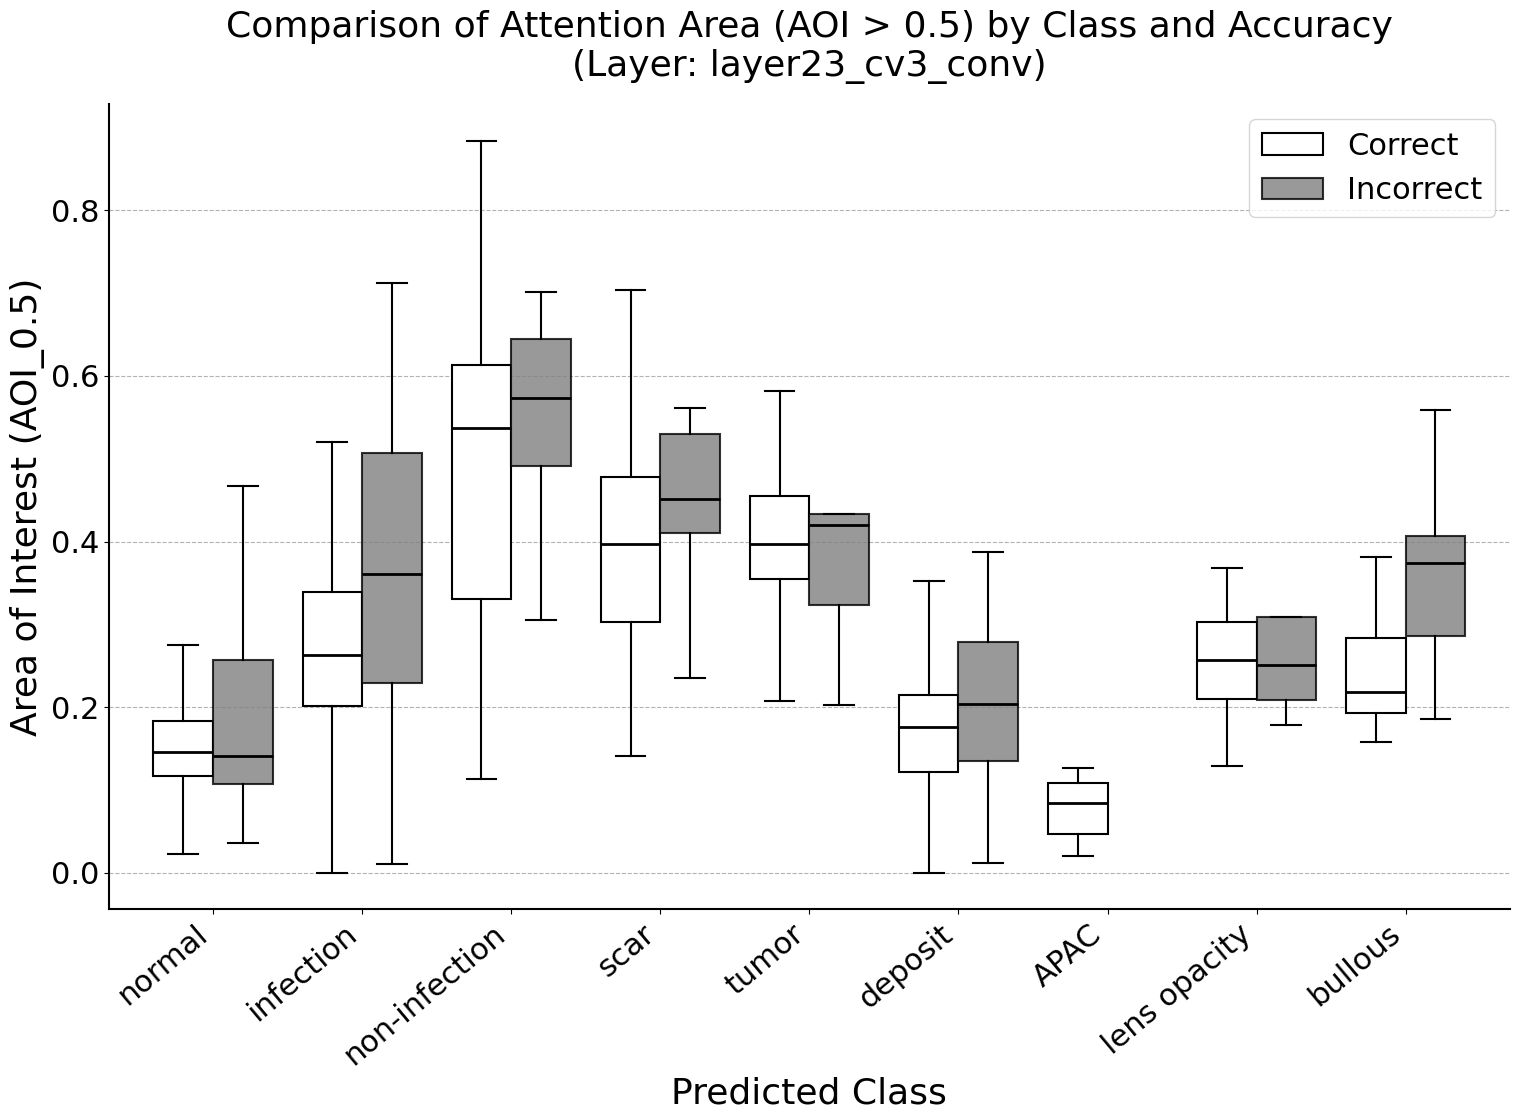


Creating plot for Layer: layer24_m_0
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer24_m_0.png


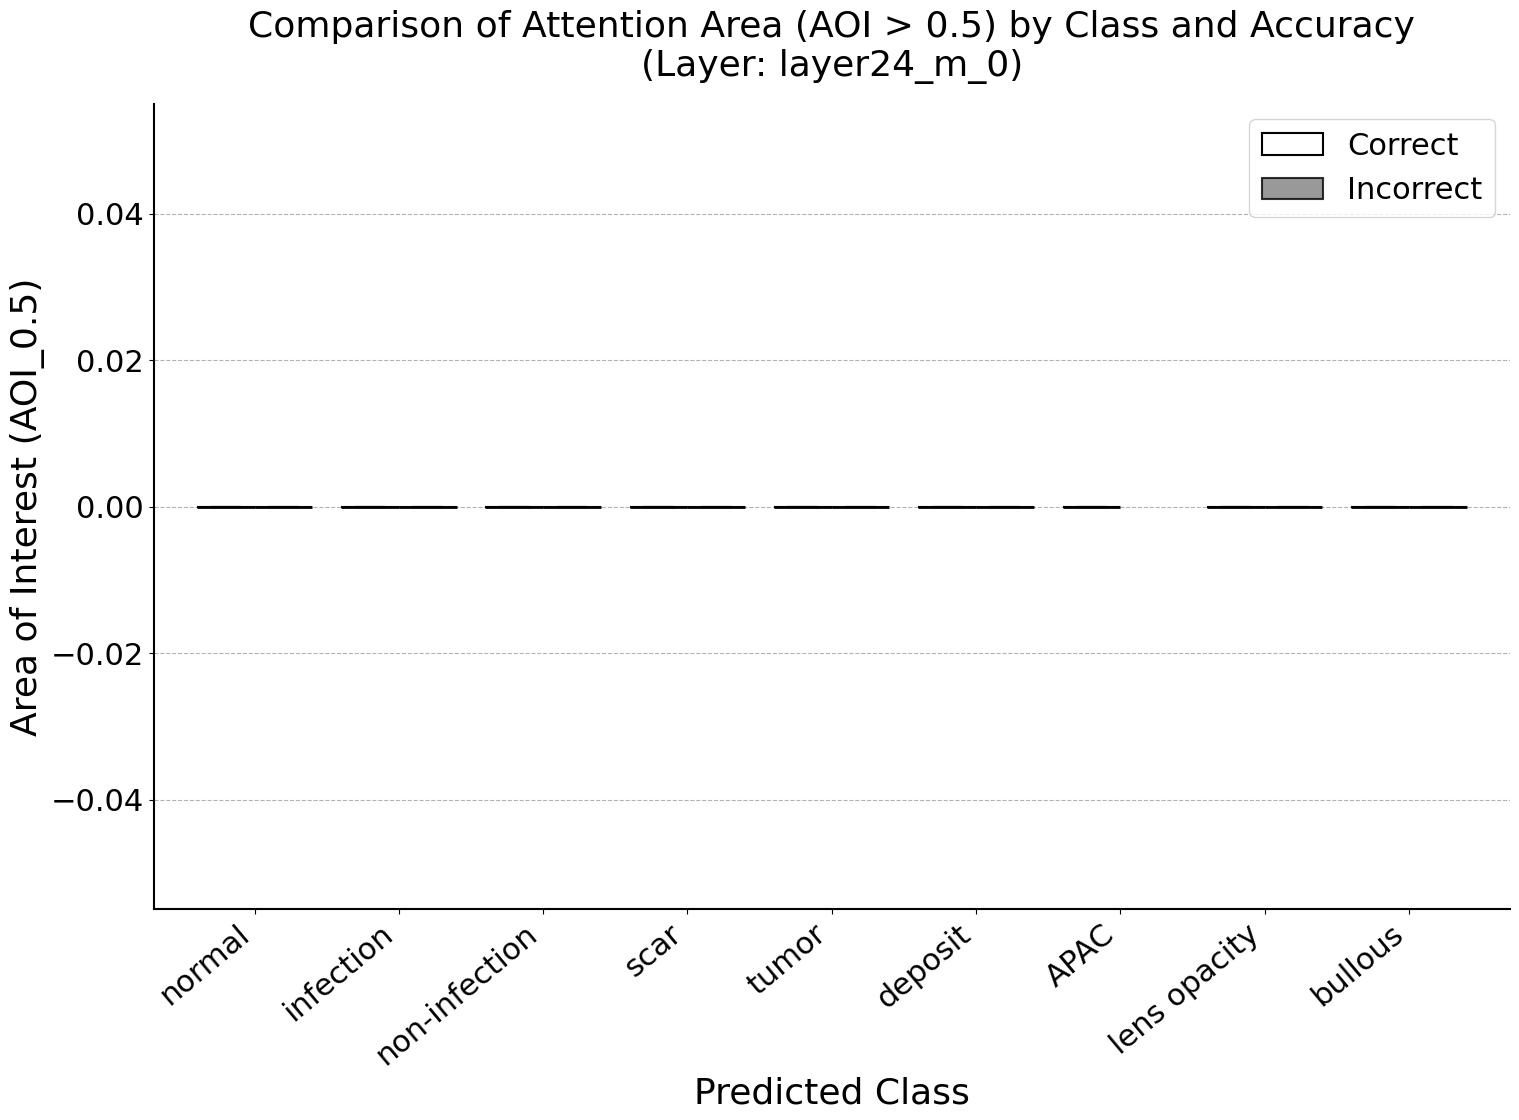


Creating plot for Layer: layer24_m_1
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer24_m_1.png


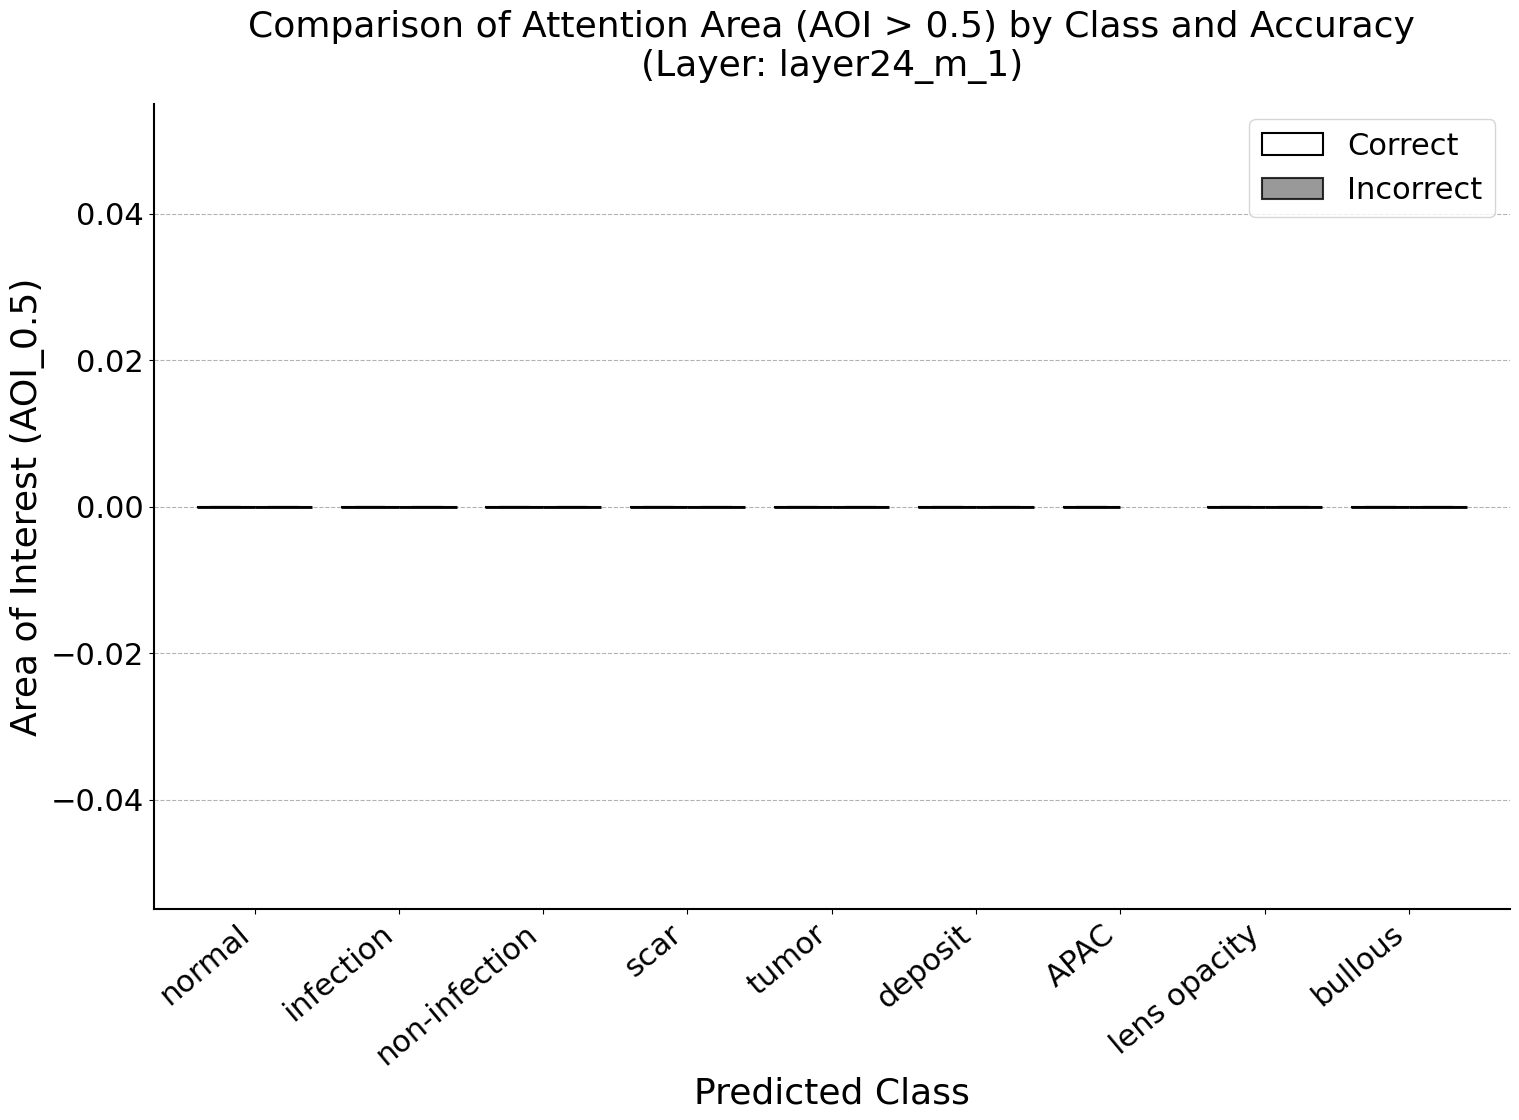


Creating plot for Layer: layer24_m_2
Plot saved: /content/output/AOI_Correct_vs_Incorrect_layer24_m_2.png


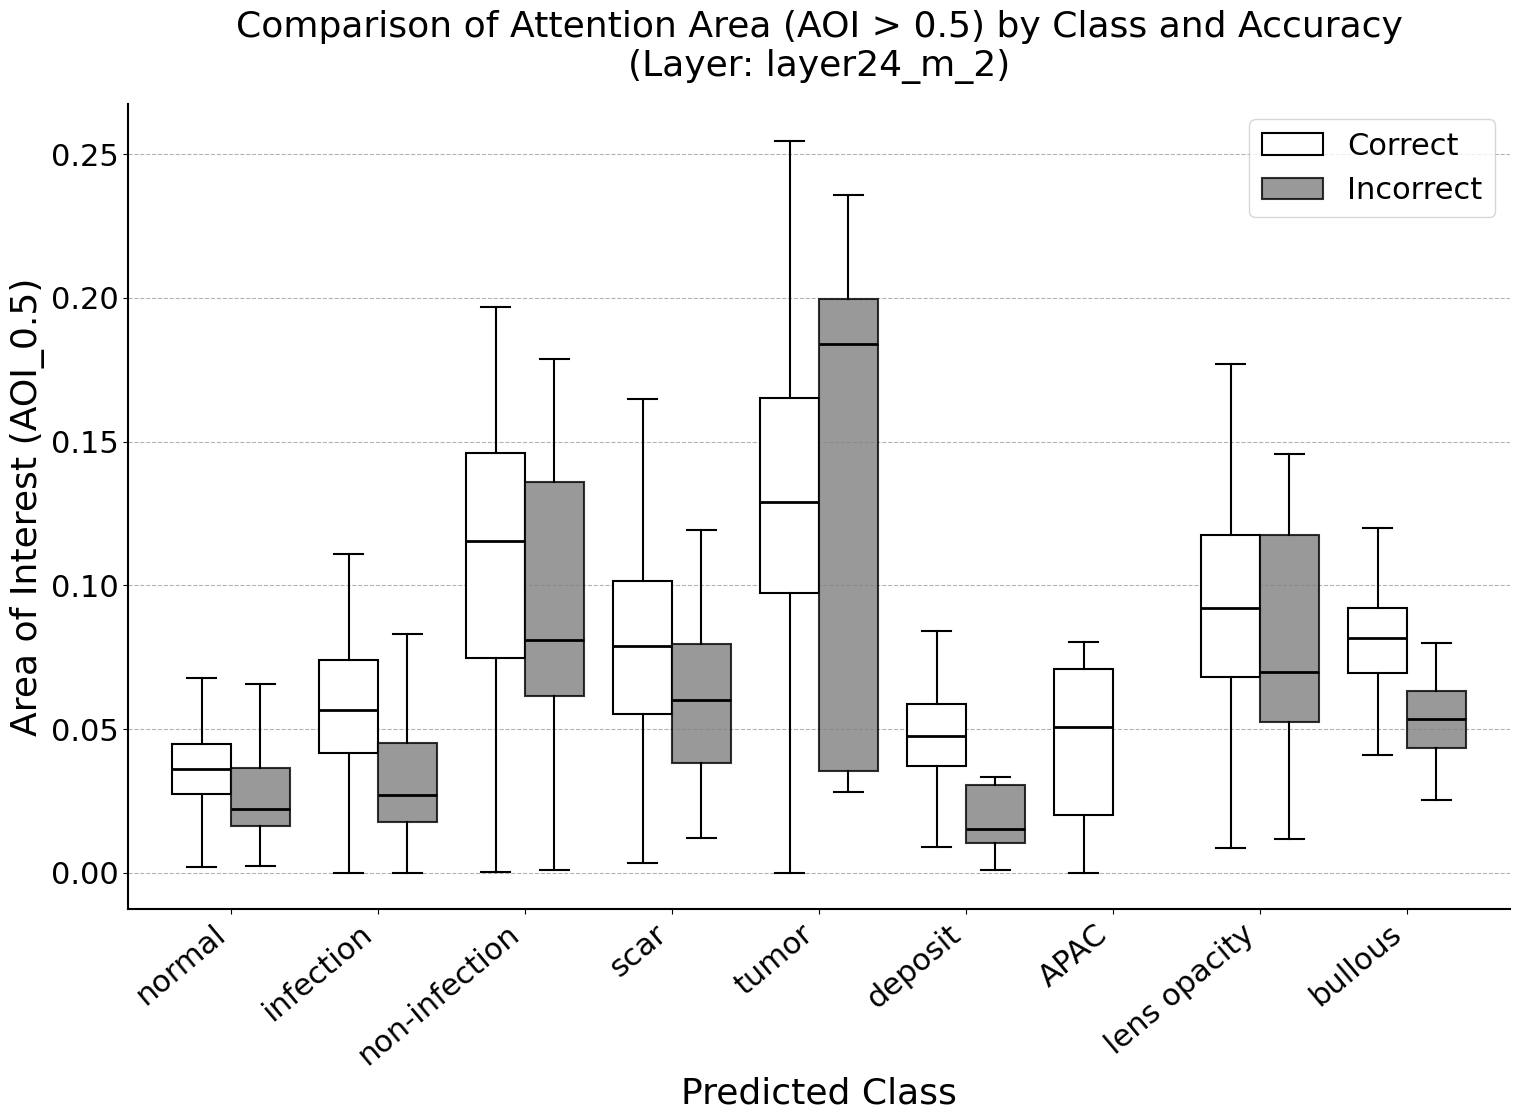


### PART 4: Creating Summary Tables ###


### Significant differences (p < 0.05) ###


Layer Predicted Class  n_correct Correct_Median_IQR  \
2   layer17_cv3_conv   non-infection         44    0.5414 (0.3304)   
5   layer17_cv3_conv         deposit        109    0.4926 (0.2483)   
8   layer20_cv3_conv          normal        244    0.3607 (0.2931)   
13  layer20_cv3_conv         deposit        109    0.2996 (0.3127)   
17  layer23_cv3_conv       infection        107    0.2634 (0.1373)   
19  layer23_cv3_conv            scar        106    0.3966 (0.1747)   
23  layer23_cv3_conv         bullous         53    0.2178 (0.0904)   
40       layer24_m_2          normal        244    0.0362 (0.0172)   
41       layer24_m_2       infection        107    0.0567 (0.0325)   
45       layer24_m_2         deposit        109    0.0477 (0.0214)   
47       layer24_m_2         bullous         53    0.0818 (0.0225)   

    n_incorrect Incorrect_Median_IQR p_value_formatted  
2            16      0.6953 (0.1727)            0.0125  
5            11      0.6090 (0.0914)            0.0241  
8            36      0.4632 (0.2139)            0.0073  
13           11      0.4440 (0.2543)            0.0022  
17           21      0.3611 (0.2782)            0.0296  
19           21      0.4509 (0.1195)            0.0341  
23           19      0.3741 (0.1207)          1.11e-05  
40           36      0.0223 (0.0203)            0.0003  
41           21      0.0270 (0.0275)          1.88e-05  
45           11      0.0152 (0.0200)            0.0003  
47           19      0.0536 (0.0200)            0.0002


Significant results saved to: /content/output/significant_differences_summary_with_IQR.csv

### PART 5: Creating Integrated Summary Table ###

Excel summary saved to: /content/output/statistical_analysis_summary_table.xlsx

All processes finished successfully!


In [97]:
# ============================================
# ‰∫àÊ∏¨„ÇØ„É©„ÇπÂà•„ÉªÊ≠£Ëß£‰∏çÊ≠£Ëß£Âà•„ÅÆÁµ±Ë®àÊ§úÂÆöÔºã„Ç∞„É©„Éï‰ΩúÊàê (ÂÖ®„É¨„Ç§„É§„ÉºÂØæÂøúÁâà„ÉªIQRËøΩÂä†)
# PredictÂà•
# ============================================

# === PART 0: „É©„Ç§„Éñ„É©„É™„Å®Áí∞Â¢ÉË®≠ÂÆö ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import re
from scipy.stats import mannwhitneyu

# ColabÂõ∫Êúâ„ÅÆ„É©„Ç§„Éñ„É©„É™
from google.colab import drive

# --- Google Drive „Éû„Ç¶„É≥„Éà ---
print("Mounting Google Drive...")
try:
    drive.mount('/gdrive', force_remount=True)
    print("Drive mounted successfully to /gdrive.")
except Exception as e:
    print(f"Could not mount Google Drive: {e}")
    raise

# --- „Éë„ÇπË®≠ÂÆö ---
CSV_PATH = Path("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv")

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found in your Google Drive: {CSV_PATH}")

print(f"Reading data directly from: {CSV_PATH}")

# --- Âü∫Êú¨Ë®≠ÂÆö ---
OUT_DIR  = Path("/content/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv', 'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv', 'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1', 'AOI_0.5_layer24_m_2'
]
POSSIBLE_CLASSES = [
    'normal', 'infection', 'non-infection', 'scar', 'tumor',
    'deposit', 'APAC', 'lens opacity', 'bullous'
]

# --- „Éò„É´„Éë„ÉºÈñ¢Êï∞„Å®„Çπ„Çø„Ç§„É´ ---
def to_axis_label(col: str) -> str:
    name = re.sub(r'^AOI_0\.5_', '', col)
    return name.replace('layermodel_', 'layer')

def calculate_iqr(data):
    """IQRÔºàÂõõÂàÜ‰ΩçÁØÑÂõ≤Ôºâ„ÇíË®àÁÆó"""
    if len(data) == 0:
        return np.nan
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

LAYER_AXIS_LABEL = {c: to_axis_label(c) for c in RAW_LAYER_COLS}

# === PART 1: „Éá„Éº„ÇøÊ∫ñÂÇô (‰∫àÊ∏¨„ÇØ„É©„ÇπÂà•) ===
print("\n" + "="*50)
print("### PART 1: Preparing Data (Grouped by PREDICTED Class) ###")
print("="*50 + "\n")

df = pd.read_csv(CSV_PATH)
required_cols = RAW_LAYER_COLS + ['GroundTruth', 'Predict']
if not all(c in df.columns for c in required_cols):
    raise ValueError(f"CSV missing required columns.")

df_layers = df.dropna(subset=RAW_LAYER_COLS, how='all').copy()
df_layers = df_layers[df_layers['Predict'].notna()].copy()

# ÊåáÂÆö„Åï„Çå„ÅüÈ†ÜÁï™„Åß„ÇØ„É©„Çπ„ÇíÈÖçÁΩÆ
SPECIFIED_ORDER = ['normal', 'infection', 'non-infection', 'scar', 'tumor',
                   'deposit', 'APAC', 'lens opacity', 'bullous']
class_order = [c for c in SPECIFIED_ORDER if c in df_layers['Predict'].unique()]
print("Predicted class order for analysis:", class_order)

df_layers['is_correct'] = df_layers['GroundTruth'] == df_layers['Predict']

# === PART 2: ÂÖ®„É¨„Ç§„É§„Éº„Åß„ÅÆÁµ±Ë®àÊ§úÂÆöÔºàIQRËøΩÂä†Ôºâ ===
print("\n" + "="*50)
print("### PART 2: Performing Statistical Analysis for ALL Layers (with IQR) ###")
print("="*50 + "\n")

# ÂÖ®„É¨„Ç§„É§„Éº„ÅÆÁµêÊûú„ÇíÊ†ºÁ¥ç„Åô„Çã„É™„Çπ„Éà
all_results = []

for layer_col in RAW_LAYER_COLS:
    layer_label = LAYER_AXIS_LABEL[layer_col]
    print(f"\n--- Analyzing Layer: {layer_label} ---")

    # ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„ÅÆ„Éá„Éº„Çø„ÇíÊ∫ñÂÇô
    correct_data = [df_layers[(df_layers['Predict'] == cls) & (df_layers['is_correct'])][layer_col].dropna().values for cls in class_order]
    incorrect_data = [df_layers[(df_layers['Predict'] == cls) & (~df_layers['is_correct'])][layer_col].dropna().values for cls in class_order]

    # Áµ±Ë®àÊ§úÂÆö„ÅÆÂÆüË°å
    for i, pred_class in enumerate(class_order):
        c_data = correct_data[i]
        i_data = incorrect_data[i]

        if len(c_data) < 1 or len(i_data) < 1:
            continue

        stat, p_value = mannwhitneyu(c_data, i_data, alternative='two-sided')
        all_results.append({
            'Layer': layer_label,
            'Predicted Class': pred_class,
            'n_correct': len(c_data),
            'median_correct': np.median(c_data),
            'IQR_correct': calculate_iqr(c_data),
            'n_incorrect': len(i_data),
            'median_incorrect': np.median(i_data),
            'IQR_incorrect': calculate_iqr(i_data),
            'p_value': p_value
        })

# ÁµêÊûú„ÇíDataFrame„Å´Â§âÊèõ„Åó„Å¶Ë°®Á§∫
if all_results:
    results_df = pd.DataFrame(all_results)
    results_df['p_value_formatted'] = results_df['p_value'].apply(
        lambda p: f"{p:.4f}" if p >= 0.0001 else f"{p:.2e}"
    )

    # Median (IQR)ÂΩ¢Âºè„ÅßË°®Á§∫Áî®„ÅÆÂàó„Çí‰ΩúÊàê
    results_df['Correct_Median_IQR'] = results_df.apply(
        lambda row: f"{row['median_correct']:.4f} ({row['IQR_correct']:.4f})", axis=1
    )
    results_df['Incorrect_Median_IQR'] = results_df.apply(
        lambda row: f"{row['median_incorrect']:.4f} ({row['IQR_incorrect']:.4f})", axis=1
    )

    # ÁµêÊûú„ÇíCSV„Å®„Åó„Å¶‰øùÂ≠ò
    results_csv_path = OUT_DIR / "all_layers_statistical_results_with_IQR.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nStatistical results saved to: {results_csv_path}")

    # ÂêÑ„É¨„Ç§„É§„Éº„Åî„Å®„ÅÆË©≥Á¥∞Ë°®„ÇíË°®Á§∫
    for layer in RAW_LAYER_COLS:
        layer_label = LAYER_AXIS_LABEL[layer]
        layer_data = results_df[results_df['Layer'] == layer_label]

        if not layer_data.empty:
            print(f"\n### Layer: {layer_label} ###")
            display_df = layer_data[['Predicted Class', 'n_correct', 'Correct_Median_IQR',
                                   'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted']]
            display(display_df)

    # Ë°®Á§∫Áî®„Å´„Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàêÔºàpÂÄ§„ÅÆ„ÅøÔºâ
    pivot_p_values = results_df.pivot(index='Predicted Class', columns='Layer', values='p_value_formatted')
    print("\n### P-values for all layers by Predicted Class ###")
    display(pivot_p_values)

    # ‰∏≠Â§ÆÂÄ§„ÅÆÂ∑Æ„ÇíË°®Á§∫
    results_df['median_diff'] = results_df['median_correct'] - results_df['median_incorrect']
    pivot_median_diff = results_df.pivot(index='Predicted Class', columns='Layer', values='median_diff')
    print("\n### Median differences (Correct - Incorrect) for all layers ###")
    display(pivot_median_diff.round(4))
else:
    print("No classes had sufficient data for comparison.")

# === PART 3: ÂêÑ„É¨„Ç§„É§„Éº„Åî„Å®„ÅÆ„Ç∞„É©„Éï‰ΩúÊàê ===
print("\n" + "="*50)
print("### PART 3: Creating Plots for ALL Layers ###")
print("="*50 + "\n")

# „Ç∞„É©„ÉïË®≠ÂÆö
plt.style.use('default')
mpl.rcParams.update({
    'font.size': 24,
    'axes.titlesize': 26,
    'axes.labelsize': 26,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'axes.linewidth': 1.5,
    'legend.fontsize': 22
})
DPI = 350
COLOR_CORRECT = 'white'
COLOR_INCORRECT = 'grey'

positions = np.arange(len(class_order))
width = 0.4

# ÂêÑ„É¨„Ç§„É§„Éº„Åî„Å®„Å´„Ç∞„É©„Éï„Çí‰ΩúÊàê
for layer_col in RAW_LAYER_COLS:
    layer_label = LAYER_AXIS_LABEL[layer_col]
    print(f"\nCreating plot for Layer: {layer_label}")

    # „Éá„Éº„ÇøÊ∫ñÂÇô
    correct_data = [df_layers[(df_layers['Predict'] == cls) & (df_layers['is_correct'])][layer_col].dropna().values for cls in class_order]
    incorrect_data = [df_layers[(df_layers['Predict'] == cls) & (~df_layers['is_correct'])][layer_col].dropna().values for cls in class_order]

    # „Ç∞„É©„Éï‰ΩúÊàê
    fig, ax = plt.subplots(figsize=(16, 12))

    # Ê≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
    bplot_correct = ax.boxplot(correct_data, positions=positions - width/2, widths=width, patch_artist=True,
                               boxprops=dict(facecolor=COLOR_CORRECT, alpha=1, edgecolor='black', linewidth=1.5),
                               whiskerprops=dict(color='black', linewidth=1.5),
                               capprops=dict(color='black', linewidth=1.5),
                               medianprops=dict(color='black', linewidth=2),
                               showfliers=False)

    # ‰∏çÊ≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
    bplot_incorrect = ax.boxplot(incorrect_data, positions=positions + width/2, widths=width, patch_artist=True,
                                 boxprops=dict(facecolor=COLOR_INCORRECT, alpha=0.8, edgecolor='black', linewidth=1.5),
                                 whiskerprops=dict(color='black', linewidth=1.5),
                                 capprops=dict(color='black', linewidth=1.5),
                                 medianprops=dict(color='black', linewidth=2),
                                 showfliers=False)

    # „Ç∞„É©„Éï„ÅÆË£ÖÈ£æ
    ax.set_title(f'Comparison of Attention Area (AOI > 0.5) by Class and Accuracy\n(Layer: {layer_label})',
                 pad=20)
    ax.set_ylabel('Area of Interest (AOI_0.5)')
    ax.set_xlabel('Predicted Class')
    ax.set_xticks(positions)
    ax.set_xticklabels(class_order, rotation=40, ha='right')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend([bplot_correct["boxes"][0], bplot_incorrect["boxes"][0]], ['Correct', 'Incorrect'], loc='upper right')

    plt.tight_layout(pad=1.5)

    # ‰øùÂ≠ò
    output_filename = OUT_DIR / f"AOI_Correct_vs_Incorrect_{layer_label.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=DPI, bbox_inches='tight')
    print(f"Plot saved: {output_filename}")

    # Ë°®Á§∫
    plt.show()

# === PART 4: „Çµ„Éû„É™„Éº„ÉÜ„Éº„Éñ„É´„ÅÆ‰ΩúÊàê ===
print("\n" + "="*50)
print("### PART 4: Creating Summary Tables ###")
print("="*50 + "\n")

# ÊúâÊÑèÂ∑Æ„Åå„ÅÇ„Çã„ÇØ„É©„Çπ„Å®„É¨„Ç§„É§„Éº„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÇíÊäΩÂá∫Ôºàp < 0.05Ôºâ
if 'results_df' in locals():
    significant_results = results_df[results_df['p_value'] < 0.05].copy()

    if not significant_results.empty:
        print("\n### Significant differences (p < 0.05) ###")
        # ÊúâÊÑèÂ∑Æ„ÅÆ„ÅÇ„ÇãÁµêÊûú„ÇíË¶ã„ÇÑ„Åô„ÅèË°®Á§∫
        sig_display = significant_results[['Layer', 'Predicted Class', 'n_correct', 'Correct_Median_IQR',
                                         'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted']]
        display(sig_display)

        # ÊúâÊÑèÂ∑Æ„ÅÆ„ÅÇ„Çã„Ç±„Éº„Çπ„Çí‰øùÂ≠ò
        significant_csv_path = OUT_DIR / "significant_differences_summary_with_IQR.csv"
        significant_results.to_csv(significant_csv_path, index=False)
        print(f"\nSignificant results saved to: {significant_csv_path}")
    else:
        print("\nNo significant differences found (p < 0.05)")

# === PART 5: Áµ±Âêà„Çµ„Éû„É™„Éº„ÉÜ„Éº„Éñ„É´„ÅÆ‰ΩúÊàê ===
print("\n" + "="*50)
print("### PART 5: Creating Integrated Summary Table ###")
print("="*50 + "\n")

# ÂÖ®„É¨„Ç§„É§„Éº„ÅÆÁµêÊûú„Çí1„Å§„ÅÆË°®„Å´„Åæ„Å®„ÇÅ„ÇãÔºàË´ñÊñáÁî®Ôºâ
if 'results_df' in locals():
    # „ÇØ„É©„Çπ„Å®„É¨„Ç§„É§„Éº„Åß„ÇΩ„Éº„Éà
    summary_df = results_df.sort_values(['Predicted Class', 'Layer'])

    # Ë´ñÊñáÁî®„ÅÆ„Éï„Ç©„Éº„Éû„ÉÉ„Éà„ÅßË°®„Çí‰ΩúÊàê
    paper_table = summary_df[['Predicted Class', 'Layer', 'n_correct', 'Correct_Median_IQR',
                             'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted']].copy()

    # Ë°®„ÇíExcel„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠òÔºà„Çà„ÇäË¶ã„ÇÑ„Åô„ÅÑÂΩ¢Âºè„ÅßÔºâ
    excel_path = OUT_DIR / "statistical_analysis_summary_table.xlsx"
    with pd.ExcelWriter(excel_path) as writer:
        # ÂÖ®‰Ωì„ÅÆ„Çµ„Éû„É™„Éº
        paper_table.to_excel(writer, sheet_name='All_Results', index=False)

        # pÂÄ§„ÅÆ„Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´
        pivot_p_values.to_excel(writer, sheet_name='P_Values_Matrix')

        # ‰∏≠Â§ÆÂÄ§„ÅÆÂ∑Æ„ÅÆ„Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´
        pivot_median_diff.to_excel(writer, sheet_name='Median_Differences')

        # ÊúâÊÑèÂ∑Æ„ÅÆ„ÅÇ„ÇãÁµêÊûú„ÅÆ„Åø
        if not significant_results.empty:
            sig_display.to_excel(writer, sheet_name='Significant_Only', index=False)

    print(f"Excel summary saved to: {excel_path}")

print("\n" + "="*50)
print("All processes finished successfully!")
print("="*50)

In [ ]:
# ============================================
# ‰∫àÊ∏¨„ÇØ„É©„ÇπÂà•„ÉªÊ≠£Ëß£‰∏çÊ≠£Ëß£Âà•„ÅÆÁµ±Ë®àÊ§úÂÆöÔºã„Ç∞„É©„Éï‰ΩúÊàê (Ë´ñÊñáÁî®ÊîπËâØÁâà)
# IQR„ÄÅÂäπÊûúÈáè„ÄÅÁµ±Ë®àÁöÑÂ¶•ÂΩìÊÄßË©ï‰æ°„ÄÅAPACÂê´„ÇÄÂÖ®„ÇØ„É©„ÇπË°®Á§∫
# ============================================

# === PART 0: „É©„Ç§„Éñ„É©„É™„Å®Áí∞Â¢ÉË®≠ÂÆö ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import re
from scipy.stats import mannwhitneyu
import warnings

# ColabÂõ∫Êúâ„ÅÆ„É©„Ç§„Éñ„É©„É™
from google.colab import drive

# --- Google Drive „Éû„Ç¶„É≥„Éà ---
print("Mounting Google Drive...")
try:
    drive.mount('/gdrive', force_remount=True)
    print("Drive mounted successfully to /gdrive.")
except Exception as e:
    print(f"Could not mount Google Drive: {e}")
    raise

# --- „Éë„ÇπË®≠ÂÆö ---
CSV_PATH = Path("/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv")

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found in your Google Drive: {CSV_PATH}")

print(f"Reading data directly from: {CSV_PATH}")

# --- Âü∫Êú¨Ë®≠ÂÆö ---
OUT_DIR  = Path("/content/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv', 'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv', 'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1', 'AOI_0.5_layer24_m_2'
]

# ÂÖ®„Å¶„ÅÆ„ÇØ„É©„ÇπÔºàAPAC„ÇíÂê´„ÇÄ„ÄÅ„Éá„Éº„Çø„Åå„Å™„Åè„Å¶„ÇÇË°®Á§∫Ôºâ
ALL_CLASSES = [
    'normal', 'infection', 'non-infection', 'scar', 'tumor',
    'deposit', 'APAC', 'lens opacity', 'bullous'
]

# --- „Éò„É´„Éë„ÉºÈñ¢Êï∞„Å®„Çπ„Çø„Ç§„É´ ---
def to_axis_label(col: str) -> str:
    name = re.sub(r'^AOI_0\.5_', '', col)
    return name.replace('layermodel_', 'layer')

def calculate_iqr(data):
    """IQRÔºàÂõõÂàÜ‰ΩçÁØÑÂõ≤Ôºâ„ÇíË®àÁÆó"""
    if len(data) == 0:
        return np.nan
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

def calculate_effect_size(u_statistic, n1, n2):
    """Mann-Whitney U test„ÅÆÂäπÊûúÈáè (r = Z/‚àöN) „ÇíË®àÁÆó"""
    if n1 == 0 or n2 == 0:
        return np.nan

    # UÁµ±Ë®àÈáè„ÇíZÁµ±Ë®àÈáè„Å´Â§âÊèõ
    expected_u = n1 * n2 / 2
    std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    if std_u == 0:
        return np.nan

    z = abs(u_statistic - expected_u) / std_u
    effect_size = z / np.sqrt(n1 + n2)
    return effect_size

def assess_statistical_validity(n1, n2):
    """Áµ±Ë®àÊ§úÂÆö„ÅÆÂ¶•ÂΩìÊÄß„ÇíË©ï‰æ°"""
    total_n = n1 + n2

    if n1 < 3 or n2 < 3:
        return "Insufficient (n<3 in at least one group)"
    elif n1 < 5 or n2 < 5:
        return "Limited (n<5 in at least one group)"
    elif total_n < 20:
        return "Adequate (but limited total sample)"
    else:
        return "Good"

def interpret_effect_size(r):
    """ÂäπÊûúÈáè„ÅÆËß£Èáà"""
    if np.isnan(r):
        return "N/A"
    elif r < 0.1:
        return "Negligible"
    elif r < 0.3:
        return "Small"
    elif r < 0.5:
        return "Medium"
    else:
        return "Large"

LAYER_AXIS_LABEL = {c: to_axis_label(c) for c in RAW_LAYER_COLS}

# === PART 1: „Éá„Éº„ÇøÊ∫ñÂÇô (‰∫àÊ∏¨„ÇØ„É©„ÇπÂà•) ===
print("\n" + "="*50)
print("### PART 1: Preparing Data (Grouped by PREDICTED Class) ###")
print("="*50 + "\n")

df = pd.read_csv(CSV_PATH)
required_cols = RAW_LAYER_COLS + ['GroundTruth', 'Predict']
if not all(c in df.columns for c in required_cols):
    raise ValueError(f"CSV missing required columns.")

df_layers = df.dropna(subset=RAW_LAYER_COLS, how='all').copy()
df_layers = df_layers[df_layers['Predict'].notna()].copy()

# ÂÖ®„ÇØ„É©„Çπ„Çí‰ΩøÁî®Ôºà„Éá„Éº„Çø„Åå„Å™„ÅÑ„ÇØ„É©„Çπ„ÇÇÂê´„ÇÄÔºâ
class_order = ALL_CLASSES
print("Analysis will include ALL classes (including APAC):", class_order)

# „Éá„Éº„Çø‰∏≠„Å´ÂÆüÈöõ„Å´Â≠òÂú®„Åô„Çã„ÇØ„É©„Çπ
actual_classes = set(df_layers['Predict'].unique())
print("Classes found in data:", sorted(actual_classes))

df_layers['is_correct'] = df_layers['GroundTruth'] == df_layers['Predict']

# ÂêÑ„ÇØ„É©„Çπ„ÅÆ„Çµ„É≥„Éó„É´Êï∞„ÇíÁ¢∫Ë™ç
print("\n--- Sample size summary by predicted class ---")
for cls in class_order:
    if cls in actual_classes:
        total = len(df_layers[df_layers['Predict'] == cls])
        correct = len(df_layers[(df_layers['Predict'] == cls) & (df_layers['is_correct'])])
        incorrect = total - correct
    else:
        total = correct = incorrect = 0
    print(f"{cls}: Total={total}, Correct={correct}, Incorrect={incorrect}")

# === PART 2: ÂÖ®„É¨„Ç§„É§„Éº„Åß„ÅÆÁµ±Ë®àÊ§úÂÆöÔºàIQR„ÉªÂäπÊûúÈáè„ÉªÂ¶•ÂΩìÊÄßË©ï‰æ°ËøΩÂä†Ôºâ ===
print("\n" + "="*50)
print("### PART 2: Enhanced Statistical Analysis for ALL Layers ###")
print("="*50 + "\n")

# ÂÖ®„É¨„Ç§„É§„Éº„ÅÆÁµêÊûú„ÇíÊ†ºÁ¥ç„Åô„Çã„É™„Çπ„Éà
all_results = []

for layer_col in RAW_LAYER_COLS:
    layer_label = LAYER_AXIS_LABEL[layer_col]
    print(f"\n--- Analyzing Layer: {layer_label} ---")

    # ÂêÑ„ÇØ„É©„Çπ„Åî„Å®„ÅÆ„Éá„Éº„Çø„ÇíÊ∫ñÂÇôÔºàÂÖ®„ÇØ„É©„ÇπÂØæË±°Ôºâ
    for pred_class in class_order:
        if pred_class in actual_classes:
            c_data = df_layers[(df_layers['Predict'] == pred_class) & (df_layers['is_correct'])][layer_col].dropna().values
            i_data = df_layers[(df_layers['Predict'] == pred_class) & (~df_layers['is_correct'])][layer_col].dropna().values
        else:
            c_data = np.array([])
            i_data = np.array([])

        n_correct = len(c_data)
        n_incorrect = len(i_data)

        # Âü∫Êú¨Áµ±Ë®àÈáè„ÇíË®àÁÆóÔºà„Éá„Éº„Çø„Åå0„Åß„ÇÇÔºâ
        median_correct = np.median(c_data) if n_correct > 0 else np.nan
        iqr_correct = calculate_iqr(c_data) if n_correct > 0 else np.nan
        median_incorrect = np.median(i_data) if n_incorrect > 0 else np.nan
        iqr_incorrect = calculate_iqr(i_data) if n_incorrect > 0 else np.nan

        # Áµ±Ë®àÊ§úÂÆö„Å®ÂäπÊûúÈáè„ÅÆË®àÁÆó
        if n_correct >= 1 and n_incorrect >= 1:
            try:
                stat, p_value = mannwhitneyu(c_data, i_data, alternative='two-sided')
                effect_size = calculate_effect_size(stat, n_correct, n_incorrect)
                effect_interpretation = interpret_effect_size(effect_size)
                statistical_validity = assess_statistical_validity(n_correct, n_incorrect)
            except Exception as e:
                print(f"Statistical test failed for {pred_class}: {e}")
                stat, p_value, effect_size, effect_interpretation, statistical_validity = np.nan, np.nan, np.nan, "N/A", "Failed"
        else:
            stat, p_value, effect_size, effect_interpretation = np.nan, np.nan, np.nan, "N/A"
            if n_correct == 0 and n_incorrect == 0:
                statistical_validity = "No data"
            else:
                statistical_validity = "Insufficient data"

        all_results.append({
            'Layer': layer_label,
            'Predicted Class': pred_class,
            'n_correct': n_correct,
            'median_correct': median_correct,
            'IQR_correct': iqr_correct,
            'n_incorrect': n_incorrect,
            'median_incorrect': median_incorrect,
            'IQR_incorrect': iqr_incorrect,
            'u_statistic': stat,
            'p_value': p_value,
            'effect_size': effect_size,
            'effect_interpretation': effect_interpretation,
            'statistical_validity': statistical_validity
        })

# ÁµêÊûú„ÇíDataFrame„Å´Â§âÊèõ„Åó„Å¶Ë°®Á§∫
results_df = pd.DataFrame(all_results)

# „Éï„Ç©„Éº„Éû„ÉÉ„ÉàÁî®„ÅÆÂàó„ÇíËøΩÂä†
results_df['p_value_formatted'] = results_df['p_value'].apply(
    lambda p: f"{p:.4f}" if pd.notna(p) and p >= 0.0001 else f"{p:.2e}" if pd.notna(p) else "N/A"
)

results_df['effect_size_formatted'] = results_df['effect_size'].apply(
    lambda e: f"{e:.3f}" if pd.notna(e) else "N/A"
)

# Median (IQR)ÂΩ¢Âºè„ÅßË°®Á§∫Áî®„ÅÆÂàó„Çí‰ΩúÊàê
results_df['Correct_Median_IQR'] = results_df.apply(
    lambda row: f"{row['median_correct']:.4f} ({row['IQR_correct']:.4f})" if pd.notna(row['median_correct']) and pd.notna(row['IQR_correct']) else "N/A", axis=1
)
results_df['Incorrect_Median_IQR'] = results_df.apply(
    lambda row: f"{row['median_incorrect']:.4f} ({row['IQR_incorrect']:.4f})" if pd.notna(row['median_incorrect']) and pd.notna(row['IQR_incorrect']) else "N/A", axis=1
)

# ‰∏≠Â§ÆÂÄ§„ÅÆÂ∑Æ„ÇíË®àÁÆó
results_df['median_diff'] = results_df['median_correct'] - results_df['median_incorrect']

# ÁµêÊûú„ÇíCSV„Å®„Åó„Å¶‰øùÂ≠ò
results_csv_path = OUT_DIR / "all_layers_statistical_results_enhanced.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"\nEnhanced statistical results saved to: {results_csv_path}")

# === PART 3: Ë©≥Á¥∞ÁµêÊûú„ÅÆË°®Á§∫ ===
print("\n" + "="*50)
print("### PART 3: Detailed Results Display (All Classes Including APAC) ###")
print("="*50 + "\n")

# ÂêÑ„É¨„Ç§„É§„Éº„Åî„Å®„ÅÆË©≥Á¥∞Ë°®„ÇíË°®Á§∫
for layer in RAW_LAYER_COLS:
    layer_label = LAYER_AXIS_LABEL[layer]
    layer_data = results_df[results_df['Layer'] == layer_label]

    print(f"\n### Layer: {layer_label} ###")
    display_df = layer_data[['Predicted Class', 'n_correct', 'Correct_Median_IQR',
                           'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted',
                           'effect_size_formatted', 'effect_interpretation', 'statistical_validity']]
    display(display_df)

# Ë°®Á§∫Áî®„Å´„Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê
pivot_p_values = results_df.pivot(index='Predicted Class', columns='Layer', values='p_value_formatted')
print("\n### P-values for all layers by Predicted Class ###")
display(pivot_p_values)

pivot_effect_sizes = results_df.pivot(index='Predicted Class', columns='Layer', values='effect_size_formatted')
print("\n### Effect sizes for all layers by Predicted Class ###")
display(pivot_effect_sizes)

pivot_median_diff = results_df.pivot(index='Predicted Class', columns='Layer', values='median_diff')
print("\n### Median differences (Correct - Incorrect) for all layers ###")
display(pivot_median_diff.round(4))

# === PART 4: Áµ±Ë®àÁöÑ„Å´ÊúâÊÑè„ÅßÂ¶•ÂΩì„Å™ÁµêÊûú„ÅÆÊäΩÂá∫ ===
print("\n" + "="*50)
print("### PART 4: Significant and Statistically Valid Results ###")
print("="*50 + "\n")

# ÊúâÊÑèÂ∑Æ„Åå„ÅÇ„Çä„ÄÅÁµ±Ë®àÁöÑ„Å´Â¶•ÂΩìÊÄß„Åå„ÅÇ„ÇãÁµêÊûú„ÇíÊäΩÂá∫
valid_significant = results_df[
    (results_df['p_value'] < 0.05) &
    (results_df['statistical_validity'].isin(['Good', 'Adequate (but limited total sample)']))
].copy()

limited_significant = results_df[
    (results_df['p_value'] < 0.05) &
    (results_df['statistical_validity'] == 'Limited (n<5 in at least one group)')
].copy()

if not valid_significant.empty:
    print("### Significant differences with adequate statistical validity ###")
    valid_display = valid_significant[['Layer', 'Predicted Class', 'n_correct', 'Correct_Median_IQR',
                                     'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted',
                                     'effect_size_formatted', 'effect_interpretation', 'statistical_validity']]
    display(valid_display)

    # ÊúâÂäπ„Å™ÊúâÊÑèÂ∑ÆÁµêÊûú„Çí‰øùÂ≠ò
    valid_csv_path = OUT_DIR / "statistically_valid_significant_results.csv"
    valid_significant.to_csv(valid_csv_path, index=False)
    print(f"\nValid significant results saved to: {valid_csv_path}")
else:
    print("No significant differences with adequate statistical validity found.")

if not limited_significant.empty:
    print("\n### Significant differences with limited statistical validity (interpret with caution) ###")
    limited_display = limited_significant[['Layer', 'Predicted Class', 'n_correct', 'Correct_Median_IQR',
                                         'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted',
                                         'effect_size_formatted', 'effect_interpretation', 'statistical_validity']]
    display(limited_display)

# === PART 5: „Ç∞„É©„Éï‰ΩúÊàêÔºà„Éá„Éº„Çø„Åå„ÅÇ„Çã„ÇØ„É©„Çπ„ÅÆ„ÅøÔºâ ===
print("\n" + "="*50)
print("### PART 5: Creating Plots for ALL Layers ###")
print("="*50 + "\n")

# „Ç∞„É©„ÉïË®≠ÂÆö
plt.style.use('default')
mpl.rcParams.update({
    'font.size': 24,
    'axes.titlesize': 26,
    'axes.labelsize': 26,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'axes.linewidth': 1.5,
    'legend.fontsize': 22
})
DPI = 350
COLOR_CORRECT = 'white'
COLOR_INCORRECT = 'grey'

# „Ç∞„É©„ÉïÁî®„ÅÆ„ÇØ„É©„ÇπÈ†ÜÂ∫èÔºà„Éá„Éº„Çø„Åå„ÅÇ„Çã„ÇÇ„ÅÆ„ÅÆ„ÅøÔºâ
graph_class_order = [cls for cls in class_order if cls in actual_classes]
positions = np.arange(len(graph_class_order))
width = 0.4

# ÂêÑ„É¨„Ç§„É§„Éº„Åî„Å®„Å´„Ç∞„É©„Éï„Çí‰ΩúÊàê
for layer_col in RAW_LAYER_COLS:
    layer_label = LAYER_AXIS_LABEL[layer_col]
    print(f"\nCreating plot for Layer: {layer_label}")

    # „Éá„Éº„ÇøÊ∫ñÂÇôÔºà„Éá„Éº„Çø„Åå„ÅÇ„Çã„ÇØ„É©„Çπ„ÅÆ„ÅøÔºâ
    correct_data = []
    incorrect_data = []

    for cls in graph_class_order:
        c_data = df_layers[(df_layers['Predict'] == cls) & (df_layers['is_correct'])][layer_col].dropna().values
        i_data = df_layers[(df_layers['Predict'] == cls) & (~df_layers['is_correct'])][layer_col].dropna().values
        correct_data.append(c_data)
        incorrect_data.append(i_data)

    # „Ç∞„É©„Éï‰ΩúÊàê
    fig, ax = plt.subplots(figsize=(16, 12))

    # Ê≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
    bplot_correct = ax.boxplot(correct_data, positions=positions - width/2, widths=width, patch_artist=True,
                               boxprops=dict(facecolor=COLOR_CORRECT, alpha=1, edgecolor='black', linewidth=1.5),
                               whiskerprops=dict(color='black', linewidth=1.5),
                               capprops=dict(color='black', linewidth=1.5),
                               medianprops=dict(color='black', linewidth=2),
                               showfliers=False)

    # ‰∏çÊ≠£Ëß£Áæ§„ÅÆÁÆ±„Å≤„ÅíÂõ≥
    bplot_incorrect = ax.boxplot(incorrect_data, positions=positions + width/2, widths=width, patch_artist=True,
                                 boxprops=dict(facecolor=COLOR_INCORRECT, alpha=0.8, edgecolor='black', linewidth=1.5),
                                 whiskerprops=dict(color='black', linewidth=1.5),
                                 capprops=dict(color='black', linewidth=1.5),
                                 medianprops=dict(color='black', linewidth=2),
                                 showfliers=False)

    # „Ç∞„É©„Éï„ÅÆË£ÖÈ£æ
    ax.set_title(f'Comparison of Attention Area (AOI > 0.5) by Class and Accuracy\n(Layer: {layer_label})',
                 pad=20)
    ax.set_ylabel('Area of Interest (AOI_0.5)')
    ax.set_xlabel('Predicted Class')
    ax.set_xticks(positions)
    ax.set_xticklabels(graph_class_order, rotation=40, ha='right')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend([bplot_correct["boxes"][0], bplot_incorrect["boxes"][0]], ['Correct', 'Incorrect'], loc='upper right')

    plt.tight_layout(pad=1.5)

    # ‰øùÂ≠ò
    output_filename = OUT_DIR / f"AOI_Correct_vs_Incorrect_{layer_label.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=DPI, bbox_inches='tight')
    print(f"Plot saved: {output_filename}")

    # Ë°®Á§∫
    plt.show()

# === PART 6: Ë´ñÊñáÁî®„Çµ„Éû„É™„Éº„ÉÜ„Éº„Éñ„É´„ÅÆ‰ΩúÊàê ===
print("\n" + "="*50)
print("### PART 6: Creating Paper-ready Summary Tables ###")
print("="*50 + "\n")

# Ë´ñÊñáÁî®„ÅÆ„Éï„Ç©„Éº„Éû„ÉÉ„Éà„ÅßË°®„Çí‰ΩúÊàê
paper_table = results_df[['Predicted Class', 'Layer', 'n_correct', 'Correct_Median_IQR',
                         'n_incorrect', 'Incorrect_Median_IQR', 'p_value_formatted',
                         'effect_size_formatted', 'effect_interpretation', 'statistical_validity']].copy()

# Ë°®„ÇíExcel„Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠òÔºà„Çà„ÇäË¶ã„ÇÑ„Åô„ÅÑÂΩ¢Âºè„ÅßÔºâ
excel_path = OUT_DIR / "comprehensive_statistical_analysis_with_APAC.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    # ÂÖ®‰Ωì„ÅÆ„Çµ„Éû„É™„Éº
    paper_table.to_excel(writer, sheet_name='All_Results', index=False)

    # „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´
    pivot_p_values.to_excel(writer, sheet_name='P_Values_Matrix')
    pivot_effect_sizes.to_excel(writer, sheet_name='Effect_Sizes_Matrix')
    pivot_median_diff.to_excel(writer, sheet_name='Median_Differences')

    # ÊúâÊÑè„ÅßÂ¶•ÂΩì„Å™ÁµêÊûú„ÅÆ„Åø
    if not valid_significant.empty:
        valid_display.to_excel(writer, sheet_name='Valid_Significant', index=False)

    # ÊúâÊÑè„Å†„ÅåÂ¶•ÂΩìÊÄß„Å´Âà∂Èôê„Åå„ÅÇ„ÇãÁµêÊûú
    if not limited_significant.empty:
        limited_display.to_excel(writer, sheet_name='Limited_Significant', index=False)

print(f"Comprehensive Excel summary saved to: {excel_path}")

# === PART 7: Áµ±Ë®àÁöÑÂ¶•ÂΩìÊÄß„Å®„Éá„Éº„ÇøÂÖÖË∂≥Â∫¶„ÅÆ„Çµ„Éû„É™„Éº ===
print("\n" + "="*50)
print("### PART 7: Statistical Validity and Data Sufficiency Summary ###")
print("="*50 + "\n")

# Áµ±Ë®àÁöÑÂ¶•ÂΩìÊÄß„ÅÆ„Çµ„Éû„É™„Éº
validity_summary = results_df.groupby('statistical_validity').size().reset_index(name='count')
print("Summary of statistical validity across all tests:")
display(validity_summary)

# ÂêÑ„ÇØ„É©„Çπ„ÅÆ„Éá„Éº„ÇøÂÖÖË∂≥Â∫¶ÔºàÂÖ®„É¨„Ç§„É§„ÉºÂÖ±ÈÄöÔºâ
print("\n### Data sufficiency by class (across all layers) ###")
class_sufficiency = []
for cls in class_order:
    cls_data = results_df[results_df['Predicted Class'] == cls]
    if not cls_data.empty:
        total_correct = cls_data['n_correct'].iloc[0]
        total_incorrect = cls_data['n_incorrect'].iloc[0]
    else:
        total_correct = total_incorrect = 0

    if total_correct >= 5 and total_incorrect >= 5:
        sufficiency = "Adequate"
    elif total_correct >= 3 and total_incorrect >= 3:
        sufficiency = "Limited"
    elif total_correct >= 1 and total_incorrect >= 1:
        sufficiency = "Minimal"
    else:
        sufficiency = "Insufficient"

    class_sufficiency.append({
        'Predicted Class': cls,
        'n_correct': total_correct,
        'n_incorrect': total_incorrect,
        'Data Sufficiency': sufficiency
    })

sufficiency_df = pd.DataFrame(class_sufficiency)
display(sufficiency_df)

# APAC„ÅÆÁâπÂà•„Å™Êâ±„ÅÑ„Å´„Å§„ÅÑ„Å¶„Ç≥„É°„É≥„Éà
print("\n### Special Note on APAC ###")
apac_data = sufficiency_df[sufficiency_df['Predicted Class'] == 'APAC']
if not apac_data.empty:
    apac_row = apac_data.iloc[0]
    print(f"APAC class: n_correct={apac_row['n_correct']}, n_incorrect={apac_row['n_incorrect']}")
    print(f"Data sufficiency: {apac_row['Data Sufficiency']}")
    if apac_row['Data Sufficiency'] in ['Insufficient', 'Minimal']:
        print("‚ö†Ô∏è  APAC has limited data. Results should be interpreted with extreme caution.")
        print("   Consider reporting as 'limited data available' in the manuscript.")
else:
    print("APAC: No data available in the dataset")

print("\n" + "="*50)
print("Enhanced analysis completed!")
print("Key improvements:")
print("- ALL classes (including APAC) are displayed in tables")
print("- Statistical validity assessment for all results")
print("- Effect sizes calculated and interpreted")
print("- Sample size adequacy clearly evaluated")
print("- Separate reporting of valid vs. limited statistical results")
print("="*50)

#**Calculate IoU against expert's annotation**

##**Comparison of Pointing game and IoU between correct and incorrect**

In [83]:
import os
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Google Drive„Çí„Éû„Ç¶„É≥„Éà
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# „Éë„Çπ„ÅÆË®≠ÂÆö
expert_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Expert_annotation_masks"
gradcam_pp_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_GradCAM++/model_23_cv3_conv"
gradcam_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_GradCAM/model_23_cv3_conv"
lime_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_LIME"
occlusion_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
rise_mask_dir = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/AOI_50_mask_RISE"
csv_path = "/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

def extract_red_mask(image):
    """
    ÁîªÂÉè„Åã„ÇâËµ§Ëâ≤(255,0,0)„ÅÆ„Éû„Çπ„ÇØ„ÇíÊäΩÂá∫
    """
    # BGRÂΩ¢Âºè„ÅßËµ§Ëâ≤„ÅØ(0,0,255)
    # ÂÆåÂÖ®„Å™Ëµ§Ëâ≤„ÅÆ„Éî„ÇØ„Çª„É´„ÇíÊ§úÂá∫
    red_pixels = np.all(image == [0, 0, 255], axis=2)

    # „Çà„ÇäÊüîËªü„Å™Ê§úÂá∫„ÅÆ„Åü„ÇÅ„ÄÅËµ§„ÉÅ„É£„É≥„Éç„É´„ÅåÈ´ò„Åè„ÄÅ‰ªñ„ÅÆ„ÉÅ„É£„É≥„Éç„É´„Åå‰Ωé„ÅÑÂ†¥Âêà„ÇÇÂê´„ÇÅ„Çã
    # R > 200, G < 50, B < 50 „ÅÆ„Çà„ÅÜ„Å™Êù°‰ª∂
    b, g, r = cv2.split(image)
    flexible_red = (r > 200) & (g < 50) & (b < 50)

    # ‰∏°Êñπ„ÅÆÊù°‰ª∂„ÇíÁµÑ„ÅøÂêà„Çè„Åõ„Çã
    red_mask = np.logical_or(red_pixels, flexible_red).astype(np.uint8) * 255

    return red_mask

def extract_white_mask(image):
    """
    ÁîªÂÉè„Åã„ÇâÁôΩËâ≤„ÅÆ„Éû„Çπ„ÇØ„ÇíÊäΩÂá∫
    """
    # „Ç∞„É¨„Éº„Çπ„Ç±„Éº„É´„Å´Â§âÊèõ
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # ÁôΩËâ≤„ÅÆ„Éî„ÇØ„Çª„É´„ÇíÊäΩÂá∫ÔºàÈñæÂÄ§200‰ª•‰∏äÔºâ
    _, white_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    return white_mask

def calculate_iou(mask1, mask2):
    """
    2„Å§„ÅÆ„Éû„Çπ„ÇØÈñì„ÅÆIoU„ÇíË®àÁÆó
    """
    # „Éê„Ç§„Éä„É™„Éû„Çπ„ÇØ„Å´Â§âÊèõ
    mask1_binary = (mask1 > 0).astype(np.uint8)
    mask2_binary = (mask2 > 0).astype(np.uint8)

    # Intersection„Å®Union„ÇíË®àÁÆó
    intersection = np.logical_and(mask1_binary, mask2_binary).sum()
    union = np.logical_or(mask1_binary, mask2_binary).sum()

    # IoU„ÇíË®àÁÆó
    if union == 0:
        return 0.0
    iou = intersection / union

    return iou

def find_corresponding_file(expert_basename, mask_dir, suffix_to_remove, debug=False):
    """
    ÂØæÂøú„Åô„Çã„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÇíÊé¢„Åô
    """
    if debug:
        print(f"\nSearching: {expert_basename} in {mask_dir}")
        print(f"Suffix to remove: {suffix_to_remove}")

    # „Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Éï„Ç°„Ç§„É´„ÇíÊ§úÁ¥¢
    for file in os.listdir(mask_dir):
        if file.endswith('.png'):
            # „Çµ„Éï„Ç£„ÉÉ„ÇØ„Çπ„ÇíÈô§ÂéªÔºàÂ§ßÊñáÂ≠óÂ∞èÊñáÂ≠ó„ÇíÁÑ°Ë¶ñÔºâ
            file_base = file
            # Â§ßÊñáÂ≠óÂ∞èÊñáÂ≠ó„ÇíÁÑ°Ë¶ñ„Åó„Å¶„Çµ„Éï„Ç£„ÉÉ„ÇØ„Çπ„ÇíÈô§Âéª
            for suffix_variant in [suffix_to_remove, suffix_to_remove.lower(), suffix_to_remove.upper()]:
                if suffix_variant in file:
                    file_base = file.replace(suffix_variant, '')
                    if debug:
                        print(f"  {file} -> {file_base} (removed suffix {suffix_variant})")
                    break

            file_base = os.path.splitext(file_base)[0]

            if file_base == expert_basename:
                if debug:
                    print(f"  Match found: {file}")
                return os.path.join(mask_dir, file)

    if debug:
        print(f"  No match")
    return None

def check_point_in_mask(mask, x, y):
    """
    ÊåáÂÆö„Åï„Çå„ÅüÂ∫ßÊ®ô(x, y)„Åå„Éû„Çπ„ÇØÂÜÖ„Å´„ÅÇ„Çã„Åã„Çí„ÉÅ„Çß„ÉÉ„ÇØ
    """
    if pd.isna(x) or pd.isna(y):
        return None

    x = int(round(x))
    y = int(round(y))

    # Â∫ßÊ®ô„ÅåÁîªÂÉèÁØÑÂõ≤ÂÜÖ„Åã„ÉÅ„Çß„ÉÉ„ÇØ
    if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1]:
        # „Éû„Çπ„ÇØ„ÅÆË©≤ÂΩì‰ΩçÁΩÆ„ÅÆÂÄ§„Åå0„Çà„ÇäÂ§ß„Åç„Åë„Çå„Å∞True
        return bool(mask[y, x] > 0)
    else:
        return False

def is_true_value(val):
    """TrueÂÄ§„Åã„Å©„ÅÜ„Åã„ÇíÂà§ÂÆö„Åô„Çã„Éò„É´„Éë„ÉºÈñ¢Êï∞"""
    return val == True or val == 'True' or val == 1.0 or val == '1.0' or val == 1

def is_false_value(val):
    """FalseÂÄ§„Åã„Å©„ÅÜ„Åã„ÇíÂà§ÂÆö„Åô„Çã„Éò„É´perÈñ¢Êï∞"""
    return val == False or val == 'False' or val == 0.0 or val == '0.0' or val == 0

# Êó¢Â≠ò„ÅÆCSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„ÇÄ
print(f"Loading CSV file: {csv_path}")
df = pd.read_csv(csv_path)
print(f"Number of rows in CSV: {len(df)}")
print(f"Columns in CSV: {df.columns.tolist()}")

# CSV„Åã„ÇâË™≠„ÅøËæº„Çì„Å†Pointing GameÂàó„ÅÆÂÄ§„ÇíÁµ±‰∏ÄÔºà1.0/0.0 ‚Üí 'True'/'False'Ôºâ
# Êó¢Â≠ò„ÅÆCSV„Éï„Ç°„Ç§„É´„ÅßÊï∞ÂÄ§„Å®„Åó„Å¶‰øùÂ≠ò„Åï„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà„Åå„ÅÇ„Çã„Åü„ÇÅ
pointing_game_columns = ['GradCAM++_pointing_game', 'GradCAM_pointing_game',
                        'LIME_pointing_game', 'Occlusion_pointing_game', 'RISE_pointing_game']

for col in pointing_game_columns:
    if col in df.columns:
        # Êï∞ÂÄ§„ÇíÊñáÂ≠óÂàó„Å´Â§âÊèõ
        df[col] = df[col].apply(lambda x: 'True' if x == 1.0 or x == True or x == 'True'
                                else 'False' if x == 0.0 or x == False or x == 'False'
                                else x if pd.isna(x) else str(x))

# ÂêÑIoUÂàó„Å®Pointing GameÂàó„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
iou_columns = ['GradCAM++_IoU', 'GradCAM_IoU', 'LIME_IoU', 'Occlusion_IoU', 'RISE_IoU']
pointing_game_columns = ['GradCAM++_pointing_game', 'GradCAM_pointing_game',
                        'LIME_pointing_game', 'Occlusion_pointing_game', 'RISE_pointing_game']

print("\n=== Column Check ===")
print(f"IoU columns: {iou_columns}")
print(f"Pointing Game columns: {pointing_game_columns}")

for col in iou_columns:
    if col not in df.columns:
        df[col] = np.nan
        print(f"Created new column: {col}")

for col in pointing_game_columns:
    if col not in df.columns:
        # boolÂûã„Å®„Åó„Å¶ÂàùÊúüÂåñÔºàpandas„ÅØNaNÂÄ§„ÇíÊâ±„Åà„Çã„Çà„ÅÜ„Å´objectÂûã„Å®„Åó„Å¶‰øùÂ≠òÔºâ
        df[col] = pd.Series(dtype='object')
        print(f"Created new column: {col}")
    else:
        # Êó¢Â≠ò„ÅÆÂàó„ÇíobjectÂûã„Å´Â§âÊèõ
        df[col] = df[col].astype('object')
        print(f"Converted {col} to object type")

# „Éï„Ç°„Ç§„É´Âêç„ÇíÂê´„ÇÄÂàó„ÇíÁâπÂÆöÔºàÈÄöÂ∏∏„ÅØÊúÄÂàù„ÅÆÂàóÔºâ
filename_column = df.columns[0]
print(f"Filename column: {filename_column}")

# Êó¢Â≠ò„Éá„Éº„Çø„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ
print("\n=== Checking existing data in CSV ===")
existing_data_count = 0
for col in iou_columns + pointing_game_columns:
    non_null_count = df[col].notna().sum()
    print(f"{col}: {non_null_count} values already exist")
    existing_data_count += non_null_count

if existing_data_count > 0:
    user_input = input("\nData already exists in CSV. Do you want to recalculate? (y/n): ")
    if user_input.lower() != 'y':
        print("Skipping analysis. You can run the visualization code directly.")
        print("\nAnalysis complete!")
    else:
        # „É°„Ç§„É≥Âá¶ÁêÜ
        results = []
        update_counts = {col: 0 for col in iou_columns + pointing_game_columns}
        not_found_count = 0
        error_count = 0

        # Expert mask„Éá„Ç£„É¨„ÇØ„Éà„É™ÂÜÖ„ÅÆ„Åô„Åπ„Å¶„ÅÆPNG„Éï„Ç°„Ç§„É´„ÇíÂèñÂæó
        expert_files = sorted([f for f in os.listdir(expert_mask_dir) if f.endswith('.png')])

        print(f"\nNumber of expert mask files: {len(expert_files)}")
        print("Starting IoU calculation and Pointing Game evaluation...")

        for expert_file in tqdm(expert_files, desc="Processing images"):
            try:
                # Expert mask„ÅÆË™≠„ÅøËæº„Åø
                expert_path = os.path.join(expert_mask_dir, expert_file)
                expert_img = cv2.imread(expert_path)

                if expert_img is None:
                    print(f"Warning: Could not read {expert_file}")
                    error_count += 1
                    continue

                # Ê®™ÂπÖ640px„Å´„É™„Çµ„Ç§„Ç∫
                height, width = expert_img.shape[:2]
                new_width = 640
                new_height = int(height * (new_width / width))
                expert_img_resized = cv2.resize(expert_img, (new_width, new_height))

                # Ëµ§Ëâ≤„ÅÆ„Éû„Çπ„ÇØ„ÇíÊäΩÂá∫
                expert_mask = extract_red_mask(expert_img_resized)

                # „Éô„Éº„Çπ„Éï„Ç°„Ç§„É´Âêç
                basename = os.path.splitext(expert_file)[0]

                # IoUÂÄ§„Å®Pointing GameÁµêÊûú„ÇíÊ†ºÁ¥ç
                iou_values = {}
                pointing_game_results = {}

                # CSV„Éï„Ç°„Ç§„É´ÂÜÖ„ÅÆÂØæÂøú„Åô„ÇãË°å„ÇíÊé¢„Åô
                mask1 = df[filename_column] == expert_file
                mask2 = df[filename_column] == basename
                row_mask = mask1 | mask2

                if not row_mask.any():
                    print(f"Warning: {expert_file} not found in CSV")
                    not_found_count += 1
                    continue

                # Ë©≤ÂΩìË°å„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÂèñÂæó
                row_idx = df[row_mask].index[0]

                # GradCAM++„Éû„Çπ„ÇØ„ÅÆÂá¶ÁêÜ
                gradcam_pp_file = basename + ".png"
                gradcam_pp_path = os.path.join(gradcam_pp_mask_dir, gradcam_pp_file)

                if os.path.exists(gradcam_pp_path):
                    gradcam_pp_img = cv2.imread(gradcam_pp_path)
                    if gradcam_pp_img is not None:
                        gradcam_pp_img_resized = cv2.resize(gradcam_pp_img, (new_width, new_height))
                        gradcam_pp_mask = extract_white_mask(gradcam_pp_img_resized)
                        iou_values['GradCAM++_IoU'] = calculate_iou(expert_mask, gradcam_pp_mask)

                # GradCAM++„ÅÆPointing Game
                if 'GradCAM++_X' in df.columns and 'GradCAM++_Y' in df.columns:
                    x = df.loc[row_idx, 'GradCAM++_X']
                    y = df.loc[row_idx, 'GradCAM++_Y']
                    pointing_game_results['GradCAM++_pointing_game'] = check_point_in_mask(expert_mask, x, y)

                # GradCAM„Éû„Çπ„ÇØ„ÅÆÂá¶ÁêÜ
                gradcam_file = basename + ".png"
                gradcam_path = os.path.join(gradcam_mask_dir, gradcam_file)

                if os.path.exists(gradcam_path):
                    gradcam_img = cv2.imread(gradcam_path)
                    if gradcam_img is not None:
                        gradcam_img_resized = cv2.resize(gradcam_img, (new_width, new_height))
                        gradcam_mask = extract_white_mask(gradcam_img_resized)
                        iou_values['GradCAM_IoU'] = calculate_iou(expert_mask, gradcam_mask)

                # GradCAM„ÅÆPointing Game
                if 'GradCAM_X' in df.columns and 'GradCAM_Y' in df.columns:
                    x = df.loc[row_idx, 'GradCAM_X']
                    y = df.loc[row_idx, 'GradCAM_Y']
                    pointing_game_results['GradCAM_pointing_game'] = check_point_in_mask(expert_mask, x, y)

                # LIME„Éû„Çπ„ÇØ„ÅÆÂá¶ÁêÜ
                lime_path = find_corresponding_file(basename, lime_mask_dir, '_LIME_mask')
                if lime_path:
                    lime_img = cv2.imread(lime_path)
                    if lime_img is not None:
                        lime_img_resized = cv2.resize(lime_img, (new_width, new_height))
                        lime_mask = extract_white_mask(lime_img_resized)
                        iou_values['LIME_IoU'] = calculate_iou(expert_mask, lime_mask)

                # LIME„ÅÆPointing Game
                if 'LIME_X' in df.columns and 'LIME_Y' in df.columns:
                    x = df.loc[row_idx, 'LIME_X']
                    y = df.loc[row_idx, 'LIME_Y']
                    pointing_game_results['LIME_pointing_game'] = check_point_in_mask(expert_mask, x, y)

                # Occlusion sensitivity„Éû„Çπ„ÇØ„ÅÆÂá¶ÁêÜ
                occlusion_path = find_corresponding_file(basename, occlusion_mask_dir, '_Occlusion_mask')
                if occlusion_path:
                    occlusion_img = cv2.imread(occlusion_path)
                    if occlusion_img is not None:
                        occlusion_img_resized = cv2.resize(occlusion_img, (new_width, new_height))
                        occlusion_mask = extract_white_mask(occlusion_img_resized)
                        iou_values['Occlusion_IoU'] = calculate_iou(expert_mask, occlusion_mask)

                # Occlusion„ÅÆPointing Game
                if 'Occlusion_X' in df.columns and 'Occlusion_Y' in df.columns:
                    x = df.loc[row_idx, 'Occlusion_X']
                    y = df.loc[row_idx, 'Occlusion_Y']
                    pointing_game_results['Occlusion_pointing_game'] = check_point_in_mask(expert_mask, x, y)

                # RISE„Éû„Çπ„ÇØ„ÅÆÂá¶ÁêÜ
                # ÊúÄÂàù„ÅÆ„Éï„Ç°„Ç§„É´„ÅÆÂ†¥Âêà„ÅØ„Éá„Éê„ÉÉ„Ç∞ÊÉÖÂ†±„ÇíË°®Á§∫
                debug_rise = (expert_file == expert_files[0])
                rise_path = find_corresponding_file(basename, rise_mask_dir, '_RISE_mask', debug=debug_rise)
                if rise_path:
                    rise_img = cv2.imread(rise_path)
                    if rise_img is not None:
                        rise_img_resized = cv2.resize(rise_img, (new_width, new_height))
                        rise_mask = extract_white_mask(rise_img_resized)
                        iou_values['RISE_IoU'] = calculate_iou(expert_mask, rise_mask)
                    else:
                        print(f"Warning: Could not read RISE image: {rise_path}")
                else:
                    # „Éá„Éê„ÉÉ„Ç∞: RISE„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆÊúÄÂàù„ÅÆ5„Éï„Ç°„Ç§„É´„ÇíË°®Á§∫
                    if expert_file == expert_files[0]:  # ÊúÄÂàù„ÅÆ„Éï„Ç°„Ç§„É´„ÅÆÊôÇ„Å†„Åë
                        print(f"\nSample files in RISE directory:")
                        rise_files = [f for f in os.listdir(rise_mask_dir) if f.endswith('.png')][:5]
                        for f in rise_files:
                            print(f"  - {f}")

                # RISE„ÅÆPointing Game
                if 'RISE_X' in df.columns and 'RISE_Y' in df.columns:
                    x = df.loc[row_idx, 'RISE_X']
                    y = df.loc[row_idx, 'RISE_Y']
                    pointing_game_results['RISE_pointing_game'] = check_point_in_mask(expert_mask, x, y)

                # CSV„Éï„Ç°„Ç§„É´„ÇíÊõ¥Êñ∞
                for col, value in iou_values.items():
                    df.loc[row_mask, col] = value
                    update_counts[col] += 1

                for col, value in pointing_game_results.items():
                    if value is not None:
                        # Âàó„ÅåfloatÂûã„ÅÆÂ†¥Âêà„ÄÅobjectÂûã„Å´Â§âÊèõ„Åó„Å¶„Åã„ÇâÂÄ§„ÇíË®≠ÂÆö
                        if df[col].dtype == 'float64':
                            df[col] = df[col].astype('object')
                        # boolÂÄ§„ÇíÊñáÂ≠óÂàó„Å®„Åó„Å¶‰øùÂ≠òÔºàCSV„Å®„ÅÆ‰∫íÊèõÊÄß„ÅÆ„Åü„ÇÅÔºâ
                        df.loc[row_mask, col] = str(value)
                        update_counts[col] += 1

                results.append({
                    'filename': expert_file,
                    **iou_values,
                    **pointing_game_results,
                    'status': 'success'
                })

            except Exception as e:
                print(f"Error processing {expert_file}: {str(e)}")
                error_count += 1
                results.append({
                    'filename': expert_file,
                    'status': f'error: {str(e)}'
                })

        # Êõ¥Êñ∞„Åó„ÅüCSV„Éï„Ç°„Ç§„É´„Çí‰øùÂ≠ò
        df.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"\nSaved updated CSV file: {csv_path}")

        # ÁµêÊûú„ÅÆÁµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
        print("\n=== Processing Statistics ===")
        print(f"Total files processed: {len(expert_files)}")
        for col, count in update_counts.items():
            print(f"{col} updated: {count}")
        print(f"Files not found in CSV: {not_found_count}")
        print(f"Errors: {error_count}")

        # ÂêÑÊâãÊ≥ï„ÅÆÂá¶ÁêÜÁä∂Ê≥Å„ÇíË©≥Á¥∞Ë°®Á§∫
        print("\n=== Method-wise Processing Details ===")
        method_file_counts = {
            'GradCAM++': 0,
            'GradCAM': 0,
            'LIME': 0,
            'Occlusion': 0,
            'RISE': 0
        }

        for result in results:
            if result.get('status') == 'success':
                if result.get('GradCAM++_IoU') is not None:
                    method_file_counts['GradCAM++'] += 1
                if result.get('GradCAM_IoU') is not None:
                    method_file_counts['GradCAM'] += 1
                if result.get('LIME_IoU') is not None:
                    method_file_counts['LIME'] += 1
                if result.get('Occlusion_IoU') is not None:
                    method_file_counts['Occlusion'] += 1
                if result.get('RISE_IoU') is not None:
                    method_file_counts['RISE'] += 1

        for method, count in method_file_counts.items():
            print(f"{method}: {count} files processed")

        # RISE„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅÆË®∫Êñ≠ÊÉÖÂ†±
        if method_file_counts['RISE'] == 0:
            print("\n=== RISE Diagnostic Info ===")
            print(f"RISE directory: {rise_mask_dir}")
            try:
                rise_files = [f for f in os.listdir(rise_mask_dir) if f.endswith('.png')]
                print(f"Number of PNG files in RISE directory: {len(rise_files)}")
                if rise_files:
                    print("Sample filenames (first 5):")
                    for f in rise_files[:5]:
                        print(f"  - {f}")
                    print("\nExpert filename samples (first 5):")
                    for f in expert_files[:5]:
                        print(f"  - {f} -> basename: {os.path.splitext(f)[0]}")
            except Exception as e:
                print(f"Error reading RISE directory: {e}")

        # ÂêÑÊâãÊ≥ï„ÅÆIoUÁµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
        successful_results = [r for r in results if r.get('status') == 'success']
        if successful_results:
            method_names = {
                'GradCAM++_IoU': 'GradCAM++',
                'GradCAM_IoU': 'GradCAM',
                'LIME_IoU': 'LIME',
                'Occlusion_IoU': 'Occlusion Sensitivity',
                'RISE_IoU': 'RISE'
            }

            print("\n=== IoU Statistics ===")
            for col, method_name in method_names.items():
                ious = [r.get(col) for r in successful_results if r.get(col) is not None]
                if ious:
                    print(f"\n{method_name}:")
                    print(f"  Successful calculations: {len(ious)}")
                    print(f"  Mean IoU: {np.mean(ious):.4f}")
                    print(f"  Std Dev: {np.std(ious):.4f}")
                    print(f"  Min IoU: {np.min(ious):.4f}")
                    print(f"  Max IoU: {np.max(ious):.4f}")
                    print(f"  Median: {np.median(ious):.4f}")

            # Pointing GameÁµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
            pointing_game_methods = {
                'GradCAM++_pointing_game': 'GradCAM++',
                'GradCAM_pointing_game': 'GradCAM',
                'LIME_pointing_game': 'LIME',
                'Occlusion_pointing_game': 'Occlusion Sensitivity',
                'RISE_pointing_game': 'RISE'
            }

            print("\n=== Pointing Game Statistics ===")
            for col, method_name in pointing_game_methods.items():
                pg_results = [r.get(col) for r in successful_results if r.get(col) is not None]
                if pg_results:
                    # „Éò„É´„Éë„ÉºÈñ¢Êï∞„Çí‰ΩøÁî®„Åó„Å¶True/False„Çí„Ç´„Ç¶„É≥„Éà
                    true_count = sum(1 for r in pg_results if is_true_value(r))
                    false_count = sum(1 for r in pg_results if is_false_value(r))
                    total = len(pg_results)
                    accuracy = true_count / total * 100 if total > 0 else 0
                    print(f"\n{method_name}:")
                    print(f"  Evaluations: {total}")
                    print(f"  True: {true_count} ({true_count/total*100:.1f}%)")
                    print(f"  False: {false_count} ({false_count/total*100:.1f}%)")
                    print(f"  Accuracy: {accuracy:.1f}%")
        else:
            print("Skipping analysis. You can run the visualization code directly.")


print("\nAnalysis complete! You can now run the visualization code to generate graphs.")

Mounted at /gdrive
Loading CSV file: /gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv
Number of rows in CSV: 1039
Columns in CSV: ['image_basename', 'GradCAM_X', 'GradCAM_Y', 'GradCAM_pointing_game', 'GradCAM_IoU', 'GradCAM++_X', 'GradCAM++_Y', 'GradCAM++_pointing_game', 'GradCAM++_IoU', 'RISE_X', 'RISE_Y', 'RISE_pointing_game', 'RISE_IoU', 'LIME_X', 'LIME_Y', 'LIME_pointing_game', 'LIME_IoU', 'Occlusion_X', 'Occlusion_Y', 'Occlusion_pointing_game', 'Occlusion_IoU', 'Rise_IoU']

=== Column Check ===
IoU columns: ['GradCAM++_IoU', 'GradCAM_IoU', 'LIME_IoU', 'Occlusion_IoU', 'RISE_IoU']
Pointing Game columns: ['GradCAM++_pointing_game', 'GradCAM_pointing_game', 'LIME_pointing_game', 'Occlusion_pointing_game', 'RISE_pointing_game']
Converted GradCAM++_pointing_game to object type
Converted GradCAM_pointing_game to object type
Converted LIME_pointing_game to object type
Converted Occlusion_pointing_game 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to use English fonts
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Load CSV files
compare_methods_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv'
gradcam_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'

# Read data
df_compare = pd.read_csv(compare_methods_path)
df_gradcam = pd.read_csv(gradcam_path)

print("Columns in compare_methods.csv:")
print(df_compare.columns.tolist())
print("\nColumns in gradcam++.csv:")
print(df_gradcam.columns.tolist())
print("\n" + "="*70 + "\n")

# Check for missing values before merge
print("Missing values in compare_methods.csv:")
print(df_compare.isnull().sum())
print("\nMissing values in gradcam++.csv:")
print(df_gradcam[['image_basename', 'GroundTruth', 'Predict']].isnull().sum())
print("\n" + "="*70 + "\n")

# Merge dataframes - keep all XAI method columns from compare_methods
xai_columns = ['image_basename']
methods = ['GradCAM', 'GradCAM++', 'LIME', 'Occlusion', 'RISE']

for method in methods:
    pg_col = f'{method}_pointing_game'
    iou_col = f'{method}_IoU'
    if pg_col in df_compare.columns:
        xai_columns.append(pg_col)
    if iou_col in df_compare.columns:
        xai_columns.append(iou_col)

# Merge only necessary columns
df_merged = pd.merge(
    df_compare[xai_columns],
    df_gradcam[['image_basename', 'GroundTruth', 'Predict']],
    on='image_basename',
    how='inner'
)

print(f"Samples after merge: {len(df_merged)}")
print(f"Columns in merged data: {df_merged.columns.tolist()}")

# Convert boolean columns to numeric if necessary
for method in methods:
    pg_col = f'{method}_pointing_game'
    if pg_col in df_merged.columns:
        if df_merged[pg_col].dtype == 'bool' or df_merged[pg_col].dtype == 'object':
            df_merged[pg_col] = df_merged[pg_col].astype(float)

# Split into correct and incorrect groups
df_correct = df_merged[df_merged['GroundTruth'] == df_merged['Predict']]
df_incorrect = df_merged[df_merged['GroundTruth'] != df_merged['Predict']]

print(f"\nTotal samples: {len(df_merged)}")
print(f"Correct predictions: {len(df_correct)}")
print(f"Incorrect predictions: {len(df_incorrect)}")
print(f"Accuracy: {len(df_correct) / len(df_merged) * 100:.2f}%")
print("\n" + "="*70 + "\n")

# Store results for summary
results_summary = []

# Analyze each method
for method in methods:
    print(f"\n{'='*20} {method} Analysis {'='*20}\n")

    pg_col = f'{method}_pointing_game'
    iou_col = f'{method}_IoU'

    # Check if columns exist
    if pg_col not in df_merged.columns or iou_col not in df_merged.columns:
        print(f"Warning: Columns for {method} not found. Skipping...")
        continue

    # Get data for this method (remove only NaN values for this specific method)
    correct_pg = df_correct[pg_col].dropna()
    correct_iou = df_correct[iou_col].dropna()
    incorrect_pg = df_incorrect[pg_col].dropna()
    incorrect_iou = df_incorrect[iou_col].dropna()

    # Check if we have enough data
    if len(correct_pg) == 0 or len(incorrect_pg) == 0:
        print(f"Warning: Not enough data for {method}. Skipping...")
        continue

    # Pointing Game Analysis
    print(f"{method} Pointing Game Success Rate:")
    correct_success_rate = correct_pg.mean() * 100
    incorrect_success_rate = incorrect_pg.mean() * 100
    print(f"  Correct group: {correct_success_rate:.2f}% (n={len(correct_pg)})")
    print(f"  Incorrect group: {incorrect_success_rate:.2f}% (n={len(incorrect_pg)})")

    # Chi-square test for Pointing Game
    pg_correct_success = int(correct_pg.sum())
    pg_correct_fail = len(correct_pg) - pg_correct_success
    pg_incorrect_success = int(incorrect_pg.sum())
    pg_incorrect_fail = len(incorrect_pg) - pg_incorrect_success

    contingency_table = np.array([[pg_correct_success, pg_correct_fail],
                                  [pg_incorrect_success, pg_incorrect_fail]])

    try:
        chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
        print(f"  Chi-square test: œá¬≤ = {chi2:.4f}, p-value = {p_value_chi2:.4f}")
    except:
        chi2, p_value_chi2 = np.nan, np.nan
        print(f"  Chi-square test: Could not compute (insufficient data)")

    # IoU Analysis
    print(f"\n{method} IoU Statistics:")
    print(f"  Correct group: mean = {correct_iou.mean():.4f}, std = {correct_iou.std():.4f} (n={len(correct_iou)})")
    print(f"  Incorrect group: mean = {incorrect_iou.mean():.4f}, std = {incorrect_iou.std():.4f} (n={len(incorrect_iou)})")

    # Mann-Whitney U test for IoU
    try:
        u_stat, p_value_u = mannwhitneyu(correct_iou, incorrect_iou, alternative='two-sided')
        print(f"  Mann-Whitney U test: U = {u_stat:.4f}, p-value = {p_value_u:.4f}")
    except:
        u_stat, p_value_u = np.nan, np.nan
        print(f"  Mann-Whitney U test: Could not compute (insufficient data)")

    # Effect sizes
    # Phi coefficient for Pointing Game
    if not np.isnan(chi2):
        phi = np.sqrt(chi2 / (len(correct_pg) + len(incorrect_pg)))
    else:
        phi = np.nan

    # Cohen's d for IoU
    if len(correct_iou) > 1 and len(incorrect_iou) > 1:
        pooled_std = np.sqrt(((len(correct_iou)-1)*correct_iou.std()**2 +
                              (len(incorrect_iou)-1)*incorrect_iou.std()**2) /
                             (len(correct_iou) + len(incorrect_iou) - 2))
        if pooled_std > 0:
            cohen_d = (correct_iou.mean() - incorrect_iou.mean()) / pooled_std
        else:
            cohen_d = np.nan
    else:
        cohen_d = np.nan

    print(f"\nEffect sizes:")
    print(f"  Pointing Game (Phi): {phi:.4f}")
    print(f"  IoU (Cohen's d): {cohen_d:.4f}")

    # Store results
    results_summary.append({
        'Method': method,
        'PG_Success_Correct': correct_success_rate,
        'PG_Success_Incorrect': incorrect_success_rate,
        'PG_Chi2_pvalue': p_value_chi2,
        'PG_Phi': phi,
        'IoU_Mean_Correct': correct_iou.mean(),
        'IoU_Mean_Incorrect': incorrect_iou.mean(),
        'IoU_MWU_pvalue': p_value_u,
        'IoU_CohenD': cohen_d,
        'N_Correct': len(correct_pg),
        'N_Incorrect': len(incorrect_pg)
    })

# Create summary dataframe
if results_summary:
    summary_df = pd.DataFrame(results_summary)

    print("\n" + "="*70 + "\n")
    print("SUMMARY OF ALL METHODS:")
    print("\nPointing Game Success Rates (%):")
    print(summary_df[['Method', 'PG_Success_Correct', 'PG_Success_Incorrect', 'PG_Chi2_pvalue']].to_string(index=False))

    print("\n\nIoU Mean Values:")
    print(summary_df[['Method', 'IoU_Mean_Correct', 'IoU_Mean_Incorrect', 'IoU_MWU_pvalue']].to_string(index=False))

    print("\n\nEffect Sizes:")
    print(summary_df[['Method', 'PG_Phi', 'IoU_CohenD']].to_string(index=False))

    print("\n\nSample Sizes:")
    print(summary_df[['Method', 'N_Correct', 'N_Incorrect']].to_string(index=False))

    # Visualization 1: Pointing Game Success Rates Comparison
    plt.figure(figsize=(12, 6))

    methods_with_data = summary_df['Method'].tolist()
    x = np.arange(len(methods_with_data))
    width = 0.35

    correct_rates = summary_df['PG_Success_Correct'].tolist()
    incorrect_rates = summary_df['PG_Success_Incorrect'].tolist()

    bars1 = plt.bar(x - width/2, correct_rates, width, label='Correct', color='#4CAF50', alpha=0.8)
    bars2 = plt.bar(x + width/2, incorrect_rates, width, label='Incorrect', color='#F44336', alpha=0.8)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # Add significance markers
    for i, (method, p_val) in enumerate(zip(methods_with_data, summary_df['PG_Chi2_pvalue'])):
        if not np.isnan(p_val):
            if p_val < 0.001:
                sig_marker = '***'
            elif p_val < 0.01:
                sig_marker = '**'
            elif p_val < 0.05:
                sig_marker = '*'
            else:
                sig_marker = 'ns'

            max_height = max(correct_rates[i], incorrect_rates[i])
            plt.text(i, max_height + 5, sig_marker, ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Success Rate (%)', fontsize=12)
    plt.title('Pointing Game Success Rates: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
    plt.xticks(x, methods_with_data)
    plt.legend(fontsize=11)
    plt.ylim(0, 110)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualization 2: IoU Box Plots for All Methods
    fig, axes = plt.subplots(1, len(methods_with_data), figsize=(4*len(methods_with_data), 6), sharey=True)

    if len(methods_with_data) == 1:
        axes = [axes]

    for idx, method in enumerate(methods_with_data):
        ax = axes[idx]

        iou_col = f'{method}_IoU'

        # Get data
        correct_iou = df_correct[iou_col].dropna()
        incorrect_iou = df_incorrect[iou_col].dropna()

        # Create box plot
        bp = ax.boxplot([correct_iou, incorrect_iou],
                        labels=['Correct', 'Incorrect'],
                        patch_artist=True,
                        notch=True,
                        showmeans=True)

        # Customize colors
        bp['boxes'][0].set_facecolor('#4CAF50')
        bp['boxes'][1].set_facecolor('#F44336')
        for patch in bp['boxes']:
            patch.set_alpha(0.7)

        # Add mean values
        means = [correct_iou.mean(), incorrect_iou.mean()]
        for i, mean in enumerate(means):
            ax.text(i+1, mean, f'{mean:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Add p-value
        p_val = summary_df[summary_df['Method'] == method]['IoU_MWU_pvalue'].values[0]
        if not np.isnan(p_val):
            ax.text(1.5, ax.get_ylim()[1] * 0.95, f'p = {p_val:.4f}',
                    ha='center', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(method, fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        if idx == 0:
            ax.set_ylabel('IoU', fontsize=12)

    plt.suptitle('IoU Distribution: Correct vs Incorrect Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Visualization 3: Combined Effect Size Comparison
    if summary_df['PG_Phi'].notna().any() and summary_df['IoU_CohenD'].notna().any():
        plt.figure(figsize=(10, 8))

        # Prepare data for heatmap
        effect_sizes = summary_df[['Method', 'PG_Phi', 'IoU_CohenD']].set_index('Method')
        effect_sizes.columns = ['Pointing Game (Phi)', "IoU (Cohen's d)"]

        # Create heatmap
        sns.heatmap(effect_sizes.T, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                    cbar_kws={'label': 'Effect Size'},
                    linewidths=1, linecolor='gray',
                    vmin=-1, vmax=1)

        plt.title('Effect Sizes Comparison Across Methods', fontsize=14, fontweight='bold')
        plt.xlabel('Method', fontsize=12)
        plt.ylabel('Metric', fontsize=12)
        plt.tight_layout()
        plt.show()

    # Visualization 4: Statistical Significance Summary
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Pointing Game p-values
    pg_pvalues = summary_df['PG_Chi2_pvalue'].tolist()
    valid_pg_indices = [i for i, p in enumerate(pg_pvalues) if not np.isnan(p)]
    valid_methods_pg = [methods_with_data[i] for i in valid_pg_indices]
    valid_pg_pvalues = [pg_pvalues[i] for i in valid_pg_indices]

    if valid_pg_pvalues:
        bars1 = ax1.barh(valid_methods_pg, valid_pg_pvalues,
                         color=['green' if p < 0.05 else 'red' for p in valid_pg_pvalues])
        ax1.axvline(x=0.05, color='black', linestyle='--', label='p = 0.05')
        ax1.set_xlabel('p-value', fontsize=12)
        ax1.set_title('Pointing Game Chi-square Test p-values', fontsize=13, fontweight='bold')
        ax1.legend()

        # Add value labels
        for i, (method, p) in enumerate(zip(valid_methods_pg, valid_pg_pvalues)):
            ax1.text(p + 0.002, i, f'{p:.4f}', va='center', fontsize=10)
    else:
        ax1.text(0.5, 0.5, 'No valid p-values', ha='center', va='center', transform=ax1.transAxes)

    # IoU p-values
    iou_pvalues = summary_df['IoU_MWU_pvalue'].tolist()
    valid_iou_indices = [i for i, p in enumerate(iou_pvalues) if not np.isnan(p)]
    valid_methods_iou = [methods_with_data[i] for i in valid_iou_indices]
    valid_iou_pvalues = [iou_pvalues[i] for i in valid_iou_indices]

    if valid_iou_pvalues:
        bars2 = ax2.barh(valid_methods_iou, valid_iou_pvalues,
                         color=['green' if p < 0.05 else 'red' for p in valid_iou_pvalues])
        ax2.axvline(x=0.05, color='black', linestyle='--', label='p = 0.05')
        ax2.set_xlabel('p-value', fontsize=12)
        ax2.set_title('IoU Mann-Whitney U Test p-values', fontsize=13, fontweight='bold')
        ax2.legend()

        # Add value labels
        for i, (method, p) in enumerate(zip(valid_methods_iou, valid_iou_pvalues)):
            ax2.text(p + 0.002, i, f'{p:.4f}', va='center', fontsize=10)
    else:
        ax2.text(0.5, 0.5, 'No valid p-values', ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()

    # Print final interpretation
    print("\n" + "="*70 + "\n")
    print("INTERPRETATION GUIDE:")
    print("\nPointing Game (Chi-square test):")
    print("- p < 0.05: Significant difference in success rates between correct/incorrect groups")
    print("- Phi coefficient: 0.1 (small), 0.3 (medium), 0.5 (large)")

    print("\nIoU (Mann-Whitney U test):")
    print("- p < 0.05: Significant difference in IoU distributions between correct/incorrect groups")
    print("- Cohen's d: |d| < 0.2 (small), 0.2-0.5 (medium), 0.5-0.8 (large), >0.8 (very large)")

    print("\nMethods with significant differences (p < 0.05):")
    sig_pg = [m for m, p in zip(methods_with_data, pg_pvalues) if not np.isnan(p) and p < 0.05]
    sig_iou = [m for m, p in zip(methods_with_data, iou_pvalues) if not np.isnan(p) and p < 0.05]
    print("Pointing Game:", sig_pg if sig_pg else "None")
    print("IoU:", sig_iou if sig_iou else "None")
else:
    print("No valid data to analyze.")

###**GradCAM„Å®GradCAM++„Å´Áµû„Å£„ÅüCorrect vs Incorrect analysis**

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# ‚òÖ‚òÖ‚òÖ Ë´ñÊñáFigureÁî®„Å´„Éï„Ç©„É≥„Éà„Çµ„Ç§„Ç∫„Çí„Åï„Çâ„Å´Â§ß„Åç„ÅèË™øÊï¥ ‚òÖ‚òÖ‚òÖ
plt.style.use('default')
mpl.rcParams.update({
    #'font.family': 'Arial',
    #'font.weight': 'bold',
    'font.size': 24,            # „Éá„Éï„Ç©„É´„Éà„Éï„Ç©„É≥„Éà„Çµ„Ç§„Ç∫
    'axes.titlesize': 26,       # „Çø„Ç§„Éà„É´
    'axes.labelsize': 26,       # X, YËª∏„É©„Éô„É´
    'xtick.labelsize': 22,      # XËª∏„ÅÆÁõÆÁõõ„Çä„É©„Éô„É´
    'ytick.labelsize': 22,      # YËª∏„ÅÆÁõÆÁõõ„Çä„É©„Éô„É´
    'axes.linewidth': 1.5,      # Ëª∏„ÅÆÂ§™„Åï
    'legend.fontsize': 22       # Âá°‰æã
})
DPI = 350
COLOR_CORRECT = 'white'
COLOR_INCORRECT = 'grey'

# Load CSV files
compare_methods_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv'
gradcam_path = '/gdrive/MyDrive/Á†îÁ©∂/ÈÄ≤Ë°å‰∏≠„ÅÆÁ†îÁ©∂/ËßíËÜú„Çπ„Éû„Éº„Éà„Éï„Ç©„É≥AI„Éó„É≠„Ç∏„Çß„ÇØ„Éà/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'

# Read data
df_compare = pd.read_csv(compare_methods_path)
df_gradcam = pd.read_csv(gradcam_path)

# Select only GradCAM and GradCAM++ methods
methods = ['GradCAM', 'GradCAM++']

# Merge dataframes - keep only XAI method columns for GradCAM and GradCAM++
xai_columns = ['image_basename']
for method in methods:
    pg_col = f'{method}_pointing_game'
    iou_col = f'{method}_IoU'
    if pg_col in df_compare.columns:
        xai_columns.append(pg_col)
    if iou_col in df_compare.columns:
        xai_columns.append(iou_col)

# Merge only necessary columns
df_merged = pd.merge(
    df_compare[xai_columns],
    df_gradcam[['image_basename', 'GroundTruth', 'Predict']],
    on='image_basename',
    how='inner'
)

# Convert boolean columns to numeric if necessary
for method in methods:
    pg_col = f'{method}_pointing_game'
    if pg_col in df_merged.columns:
        if df_merged[pg_col].dtype == 'bool' or df_merged[pg_col].dtype == 'object':
            df_merged[pg_col] = df_merged[pg_col].astype(float)

# Split into correct and incorrect groups
df_correct = df_merged[df_merged['GroundTruth'] == df_merged['Predict']]
df_incorrect = df_merged[df_merged['GroundTruth'] != df_merged['Predict']]

print(f"Total samples: {len(df_merged)}")
print(f"Correct predictions: {len(df_correct)}")
print(f"Incorrect predictions: {len(df_incorrect)}")
print(f"Accuracy: {len(df_correct) / len(df_merged) * 100:.2f}%")

# Collect statistics for both methods
results = []
for method in methods:
    pg_col = f'{method}_pointing_game'
    iou_col = f'{method}_IoU'

    # Get data for this method
    correct_pg = df_correct[pg_col].dropna()
    correct_iou = df_correct[iou_col].dropna()
    incorrect_pg = df_incorrect[pg_col].dropna()
    incorrect_iou = df_incorrect[iou_col].dropna()

    # Calculate statistics
    correct_success_rate = correct_pg.mean() * 100
    incorrect_success_rate = incorrect_pg.mean() * 100

    # Chi-square test for Pointing Game
    pg_correct_success = int(correct_pg.sum())
    pg_correct_fail = len(correct_pg) - pg_correct_success
    pg_incorrect_success = int(incorrect_pg.sum())
    pg_incorrect_fail = len(incorrect_pg) - pg_incorrect_success

    contingency_table = np.array([[pg_correct_success, pg_correct_fail],
                                  [pg_incorrect_success, pg_incorrect_fail]])

    chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

    # Mann-Whitney U test for IoU
    u_stat, p_value_u = mannwhitneyu(correct_iou, incorrect_iou, alternative='two-sided')

    results.append({
        'method': method,
        'correct_pg_rate': correct_success_rate,
        'incorrect_pg_rate': incorrect_success_rate,
        'pg_p_value': p_value_chi2,
        'correct_iou': correct_iou,
        'incorrect_iou': incorrect_iou,
        'iou_p_value': p_value_u
    })

# 1. Pointing Game Success Rates Bar Chart
plt.figure(figsize=(16, 12))
x = np.arange(len(methods))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, [r['correct_pg_rate'] for r in results], width,
                label='Correct', color=COLOR_CORRECT, edgecolor='black', linewidth=2)
bars2 = plt.bar(x + width/2, [r['incorrect_pg_rate'] for r in results], width,
                label='Incorrect', color=COLOR_INCORRECT, edgecolor='black', linewidth=2)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

# Customize plot
plt.xlabel('Method')
plt.ylabel('Success Rate (%)')
plt.title('Pointing Game Success Rates')
plt.xticks(x, methods)
plt.legend(frameon=True, fancybox=False, edgecolor='black', loc='upper right')
plt.ylim(0, 80)
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('pointing_game_success_rates.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 2. IoU Box Plots
plt.figure(figsize=(16, 12))

# Prepare data for box plots
plot_data = []
positions = []
colors = []
pos = 1

for method in methods:
    result = next(r for r in results if r['method'] == method)

    # Add correct group
    plot_data.append(result['correct_iou'])
    positions.append(pos)
    colors.append(COLOR_CORRECT)

    # Add incorrect group
    plot_data.append(result['incorrect_iou'])
    positions.append(pos + 0.6)
    colors.append(COLOR_INCORRECT)

    pos += 2

# Create box plots
bp = plt.boxplot(plot_data, positions=positions, widths=0.5,
                patch_artist=True, notch=False, showmeans=False)

# Customize box colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)

# Set median line properties
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Set whisker properties
for whisker in bp['whiskers']:
    whisker.set_linewidth(1.5)

# Set cap properties
for cap in bp['caps']:
    cap.set_linewidth(1.5)

# Set group labels
group_positions = [1.3, 3.3]
plt.xticks(group_positions, methods)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLOR_CORRECT, edgecolor='black', label='Correct'),
                   Patch(facecolor=COLOR_INCORRECT, edgecolor='black', label='Incorrect')]
plt.legend(handles=legend_elements, frameon=True, fancybox=False, edgecolor='black', loc='upper right')

# Customize plot
plt.ylabel('IoU')
plt.title('IoU Distribution')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('iou_distribution.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 3. Overall Pointing Game Success Rates
plt.figure(figsize=(16, 12))

# Calculate overall success rates
overall_rates = []
for method in methods:
    pg_col = f'{method}_pointing_game'
    overall_pg = df_merged[pg_col].dropna()
    overall_success_rate = overall_pg.mean() * 100
    overall_rates.append(overall_success_rate)

# Create bar plot
x_overall = np.arange(len(methods))
bars = plt.bar(x_overall, overall_rates, width=0.6,
               color=COLOR_INCORRECT, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, overall_rates)):
    plt.text(bar.get_x() + bar.get_width()/2., rate + 1,
            f'{rate:.1f}%', ha='center', va='bottom')

# Customize plot
plt.xlabel('Method')
plt.ylabel('Success Rate (%)')
plt.title('Overall Pointing Game Success Rates')
plt.xticks(x_overall, methods)
plt.ylim(0, 80)
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('overall_pointing_game_success_rates.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 4. Overall IoU Distribution
plt.figure(figsize=(16, 12))

# Prepare data for box plots
overall_plot_data = []
overall_positions = []

for i, method in enumerate(methods):
    iou_col = f'{method}_IoU'
    overall_iou = df_merged[iou_col].dropna()
    overall_plot_data.append(overall_iou)
    overall_positions.append(i + 1)

# Create box plots
bp_overall = plt.boxplot(overall_plot_data, positions=overall_positions, widths=0.6,
                        patch_artist=True, notch=False, showmeans=False)

# Customize box colors
for patch in bp_overall['boxes']:
    patch.set_facecolor(COLOR_INCORRECT)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)

# Set median line properties
for median in bp_overall['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Set whisker properties
for whisker in bp_overall['whiskers']:
    whisker.set_linewidth(1.5)

# Set cap properties
for cap in bp_overall['caps']:
    cap.set_linewidth(1.5)

# Set labels
plt.xticks(overall_positions, methods)

# Customize plot
plt.ylabel('IoU')
plt.title('Overall IoU Distribution')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('overall_iou_distribution.png', dpi=DPI, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
for result in results:
    print(f"\n{result['method']}:")
    print(f"  Pointing Game Success Rate:")
    print(f"    Correct: {result['correct_pg_rate']:.2f}%")
    print(f"    Incorrect: {result['incorrect_pg_rate']:.2f}%")
    print(f"    p-value (Correct vs Incorrect): {result['pg_p_value']:.4f}")
    print(f"  IoU Statistics:")
    print(f"    Correct: mean = {result['correct_iou'].mean():.4f}, std = {result['correct_iou'].std():.4f}")
    print(f"    Incorrect: mean = {result['incorrect_iou'].mean():.4f}, std = {result['incorrect_iou'].std():.4f}")
    print(f"    p-value (Correct vs Incorrect): {result['iou_p_value']:.4f}")

# Compare GradCAM vs GradCAM++ directly
print("\n" + "="*60)
print("COMPARISON BETWEEN GradCAM AND GradCAM++")
print("="*60)

# Get data for comparison
gradcam_data = results[0]  # GradCAM
gradcampp_data = results[1]  # GradCAM++

# Pointing Game comparison for Correct group
gradcam_correct_pg = df_correct['GradCAM_pointing_game'].dropna()
gradcampp_correct_pg = df_correct['GradCAM++_pointing_game'].dropna()

# Create contingency table for correct group
gradcam_correct_success = int(gradcam_correct_pg.sum())
gradcam_correct_fail = len(gradcam_correct_pg) - gradcam_correct_success
gradcampp_correct_success = int(gradcampp_correct_pg.sum())
gradcampp_correct_fail = len(gradcampp_correct_pg) - gradcampp_correct_success

contingency_correct = np.array([[gradcam_correct_success, gradcam_correct_fail],
                               [gradcampp_correct_success, gradcampp_correct_fail]])
chi2_correct, p_pg_correct, _, _ = chi2_contingency(contingency_correct)

# Pointing Game comparison for Incorrect group
gradcam_incorrect_pg = df_incorrect['GradCAM_pointing_game'].dropna()
gradcampp_incorrect_pg = df_incorrect['GradCAM++_pointing_game'].dropna()

# Create contingency table for incorrect group
gradcam_incorrect_success = int(gradcam_incorrect_pg.sum())
gradcam_incorrect_fail = len(gradcam_incorrect_pg) - gradcam_incorrect_success
gradcampp_incorrect_success = int(gradcampp_incorrect_pg.sum())
gradcampp_incorrect_fail = len(gradcampp_incorrect_pg) - gradcampp_incorrect_success

contingency_incorrect = np.array([[gradcam_incorrect_success, gradcam_incorrect_fail],
                                 [gradcampp_incorrect_success, gradcampp_incorrect_fail]])
chi2_incorrect, p_pg_incorrect, _, _ = chi2_contingency(contingency_incorrect)

# IoU comparison for Correct group
gradcam_correct_iou = df_correct['GradCAM_IoU'].dropna()
gradcampp_correct_iou = df_correct['GradCAM++_IoU'].dropna()
u_stat_correct, p_iou_correct = mannwhitneyu(gradcam_correct_iou, gradcampp_correct_iou, alternative='two-sided')

# IoU comparison for Incorrect group
gradcam_incorrect_iou = df_incorrect['GradCAM_IoU'].dropna()
gradcampp_incorrect_iou = df_incorrect['GradCAM++_IoU'].dropna()
u_stat_incorrect, p_iou_incorrect = mannwhitneyu(gradcam_incorrect_iou, gradcampp_incorrect_iou, alternative='two-sided')

print("\nPointing Game (GradCAM vs GradCAM++):")
print(f"  Correct group: p-value = {p_pg_correct:.4f}")
print(f"    GradCAM: {gradcam_data['correct_pg_rate']:.2f}% vs GradCAM++: {gradcampp_data['correct_pg_rate']:.2f}%")
print(f"  Incorrect group: p-value = {p_pg_incorrect:.4f}")
print(f"    GradCAM: {gradcam_data['incorrect_pg_rate']:.2f}% vs GradCAM++: {gradcampp_data['incorrect_pg_rate']:.2f}%")

print("\nIoU (GradCAM vs GradCAM++):")
print(f"  Correct group: p-value = {p_iou_correct:.4f}")
print(f"    GradCAM: mean = {gradcam_correct_iou.mean():.4f} vs GradCAM++: mean = {gradcampp_correct_iou.mean():.4f}")
print(f"  Incorrect group: p-value = {p_iou_incorrect:.4f}")
print(f"    GradCAM: mean = {gradcam_incorrect_iou.mean():.4f} vs GradCAM++: mean = {gradcampp_incorrect_iou.mean():.4f}")